In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import pygsp as pg
from numpy.random import default_rng
from numpy.random import randint
from random import sample
import random
import pandas as pd
import cvxpy as cp
import time

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [24]:
def createGraph(Nodes,ComponentsNumber,i):
    graphType = randint(0, 6, 1)
    while True:
        s = np.array(sample(range(1, 10000), 1))
        if graphType==0:
            G = pg.graphs.BarabasiAlbert(N = Nodes,seed = s)
            typeName = 'BarabasiAlbert'
        elif graphType == 1:
            G = pg.graphs.RandomRegular(N = Nodes,seed = s)
            typeName = 'RandomRegular'
        elif graphType == 2:
            G = pg.graphs.DavidSensorNet(N = Nodes,seed = s)
            typeName = 'DavidSensorNet'
        elif graphType == 3:
            G = pg.graphs.Community(N = Nodes,Nc = 3,seed = s)
            typeName = 'Community'
        elif graphType == 4:
            G = pg.graphs.ErdosRenyi(N = Nodes,p = 0.1,seed = s)
            typeName = 'ErdosRenyi'
        else:
            G = pg.graphs.Sensor(N=Nodes,seed = s)
            typeName = 'Sensor'
            
        if (G.is_connected() and not(G.is_directed())):
            break
            
    print(typeName)
    G.compute_fourier_basis()
    
    return G

In [25]:
def createGraphSignal(Nodes,k,graphs,ComponentsNumber):
    signals = np.zeros((Nodes,k))
    idx = sample(range(1, Nodes), ComponentsNumber)
    for i in range(k):
        W = np.random.uniform(size=(ComponentsNumber,1))
        x =  graphs[i].U[np.ix_(range(Nodes), idx)]@W
        signals[:,[i]] = x/np.max(np.abs(x))
        
    return signals

In [26]:
def computeMainSignal(signals,k,N):
    x = np.zeros((N,1))
    for i in range(k):
        x = x + signals[:,i].reshape(N,1)
    return x

In [27]:
def computeSmoothness(signals,graphs,k):
    smoothness = []
    sumOverSmoothness = 0
    for i in range(k):
        smoothness.append(signals[:,i].T@graphs[i].L@signals[:,i])
        sumOverSmoothness = sumOverSmoothness + smoothness[i]
    return sumOverSmoothness,smoothness

In [28]:
def decomposeGraphSignal(mainSignal,signals,graphs,k,N):
    # Create A and H
    for i in range(k):
        G = graphs[i]
        eigMatrix_init = G.e[1:]
        A_init = G.U[:, 1:]
        if i==0:
            A = A_init
            eigMatrix = eigMatrix_init
        else:
            A = np.hstack((A, A_init))
            eigMatrix = np.vstack((eigMatrix,eigMatrix_init))

    # solve by CVX  
    Y = cp.Variable((N-1,k))
    objective = cp.Minimize(cp.mixed_norm(Y, 2, 1))  
    vec = cp.reshape(Y, ((N-1)*k, 1))
    constraints = [A @ vec == mainSignal]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=True)    
    Y_hat = np.vstack((np.zeros((1,k)),Y.value))

    
    # IGFT
    X_hat = np.zeros((N,k))
    for i in range(k):
        G = graphs[i]
        X_hat[:,i] = (G.U @ Y_hat[:,i])
    
    return X_hat

In [29]:
def calculateSNR(est_signals,signals,k):
    SNR = []
    for i in range(k):
        SNR.append(10*np.log10(np.linalg.norm(signals[:,i])**2/np.linalg.norm(signals[:,i]-est_signals[:,i])**2))
    return SNR

In [30]:
N = 250   # number of nodes
k = 5     # number of graphs
np.random.seed(0)
random.seed(0)

In [31]:
ComponentsNumbers = 50
repeat = 20
mean_SNR = []
for ComponentsNumber in range(1,ComponentsNumbers+1):
    print('############################################# number of components = ',ComponentsNumber,' ########################################')
    temp_SNR = 0
    for rep in range(repeat):
        print('*********************** iter = ',rep+1,' ***********************')
        graph_list = []
        for i in range(k):
            G  = createGraph(N,ComponentsNumber,i)
            graph_list.append(G)
        
        # create graph signals
        signals = createGraphSignal(N,k,graph_list,ComponentsNumber)
        #print('index: ',index.astype(int))

        # calculate the main signal : x = x1+x2+...+x4
        mainSignal = computeMainSignal(signals,k,N)
        mainSignal = mainSignal - np.mean(mainSignal)

        # decompose graph signal
        estimated_signals = decomposeGraphSignal(mainSignal,signals,graph_list,k,N)

        # calculate graph signals' smoothness
        sumOverSmoothness,smoothness = computeSmoothness(signals,graph_list,k)
        #print('sum over smoothness:',sumOverSmoothness)

        # calculate estimated graph signals' smoothness
        sumOverSmoothness_est,smoothness_est = computeSmoothness(estimated_signals,graph_list,k)
        #print('sum over smoothness_est:',sumOverSmoothness_est)

        # calculate SNRs
        SNRs = calculateSNR(estimated_signals,signals,k)
        temp_SNR = temp_SNR + np.mean(SNRs)/repeat

        # compute error
        error = np.linalg.norm(mainSignal-estimated_signals@np.ones((k,1)))
        #print('error:',error)
        
    mean_SNR.append(temp_SNR)
    print('mean_SNR:',temp_SNR)

############################################# number of components =  1  ########################################
*********************** iter =  1  ***********************
ErdosRenyi
Sensor


2021-12-03 15:49:07,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:49:07,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:07,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:08,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:08,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:08,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:08,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:09,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:09,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:09,615:[INFO](pygsp.gra

Community


2021-12-03 15:49:09,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.191e+00  +7.781e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9198  3e-01   4  6  6 |  0  0
 2  +3.497e+00  +4.091e+00  +1e+02  1e-01  3e-02  6e-01  2e-01  0.9639  3e-01   7  7  8 |  0  0
 3  +7.655e+00  +8.356e+00  +1e+02  2e-01  3e-02  8e-01  2e-01  0.2205  3e-01   5  2  2 |  0  0
 4  +9.373e-01  +1.022e+00  +1e+02  2e-02  2e-02  1e-01  2e-01  0.2603  9e-01   5  5  4 |  0  0
 5  +8.091e+00  +8.156e+00  +5e+01  2e-02  1e-02  9e-02  7e-02  0.7735  3e-01   3  2  4 |  0  0
 6  +7.905e+00  +7.907e+00  +1e+00  4e-04  3e-04  2e-03  2e-03  0.9746  3e-04   6  4  3 |  0  0
 7  +7.902e+00  +7.902e+00  +8e-02  2e-05  2e-05  1e-04  1e-04  0.9408  9e-04   5  3  3 |  0  0
 8  +7.902e+00  +7.902e+00  +4e-03  

2021-12-03 15:49:23,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:24,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.419e+00  +5.392e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9245  3e-01   2  3  2 |  0  0
 2  +2.218e+00  +2.732e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9674  3e-01   2  2  2 |  0  0
 3  +5.906e+00  +6.532e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2317  3e-01   4  5  5 |  0  0
 4  +6.178e-01  +7.013e-01  +1e+02  3e-02  2e-02  1e-01  1e-01  0.2586  9e-01   7  3  5 |  0  0
 5  +6.457e+00  +6.512e+00  +5e+01  2e-02  1e-02  8e-02  7e-02  0.8206  4e-01   5  5  5 |  0  0
 6  +6.341e+00  +6.343e+00  +2e+00  6e-04  4e-04  3e-03  3e-03  0.9639  3e-03   4  2  3 |  0  0
 7  +6.340e+00  +6.340e+00  +1e-01  4e-05  3e-05  2e-04  2e-04  0.9359  1e-03   6  3  3 |  0  0
 8  +6.340e+00  +6.34

2021-12-03 15:49:31,291:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.420e+00  +5.477e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9400  3e-01   5  5  5 |  0  0
 2  +2.208e+00  +2.730e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9509  3e-01   2  2  2 |  0  0
 3  +6.039e+00  +6.687e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2398  3e-01   2  2  2 |  0  0
 4  +6.074e-01  +6.674e-01  +1e+02  2e-02  2e-02  9e-02  1e-01  0.2730  9e-01   3  4  3 |  0  0
 5  +2.566e+00  +2.621e+00  +9e+01  2e-02  2e-02  9e-02  1e-01  0.3527  6e-01   4  4  3 |  0  0
 6  +4.956e+00  +4.990e+00  +4e+01  1e-02  9e-03  5e-02  6e-02  0.5498  6e-02   2  2  3 |  0  0
 7  +6.117e+00  +6.127e+00  +2e+01  6e-03  4e-03  2e-02  2e-02  0.7087  1e-01   6  5  5 |  0  0
 8  +6.545e+00  +6.546e+0

2021-12-03 15:49:47,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 15:49:47,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:49:47,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:49:48,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:48,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:48,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:49,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:49,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:49,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.715e+00  +2.780e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.064e+00  +1.479e+00  +1e+02  1e-01  2e-02  5e-01  1e-01  0.9612  3e-01   2  2  3 |  0  0
 3  +3.932e+00  +4.436e+00  +8e+01  2e-01  2e-02  5e-01  1e-01  0.2780  3e-01   2  2  2 |  0  0
 4  +5.213e-01  +5.726e-01  +8e+01  3e-02  2e-02  8e-02  1e-01  0.3242  9e-01   6  7  6 |  0  0
 5  +4.357e+00  +4.380e+00  +3e+01  1e-02  6e-03  3e-02  4e-02  0.9224  3e-01   3  3  3 |  0  0
 6  +4.428e+00  +4.429e+00  +8e-01  3e-04  2e-04  7e-04  1e-03  0.9782  6e-03   2  2  2 |  0  0
 7  +4.436e+00  +4.436e+00  +1e-02  4e-06  2e-06  9e-06  1e-05  0.9871  1e-04   5  4  4 |  0  0
 8  +4.436e+00  +4.43

2021-12-03 15:49:58,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:49:59,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:49:59,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.367e+00  +5.956e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9257  3e-01   2  2  2 |  0  0
 2  +2.473e+00  +2.986e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9727  3e-01   2  2  2 |  0  0
 3  +6.465e+00  +7.103e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2348  3e-01   8  9  9 |  0  0
 4  +4.936e-01  +5.405e-01  +1e+02  2e-02  2e-02  8e-02  1e-01  0.2670  9e-01   2  3  2 |  0  0
 5  +5.776e+00  +5.816e+00  +5e+01  2e-02  1e-02  6e-02  7e-02  0.7145  4e-01   2  4  2 |  0  0
 6  +6.877e+00  +6.881e+00  +4e+00  1e-03  8e-04  5e-03  5e-03  0.9298  1e-03   3  2  3 |  0  0
 7  +6.881e+00  +6.881e+00  +3e-01  1e-04  7e-05  4e-04  5e-04  0.9166  2e-03   2  2  2 |  0  0
 8  +6.882e+00

2021-12-03 15:50:16,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor
Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.572e+00  +4.047e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9591  3e-01   2  2  2 |  0  0
 2  +1.584e+00  +2.058e+00  +1e+02  1e-01  2e-02  5e-01  2e-01  0.9536  3e-01   3  4  4 |  0  0
 3  +5.277e+00  +5.872e+00  +9e+01  2e-01  2e-02  6e-01  1e-01  0.2765  3e-01   3  2  3 |  0  0
 4  +1.609e+00  +1.764e+00  +9e+01  3e-02  2e-02  2e-01  1e-01  0.2259  9e-01   2  2  2 |  0  0
 5  +5.843e+00  +5.921e+00  +3e+01  1e-02  7e-03  9e-02  4e-02  0.7853  2e-01   5  4  4 |  0  0
 6  +5.819e+00  +5.821e+00  +1e+00  4e-04  2e-04  2e-03  1e-03  0.9786  1e-02   7  4  4 |  0  0


2021-12-03 15:50:24,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 7  +5.824e+00  +5.824e+00  +4e-02  2e-05  9e-06  8e-05  6e-05  0.9579  4e-04   3  3  3 |  0  0
 8  +5.824e+00  +5.824e+00  +1e-03  5e-07  3e-07  2e-06  2e-06  0.9708  8e-04   4  2  2 |  0  0
 9  +5.824e+00  +5.824e+00  +2e-05  6e-09  3e-09  3e-08  2e-08  0.9880  1e-04   6  2  2 |  0  0
10  +5.824e+00  +5.824e+00  +2e-07  6e-11  4e-11  3e-10  2e-10  0.9890  1e-04   2  1  1 |  0  0
11  +5.824e+00  +5.824e+00  +2e-09  7e-13  4e-13  4e-12  2e-12  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=6.8e-13, reltol=3.2e-10, abstol=1.9e-09).
Runtime: 5.159510 seconds.

*********************** iter =  10  ***********************
Community
DavidSensorNet


2021-12-03 15:50:24,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:24,859:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.165e+00  +8.048e-01  +5e+02  3e-01  9e-02  2e+00  6e-01  0.9178  3e-01   2  2  2 |  0  0
 2  +3.671e+00  +4.260e+00  +1e+02  1e-01  3e-02  6e-01  2e-01  0.9740  3e-01   5  6  6 |  0  0
 3  +7.437e+00  +8.113e+00  +1e+02  2e-01  3e-02  7e-01  2e-01  0.2112  4e-01   4  4  4 |  0  0
 4  +7.796e-01  +8.406e-01  +1e+02  2e-02  2e-02  9e-02  2e-01  0.3183  8e-01   6  6  5 |  0  0
 5  +2.983e+00  +3.042e+00  +1e+02  2e-02  2e-02  9e-02  1e-01  0.3024  6e-01   4  4  4 |  0  0
 6  +5.083e+00  +5.126e+00  +7e+01  2e-02  1e-02  7e-02  9e-02  0.4128  1e-01   6  5  6 |  0  0
 7  +7.597e+00  +7.607e+00  +2e+01  5e-03  3e-03  2e-02  2e-02  0.8402  1e-01   7  6  6 |  0  0
 8  +7.

2021-12-03 15:50:34,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:34,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:34,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:34,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:35,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.215e+00  +7.526e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9250  3e-01   2  3  2 |  0  0
 2  +3.281e+00  +3.870e+00  +1e+02  1e-01  3e-02  6e-01  2e-01  0.9541  3e-01   4  5  5 |  0  0
 3  +7.922e+00  +8.646e+00  +1e+02  2e-01  2e-02  8e-01  1e-01  0.2398  3e-01   2  2  2 |  0  0
 4  +1.360e+00  +1.462e+00  +1e+02  2e-02  2e-02  1e-01  1e-01  0.2301  9e-01   7  7  6 |  0  0
 5  +8.495e+00  +8.567e+00  +5e+01  2e-02  1e-02  9e-02  6e-02  0.7876  3e-01   5  5  5 |  0  0
 6  +8.307e+00  +8.309e+00  +2e+00  6e-04  5e-04  4e-03  3e-03  0.9591  4e-03   4  3  3 |  0  0
 7  +8.305e+00  +8.305e+00  +2e-01  5e-05  4e-05  3e-04  3e-04  0.9147  3e-03   4  3  3 |  0  0
 8  +8.

2021-12-03 15:50:43,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:50:44,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:44,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:44,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 15:50:45,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:45,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:45,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:50:45,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.815e+00  +1.653e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +3.033e-01  +7.620e-01  +1e+02  1e-01  2e-02  5e-01  1e-01  0.8750  2e-01   5  6  6 |  0  0
 3  +2.770e+00  +3.263e+00  +7e+01  2e-01  2e-02  5e-01  1e-01  0.4045  3e-01   2  2  2 |  0  0
 4  +6.919e-01  +7.016e-01  +7e+01  3e-02  1e-02  3e-02  9e-02  0.5024  8e-01   4  4  3 |  0  0
 5  +2.672e+00  +2.677e+00  +2e+01  1e-02  5e-03  1e-02  3e-02  0.8243  2e-01   6  5  6 |  0  0


2021-12-03 15:50:53,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 6  +3.378e+00  +3.378e+00  +1e+00  7e-04  3e-04  8e-04  2e-03  0.9495  8e-03   4  3  2 |  0  0
 7  +3.384e+00  +3.384e+00  +3e-02  2e-05  6e-06  2e-05  4e-05  0.9781  1e-04   2  2  2 |  0  0
 8  +3.384e+00  +3.384e+00  +2e-03  8e-07  3e-07  9e-07  2e-06  0.9486  7e-04   5  3  3 |  0  0
 9  +3.384e+00  +3.384e+00  +5e-05  3e-08  1e-08  3e-08  7e-08  0.9698  2e-03   4  3  3 |  0  0
10  +3.384e+00  +3.384e+00  +6e-07  3e-10  1e-10  3e-10  8e-10  0.9879  1e-04   2  2  2 |  0  0
11  +3.384e+00  +3.384e+00  +7e-09  4e-12  1e-12  4e-12  9e-12  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=3.5e-12, reltol=2.0e-09, abstol=6.7e-09).
Runtime: 5.293843 seconds.

*********************** iter =  13  ***********************
DavidSensorNet


2021-12-03 15:50:53,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.515e+00  +4.437e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9299  3e-01   2  2  2 |  0  0
 2  +1.752e+00  +2.234e+00  +1e+02  1e-01  2e-02  5e-01  2e-01  0.9704  3e-01   2  2  2 |  0  0
 3  +5.057e+00  +5.637e+00  +1e+02  2e-01  2e-02  6e-01  1e-01  0.2402  3e-01   7  5  9 |  0  0
 4  +2.168e-01  +2.689e-01  +1e+02  2e-02  2e-02  8e-02  1e-01  0.2920  9e-01   7  6  6 |  0  0
 5  +3.659e+00  +3.698e+00  +6e+01  2e-02  1e-02  6e-02  8e-02  0.6617  4e-01   2  2  2 |  0  0
 6  +4.990e+00  +5.005e+00  +2e+01  8e-03  4e-03  2e-02  3e-02  0.6653  3e-02   3  6  6 |  0  0
 7  +5.460e+00  +5.460e+00  +9e-01  3e-04  2e-04  1e-03  1e-03  0.9568  3e-04   3  4  5 |  0  0

2021-12-03 15:51:02,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.411e+00  +5.558e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9380  3e-01   4  4  4 |  0  0
 2  +2.246e+00  +2.782e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9457  3e-01   2  2  2 |  0  0
 3  +6.389e+00  +7.058e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2536  3e-01   6  6  7 |  0  0
 4  +1.610e+00  +1.763e+00  +1e+02  3e-02  2e-02  2e-01  1e-01  0.2124  9e-01   2  2  2 |  0  0
 5  +6.897e+00  +6.983e+00  +4e+01  1e-02  8e-03  1e-01  5e-02  0.7808  2e-01   5  4  5 |  0  0
 6  +6.843e+00  +6.845e+00  +1e+00  4e-04  3e-04  3e-03  2e-03  0.9705  6e-03   5  4  3 |  0  0
 7  +6.846e+00  +6.846e+00  +5e-02  2e-05  1e-05  1e-04  7e-05  0.9592  4e-04   2  2  2 |  0  0
 8  +6.846e+00  +6

2021-12-03 15:51:17,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 6  +6.539e+00  +6.542e+00  +2e+00  8e-04  5e-04  3e-03  3e-03  0.9474  3e-03   2  2  2 |  0  0
 7  +6.550e+00  +6.550e+00  +2e-01  5e-05  3e-05  2e-04  2e-04  0.9362  1e-03   7  2  3 |  0  0
 8  +6.551e+00  +6.551e+00  +5e-03  2e-06  1e-06  6e-06  7e-06  0.9754  7e-03   2  2  2 |  0  0
 9  +6.551e+00  +6.551e+00  +5e-05  2e-08  1e-08  7e-08  7e-08  0.9890  1e-04   2  2  2 |  0  0
10  +6.551e+00  +6.551e+00  +6e-07  2e-10  1e-10  7e-10  8e-10  0.9890  1e-04   2  1  2 |  0  0
11  +6.551e+00  +6.551e+00  +7e-09  2e-12  1e-12  8e-12  9e-12  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=2.3e-12, reltol=1.0e-09, abstol=6.8e-09).
Runtime: 5.316413 seconds.

*********************** iter =  16  ***********************


2021-12-03 15:51:17,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:18,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:18,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:18,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:18,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:19,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.312e+00  +6.506e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9238  3e-01   5  5  6 |  0  0
 2  +2.754e+00  +3.300e+00  +1e+02  1e-01  3e-02  6e-01  2e-01  0.9639  3e-01   6  7  8 |  0  0
 3  +6.914e+00  +7.584e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2339  3e-01   7  7  7 |  0  0
 4  +9.282e-01  +1.017e+00  +1e+02  2e-02  2e-02  1e-01  1e-01  0.2412  9e-01   2  2  2 |  0  0
 5  +7.432e+00  +7.494e+00  +5e+01  2e-02  1e-02  8e-02  6e-02  0.8005  3e-01   6  5  6 |  0  0
 6  +7.281e+00  +7.283e+00  +1e+00  4e-04  3e-04  2e-03  2e-03  0.9740  8e-04   7  5  5 |  0  0
 7  +7.279e+00  +7.279e+00  +7e-02  2e-05  2e-05  1e-04  1e-04  0.9438  7e-04   7  5  5 |

2021-12-03 15:51:36,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community


2021-12-03 15:51:36,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.561e+00  +4.076e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9479  3e-01   4  4  5 |  0  0
 2  +1.607e+00  +2.070e+00  +1e+02  1e-01  2e-02  5e-01  2e-01  0.9672  3e-01   6  3  2 |  0  0
 3  +5.064e+00  +5.636e+00  +9e+01  2e-01  2e-02  6e-01  1e-01  0.2587  3e-01   3  8  8 |  0  0
 4  +5.520e-01  +6.100e-01  +9e+01  2e-02  2e-02  9e-02  1e-01  0.2875  9e-01   6  6  5 |  0  0
 5  +3.958e+00  +3.999e+00  +5e+01  2e-02  1e-02  6e-02  7e-02  0.6728  4e-01   5  3  2 |  0  0
 6  +5.424e+00  +5.434e+00  +1e+01  4e-03  2e-03  1e-02  1e-02  0.8142  6e-03   5  5  5 |  0  0
 7  +5.548e+00  +5.549e+00  +8e-01  3e-04  2e-04  1e-03  1e-03  0.9287  6e-04   4  3  3 |  0  0
 8  +5.558e+00  +5.55

2021-12-03 15:51:44,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:44,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:44,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:45,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:51:45,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:45,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:46,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:46,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:46,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.423e+00  +5.396e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9315  3e-01   2  3  2 |  0  0
 2  +2.192e+00  +2.703e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9632  3e-01   4  5  5 |  0  0
 3  +6.132e+00  +6.768e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2448  3e-01   6  7  7 |  0  0
 4  +8.145e-01  +8.943e-01  +1e+02  2e-02  2e-02  1e-01  1e-01  0.2543  9e-01   5  6  5 |  0  0
 5  +6.685e+00  +6.736e+00  +4e+01  2e-02  9e-03  7e-02  5e-02  0.8384  3e-01   4  3  4 |  0  0
 6  +6.578e+00  +6.580e+00  +2e+00  6e-04  4e-04  3e-03  2e-03  0.9601  2e-03   4  3  4 |  0  0
 7  +6.577e+00  +6.577e+00  +1e-01  4e-05  3e-05  2e-04  2e-04  0.9258  2e-03   4  3  3 |  0  0
 8  +6.577e+00 

2021-12-03 15:51:55,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:51:56,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:56,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:56,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:56,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:57,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:57,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:57,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:58,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:51:58,557:[INFO](pygsp.gra

Community
DavidSensorNet
DavidSensorNet
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.140e+00  +8.328e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9226  3e-01   4  4  5 |  0  0
 2  +3.788e+00  +4.392e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9641  3e-01   3  4  4 |  0  0
 3  +7.900e+00  +8.603e+00  +1e+02  2e-01  3e-02  8e-01  2e-01  0.2222  4e-01   7  8  7 |  0  0
 4  +1.102e+00  +1.190e+00  +1e+02  2e-02  2e-02  1e-01  2e-01  0.2659  9e-01   6  6  4 |  0  0
 5  +8.278e+00  +8.343e+00  +5e+01  2e-02  1e-02  9e-02  7e-02  0.7620  3e-01   8  7  2 |  0  0
 6  +8.102e+00  +8.104e+00  +1e+00  3e-04  2e-04  2e-03  1e-03  0.9818  3e-04   4  3  4 |  0  0
 7  +8.100e+00  +8.100e+00  +4e-02  1e-05  9e-06  7e-05  6e-05  0.9559  3e-04   2  2  3 |  

2021-12-03 15:52:22,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:52:23,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:23,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:24,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:24,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:25,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:25,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:26,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:26,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:27,177:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.035e+00  +9.300e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9212  3e-01   3  2  2 |  0  0
 2  +4.324e+00  +4.995e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9428  3e-01   5  3  2 |  0  0
 3  +1.031e+01  +1.115e+01  +1e+02  2e-01  3e-02  9e-01  2e-01  0.2677  3e-01   4  5  4 |  0  0
 4  +4.683e+00  +4.939e+00  +1e+02  4e-02  2e-02  3e-01  1e-01  0.2278  9e-01   3  3  2 |  0  0
 5  +7.347e+00  +7.592e+00  +9e+01  4e-02  2e-02  3e-01  1e-01  0.2762  3e-01   2  2  2 |  0  0
 6  +8.245e+00  +8.314e+00  +7e+01  3e-02  1e-02  1e-01  9e-02  0.5892  6e-01   6  5  4 |  0  0
 7  +1.137e+01  +1.140e+01  +2e+01  7e-03  5e-03  3e-02  3e-02  0.7229  7e-02   2  2  2 |  0  0

2021-12-03 15:52:40,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:52:40,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.512e+00  +4.735e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9725  3e-01   4  4  5 |  0  0
 2  +1.999e+00  +2.538e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9321  3e-01   6  6  7 |  0  0
 3  +6.302e+00  +6.987e+00  +9e+01  2e-01  2e-02  7e-01  1e-01  0.2839  3e-01   6  7  7 |  0  0
 4  +2.628e+00  +2.811e+00  +9e+01  4e-02  2e-02  2e-01  1e-01  0.2669  8e-01   6  6  4 |  0  0
 5  +4.753e+00  +4.937e+00  +7e+01  3e-02  2e-02  2e-01  9e-02  0.2933  2e-01   5  4  3 |  0  0
 6  +3.994e+00  +4.058e+00  +6e+01  3e-02  1e-02  9e-02  8e-02  0.3026  8e-01   6  5  5 |  0  0
 7  +7.223e+00  +7.255e+00  +2e+01  1e-02  5e-03  4e-02  3e-02  0.6870  8e-02   6  5  5 |  0  0
 8  +7.839e+00  +7.852e+00  +1e+01  

2021-12-03 15:52:49,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:52:50,133:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:50,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:50,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:50,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:51,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:51,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:51,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:51,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:52:51,984:[INFO](pygsp.gra

Community
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.167e+00  +8.073e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9475  3e-01   2  2  2 |  0  0
 2  +3.965e+00  +4.617e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9433  3e-01   2  2  2 |  0  0
 3  +1.043e+01  +1.127e+01  +1e+02  2e-01  2e-02  9e-01  1e-01  0.3022  3e-01   6  6  6 |  0  0
 4  +3.853e+00  +3.963e+00  +9e+01  3e-02  2e-02  1e-01  1e-01  0.3076  8e-01   5  5  4 |  0  0
 5  +1.035e+01  +1.041e+01  +4e+01  1e-02  9e-03  8e-02  5e-02  0.7528  2e-01   2  2  2 |  0  0
 6  +1.119e+01  +1.120e+01  +4e+00  1e-03  9e-04  8e-03  5e-03  0.9069  2e-02   2  3  3 |  0  0
 7  +1.119e+01  +1.119e+01  +3e-01  1e-04  8e-05  7e-04  4e-04  0.9168  2e-03   2  2  2 |  0  0
 8  +1.119e

2021-12-03 15:52:59,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Community


2021-12-03 15:53:00,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:53:00,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.760e+00  +2.205e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +4.852e-01  +9.909e-01  +1e+02  1e-01  2e-02  5e-01  1e-01  0.8537  2e-01   5  5  5 |  0  0
 3  +3.839e+00  +4.426e+00  +7e+01  2e-01  2e-02  6e-01  1e-01  0.4296  3e-01   2  2  3 |  0  0
 4  +2.348e+00  +2.527e+00  +7e+01  5e-02  2e-02  2e-01  9e-02  0.3539  8e-01   6  7  5 |  0  0
 5  +4.144e+00  +4.302e+00  +5e+01  4e-02  1e-02  2e-01  6e-02  0.3925  2e-01   5  5  2 |  0  0
 6  +3.254e+00  +3.307e+00  +4e+01  3e-02  1e-02  7e-02  6e-02  0.3276  8e-01   4  4  4 |  0  0
 7  +3.987e+00  +4.024e+00  +3e+01  2e-02  7e-03  5e-02  4e-02  0.3552  2e-01   4  4  3 |  0  0
 8  +5.554e+00

2021-12-03 15:53:09,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.523e+00  +4.689e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9826  3e-01   3  4  4 |  0  0
 2  +2.112e+00  +2.623e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.9515  3e-01   4  5  5 |  0  0
 3  +6.888e+00  +7.563e+00  +8e+01  2e-01  2e-02  7e-01  1e-01  0.3046  3e-01   6  7  7 |  0  0
 4  +4.127e+00  +4.393e+00  +8e+01  5e-02  2e-02  3e-01  1e-01  0.2405  8e-01   5  5  4 |  0  0
 5  +6.174e+00  +6.373e+00  +6e+01  4e-02  1e-02  2e-01  8e-02  0.3889  3e-01   6  5  5 |  0  0
 6  +8.326e+00  +8.371e+00  +3e+01  2e-02  6e-03  6e-02  4e-02  0.8419  3e-01   7  6  6 |  0  0
 7  +8.416e+00  +8.417e+00  +1e+00  7e-04  3e-04  2e-03  2e-03  0.9681  2e-02   5  2  4 |  0  0
 8  +8.

2021-12-03 15:53:18,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:18,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:18,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:19,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.615e+00  +3.768e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9848  3e-01   4  3  4 |  0  0
 2  +1.519e+00  +2.001e+00  +1e+02  1e-01  2e-02  5e-01  1e-01  0.9421  3e-01   3  2  2 |  0  0
 3  +5.250e+00  +5.858e+00  +9e+01  2e-01  2e-02  7e-01  1e-01  0.2915  3e-01   3  2  2 |  0  0
 4  +2.202e+00  +2.374e+00  +8e+01  4e-02  2e-02  2e-01  1e-01  0.2661  8e-01   6  3  3 |  0  0
 5  +4.191e+00  +4.356e+00  +6e+01  3e-02  1e-02  2e-01  8e-02  0.3287  1e-01   2  2  2 |  0  0
 6  +3.863e+00  +3.967e+00  +6e+01  3e-02  1e-02  1e-01  8e-02  0.1747  8e-01   3  3  3 |  0  0
 7  +6.673e+00  +6.711e+00  +2e+01  1e-02  5e-03  5e-02  3e-02  0.7610  1e-01   7  6  7 |  0  0
 8  +6.995e+00  +6.998e+00  +

2021-12-03 15:53:44,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************


2021-12-03 15:53:44,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:45,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:46,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 15:53:46,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:46,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:47,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:47,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:47,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:47,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.183e+00  +7.914e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9475  3e-01   5  5  6 |  0  0
 2  +3.720e+00  +4.360e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9366  3e-01   2  2  8 |  0  0
 3  +1.034e+01  +1.118e+01  +9e+01  2e-01  2e-02  9e-01  1e-01  0.3094  3e-01   5  5  6 |  0  0
 4  +4.068e+00  +4.186e+00  +9e+01  3e-02  2e-02  2e-01  1e-01  0.3086  8e-01   7  7  3 |  0  0
 5  +8.958e+00  +9.019e+00  +5e+01  2e-02  1e-02  8e-02  6e-02  0.6797  3e-01   5  4  4 |  0  0
 6  +1.140e+01  +1.142e+01  +2e+01  7e-03  4e-03  3e-02  2e-02  0.8175  2e-01   5  4  4 |  0  0
 7  +1.136e+01  +1.136e+01  +1e+00  5e-04  3e-04  2e-03  2e-03  0.9236  5e-03   2  2  2 |  0  0
 8  +1.1

2021-12-03 15:53:57,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:53:57,548:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:57,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:58,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:58,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:58,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:53:58,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:59,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:59,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:59,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:53:59,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:00,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.601e+00  +3.777e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9644  3e-01   4  4  4 |  0  0
 2  +1.511e+00  +1.962e+00  +1e+02  1e-01  2e-02  5e-01  1e-01  0.9659  3e-01   4  4  4 |  0  0
 3  +4.806e+00  +5.364e+00  +9e+01  2e-01  2e-02  6e-01  1e-01  0.2560  3e-01   4  5  5 |  0  0
 4  +1.368e+00  +1.507e+00  +9e+01  3e-02  2e-02  2e-01  1e-01  0.2458  8e-01   6  6  5 |  0  0
 5  +6.342e+00  +6.426e+00  +3e+01  2e-02  8e-03  1e-01  4e-02  0.8239  2e-01   5  5  5 |  0  0
 6  +6.466e+00  +6.542e+00  +3e+01  2e-02  7e-03  9e-02  4e-02  0.1314  6e-01   7  5  5 |  0  0
 7  +5.990e+00  +6.000e+00  +2e+01  1e-02  5e-03  2e-02  3e-02  0.6909  5e-01   5  4  2 |  0  0
 8  +6.471e+00  +6.474e+00  +6e+00  

2021-12-03 15:54:26,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:54:27,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:27,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:27,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:27,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:28,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:28,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:28,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:28,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.391e+00  +5.742e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9363  3e-01   2  2  2 |  0  0
 2  +2.415e+00  +2.942e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9606  3e-01   6  7  7 |  0  0
 3  +6.810e+00  +7.477e+00  +1e+02  2e-01  2e-02  7e-01  1e-01  0.2584  3e-01   2  4  5 |  0  0
 4  +2.266e+00  +2.430e+00  +1e+02  3e-02  2e-02  2e-01  1e-01  0.2392  9e-01   2  2  2 |  0  0
 5  +5.319e+00  +5.478e+00  +7e+01  3e-02  2e-02  2e-01  9e-02  0.4008  3e-01   5  5  5 |  0  0
 6  +5.010e+00  +5.113e+00  +7e+01  3e-02  1e-02  1e-01  9e-02  0.1546  8e-01   2  2  2 |  0  0
 7  +8.183e+00  +8.229e+00  +2e+01  1e-02  5e-03  6e-02  3e-02  0.6868  3e-02   3  2  2 |  0  0
 8  +8.810e+00  +8.81

2021-12-03 15:54:46,459:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
DavidSensorNet
Community
RandomRegular
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.265e+00  +7.050e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9428  3e-01   4  2  5 |  0  0
 2  +3.302e+00  +3.895e+00  +1e+02  1e-01  3e-02  6e-01  2e-01  0.9547  3e-01   2  2  2 |  0  0
 3  +9.044e+00  +9.812e+00  +1e+02  2e-01  2e-02  8e-01  1e-01  0.2892  3e-01   2  2  2 |  0  0
 4  +4.599e+00  +4.829e+00  +9e+01  4e-02  2e-02  3e-01  1e-01  0.2637  8e-01   4  4  4 |  0  0
 5  +7.584e+00  +7.692e+00  +5e+01  2e-02  1e-02  1e-01  7e-02  0.5716  3e-01   6  6  6 |  0  0
 6  +8.704e+00  +8.773e+00  +5e+01  2e-02  1e-02  9e-02  6e-02  0.4360  6e-01   5  4  5 |  0  0
 7  +1.012e+0

2021-12-03 15:54:56,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:54:56,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:56,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:54:56,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.406e+00  +5.805e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9716  3e-01   2  2  2 |  0  0
 2  +2.636e+00  +3.182e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9495  3e-01   2  2  2 |  0  0
 3  +8.124e+00  +8.856e+00  +9e+01  2e-01  2e-02  8e-01  1e-01  0.3073  3e-01   2  2  2 |  0  0
 4  +4.327e+00  +4.542e+00  +8e+01  4e-02  2e-02  2e-01  1e-01  0.2761  8e-01   2  2  2 |  0  0
 5  +6.866e+00  +6.990e+00  +5e+01  3e-02  1e-02  2e-01  7e-02  0.5055  3e-01   2  2  2 |  0  0
 6  +8.439e+00  +8.505e+00  +4e+01  2e-02  1e-02  9e-02  5e-02  0.5538  5e-01   2  2  2 |  0  0
 7  +9.509e+00  +9.514e+00  +5e+00  2e-03  1e-03  8e-03  7e-03  0.9068  5e-02   2  2  2 |  0  0
 8  +9.610e+00  +9.610e+00  +3e-01  

2021-12-03 15:55:14,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +1.275e+01  +1.275e+01  +2e-02  8e-06  6e-06  4e-05  3e-05  0.9537  3e-04   6  3  3 |  0  0
11  +1.275e+01  +1.275e+01  +1e-03  4e-07  3e-07  1e-06  2e-06  0.9890  5e-02   2  2  3 |  0  0
12  +1.275e+01  +1.275e+01  +2e-05  5e-09  4e-09  1e-08  2e-08  0.9880  1e-04   3  2  2 |  0  0
13  +1.275e+01  +1.275e+01  +3e-07  1e-10  7e-11  3e-10  4e-10  0.9806  1e-04   2  1  2 |  0  0
14  +1.275e+01  +1.275e+01  +1e-08  3e-12  2e-12  8e-12  1e-11  0.9689  3e-04   2  1  1 |  0  0

OPTIMAL (within feastol=3.2e-12, reltol=8.0e-10, abstol=1.0e-08).
Runtime: 6.352633 seconds.

*********************** iter =  19  ***********************


2021-12-03 15:55:14,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:14,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:15,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:15,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:15,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:55:16,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:16,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:17,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.172e+00  +8.096e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9580  3e-01   2  2  2 |  0  0
 2  +3.935e+00  +4.595e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9353  3e-01   4  4  5 |  0  0
 3  +1.120e+01  +1.208e+01  +9e+01  2e-01  2e-02  9e-01  1e-01  0.3313  3e-01   7  8  8 |  0  0
 4  +4.697e+00  +4.809e+00  +9e+01  3e-02  2e-02  1e-01  1e-01  0.3236  8e-01   2  2  3 |  0  0
 5  +1.075e+01  +1.081e+01  +3e+01  1e-02  8e-03  8e-02  4e-02  0.7137  1e-01   2  2  2 |  0  0
 6  +1.219e+01  +1.220e+01  +6e+00  2e-03  2e-03  1e-02  8e-03  0.9144  1e-01   4  3  3 |  0  0
 7  +1.217e+01  +1.217e+01  +8e-01  3e-04  2e-04  1e-03  1e-03  0.8718  6e-03   5  4  4 |  0  0

2021-12-03 15:55:26,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=1.3e-12, reltol=2.8e-10, abstol=3.4e-09).
Runtime: 5.880414 seconds.

*********************** iter =  20  ***********************


2021-12-03 15:55:26,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:26,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:26,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.337e+00  +6.346e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9459  3e-01   2  2  2 |  0  0
 2  +2.668e+00  +3.273e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9190  3e-01   2  3  2 |  0  0
 3  +7.740e+00  +8.511e+00  +1e+02  2e-01  2e-02  8e-01  1e-01  0.2829  3e-01   2  2  2 |  0  0
 4  +3.282e+00  +3.499e+00  +1e+02  4e-02  2e-02  3e-01  1e-01  0.2389  9e-01   2  2  3 |  0  0
 5  +5.356e+00  +5.567e+00  +8e+01  4e-02  2e-02  2e-01  1e-01  0.2669  2e-01   7  6  6 |  0  0
 6  +5.295e+00  +5.393e+00  +7e+01  3e-02  1e-02  1e-01  9e-02  0.3525  7e-01   2  2  2 |  0  0
 7  +9.477e+00  +9.507e+00  +2e+01  7e-03  4e-03  4e-02  2e-02  0.8287  8e-02   2

2021-12-03 15:55:35,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
DavidSensorNet


2021-12-03 15:55:36,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:36,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:36,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:37,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.370e+00  +6.226e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9809  3e-01   4  4  5 |  0  0
 2  +3.014e+00  +3.609e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9415  3e-01   7  8  8 |  0  0
 3  +8.735e+00  +9.517e+00  +9e+01  2e-01  2e-02  8e-01  1e-01  0.3107  3e-01   6  7  7 |  0  0
 4  +6.367e+00  +6.765e+00  +8e+01  7e-02  2e-02  4e-01  1e-01  0.2173  8e-01   7  7  6 |  0  0
 5  +9.284e+00  +9.575e+00  +6e+01  6e-02  2e-02  3e-01  8e-02  0.4206  4e-01   3  3  3 |  0  0
 6  +9.070e+00  +9.135e+00  +5e+01  3e-02  1e-02  9e-02  6e-02  0.6050  5e-01   5  7  5 |  0  0
 7  +1.110e+01  +1.110e+01  +1e+01  6e-03  3e-03  2e-02  2e-02  0.8293  1e-01   6  5  5 |  0  0
 8  +1.179e+01  +1.179e+01  +2e+00  

2021-12-03 15:55:45,492:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:45,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:45,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:46,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.171e+00  +8.224e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9770  3e-01   4  4  4 |  0  0
 2  +4.290e+00  +5.005e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9240  3e-01   6  6  7 |  0  0
 3  +1.235e+01  +1.331e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3527  2e-01   2  6  7 |  0  0
 4  +8.709e+00  +9.138e+00  +8e+01  6e-02  2e-02  5e-01  1e-01  0.2279  8e-01   6  6  5 |  0  0
 5  +1.135e+01  +1.167e+01  +6e+01  4e-02  2e-02  4e-01  8e-02  0.3550  2e-01   5  5  5 |  0  0
 6  +1.252e+01  +1.250e+01  +4e+01  2e-02  1e-02  4e-03  5e-02  0.9601  6e-01   2  2  2 |  0  0
 7  +1.441e+01  +1.441e+01  +1e+01  6e-03  3e-03  3e-03  2e-02  0.7653  1e-01   2  2  3 |  0

2021-12-03 15:55:56,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 15:55:56,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:55:56,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.603e+00  +3.811e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.332e+00  +1.910e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.8608  2e-01   2  2  2 |  0  0
 3  +6.865e+00  +7.668e+00  +8e+01  2e-01  2e-02  8e-01  1e-01  0.3956  3e-01   4  8  8 |  0  0
 4  +4.129e+00  +4.230e+00  +7e+01  4e-02  2e-02  1e-01  1e-01  0.4660  8e-01   2  2  2 |  0  0
 5  +5.816e+00  +5.903e+00  +5e+01  4e-02  1e-02  1e-01  7e-02  0.3188  2e-01   4  7  7 |  0  0
 6  +8.294e+00  +8.299e+00  +3e+01  3e-02  8e-03  2e-02  4e-02  0.9890  6e-01   5  4  4 |  0  0
 7  +8.761e+00  +8.761e+00  +6e+00  4e-03  2e-03  4e-03  8e-03  0.8469  5e-02   6  5  6 |  0  0
 8  +8.847e+00  +8.847e+00  +2e-01  

2021-12-03 15:56:13,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 8  +1.580e+01  +1.580e+01  +6e-03  2e-06  2e-06  1e-05  8e-06  0.9767  2e-02   2  2  2 |  0  0
 9  +1.580e+01  +1.580e+01  +2e-04  8e-08  5e-08  3e-07  3e-07  0.9680  1e-04   6  3  3 |  0  0
10  +1.580e+01  +1.580e+01  +8e-06  3e-09  2e-09  1e-08  1e-08  0.9606  3e-03   3  3  2 |  0  0
11  +1.580e+01  +1.580e+01  +1e-07  6e-11  4e-11  2e-10  2e-10  0.9815  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=5.9e-11, reltol=9.2e-09, abstol=1.5e-07).
Runtime: 5.130186 seconds.

*********************** iter =  5  ***********************


2021-12-03 15:56:13,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
DavidSensorNet


2021-12-03 15:56:14,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:14,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:15,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:16,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:16,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:16,660:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.547e+00  +4.440e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +1.667e+00  +2.264e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.8749  2e-01   2  2  2 |  0  0
 3  +7.158e+00  +7.957e+00  +8e+01  2e-01  2e-02  8e-01  1e-01  0.3749  3e-01   2  2  2 |  0  0
 4  +4.885e+00  +5.138e+00  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3476  8e-01   6  6  5 |  0  0
 5  +7.101e+00  +7.307e+00  +6e+01  5e-02  2e-02  2e-01  8e-02  0.3605  3e-01   2  2  2 |  0  0
 6  +7.848e+00  +7.851e+00  +3e+01  2e-02  8e-03  2e-02  5e-02  0.8869  5e-01   5  5  5 |  0  0
 7  +9.311e+00  +9.311e+00  +1e+01  6e-03  2e-03  6e-03  1e-02  0.8010  1e-01   4  3  3 |  0  0
 8  +9.771e+00  +9.771e+00  +9e-01  

2021-12-03 15:56:25,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=3.2e-11, reltol=5.7e-09, abstol=5.6e-08).
Runtime: 6.050258 seconds.

*********************** iter =  6  ***********************
Sensor


2021-12-03 15:56:25,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:25,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:26,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:26,349:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:26,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:26,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:27,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.534e+00  +4.545e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  6  6 |  0  0
 2  +1.760e+00  +2.355e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.8721  2e-01   6  6  7 |  0  0
 3  +8.042e+00  +8.899e+00  +8e+01  2e-01  2e-02  9e-01  1e-01  0.3821  3e-01   7  8  8 |  0  0
 4  +5.867e+00  +6.127e+00  +7e+01  6e-02  2e-02  3e-01  1e-01  0.3707  8e-01   6  6  5 |  0  0
 5  +8.611e+00  +8.723e+00  +4e+01  3e-02  1e-02  1e-01  5e-02  0.6326  2e-01   3  6  4 |  0  0
 6  +9.625e+00  +9.640e+00  +6e+00  4e-03  2e-03  2e-02  8e-03  0.8622  3e-02   2  2  2 |  0  0
 7  +9.664e+00  +9.666e+00  +6e-01  4e-04  2e-04  2e-03  9e-04  0.8951  3e-03   2  2  2 |  0  0

2021-12-03 15:56:44,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:56:44,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:45,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:45,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:45,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:45,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:46,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:46,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:46,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:56:46,642:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.005e+00  +9.705e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9458  3e-01   2  3  2 |  0  0
 2  +4.880e+00  +5.637e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9141  3e-01   2  2  2 |  0  0
 3  +1.275e+01  +1.373e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3220  2e-01   6  7  7 |  0  0
 4  +8.107e+00  +8.472e+00  +1e+02  5e-02  2e-02  4e-01  1e-01  0.2564  8e-01   4  4  3 |  0  0
 5  +1.120e+01  +1.145e+01  +7e+01  4e-02  2e-02  3e-01  9e-02  0.4178  3e-01   4  4  3 |  0  0
 6  +1.461e+01  +1.466e+01  +4e+01  2e-02  1e-02  7e-02  5e-02  0.8884  5e-01   4  3  3 |  0  0
 7  +1.501e+01  +1.502e+01  +5e+00  2e-03  1e-03  6e-03  7e-03  0.9210  6e-02   4  3  3 |  0  0

2021-12-03 15:56:58,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.224e+00  +7.652e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9705  3e-01   2  2  2 |  0  0
 2  +3.720e+00  +4.398e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9164  3e-01   5  5  5 |  0  0
 3  +1.131e+01  +1.224e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3459  2e-01   2  2  2 |  0  0
 4  +6.835e+00  +7.115e+00  +8e+01  4e-02  2e-02  3e-01  1e-01  0.2872  8e-01   2  2  2 |  0  0
 5  +9.620e+00  +9.775e+00  +6e+01  3e-02  1e-02  2e-01  8e-02  0.4903  3e-01   2  2  2 |  0  0
 6  +1.277e+01  +1.279e+01  +2e+01  1e-02  6e-03  4e-02  3e-02  0.8690  3e-01   1  2  2 |  0  0
 7  +1.344e+01  +1.344e+01  +2e+00  8e-04  5e-04  3e-03  3e-03  0.9318  2e-02   2  2  2 |  0  0
 8  +1.347e+01  +1

2021-12-03 15:57:17,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +1.409e+01  +1.409e+01  +2e-02  7e-06  4e-06  2e-05  2e-05  0.9269  1e-03   5  2  2 |  0  0
11  +1.409e+01  +1.409e+01  +9e-04  4e-07  2e-07  7e-07  1e-06  0.9890  4e-02   2  2  2 |  0  0
12  +1.409e+01  +1.409e+01  +2e-05  7e-09  4e-09  1e-08  2e-08  0.9823  1e-04   2  2  2 |  0  0
13  +1.409e+01  +1.409e+01  +6e-07  3e-10  2e-10  5e-10  9e-10  0.9588  5e-04   2  2  2 |  0  0
14  +1.409e+01  +1.409e+01  +2e-08  7e-12  4e-12  1e-11  2e-11  0.9768  9e-04   2  1  1 |  0  0

OPTIMAL (within feastol=6.6e-12, reltol=1.1e-09, abstol=1.6e-08).
Runtime: 6.661331 seconds.

*********************** iter =  11  ***********************


2021-12-03 15:57:17,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:18,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:18,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.357e+00  +6.216e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9596  3e-01   5  5  5 |  0  0
 2  +2.779e+00  +3.401e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9190  3e-01   4  5  5 |  0  0
 3  +8.573e+00  +9.382e+00  +1e+02  2e-01  2e-02  9e-01  1e-01  0.3158  3e-01   5  6  6 |  0  0
 4  +4.492e+00  +4.726e+00  +9e+01  4e-02  2e-02  3e-01  1e-01  0.2822  8e-01   6  6  6 |  0  0
 5  +7.301e+00  +7.521e+00  +7e+01  4e-02  2e-02  3e-01  9e-02  0.3225  1e-01   3  2  2 |  0  0
 6  +7.133e+00  +7.225e+00  +6e+01  3e-02  1e-02  1e-01  8e-02  0.3996  8e-01   6  5  4 |  0  0
 7  +1.030e+01  +1.032e+01  +2e+01  1e-02  5e-03  4e-02  3e-02  0.7735  1e-01   7  6  6 |

2021-12-03 15:57:29,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +1.125e+01  +1.125e+01  +4e-05  2e-08  9e-09  5e-08  5e-08  0.9841  1e-04   6  3  3 |  0  0
12  +1.125e+01  +1.125e+01  +6e-07  3e-10  1e-10  8e-10  7e-10  0.9855  1e-04   2  2  2 |  0  0
13  +1.125e+01  +1.125e+01  +1e-08  6e-12  3e-12  2e-11  2e-11  0.9769  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=6.0e-12, reltol=1.1e-09, abstol=1.3e-08).
Runtime: 7.659737 seconds.

*********************** iter =  12  ***********************


2021-12-03 15:57:29,485:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:29,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:57:30,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 15:57:30,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:31,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:31,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:32,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:32,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:33,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:33,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:33,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:57:34,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:35,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:35,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:36,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:36,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:36,760:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.389e+00  +5.908e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9613  3e-01   4  4  4 |  0  0
 2  +2.629e+00  +3.184e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9465  3e-01   5  3  5 |  0  0
 3  +7.513e+00  +8.229e+00  +9e+01  2e-01  2e-02  8e-01  1e-01  0.2812  3e-01   2  2  2 |  0  0
 4  +4.095e+00  +4.364e+00  +9e+01  5e-02  2e-02  3e-01  1e-01  0.2326  8e-01   8  8  6 |  0  0
 5  +6.390e+00  +6.647e+00  +7e+01  4e-02  2e-02  3e-01  1e-01  0.2823  3e-01   6  6  6 |  0  0
 6  +6.566e+00  +6.636e+00  +6e+01  3e-02  1e-02  9e-02  8e-02  0.5706  6e-01   2  2  2 |  0  0
 7  +8.246e+00  +8.299e+00  +4e+01  2e-02  9e-03  7e-02  5e-02  0.3859  2e-01   2  2  2 |  0  0
 8  +8.333e+00  +8.354

2021-12-03 15:57:58,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community


2021-12-03 15:57:59,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:57:59,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:57:59,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.258e+00  +7.183e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9540  3e-01   2  2  2 |  0  0
 2  +3.513e+00  +4.124e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9521  3e-01   3  3  3 |  0  0
 3  +9.486e+00  +1.027e+01  +9e+01  2e-01  2e-02  8e-01  1e-01  0.3011  3e-01   8  9  9 |  0  0
 4  +3.099e+00  +3.162e+00  +9e+01  3e-02  2e-02  1e-01  1e-01  0.3440  8e-01   7  7  6 |  0  0
 5  +7.939e+00  +7.995e+00  +5e+01  3e-02  1e-02  8e-02  7e-02  0.5707  3e-01   2  2  2 |  0  0
 6  +7.831e+00  +7.862e+00  +5e+01  2e-02  1e-02  5e-02  7e-02  0.2008  9e-01   6  6  5 |  0  0
 7  +1.038e+01  +1.039e+01  +2e+01  9e-03  5e-03  2e-02  3e-02  0.6470  4e-02   2  2  2 |  0  0
 8  +1.075e+01  +1.076e+01  +2e+01  

2021-12-03 15:58:09,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +1.170e+01  +1.170e+01  +1e-06  7e-10  4e-10  1e-09  2e-09  0.9818  1e-04   2  2  2 |  0  0
14  +1.170e+01  +1.170e+01  +2e-08  1e-11  5e-12  2e-11  3e-11  0.9856  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=9.9e-12, reltol=1.8e-09, abstol=2.1e-08).
Runtime: 7.218317 seconds.

*********************** iter =  15  ***********************


2021-12-03 15:58:09,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:09,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 15:58:10,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 15:58:10,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.017e+00  +9.488e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9277  3e-01   6  6  7 |  0  0
 2  +4.523e+00  +5.223e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9333  3e-01   2  2  2 |  0  0
 3  +1.080e+01  +1.167e+01  +1e+02  2e-01  3e-02  9e-01  1e-01  0.2761  2e-01   5  5  6 |  0  0
 4  +5.976e+00  +6.301e+00  +1e+02  4e-02  2e-02  4e-01  1e-01  0.2334  8e-01   2  2  2 |  0  0
 5  +9.484e+00  +9.798e+00  +8e+01  5e-02  2e-02  4e-01  1e-01  0.3101  3e-01   2  2  2 |  0  0
 6  +1.161e+01  +1.177e+01  +7e+01  4e-02  2e-02  2e-01  9e-02  0.5374  6e-01   6  6  4 |  0  0
 7  +1.322e+01  +1.320e+01  +4e+01  2e-02  9e-03  4e-03  5e-02  0.9890  5e-01   8  7  6 |  0  0
 8  +1.502e+01 

2021-12-03 15:58:21,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 15:58:21,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:22,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:22,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:22,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:22,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:23,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:23,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:23,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:23,894:[INFO](pygsp.gra

Community
Community
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.001e+00  +9.785e-01  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9522  3e-01   3  3  4 |  0  0
 2  +4.958e+00  +5.730e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9093  3e-01   2  2  2 |  0  0
 3  +1.319e+01  +1.421e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3334  2e-01   7  8  8 |  0  0
 4  +8.981e+00  +9.417e+00  +9e+01  6e-02  2e-02  5e-01  1e-01  0.2297  8e-01   3  3  2 |  0  0
 5  +1.185e+01  +1.216e+01  +7e+01  4e-02  2e-02  4e-01  9e-02  0.3742  3e-01   2  2  2 |  0  0
 6  +1.455e+01  +1.456e+01  +4e+01  3e-02  1e-02  4e-02  6e-02  0.9638  6e-01   5  4  4 |  0  0
 7  +1.555e+01  +1.556e+01  +1e+01  6e-03  3e-03  1e-02  2e-02  0.7508  6e-02   2  2  2 |  0 

2021-12-03 15:58:46,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 15:58:46,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:47,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:47,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.443e+00  +5.383e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9664  3e-01   3  3  4 |  0  0
 2  +2.406e+00  +2.957e+00  +1e+02  1e-01  2e-02  6e-01  2e-01  0.9463  3e-01   4  5  5 |  0  0
 3  +7.106e+00  +7.810e+00  +9e+01  2e-01  2e-02  8e-01  1e-01  0.2826  3e-01   5  6  6 |  0  0
 4  +4.624e+00  +4.955e+00  +9e+01  6e-02  2e-02  4e-01  1e-01  0.2222  8e-01   5  6  5 |  0  0
 5  +7.514e+00  +7.848e+00  +7e+01  6e-02  2e-02  4e-01  9e-02  0.2923  2e-01   5  5  5 |  0  0
 6  +6.292e+00  +6.396e+00  +6e+01  4e-02  1e-02  1e-01  8e-02  0.4096  7e-01   2  3  2 |  0  0
 7  +9.126e+00  +9.161e+00  +3e+01  2e-02  7e-03  5e-02  4e-02  0.6949  2e-01   6  5  5 |  0  0
 8  +1

2021-12-03 15:58:58,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:58:58,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.258e+00  +7.255e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9652  3e-01   3  3  4 |  0  0
 2  +3.553e+00  +4.208e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9300  3e-01   3  4  8 |  0  0
 3  +1.046e+01  +1.133e+01  +9e+01  2e-01  2e-02  9e-01  1e-01  0.3299  2e-01   4  4  4 |  0  0
 4  +6.136e+00  +6.393e+00  +9e+01  5e-02  2e-02  3e-01  1e-01  0.2963  8e-01   7  7  6 |  0  0
 5  +8.795e+00  +8.999e+00  +6e+01  4e-02  2e-02  2e-01  9e-02  0.3609  3e-01   7  7  6 |  0  0
 6  +1.201e+01  +1.202e+01  +3e+01  2e-02  9e-03  3e-02  5e-02  0.9890  5e-01   6  5  5 |  0  0
 7  +1.255e+01  +1.255e+01  +4e+00  2e-03  1e-03  3e-03  6e-03  0.9503  8e-02   7  6  6 |  0  0
 8  +1.263e+01  +1.263

2021-12-03 15:59:17,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:59:17,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:17,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:18,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:18,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:18,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.451e+00  +5.388e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +2.130e+00  +2.790e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8519  2e-01   6  7  7 |  0  0
 3  +9.609e+00  +1.059e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3990  3e-01   8  9  9 |  0  0
 4  +7.855e+00  +8.102e+00  +7e+01  6e-02  2e-02  3e-01  1e-01  0.4609  8e-01   6  6  5 |  0  0
 5  +1.019e+01  +1.026e+01  +4e+01  4e-02  1e-02  1e-01  6e-02  0.6490  3e-01   6  6  5 |  0  0
 6  +1.218e+01  +1.220e+01  +2e+01  1e-02  4e-03  3e-02  2e-02  0.7273  1e-01   5  4  4 |  0  0
 7  +1.269e+01  +1.269e+01  +4e+00  3e-03  1e-03  4e-03  5e-03  0.9317  2e-01   4  3  4 |  0  0
 8  +1.277e+01

2021-12-03 15:59:30,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 15:59:30,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:30,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:31,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:31,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:31,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:31,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:32,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:32,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 15:59:32,700:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.386e-01  +1.229e+00  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9286  3e-01   3  2  7 |  0  0
 2  +6.468e+00  +7.352e+00  +1e+02  2e-01  3e-02  9e-01  2e-01  0.8996  3e-01   7  8  7 |  0  0
 3  +1.519e+01  +1.630e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.3151  2e-01   6  7  7 |  0  0
 4  +1.085e+01  +1.130e+01  +1e+02  6e-02  3e-02  5e-01  1e-01  0.2882  8e-01   2  2  2 |  0  0
 5  +1.445e+01  +1.475e+01  +8e+01  5e-02  2e-02  3e-01  1e-01  0.4126  3e-01   2  2  2 |  0  0
 6  +1.571e+01  +1.582e+01  +5e+01  3e-02  1e-02  1e-01  7e-02  0.5599  4e-01   2  2  2 |  0  0
 7  +1.897e+01  +1.898e+01  +8e+00  4e-03  2e-03  2e-02  1e-02  0.8827  4e-02   5  5  5 |  0  0
 8  +1.929e+01  +1.929e+01  +2e+00  

13  +1.453e+01  +1.453e+01  +1e-08  6e-12  3e-12  1e-11  2e-11  0.9804  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=5.7e-12, reltol=7.8e-10, abstol=1.1e-08).
Runtime: 7.334889 seconds.

*********************** iter =  7  ***********************
RandomRegular
RandomRegular
DavidSensorNet
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.441e-01  +1.132e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9404  3e-01   2  3  2 |  0  0
 2  +5.787e+00  +6.594e+00  +1e+02  2e-01  3e-02  9e-01  2e-01  0.9140  3e-01   4  5  5 |  0  0
 3  +1.475e+01  +1.581e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3344  2e-01   2  2  2 |  0  0
 4  +1.003e+01  +1.044e+01  +1e+02  5e-02  2e-02  5e-01  1e-01  0.2681  8e-01   2  2  2 |  0  0
 5  +1.262e+01  +1.

2021-12-03 16:00:47,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.632e+00  +3.511e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.111e+00  +1.680e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.8513  2e-01   6  6  7 |  0  0
 3  +6.321e+00  +7.102e+00  +8e+01  2e-01  2e-02  8e-01  1e-01  0.4017  3e-01   6  7  7 |  0  0
 4  +4.660e+00  +4.827e+00  +7e+01  5e-02  2e-02  2e-01  1e-01  0.4660  8e-01   2  2  2 |  0  0
 5  +7.353e+00  +7.488e+00  +5e+01  5e-02  1e-02  2e-01  6e-02  0.4349  2e-01   7  7  7 |  0  0
 6  +8.024e+00  +8.059e+00  +3e+01  4e-02  9e-03  6e-02  5e-02  0.7091  6e-01   4  4  4 |  0  0
 7  +8.149e+00  +8.148e+00  +2e+01  2e-02  6e-03  1e-02  3e-02  0.8843  7e-01   5  4  4 |  0  0
 8  +9.463e+00  +9.4

2021-12-03 16:00:58,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:00:58,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:58,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:58,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:00:59,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:00:59,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:00:59,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:00,027:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:01:00,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:00,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:00,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:01,151:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.620e+00  +3.595e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.057e+00  +1.658e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.8196  2e-01   2  2  2 |  0  0
 3  +7.504e+00  +8.405e+00  +7e+01  2e-01  2e-02  9e-01  1e-01  0.4436  3e-01   3  4  4 |  0  0
 4  +6.659e+00  +7.182e+00  +7e+01  1e-01  2e-02  6e-01  1e-01  0.2367  8e-01   5  5  4 |  0  0
 5  +8.933e+00  +9.213e+00  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5209  3e-01   7  6  6 |  0  0
 6  +9.218e+00  +9.209e+00  +2e+01  2e-02  6e-03  5e-03  3e-02  0.9890  5e-01   6  5  4 |  0  0
 7  +9.782e+00  +9.780e+00  +6e+00  5e-03  2e-03  2e-03  8e-03  0.7789  7e-02   4  3  4 |  0  0
 8  +9.963e+00  +9.963e+00  +3e+00  

2021-12-03 16:01:11,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:01:11,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:12,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:12,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:12,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:12,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:13,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.465e+00  +5.253e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  4 |  0  0
 2  +2.170e+00  +2.773e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.8884  2e-01   5  6  7 |  0  0
 3  +9.107e+00  +9.994e+00  +8e+01  2e-01  2e-02  9e-01  1e-01  0.3789  3e-01   2  5  6 |  0  0
 4  +7.513e+00  +7.684e+00  +7e+01  5e-02  2e-02  2e-01  9e-02  0.5180  8e-01   2  3  2 |  0  0
 5  +1.004e+01  +1.012e+01  +4e+01  4e-02  1e-02  1e-01  6e-02  0.5814  3e-01   7  6  6 |  0  0
 6  +1.178e+01  +1.179e+01  +2e+01  2e-02  6e-03  2e-02  3e-02  0.8890  5e-01   4  4  3 |  0  0
 7  +1.255e+01  +1.255e+01  +5e+00  4e-03  1e-03  4e-03  7e-03  0.9246  2e-01   7  5  6 |  0  0
 8  +1.271e+01

2021-12-03 16:01:23,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:01:23,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:23,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:23,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:24,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:24,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:24,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.105e+00  +8.843e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9689  3e-01   4  4  5 |  0  0
 2  +4.631e+00  +5.365e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9222  3e-01   2  2  2 |  0  0
 3  +1.296e+01  +1.394e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3526  2e-01   2  2  2 |  0  0
 4  +7.925e+00  +8.163e+00  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3416  8e-01   5  2  3 |  0  0
 5  +1.184e+01  +1.201e+01  +5e+01  3e-02  1e-02  2e-01  7e-02  0.4623  1e-01   4  5  5 |  0  0
 6  +1.235e+01  +1.244e+01  +4e+01  3e-02  1e-02  1e-01  6e-02  0.4179  7e-01   2  2  2 |  0  0
 7  +1.519e+01  +1.521e+01  +1e+01  6e-03  3e-03  3e-02  2e-02  0.7740  5e-02   4  3  7 |  0  0
 8 

2021-12-03 16:01:37,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:01:37,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:37,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.422e+00  +5.755e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +2.699e+00  +3.284e+00  +1e+02  1e-01  2e-02  6e-01  1e-01  0.9331  3e-01   6  6  7 |  0  0
 3  +8.616e+00  +9.408e+00  +8e+01  2e-01  2e-02  8e-01  1e-01  0.3276  3e-01   6  7  7 |  0  0
 4  +5.886e+00  +6.171e+00  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3089  8e-01   6  7  5 |  0  0
 5  +9.085e+00  +9.286e+00  +5e+01  4e-02  1e-02  2e-01  7e-02  0.4699  3e-01   3  3  3 |  0  0
 6  +8.465e+00  +8.543e+00  +5e+01  3e-02  1e-02  1e-01  7e-02  0.3890  8e-01   2  2  2 |  0  0
 7  +1.030e+01  +1.035e+01  +3e+01  2e-02  7e-03  6e-02  4e-02  0.4777  2e-01   6  6  6 |  0  0
 8  +1.215e+01  +1.215e+01  +2e+01  

2021-12-03 16:01:58,035:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:01:58,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:58,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:58,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:59,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:01:59,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:01:59,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.078e+00  +8.899e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9356  3e-01   4  4  4 |  0  0
 2  +4.260e+00  +4.943e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9371  3e-01   2  5  5 |  0  0
 3  +1.142e+01  +1.231e+01  +1e+02  2e-01  3e-02  9e-01  1e-01  0.3107  2e-01   6  6  6 |  0  0
 4  +7.711e+00  +8.111e+00  +1e+02  6e-02  2e-02  4e-01  1e-01  0.2261  8e-01   6  7  3 |  0  0
 5  +1.241e+01  +1.265e+01  +6e+01  4e-02  2e-02  3e-01  8e-02  0.5561  3e-01   2  3  2 |  0  0
 6  +1.223e+01  +1.237e+01  +6e+01  4e-02  1e-02  2e-01  7e-02  0.3288  7e-01   2  2  2 |  0  0
 7  +1.519e+01  +1.520e+01  +2e+01  9e-03  4e-03  2e-02  2e-02  0.8951  2e-01   2  2  2 |  0  0
 8  +1.

2021-12-03 16:02:11,869:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:02:12,266:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:12,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:12,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:13,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:13,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.010e+00  +9.556e-01  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9271  3e-01   6  2  6 |  0  0
 2  +4.477e+00  +5.186e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9257  3e-01   2  3  2 |  0  0
 3  +1.142e+01  +1.232e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.2954  3e-01   2  2  3 |  0  0
 4  +6.958e+00  +7.337e+00  +1e+02  5e-02  2e-02  4e-01  1e-01  0.2154  8e-01   7  7  5 |  0  0
 5  +1.115e+01  +1.152e+01  +8e+01  5e-02  2e-02  4e-01  1e-01  0.3256  2e-01   2  2  2 |  0  0
 6  +1.049e+01  +1.061e+01  +7e+01  3e-02  1e-02  1e-01  9e-02  0.4827  7e-01   2  2  2 |  0  0
 7  +1.254e+01  +1.262e+01  +5e+01  3e-02  1e-02  1e-01  6e-02  0.3593  2e-01   4  4  4 |  0  0
 8  +1.490e+01  +1.490e+01  +3e+01  

2021-12-03 16:02:22,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:02:23,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:23,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.378e+00  +6.145e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +2.753e+00  +3.424e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8806  3e-01   5  6  6 |  0  0
 3  +1.049e+01  +1.146e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3859  3e-01   4  4  4 |  0  0
 4  +7.343e+00  +7.482e+00  +7e+01  5e-02  2e-02  2e-01  1e-01  0.4863  8e-01   5  5  4 |  0  0
 5  +9.850e+00  +9.948e+00  +5e+01  4e-02  1e-02  1e-01  7e-02  0.4093  3e-01   5  5  4 |  0  0
 6  +1.234e+01  +1.235e+01  +2e+01  2e-02  6e-03  2e-02  3e-02  0.8844  4e-01   2  2  2 |  0  0
 7  +1.329e+01  +1.329e+01  +2e+00  1e-03  5e-04  2e-03  3e-03  0.9444  3e-02   5  4  4 |  0  0
 8  +1.337e+

2021-12-03 16:02:33,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:02:33,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:34,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:34,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:34,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:34,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:02:35,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:35,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:35,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:35,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:36,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:36,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:36,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:36,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:02:37,131:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.487e+00  +5.023e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +2.033e+00  +2.648e+00  +1e+02  1e-01  2e-02  7e-01  2e-01  0.8784  2e-01   5  6  6 |  0  0
 3  +8.214e+00  +9.080e+00  +8e+01  2e-01  2e-02  9e-01  1e-01  0.3608  3e-01   7  9  9 |  0  0
 4  +6.602e+00  +6.835e+00  +7e+01  5e-02  2e-02  3e-01  1e-01  0.4532  8e-01   7  7  6 |  0  0
 5  +9.989e+00  +1.017e+01  +5e+01  5e-02  1e-02  2e-01  7e-02  0.4383  3e-01   5  4  4 |  0  0
 6  +9.784e+00  +9.845e+00  +4e+01  3e-02  1e-02  8e-02  5e-02  0.5490  6e-01   6  5  5 |  0  0
 7  +1.109e+01  +1.109e+01  +2e+01  1e-02  5e-03  1e-02  2e-02  0.9210  4e-01   5  7  7 |  0  0
 8  +1.223e+01  +1.223e+01  +3e+00  

2021-12-03 16:02:47,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.210e-01  +1.250e+00  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9319  3e-01   4  4  4 |  0  0
 2  +6.873e+00  +7.744e+00  +1e+02  2e-01  3e-02  9e-01  2e-01  0.9179  3e-01   4  4  4 |  0  0
 3  +1.553e+01  +1.660e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3213  2e-01   6  6  6 |  0  0
 4  +8.864e+00  +9.164e+00  +1e+02  4e-02  2e-02  3e-01  1e-01  0.2944  8e-01   7  7  6 |  0  0
 5  +1.303e+01  +1.331e+01  +7e+01  4e-02  2e-02  3e-01  1e-01  0.3452  2e-01   2  2  2 |  0  0
 6  +1.492e+01  +1.500e+01  +6e+01  3e-02  1e-02  1e-01  8e-02  0.6384  6e-01   5  4  4 |  0  0
 7  +1.829e+01  +1.832e+01  +2e+01  1e-02  5e-03  4e-02  3e-02  0.6823  4e-02   6

2021-12-03 16:02:59,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:02:59,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:00,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:00,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:00,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:00,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:01,872:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.325e+00  +6.721e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9866  3e-01   2  2  2 |  0  0
 2  +3.379e+00  +4.039e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.9208  3e-01   2  2  2 |  0  0
 3  +9.828e+00  +1.070e+01  +9e+01  2e-01  2e-02  9e-01  1e-01  0.3282  2e-01   8  6  8 |  0  0
 4  +6.066e+00  +6.330e+00  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3132  8e-01   7  7  5 |  0  0
 5  +9.511e+00  +9.699e+00  +5e+01  4e-02  1e-02  2e-01  7e-02  0.4656  2e-01   5  5  4 |  0  0
 6  +1.091e+01  +1.105e+01  +4e+01  3e-02  1e-02  2e-01  5e-02  0.3409  3e-01   7  6  6 |  0  0
 7  +1.146e+01  +1.150e+01  +3e+01  2e-02  8e-03  5e-02  4e-02  0.6844  7e-01   2  2  3

2021-12-03 16:03:42,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:03:42,653:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:42,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:43,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:43,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:43,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:03:44,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:03:44,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.668e-01  +1.199e+00  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9198  3e-01   6  3  3 |  0  0
 2  +6.106e+00  +6.919e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9211  3e-01   5  6  6 |  0  0
 3  +1.329e+01  +1.428e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.2858  3e-01   7  7  7 |  0  0
 4  +9.419e+00  +9.918e+00  +1e+02  6e-02  3e-02  5e-01  2e-01  0.2138  8e-01   7  7  5 |  0  0
 5  +1.494e+01  +1.542e+01  +8e+01  6e-02  2e-02  5e-01  1e-01  0.3567  2e-01   5  5  5 |  0  0
 6  +1.382e+01  +1.401e+01  +7e+01  4e-02  2e-02  2e-01  9e-02  0.4209  6e-01   6  5  4 |  0  0
 7  +1.619e+01  +1.632e+01  +5e+01  3e-02  1e-02  2e-01  6e-02  0.4054  2e-01   2  2  2 |  0  0
 8  +1.882e+01  +1.882e+01  +3e+01  

2021-12-03 16:03:53,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +1.978e+01  +1.978e+01  +2e-05  1e-08  6e-09  2e-08  3e-08  0.9478  1e-03   2  3  3 |  0  0
14  +1.978e+01  +1.978e+01  +4e-07  2e-10  1e-10  3e-10  5e-10  0.9861  3e-03   2  2  2 |  0  0
15  +1.978e+01  +1.978e+01  +5e-09  3e-12  1e-12  4e-12  7e-12  0.9866  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=2.6e-12, reltol=2.6e-10, abstol=5.1e-09).
Runtime: 6.976186 seconds.

*********************** iter =  4  ***********************
Sensor


2021-12-03 16:03:53,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:03:54,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:54,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:55,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:55,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:55,471:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:55,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:55,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:03:56,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:03:56,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:03:57,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.193e+00  +8.029e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  5  6 |  0  0
 2  +4.042e+00  +4.841e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8668  3e-01   4  2  8 |  0  0
 3  +1.348e+01  +1.461e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3994  2e-01   2  2  2 |  0  0
 4  +1.093e+01  +1.138e+01  +8e+01  8e-02  2e-02  5e-01  1e-01  0.3305  8e-01   6  2  6 |  0  0
 5  +1.385e+01  +1.404e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.5735  3e-01   4  3  6 |  0  0
 6  +1.620e+01  +1.622e+01  +1e+01  9e-03  4e-03  3e-02  2e-02  0.8753  2e-01   2  2  2 |  0  0
 7  +1.672e+01  +1.672e+01  +3e+00  2e-03  9e-04  6e-03  4e-03  0.8008  4e-02   5  4  4 |  0  0
 8  +1.682e+01  +1.682e+01  +1e+00  

2021-12-03 16:04:14,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +1.752e+01  +1.752e+01  +6e-06  4e-09  2e-09  9e-09  8e-09  0.9859  4e-04   1  2  2 |  0  0
13  +1.752e+01  +1.752e+01  +1e-07  6e-11  3e-11  2e-10  1e-10  0.9828  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.4e-11, reltol=6.1e-09, abstol=1.1e-07).
Runtime: 5.481843 seconds.

*********************** iter =  6  ***********************


2021-12-03 16:04:14,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.072e+00  +9.245e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9794  3e-01   4  4  5 |  0  0
 2  +4.918e+00  +5.696e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9113  3e-01   4  5  5 |  0  0
 3  +1.346e+01  +1.450e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3574  2e-01   8  5  7 |  0  0
 4  +9.850e+00  +1.026e+01  +8e+01  6e-02  2e-02  5e-01  1e-01  0.2918  8e-01   2  4  3 |  0  0
 5  +1.368e+01  +1.397e+01  +5e+01  4e-02  1e-02  3e-01  7e-02  0.4394  3e-01   8  5  3 |  0  0
 6  +1.434e+01  +1.441e+01  +4e+01  3e-02  1e-02  1e-01  6e-02  0.6309  6e-01   7  6  6 |  0  0
 7  +1.554e+01  +1.557e+01  +3e+01  2e-02  8e-03  5e-02  4e-02  0.5591  5e-01   5  4 

2021-12-03 16:04:26,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:27,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:27,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:27,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.218e+00  +7.807e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  4  7 |  0  0
 2  +4.120e+00  +4.873e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8993  3e-01   7  8  8 |  0  0
 3  +1.244e+01  +1.347e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3698  2e-01   2  2  2 |  0  0
 4  +6.426e+00  +6.477e+00  +8e+01  3e-02  2e-02  9e-02  1e-01  0.4557  8e-01   2  2  2 |  0  0
 5  +9.547e+00  +9.595e+00  +5e+01  3e-02  1e-02  8e-02  7e-02  0.3556  2e-01   5  5  4 |  0  0
 6  +1.075e+01  +1.076e+01  +5e+01  3e-02  1e-02  4e-02  6e-02  0.5160  7e-01   2  2  2 |  0  0
 7  +1.493e+01  +1.493e+01  +1e+01  8e-03  3e-03  1e-02  2e-02  0.8144  1e-01   7  6  6 

2021-12-03 16:04:39,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:04:39,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:39,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.035e+00  +9.566e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9715  3e-01   2  2  2 |  0  0
 2  +5.151e+00  +5.936e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9154  3e-01   6  6  7 |  0  0
 3  +1.398e+01  +1.502e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3602  2e-01   2  2  2 |  0  0
 4  +1.122e+01  +1.171e+01  +8e+01  7e-02  2e-02  5e-01  1e-01  0.2768  8e-01   2  2  2 |  0  0
 5  +1.414e+01  +1.441e+01  +6e+01  5e-02  2e-02  3e-01  8e-02  0.4724  3e-01   8  7  7 |  0  0
 6  +1.659e+01  +1.662e+01  +2e+01  1e-02  7e-03  5e-02  3e-02  0.8053  3e-01   7  7  3 |  0  0
 7  +1.847e+01  +1.847e+01  +3e+00  2e-03  9e-04  6e-03  4e-03  0.8991  3e-02   5  4  4 |  0  0
 8  +1.865e+01  +1.865e+01  +

2021-12-03 16:04:50,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:04:51,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:51,471:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:51,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:52,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:52,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:52,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:53,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:04:53,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -9.222e-01  +1.062e+00  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9579  3e-01   2  2  2 |  0  0
 2  +5.754e+00  +6.565e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9186  3e-01   2  2  2 |  0  0
 3  +1.495e+01  +1.602e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3525  2e-01   2  2  2 |  0  0
 4  +9.951e+00  +1.025e+01  +9e+01  5e-02  2e-02  3e-01  1e-01  0.3416  8e-01   6  6  4 |  0  0
 5  +1.467e+01  +1.483e+01  +5e+01  3e-02  1e-02  2e-01  7e-02  0.5794  3e-01   2  2  2 |  0  0
 6  +1.452e+01  +1.460e+01  +4e+01  3e-02  1e-02  1e-01  6e-02  0.3475  6e-01   2  2  2 |  0  0
 7  +1.894e+01  +1.896e+01  +1e+01  5e-03  3e-03  3e-02  1e-02  0.8021  3e-02   2  2  2 |  0  0
 8  +1.955e+01  +1.956e+01  +4e+00  

2021-12-03 16:05:03,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:05:04,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -9.130e-01  +1.080e+00  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9711  3e-01   5  5  6 |  0  0
 2  +6.313e+00  +7.200e+00  +1e+02  2e-01  3e-02  9e-01  2e-01  0.9096  3e-01   3  2  2 |  0  0
 3  +1.635e+01  +1.751e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3708  2e-01   6  7  7 |  0  0
 4  +1.066e+01  +1.096e+01  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3452  8e-01   2  2  3 |  0  0
 5  +1.449e+01  +1.471e+01  +6e+01  4e-02  2e-02  3e-01  8e-02  0.4207  3e-01   6  5  1 |  0  0
 6  +1.536e+01  +1.549e+01  +5e+01  3e-02  1e-02  2e-01  7e-02  0.3250  5e-01   7  7  6 |  0  0
 7  +1.925e+01  +1.928e+01  +1e+01  8e-03  4e-03  3e-02  2e-02  0.8146  1e-01   6  5  5 |  0  0
 8  +2.001e+01  +2.002e+0

2021-12-03 16:05:25,792:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:05:26,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.495e+00  +4.918e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.820e+00  +2.435e+00  +1e+02  1e-01  2e-02  7e-01  1e-01  0.8594  2e-01   5  6  6 |  0  0
 3  +9.103e+00  +1.004e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4048  3e-01   2  2  2 |  0  0
 4  +8.291e+00  +8.548e+00  +7e+01  7e-02  2e-02  3e-01  9e-02  0.4941  7e-01   6  7  5 |  0  0
 5  +1.170e+01  +1.189e+01  +4e+01  6e-02  1e-02  2e-01  6e-02  0.4381  2e-01   2  2  2 |  0  0
 6  +1.151e+01  +1.152e+01  +3e+01  3e-02  8e-03  2e-02  4e-02  0.8552  5e-01   2  2  2 |  0  0
 7  +1.319e+01  +1.319e+01  +7e+00  6e-03  2e-03  5e-03  1e-02  0.8611  1e-01   6  7  7 |  0  0
 8  +1.371e+01  +1.371e+01  +2e+00  

2021-12-03 16:05:34,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:05:34,800:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:05:35,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.170e+00  +8.223e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9754  3e-01   4  4  4 |  0  0
 2  +4.329e+00  +5.053e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9232  3e-01   6  4  4 |  0  0
 3  +1.182e+01  +1.278e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3375  2e-01   6  7  7 |  0  0
 4  +8.183e+00  +8.496e+00  +8e+01  5e-02  2e-02  4e-01  1e-01  0.3336  8e-01   5  5  4 |  0  0
 5  +1.202e+01  +1.225e+01  +6e+01  5e-02  2e-02  3e-01  8e-02  0.4437  3e-01   5  5  5 |  0  0
 6  +1.342e+01  +1.360e+01  +5e+01  4e-02  1e-02  2e-01  6e-02  0.2739  4e-01   7  5  7 |  0  0
 7  +1.433e+01  +1.444e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.3593  4e-01   4  4  3 |  0  0
 8  +1.646

2021-12-03 16:05:57,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:05:57,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:57,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:58,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:05:58,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:05:59,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:05:59,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:00,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:00,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:00,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:01,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:01,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:01,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:01,781:[INFO](pygsp.gra

Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.288e+00  +7.064e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +3.347e+00  +4.062e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8839  3e-01   2  2  2 |  0  0
 3  +1.241e+01  +1.346e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4056  2e-01   2  2  2 |  0  0
 4  +1.004e+01  +1.032e+01  +7e+01  6e-02  2e-02  3e-01  1e-01  0.4449  8e-01   2  2  2 |  0  0
 5  +1.203e+01  +1.222e+01  +5e+01  5e-02  2e-02  2e-01  7e-02  0.3574  3e-01   5  3  3 |  0  0
 6  +1.392e+01  +1.395e+01  +3e+01  2e-02  8e-03  5e-02  4e-02  0.7612  3e-01   7  6  6 |  0  0
 7  +1.616e+01  +1.616e+01  +5e+00  3e-03  1e-03  8e-03  6e-03  0.8449  2e-02   2  2  3 |  0  0
 8  +1.640e+01  +1.64

2021-12-03 16:06:20,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +1.890e+01  +1.890e+01  +2e-03  1e-06  5e-07  3e-06  2e-06  0.9098  6e-03   2  4  3 |  0  0
12  +1.890e+01  +1.890e+01  +4e-05  2e-08  1e-08  4e-08  5e-08  0.9890  1e-02   7  3  3 |  0  0
13  +1.890e+01  +1.890e+01  +6e-07  3e-10  2e-10  7e-10  8e-10  0.9845  1e-04   2  2  2 |  0  0
14  +1.890e+01  +1.890e+01  +1e-08  6e-12  3e-12  1e-11  1e-11  0.9818  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=5.9e-12, reltol=5.7e-10, abstol=1.1e-08).
Runtime: 6.402029 seconds.

*********************** iter =  17  ***********************
Community
DavidSensorNet
Sensor
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.274e+00  +7.217e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9835  3e-01   2  2  2 |  0  0
 2  +3.656e+00  +4.333

2021-12-03 16:06:42,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:43,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:43,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:43,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:43,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:43,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.264e+00  +7.289e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  2  2 |  0  0
 2  +3.417e+00  +4.183e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8573  2e-01   2  2  2 |  0  0
 3  +1.289e+01  +1.402e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4128  2e-01   5  6  6 |  0  0
 4  +9.982e+00  +1.025e+01  +7e+01  6e-02  2e-02  3e-01  1e-01  0.4374  7e-01   4  4  3 |  0  0
 5  +1.440e+01  +1.448e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.7228  2e-01   4  4  4 |  0  0
 6  +1.604e+01  +1.606e+01  +1e+01  8e-03  3e-03  3e-02  1e-02  0.7842  1e-01   5  3  4 |  0  0
 7  +1.623e+01  +1.623e+01  +2e+00  1e-03  5e-04  4e-03  2e-03  0.8562  1e-02   6  5  5 |  0  0
 8  +1.627e+01  +1.628e+01  +5e-01  

2021-12-03 16:06:52,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:52,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:52,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:53,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:06:53,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.106e+00  +8.943e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +4.812e+00  +5.638e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8858  3e-01   2  2  2 |  0  0
 3  +1.427e+01  +1.540e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3858  2e-01   5  6  7 |  0  0
 4  +9.478e+00  +9.790e+00  +8e+01  5e-02  2e-02  4e-01  1e-01  0.3430  8e-01   2  2  2 |  0  0
 5  +1.279e+01  +1.303e+01  +6e+01  4e-02  2e-02  3e-01  8e-02  0.3784  3e-01   5  5  5 |  0  0
 6  +1.404e+01  +1.419e+01  +4e+01  3e-02  1e-02  2e-01  6e-02  0.3257  4e-01   2  2  2 |  0  0
 7  +1.758e+01  +1.760e+01  +1e+01  9e-03  4e-03  3e-02  2e-02  0.8675  2e-01   5  3  3 |  0  0
 

2021-12-03 16:07:03,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -9.332e-01  +1.046e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9518  3e-01   5  6  6 |  0  0
 2  +5.540e+00  +6.373e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9042  3e-01   4  5  5 |  0  0
 3  +1.426e+01  +1.534e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3377  2e-01   7  8  8 |  0  0
 4  +1.098e+01  +1.149e+01  +1e+02  7e-02  2e-02  6e-01  1e-01  0.2617  8e-01   8  2  6 |  0  0
 5  +1.658e+01  +1.700e+01  +6e+01  6e-02  2e-02  5e-01  9e-02  0.4232  2e-01   4  8  4 |  0  0
 6  +1.673e+01  +1.684e+01  +5e+01  4e-02  1e-02  1e-01  6e-02  0.6476  5e-01   2  2  2 |  0  0
 7  +1.783e+01  +1.784e+01  +2e+01  2e-02  6e-03  2e-02  3e-02  0.8103  4e-01   2  2  2 |  0  0
 8  +1.972e+01 

2021-12-03 16:07:12,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:12,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:12,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:13,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:13,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:07:14,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:07:14,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.050e+00  +9.385e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9683  3e-01   4  4  4 |  0  0
 2  +4.875e+00  +5.658e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9073  3e-01   2  5  4 |  0  0
 3  +1.326e+01  +1.429e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3469  2e-01   6  6  6 |  0  0
 4  +1.076e+01  +1.129e+01  +9e+01  7e-02  2e-02  6e-01  1e-01  0.2598  8e-01   5  5  4 |  0  0
 5  +1.603e+01  +1.642e+01  +6e+01  7e-02  2e-02  4e-01  8e-02  0.4595  3e-01   6  6  6 |  0  0
 6  +1.497e+01  +1.506e+01  +4e+01  3e-02  1e-02  1e-01  6e-02  0.5736  5e-01   7  6  4 |  0  0
 7  +1.803e+01  +1.805e+01  +2e+01  1e-02  4e-03  3e-02  2e-02  0.7761  2e-01   5  5  4 |  0  0
 8  +1.955e+01  +1.955

2021-12-03 16:07:24,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 16:07:24,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:25,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:25,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:25,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:26,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:26,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -9.364e-01  +1.060e+00  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9783  3e-01   4  4  5 |  0  0
 2  +6.321e+00  +7.185e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9224  3e-01   2  2  2 |  0  0
 3  +1.570e+01  +1.682e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3635  2e-01   6  6  6 |  0  0
 4  +1.173e+01  +1.218e+01  +8e+01  6e-02  2e-02  5e-01  1e-01  0.2963  8e-01   2  2  2 |  0  0
 5  +1.641e+01  +1.672e+01  +5e+01  5e-02  2e-02  3e-01  7e-02  0.4638  3e-01   2  2  2 |  0  0
 6  +1.643e+01  +1.651e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.6053  6e-01   4  7  6 |  0  0
 7  +1.897e+01  +1.899e+01  +2e+01  1e-02  5e-03  3e-02  3e-02  0.6957  2

2021-12-03 16:07:45,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +2.079e+01  +2.079e+01  +1e-06  1e-09  5e-10  2e-09  2e-09  0.9825  1e-04   2  2  2 |  0  0
15  +2.079e+01  +2.079e+01  +3e-08  2e-11  1e-11  4e-11  5e-11  0.9760  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=2.4e-11, reltol=1.7e-09, abstol=3.5e-08).
Runtime: 6.866305 seconds.

*********************** iter =  5  ***********************


2021-12-03 16:07:45,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:45,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:45,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:46,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:46,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:46,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:46,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:47,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:47,345:[INFO](pygsp.gra

Community
Community
RandomRegular
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.022e+00  +9.691e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9714  3e-01   2  2  2 |  0  0
 2  +5.254e+00  +6.046e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9171  3e-01   6  7  8 |  0  0
 3  +1.419e+01  +1.524e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3591  2e-01   3  2  2 |  0  0
 4  +9.506e+00  +9.801e+00  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3469  8e-01   2  2  2 |  0  0
 5  +1.259e+01  +1.275e+01  +6e+01  4e-02  1e-02  2e-01  8e-02  0.4904  4e-01   2  2  2 |  0  0
 6  +1.551e+01  +1.564e+01  +4e+01  3e-02  1e-02  2e-01  6e-02  0.3815  2e-01   2  2  2 |  0  0
 7  +1.677e+01  +1.680e+01  +3e+01  2e-02  9e-03  4e-02  4e-02  0.7329  6e-01   2  2  2 | 

2021-12-03 16:07:57,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +1.988e+01  +1.988e+01  +2e-04  1e-07  5e-08  2e-07  2e-07  0.9748  1e-04   7  3  3 |  0  0
14  +1.988e+01  +1.988e+01  +4e-06  3e-09  1e-09  4e-09  5e-09  0.9763  3e-04   2  3  3 |  0  0
15  +1.988e+01  +1.988e+01  +1e-07  9e-11  4e-11  1e-10  2e-10  0.9660  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=8.8e-11, reltol=6.9e-09, abstol=1.4e-07).
Runtime: 6.527663 seconds.

*********************** iter =  6  ***********************


2021-12-03 16:07:58,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:58,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:07:59,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.094e+00  +8.914e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9633  3e-01   2  2  2 |  0  0
 2  +4.333e+00  +5.066e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9102  3e-01   6  5  9 |  0  0
 3  +1.215e+01  +1.314e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3350  2e-01   2  2  2 |  0  0
 4  +8.986e+00  +9.449e+00  +9e+01  6e-02  2e-02  5e-01  1e-01  0.2412  8e-01   2  3  4 |  0  0
 5  +1.362e+01  +1.402e+01  +7e+01  6e-02  2e-02  4e-01  9e-02  0.3875  3e-01   1  1  1 |  0  0
 6  +1.455e+01  +1.471e+01  +5e+01  4e-02  1e-02  2e-01  7e-02  0.5396  5e-01   1  1  1 |  0  0
 7  +1.559e+01  +1.567e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.4208  4e-01   2

2021-12-03 16:08:21,759:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:08:22,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:22,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:22,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.132e+00  +8.636e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +4.344e+00  +5.155e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8722  3e-01   5  5  6 |  0  0
 3  +1.490e+01  +1.608e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4228  2e-01   3  2  2 |  0  0
 4  +1.322e+01  +1.370e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.3783  7e-01   1  1  1 |  0  0
 5  +1.767e+01  +1.800e+01  +5e+01  6e-02  1e-02  4e-01  6e-02  0.4406  2e-01   7  6  6 |  0  0
 6  +1.827e+01  +1.828e+01  +3e+01  2e-02  8e-03  4e-02  3e-02  0.8449  5e-01   8  7  6 |  0  0
 7  +2.073e+01  +2.073e+01  +7e+00  6e-03  2e-03  1e-02  1e-02  0.8085  1e-01   2  2  2 |  0  0
 8  +2.147e+01  +2.147e+01  +1e+00  

2021-12-03 16:08:32,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 16:08:33,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.193e+00  +8.063e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  6  6 |  0  0
 2  +4.176e+00  +4.951e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8913  3e-01   5  5  5 |  0  0
 3  +1.237e+01  +1.342e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3631  2e-01   2  2  2 |  0  0
 4  +9.381e+00  +9.840e+00  +8e+01  7e-02  2e-02  5e-01  1e-01  0.2719  8e-01   6  6  5 |  0  0
 5  +1.429e+01  +1.469e+01  +5e+01  6e-02  2e-02  4e-01  7e-02  0.4045  2e-01   7  7  7 |  0  0
 6  +1.435e+01  +1.447e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.5543  6e-01   7  7  6 |  0  0
 7  +1.583e+01  +1.583e+01  +3e+01  2e-02  7e-03  3e-02  3e-02  0.8202  5e-01   6  5

2021-12-03 16:08:46,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:08:46,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:46,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:08:46,820:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.026e+00  +9.634e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9685  3e-01   2  2  2 |  0  0
 2  +5.193e+00  +5.995e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9126  3e-01   5  6  6 |  0  0
 3  +1.438e+01  +1.545e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3650  2e-01   2  2  2 |  0  0
 4  +1.125e+01  +1.171e+01  +9e+01  7e-02  2e-02  5e-01  1e-01  0.3003  8e-01   2  2  2 |  0  0
 5  +1.636e+01  +1.667e+01  +6e+01  6e-02  2e-02  3e-01  7e-02  0.4933  3e-01   2  2  2 |  0  0
 6  +1.637e+01  +1.644e+01  +4e+01  3e-02  1e-02  9e-02  5e-02  0.6427  5e-01   7  6  5 |  0  0
 7  +1.939e+01  +1.940e+01  +1e+01  6e-03  3e-03  2e-02  1e-02  0.8060  8e-02   3  2  2 |  0  0
 8  +2.027e+01  +2.027e+01  +2e+00  

 1  -1.011e+00  +9.932e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.660e+00  +6.532e+00  +1e+02  2e-01  3e-02  9e-01  2e-01  0.8990  3e-01   5  6  6 |  0  0
 3  +1.632e+01  +1.752e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3992  2e-01   8  9  9 |  0  0
 4  +1.278e+01  +1.318e+01  +8e+01  6e-02  2e-02  4e-01  1e-01  0.3646  8e-01   7  7  5 |  0  0
 5  +1.627e+01  +1.652e+01  +5e+01  5e-02  2e-02  3e-01  7e-02  0.4436  3e-01   2  2  2 |  0  0
 6  +1.858e+01  +1.867e+01  +3e+01  3e-02  1e-02  1e-01  5e-02  0.6044  4e-01   7  6  6 |  0  0
 7  +2.193e+01  +2.195e+01  +8e+00  5e-03  2e-03  2e-02  1e-02  0.8418  8e-02   3  3  2 |  0  0
 8  +2.249e+01  +2.249e+01  +4e+00  2e-03  1e-03  7e-03  5e-03  0.7782  3e-01   4  4  4 |  0  0
 9  +2.264e+01  +2.265e+01  +3e-01  2e-04  9e-05  5e-04  4e-04  0.9386  2e-02   3  6  5 |  0  0
10  +2.265e+01  +2.265e+01  +2e-02  1e-05  7e-06  4e-05  3e-05  0.9269  4e-03   4  3  3 |  0  0
11  +2.265e+01  +2.265e+01  +8e-04  5e-0

2021-12-03 16:09:45,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:09:45,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:46,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:09:46,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -7.634e-01  +1.204e+00  +4e+02  3e-01  9e-02  2e+00  6e-01  0.9292  3e-01   4  4  5 |  0  0
 2  +6.353e+00  +7.181e+00  +1e+02  2e-01  3e-02  9e-01  2e-01  0.9274  3e-01   4  7  4 |  0  0
 3  +1.509e+01  +1.615e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3208  2e-01   2  3  3 |  0  0
 4  +1.208e+01  +1.259e+01  +1e+02  7e-02  2e-02  6e-01  1e-01  0.2841  8e-01   3  4  3 |  0  0
 5  +1.645e+01  +1.685e+01  +7e+01  7e-02  2e-02  4e-01  1e-01  0.3781  3e-01   7  7  6 |  0  0
 6  +1.846e+01  +1.863e+01  +5e+01  4e-02  1e-02  2e-01  7e-02  0.5147  3e-01   6  5  5 |  0  0
 7  +1.969e+01  +1.973e+01  +3e+01  2e-02  8e-03  6e-02  4e-02  0.6830  4e-01   6  5  5 |  0  0
 8  +2.237e+01  +2.238e+0

2021-12-03 16:10:09,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:10:09,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:09,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.582e-01  +1.237e+00  +4e+02  2e-01  8e-02  2e+00  5e-01  0.9716  3e-01   5  6  7 |  0  0
 2  +7.995e+00  +8.974e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9229  3e-01   2  2  2 |  0  0
 3  +1.813e+01  +1.933e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3700  2e-01   7  7  7 |  0  0
 4  +1.201e+01  +1.231e+01  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3735  8e-01   3  3  3 |  0  0
 5  +1.608e+01  +1.631e+01  +6e+01  4e-02  2e-02  3e-01  8e-02  0.3953  3e-01   2  2  2 |  0  0
 6  +1.865e+01  +1.870e+01  +3e+01  2e-02  9e-03  7e-02  4e-02  0.6805  3e-01   2  2  2 |  0  0
 7  +2.203e+01  +2.203e+01  +6e+00  3e-03  2e-03  1e-02  8e-03  0.8550  5e-02   3  2  2 |  0  0
 8  +2.

2021-12-03 16:10:19,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:10:20,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -9.802e-01  +1.002e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9563  3e-01   2  2  2 |  0  0
 2  +5.090e+00  +5.884e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9063  3e-01   3  2  3 |  0  0
 3  +1.343e+01  +1.447e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3357  2e-01   2  2  2 |  0  0
 4  +1.042e+01  +1.091e+01  +9e+01  7e-02  2e-02  5e-01  1e-01  0.2674  8e-01   2  2  2 |  0  0
 5  +1.736e+01  +1.780e+01  +6e+01  7e-02  2e-02  5e-01  8e-02  0.4429  2e-01   7  7  7 |  0  0
 6  +1.744e+01  +1.766e+01  +5e+01  5e-02  1e-02  3e-01  7e-02  0.4303  5e-01   2  2  2 |  0  0
 7  +1.899e+01  +1.899e+01  +2e+01  1e-02  6e-03  2e-02  3e-02  0.8750  3e-01   4  3  4 |  0  0
 8  +2.090e+01  +2.09

2021-12-03 16:10:38,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:10:39,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:39,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:10:39,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.061e+00  +9.235e-01  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9613  3e-01   2  2  2 |  0  0
 2  +4.606e+00  +5.345e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9158  3e-01   6  7  7 |  0  0
 3  +1.329e+01  +1.430e+01  +9e+01  2e-01  2e-02  1e+00  1e-01  0.3559  2e-01   2  2  2 |  0  0
 4  +9.135e+00  +9.514e+00  +9e+01  5e-02  2e-02  4e-01  1e-01  0.2749  8e-01   2  2  2 |  0  0
 5  +1.420e+01  +1.441e+01  +5e+01  3e-02  1e-02  2e-01  7e-02  0.5971  3e-01   6  5  5 |  0  0
 6  +1.409e+01  +1.423e+01  +5e+01  3e-02  1e-02  2e-01  6e-02  0.2075  6e-01   2  2  2 |  0  0
 7  +1.640e+01  +1.649e+01  +3e+01  3e-02  9e-03  1e-01  5e-02  0.4286  3e-01   5  4  4 |  0  0
 8  +1.917e+01

2021-12-03 16:10:49,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +2.038e+01  +2.038e+01  +1e-02  7e-06  3e-06  1e-05  1e-05  0.9851  9e-02   6  3  3 |  0  0
13  +2.038e+01  +2.038e+01  +5e-04  3e-07  2e-07  6e-07  7e-07  0.9473  2e-04   5  2  2 |  0  0
14  +2.038e+01  +2.038e+01  +3e-05  2e-08  8e-09  3e-08  3e-08  0.9890  4e-02   5  2  3 |  0  0
15  +2.038e+01  +2.038e+01  +3e-07  2e-10  1e-10  4e-10  4e-10  0.9871  1e-04   2  2  2 |  0  0
16  +2.038e+01  +2.038e+01  +8e-09  5e-12  2e-12  8e-12  1e-11  0.9762  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=5.2e-12, reltol=3.9e-10, abstol=7.9e-09).
Runtime: 7.643471 seconds.

mean_SNR: 188.9579805091
############################################# number of components =  7  ########################################
*********************** iter =  1  ***********************
Sensor
Community
BarabasiAlbert
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma

2021-12-03 16:11:00,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +2.680e+01  +2.680e+01  +8e-05  5e-08  3e-08  9e-08  1e-07  0.8989  2e-03   4  2  2 |  0  0
14  +2.680e+01  +2.680e+01  +9e-06  6e-09  3e-09  1e-08  1e-08  0.9626  9e-02   2  2  2 |  0  0
15  +2.680e+01  +2.680e+01  +9e-07  6e-10  3e-10  1e-09  1e-09  0.9101  2e-03   2  2  2 |  0  0
16  +2.680e+01  +2.680e+01  +9e-08  6e-11  3e-11  1e-10  1e-10  0.9720  7e-02   2  1  2 |  0  0

OPTIMAL (within feastol=5.7e-11, reltol=3.2e-09, abstol=8.5e-08).
Runtime: 7.229977 seconds.

*********************** iter =  2  ***********************


2021-12-03 16:11:00,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:00,665:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:00,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:01,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:01,432:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:11:01,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:01,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:02,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:02,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.449e-01  +1.149e+00  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9714  3e-01   6  6  6 |  0  0
 2  +6.570e+00  +7.500e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8933  3e-01   2  2  2 |  0  0
 3  +1.705e+01  +1.827e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3753  2e-01   5  3  4 |  0  0
 4  +1.335e+01  +1.379e+01  +8e+01  6e-02  2e-02  5e-01  1e-01  0.3580  8e-01   2  2  2 |  0  0
 5  +1.947e+01  +1.977e+01  +5e+01  5e-02  1e-02  3e-01  7e-02  0.4912  2e-01   2  2  2 |  0  0
 6  +1.939e+01  +1.951e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.4969  5e-01   6  5  4 |  0  0
 7  +2.347e+01  +2.349e+01  +8e+00  5e-03  2e-03  3e-02  1e-02  0.8455  7e-02   7  6  6 | 

2021-12-03 16:11:22,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +2.330e+01  +2.330e+01  +9e-03  7e-06  3e-06  1e-05  1e-05  0.9890  5e-02   5  4  4 |  0  0
12  +2.330e+01  +2.330e+01  +5e-04  4e-07  2e-07  7e-07  7e-07  0.9415  5e-04   4  2  3 |  0  0
13  +2.330e+01  +2.330e+01  +2e-05  2e-08  7e-09  3e-08  3e-08  0.9847  2e-02   6  3  4 |  0  0
14  +2.330e+01  +2.330e+01  +7e-07  5e-10  2e-10  8e-10  9e-10  0.9693  5e-04   2  2  2 |  0  0
15  +2.330e+01  +2.330e+01  +1e-08  1e-11  4e-12  2e-11  2e-11  0.9803  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=9.5e-12, reltol=5.6e-10, abstol=1.3e-08).
Runtime: 6.962428 seconds.

*********************** iter =  4  ***********************


2021-12-03 16:11:22,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:22,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:22,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:23,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:23,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:23,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:24,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:24,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:24,549:[INFO](pygsp.gra

Community


2021-12-03 16:11:26,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:26,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:11:26,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:27,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:27,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:27,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:27,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:28,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.440e+00  +5.466e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  4  4 |  0  0
 2  +2.177e+00  +2.835e+00  +1e+02  1e-01  2e-02  7e-01  1e-01  0.8521  2e-01   5  6  6 |  0  0
 3  +1.011e+01  +1.112e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4081  3e-01   7  8  8 |  0  0
 4  +9.274e+00  +9.734e+00  +7e+01  1e-01  2e-02  5e-01  1e-01  0.3501  7e-01   6  6  4 |  0  0
 5  +1.363e+01  +1.394e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5085  2e-01   7  4  7 |  0  0
 6  +1.339e+01  +1.350e+01  +3e+01  4e-02  9e-03  1e-01  4e-02  0.5373  5e-01   2  3  2 |  0  0
 7  +1.546e+01  +1.548e+01  +1e+01  1e-02  3e-03  3e-02  1e-02  0.8044  2e-01   2  2  2 |  0  0
 8  +1.622

2021-12-03 16:11:38,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +1.637e+01  +1.637e+01  +2e-07  2e-10  7e-11  3e-10  3e-10  0.9709  3e-04   2  2  2 |  0  0
15  +1.637e+01  +1.637e+01  +6e-09  6e-12  2e-12  7e-12  8e-12  0.9714  3e-04   2  1  2 |  0  0

OPTIMAL (within feastol=6.5e-12, reltol=3.8e-10, abstol=6.3e-09).
Runtime: 6.868584 seconds.

*********************** iter =  5  ***********************
ErdosRenyi


2021-12-03 16:11:38,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:38,577:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:11:38,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.335e+00  +6.546e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  2  2 |  0  0
 2  +2.839e+00  +3.576e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8464  2e-01   4  3  2 |  0  0
 3  +1.227e+01  +1.339e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4318  3e-01   7  7  7 |  0  0
 4  +8.483e+00  +8.580e+00  +7e+01  5e-02  2e-02  1e-01  9e-02  0.5233  7e-01   3  2  2 |  0  0
 5  +1.255e+01  +1.264e+01  +5e+01  4e-02  1e-02  1e-01  6e-02  0.4051  1e-01   3  2  2 |  0  0
 6  +1.315e+01  +1.319e+01  +4e+01  4e-02  1e-02  7e-02  5e-02  0.4291  5e-01   6  5  4 |  0  0
 7  +1.616e+01  +1.616e+01  +1e+01  1e-02  3e-03  1e-02  1e-02  0.9027  2e-01   5  5  4

2021-12-03 16:11:48,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +1.717e+01  +1.717e+01  +9e-06  8e-09  3e-09  1e-08  1e-08  0.9567  1e-03   5  3  3 |  0  0
14  +1.717e+01  +1.717e+01  +4e-07  3e-10  1e-10  4e-10  5e-10  0.9609  3e-04   2  2  2 |  0  0
15  +1.717e+01  +1.717e+01  +1e-08  8e-12  3e-12  1e-11  1e-11  0.9751  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=8.4e-12, reltol=5.6e-10, abstol=9.7e-09).
Runtime: 6.658804 seconds.

*********************** iter =  6  ***********************
Sensor


2021-12-03 16:11:48,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:11:49,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.256e+00  +7.372e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +3.516e+00  +4.315e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8516  3e-01   4  5  5 |  0  0
 3  +1.301e+01  +1.415e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4181  2e-01   5  6  6 |  0  0
 4  +9.924e+00  +1.023e+01  +8e+01  7e-02  2e-02  4e-01  1e-01  0.4137  7e-01   7  5  5 |  0  0
 5  +1.397e+01  +1.421e+01  +5e+01  5e-02  1e-02  3e-01  7e-02  0.4165  2e-01   2  2  3 |  0  0
 6  +1.537e+01  +1.539e+01  +3e+01  3e-02  1e-02  4e-02  4e-02  0.8353  6e-01   6  5  4 |  0  0
 7  +1.700e+01  +1.701e+01  +2e+01  1e-02  5e-03  1e-02  2e-02  0.7988  3e-01   5  4  4 |  0  0
 8  +1.825e+01  +1.825

2021-12-03 16:12:06,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +1.999e+01  +1.999e+01  +1e-08  1e-11  4e-12  2e-11  2e-11  0.9744  1e-04   2  1  2 |  0  0

OPTIMAL (within feastol=1.1e-11, reltol=6.7e-10, abstol=1.3e-08).
Runtime: 6.512048 seconds.

*********************** iter =  8  ***********************


2021-12-03 16:12:07,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:12:07,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.221e+00  +7.732e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +3.812e+00  +4.588e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8700  3e-01   5  6  6 |  0  0
 3  +1.295e+01  +1.405e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3974  2e-01   8  8  8 |  0  0
 4  +1.050e+01  +1.085e+01  +7e+01  7e-02  2e-02  4e-01  1e-01  0.4048  8e-01   4  8  6 |  0  0
 5  +1.509e+01  +1.534e+01  +5e+01  5e-02  1e-02  3e-01  6e-02  0.4682  2e-01   6  6  5 |  0  0
 6  +1.565e+01  +1.571e+01  +3e+01  3e-02  9e-03  8e-02  4e-02  0.6667  5e-01   2  2  2 |  0  0
 7  +1.746e+01  +1.748e+01  +1e+01  1e-02  4e-03  3e-02  2e-02  0.6817  1e-01   8  7  7 |  0  0
 8  +1.818e+01  +1.819

2021-12-03 16:12:16,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 16:12:16,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:16,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:17,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:17,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.154e+00  +8.420e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +4.253e+00  +5.066e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8698  3e-01   6  7  7 |  0  0
 3  +1.511e+01  +1.631e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4280  2e-01   7  8  8 |  0  0
 4  +1.194e+01  +1.223e+01  +7e+01  6e-02  2e-02  3e-01  9e-02  0.4411  7e-01   5  5  4 |  0  0
 5  +1.711e+01  +1.726e+01  +4e+01  4e-02  1e-02  2e-01  5e-02  0.6028  2e-01   3  3  2 |  0  0
 6  +1.770e+01  +1.774e+01  +3e+01  3e-02  8e-03  6e-02  4e-02  0.7022  7e-01   4  3  3 |  0  0
 7  +1.911e+01  +1.912e+01  +1e+01  1e-02  4e-03  1e-02  2e-02  0.8834  3e-01   

2021-12-03 16:12:27,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +2.022e+01  +2.022e+01  +3e-02  2e-05  9e-06  3e-05  4e-05  0.9589  2e-01   6  4  5 |  0  0
12  +2.022e+01  +2.022e+01  +1e-03  1e-06  4e-07  1e-06  2e-06  0.9559  1e-04   5  2  2 |  0  0
13  +2.022e+01  +2.022e+01  +1e-04  8e-08  4e-08  1e-07  2e-07  0.9466  3e-02   7  4  3 |  0  0
14  +2.022e+01  +2.022e+01  +2e-06  1e-09  6e-10  2e-09  2e-09  0.9845  3e-04   2  2  2 |  0  0
15  +2.022e+01  +2.022e+01  +3e-08  2e-11  8e-12  3e-11  4e-11  0.9853  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.0e-11, reltol=1.3e-09, abstol=2.6e-08).
Runtime: 6.836917 seconds.

*********************** iter =  10  ***********************


2021-12-03 16:12:27,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:27,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:28,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:28,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:28,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:28,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:29,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:29,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.053e+00  +9.438e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9793  3e-01   5  6  6 |  0  0
 2  +5.169e+00  +5.966e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9153  3e-01   2  2  2 |  0  0
 3  +1.486e+01  +1.594e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3825  2e-01   8  9  9 |  0  0
 4  +9.900e+00  +1.014e+01  +8e+01  5e-02  2e-02  3e-01  1e-01  0.3953  8e-01   2  2  2 |  0  0
 5  +1.393e+01  +1.408e+01  +5e+01  4e-02  1e-02  2e-01  7e-02  0.4875  3e-01   6  6  6 |  0  0
 6  +1.754e+01  +1.760e+01  +3e+01  3e-02  1e-02  8e-02  5e-02  0.6800  5e-01   3  2  2 |  0  0
 7  +1.868e+01  +1.869e+01  +2e+01  2e-02  6e-03  2e-02  3e-02  0.8605  5e-01   2  3  2 |  0 

2021-12-03 16:12:40,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:12:40,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:40,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.217e+00  +7.776e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +3.804e+00  +4.566e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8761  3e-01   3  2  3 |  0  0
 3  +1.306e+01  +1.415e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3992  2e-01   5  5  6 |  0  0
 4  +1.101e+01  +1.140e+01  +7e+01  7e-02  2e-02  4e-01  1e-01  0.3890  8e-01   2  2  2 |  0  0
 5  +1.651e+01  +1.681e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.4779  2e-01   3  3  3 |  0  0
 6  +1.629e+01  +1.640e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.5195  5e-01   6  6  6 |  0  0
 7  +1.825e+01  +1.827e+01  +1e+01  9e-03  3e-03  2e-02  1e-02  0.8415  2e-01   7  5  6 |  0  0
 8  +1

2021-12-03 16:12:49,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 16:12:49,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:49,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:49,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:50,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:50,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:50,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:50,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:51,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:12:51,399:[INFO](pygsp.gra

Community
RandomRegular
RandomRegular
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.110e+00  +8.912e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +4.798e+00  +5.587e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9067  3e-01   1  1  1 |  0  0
 3  +1.428e+01  +1.537e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3892  2e-01   1  1  1 |  0  0
 4  +1.167e+01  +1.211e+01  +8e+01  7e-02  2e-02  5e-01  1e-01  0.3397  8e-01   7  7  5 |  0  0
 5  +1.508e+01  +1.537e+01  +5e+01  6e-02  2e-02  3e-01  7e-02  0.4267  3e-01   1  1  1 |  0  0
 6  +1.636e+01  +1.647e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.5411  5e-01   1  1  1 |  0  0
 7  +1.783e+01  +1.791e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.3403  3e

2021-12-03 16:13:04,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +2.138e+01  +2.138e+01  +3e-07  2e-10  9e-11  3e-10  4e-10  0.9701  8e-02   3  3  2 |  0  0
18  +2.138e+01  +2.138e+01  +2e-08  2e-11  7e-12  2e-11  3e-11  0.9211  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-11, reltol=1.0e-09, abstol=2.2e-08).
Runtime: 8.724217 seconds.

*********************** iter =  13  ***********************
Sensor


2021-12-03 16:13:04,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:04,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:05,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:06,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:06,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:06,623:[INFO](pygsp.gra

Community


2021-12-03 16:13:08,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:13:09,174:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:09,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:09,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:10,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:10,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:10,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.354e+00  +6.372e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +2.794e+00  +3.482e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8696  2e-01   6  3  7 |  0  0
 3  +1.047e+01  +1.146e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3782  3e-01   5  6  6 |  0  0
 4  +9.083e+00  +9.462e+00  +7e+01  7e-02  2e-02  4e-01  1e-01  0.3872  8e-01   2  2  2 |  0  0
 5  +1.411e+01  +1.437e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5231  2e-01   2  2  2 |  0  0
 6  +1.415e+01  +1.422e+01  +3e+01  4e-02  1e-02  1e-01  5e-02  0.6240  6e-01   5  4  3 |  0  0
 7  +1.537e+01  +1.540e+01  +2e+01  2e-02  6e-03  3e-02  3e-02  0.7050  4e-01   2  2  2 |  0  0
 8  +1.683e+01  +1.684e+01  +

2021-12-03 16:13:38,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:13:38,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:39,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:39,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:39,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:40,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:40,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:40,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:41,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:13:41,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:13:42,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:42,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:42,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:43,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:43,662:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:44,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:13:44,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.501e+00  +4.846e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.802e+00  +2.460e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8410  2e-01   5  6  6 |  0  0
 3  +7.471e+00  +8.362e+00  +9e+01  2e-01  2e-02  9e-01  1e-01  0.3599  3e-01   3  3  2 |  0  0
 4  +7.132e+00  +7.589e+00  +8e+01  1e-01  2e-02  5e-01  1e-01  0.3479  7e-01   6  6  5 |  0  0
 5  +1.069e+01  +1.108e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.3889  3e-01   5  5  5 |  0  0
 6  +1.139e+01  +1.157e+01  +4e+01  6e-02  1e-02  2e-01  6e-02  0.4791  4e-01   4  3  3 |  0  0
 7  +1.263e+01  +1.269e+01  +2e+01  3e-02  7e-03  7e-02  3e-02  0.6397  3e-01   6  5  5 |  0  0
 8  +1.350e+01  +1.351e+01  +1e+01  

 1  -9.426e-01  +1.030e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9414  3e-01   3  3  4 |  0  0
 2  +5.176e+00  +5.946e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9204  3e-01   4  4  5 |  0  0
 3  +1.310e+01  +1.409e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3200  2e-01   5  6  6 |  0  0
 4  +1.018e+01  +1.071e+01  +1e+02  7e-02  2e-02  6e-01  1e-01  0.2210  8e-01   6  7  6 |  0  0
 5  +1.549e+01  +1.592e+01  +7e+01  7e-02  2e-02  5e-01  9e-02  0.4365  3e-01   6  5  5 |  0  0
 6  +1.633e+01  +1.659e+01  +6e+01  5e-02  2e-02  3e-01  8e-02  0.3535  5e-01   5  5  5 |  0  0
 7  +1.770e+01  +1.787e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.3709  4e-01   8  7  3 |  0  0
 8  +2.037e+01  +2.043e+01  +2e+01  2e-02  6e-03  7e-02  3e-02  0.6802  2e-01   6  6  5 |  0  0
 9  +2.054e+01  +2.056e+01  +2e+01  1e-02  5e-03  3e-02  2e-02  0.6131  7e-01   5  4  4 |  0  0
10  +2.191e+01  +2.191e+01  +3e+00  2e-03  1e-03  6e-03  4e-03  0.8529  6e-02   2  3  2 |  0  0
11  +2.214e+01  +2.214e+01  +7e-01  5e-0

2021-12-03 16:14:44,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +2.219e+01  +2.219e+01  +1e-05  1e-08  4e-09  2e-08  2e-08  0.9593  1e-03   6  3  3 |  0  0
15  +2.219e+01  +2.219e+01  +6e-07  4e-10  2e-10  8e-10  8e-10  0.9609  6e-04   2  2  2 |  0  0
16  +2.219e+01  +2.219e+01  +1e-08  8e-12  4e-12  2e-11  2e-11  0.9788  4e-04   2  1  2 |  0  0

OPTIMAL (within feastol=8.4e-12, reltol=5.5e-10, abstol=1.2e-08).
Runtime: 8.266977 seconds.

*********************** iter =  20  ***********************


2021-12-03 16:14:44,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:14:45,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:45,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:45,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:46,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:47,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:14:47,439:[INFO](pygsp.gra

Community
Sensor
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.307e+00  +6.894e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +3.167e+00  +3.837e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8988  3e-01   5  5  6 |  0  0
 3  +1.059e+01  +1.153e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3597  3e-01   7  8  8 |  0  0
 4  +8.739e+00  +9.111e+00  +8e+01  6e-02  2e-02  4e-01  1e-01  0.3561  8e-01   7  7  5 |  0  0
 5  +1.443e+01  +1.478e+01  +5e+01  6e-02  2e-02  4e-01  7e-02  0.4135  2e-01   5  5  5 |  0  0
 6  +1.460e+01  +1.468e+01  +4e+01  5e-02  1e-02  1e-01  5e-02  0.6423  6e-01   2  3  5 |  0  0
 7  +1.792e+01  +1.795e+01  +2e+01  2e-02  5e-03  4e-02  2e-02  0.7078  1e-01   4  4  4 |  0  0
 8  +1.9

2021-12-03 16:15:14,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:15,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:15,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:15,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:15,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:15:21,716:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.346e+00  +6.443e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +2.856e+00  +3.559e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8660  2e-01   3  3  4 |  0  0
 3  +1.129e+01  +1.232e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4016  3e-01   8  7  7 |  0  0
 4  +8.802e+00  +9.000e+00  +7e+01  6e-02  2e-02  2e-01  9e-02  0.4919  7e-01   5  5  4 |  0  0
 5  +1.376e+01  +1.392e+01  +4e+01  5e-02  1e-02  2e-01  6e-02  0.4702  2e-01   2  2  2 |  0  0
 6  +1.484e+01  +1.495e+01  +4e+01  5e-02  1e-02  1e-01  5e-02  0.3814  5e-01   2  2  3 |  0  0
 7  +1.654e+01  +1.655e+01  +1e+01  1e-02  4e-03  2e-02  2e-02  0.8143  3e-01   6  5  5 |  0  0
 8  +1.778e+01  +

2021-12-03 16:15:36,784:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -7.314e-01  +1.255e+00  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9595  3e-01   2  2  2 |  0  0
 2  +7.413e+00  +8.415e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8875  3e-01   4  5  5 |  0  0
 3  +1.852e+01  +1.981e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3724  2e-01   2  2  2 |  0  0
 4  +1.333e+01  +1.366e+01  +9e+01  6e-02  2e-02  4e-01  1e-01  0.4003  8e-01   2  2  3 |  0  0
 5  +1.809e+01  +1.835e+01  +6e+01  5e-02  2e-02  3e-01  9e-02  0.3942  3e-01   2  2  2 |  0  0
 6  +2.039e+01  +2.046e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.6615  4e-01   3  4  2 |  0  0
 7  +2.181e+01  +2.186e+01  +3e+01  2e-02  9e-03  6e-02  4e-02  0.4255  5e-01   

2021-12-03 16:15:47,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:15:48,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:48,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:48,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.060e+00  +9.354e-01  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  6  3 |  0  0
 2  +4.709e+00  +5.625e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8349  3e-01   3  3  3 |  0  0
 3  +1.632e+01  +1.765e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4342  2e-01   2  2  2 |  0  0
 4  +1.318e+01  +1.354e+01  +7e+01  7e-02  2e-02  4e-01  1e-01  0.4370  7e-01   7  8  6 |  0  0
 5  +1.785e+01  +1.810e+01  +5e+01  6e-02  2e-02  3e-01  7e-02  0.4380  2e-01   2  2  2 |  0  0
 6  +1.920e+01  +1.930e+01  +4e+01  4e-02  1e-02  1e-01  5e-02  0.5698  5e-01   7  6  5 |  0  0
 7  +2.025e+01  +2.028e+01  +3e+01  3e-02  8e-03  5e-02  4e-02  0.6237  6e-01   5  4  3 |  0  0
 8  +2.351e+01  +2.351e+01  +8e+00  

2021-12-03 16:15:57,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +2.459e+01  +2.459e+01  +2e-08  2e-11  7e-12  3e-11  3e-11  0.9763  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-11, reltol=8.0e-10, abstol=2.0e-08).
Runtime: 6.900464 seconds.

*********************** iter =  5  ***********************
DavidSensorNet


2021-12-03 16:15:57,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:58,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:15:58,717:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:15:58,980:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:59,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:15:59,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:59,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:15:59,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.214e+00  +7.799e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +3.870e+00  +4.642e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8779  3e-01   4  4  5 |  0  0
 3  +1.315e+01  +1.425e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4004  2e-01   8  8  9 |  0  0
 4  +1.167e+01  +1.210e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.3883  7e-01   2  2  2 |  0  0
 5  +1.773e+01  +1.800e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5718  2e-01   5  5  5 |  0  0
 6  +1.675e+01  +1.684e+01  +3e+01  4e-02  1e-02  1e-01  5e-02  0.5436  6e-01   2  2  2 |  0  0
 7  +1.899e+01  +1.900e+01  +1e+01  1e-02  4e-03  2e-02  2e-02  0.8857  3e-01   6  5  5 |  0  0
 8  +2.033e+01  +2.034e+01  +3e+00  

2021-12-03 16:16:09,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:16:09,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:09,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:10,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:10,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:10,739:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:10,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:11,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:11,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:11,687:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -9.561e-01  +1.041e+00  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9792  3e-01   5  5  5 |  0  0
 2  +5.948e+00  +6.859e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8909  3e-01   6  6  7 |  0  0
 3  +1.562e+01  +1.681e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3668  2e-01   5  5  5 |  0  0
 4  +1.248e+01  +1.288e+01  +8e+01  6e-02  2e-02  5e-01  1e-01  0.3899  8e-01   2  2  3 |  0  0
 5  +1.679e+01  +1.708e+01  +6e+01  6e-02  2e-02  3e-01  8e-02  0.4208  3e-01   7  7  6 |  0  0
 6  +1.887e+01  +1.899e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.5343  5e-01   4  4  3 |  0  0
 7  +2.053e+01  +2.058e+01  +3e+01  3e-02  9e-03  7e-02  4e-02  0.5780  5e-01   2  2  3 |  0  0
 8  +2.362e+01  +2.364e+01  +1e+01  

2021-12-03 16:16:23,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:23,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:24,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:25,451:[INFO](pygsp.gra

Community
Sensor
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.188e+00  +8.074e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.082e+00  +4.851e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8872  3e-01   2  2  3 |  0  0
 3  +1.309e+01  +1.417e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3886  2e-01   7  8  8 |  0  0
 4  +1.177e+01  +1.226e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.3539  7e-01   2  2  2 |  0  0
 5  +1.725e+01  +1.759e+01  +5e+01  7e-02  1e-02  4e-01  6e-02  0.4904  2e-01   5  5  5 |  0  0
 6  +1.575e+01  +1.582e+01  +3e+01  3e-02  1e-02  9e-02  5e-02  0.6052  6e-01   3  3  3 |  0  0
 7  +1.795e+01  +1.799e+01  +2e+01  2e-02  6e-03  5e-02  3e-02  0.4783  2e-01   6  6  5 |  0  0
 8  +1.996e

2021-12-03 16:16:35,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:16:35,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:35,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.154e+00  +8.391e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  2  3 |  0  0
 2  +4.120e+00  +4.954e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8481  2e-01   6  7  7 |  0  0
 3  +1.528e+01  +1.653e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4380  2e-01   4  5  5 |  0  0
 4  +1.160e+01  +1.178e+01  +7e+01  5e-02  2e-02  2e-01  9e-02  0.5135  7e-01   6  6  4 |  0  0
 5  +1.656e+01  +1.668e+01  +4e+01  4e-02  1e-02  2e-01  5e-02  0.4800  2e-01   5  4  4 |  0  0
 6  +1.753e+01  +1.754e+01  +3e+01  3e-02  8e-03  3e-02  4e-02  0.8032  6e-01   5  5  4 |  0  0
 7  +2.017e+01  +2.018e+01  +8e+00  7e-03  3e-03  1e-02  1e-02  0.7634  7e-02   4  4  3 |  0  0
 8  +2.085e+01

2021-12-03 16:16:56,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:16:56,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:57,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:57,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:57,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:57,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:58,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:58,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:58,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:16:58,767:[INFO](pygsp.gra

Community


2021-12-03 16:17:01,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:01,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.173e+00  +8.259e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9866  3e-01   2  2  2 |  0  0
 2  +4.451e+00  +5.169e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.9349  3e-01   6  7  7 |  0  0
 3  +1.260e+01  +1.357e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3601  2e-01   2  2  2 |  0  0
 4  +1.080e+01  +1.132e+01  +8e+01  8e-02  2e-02  6e-01  1e-01  0.2613  8e-01   2  2  2 |  0  0
 5  +1.780e+01  +1.815e+01  +5e+01  6e-02  1e-02  4e-01  6e-02  0.5757  3e-01   2  2  2 |  0  0
 6  +1.697e+01  +1.710e+01  +4e+01  4e-02  1e-02  2e-01  5e-02  0.4857  6e-01   8  6  6 |  0  0
 7  +1.779e+01  +1.783e+01  +3e+01  3e-02  9e-03  6e-02  4e-02  0.6462  6e-01   6  5  5 |  0  0
 8  +2.064e+01  +2.065e+01  +1e+01  

2021-12-03 16:17:11,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor
Community
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.048e+00  +9.543e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +5.406e+00  +6.238e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9073  3e-01   5  6  6 |  0  0
 3  +1.495e+01  +1.607e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3805  2e-01   7  8  8 |  0  0
 4  +1.190e+01  +1.232e+01  +8e+01  6e-02  2e-02  5e-01  1e-01  0.3448  8e-01   7  7  5 |  0  0
 5  +1.847e+01  +1.877e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.5305  2e-01   6  5  5 |  0  0
 6  +1.952e+01  +1.963e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.5800  5e-01   5  4  4 |  0  0
 7  +2.058e+01  +2.062e+01  +2e+01  2e-02  7e-03  6e-02  3e-02  0.6511  5e-01   5  4  3 |

2021-12-03 16:17:29,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
Sensor


2021-12-03 16:17:29,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:29,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.407e+00  +5.796e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +2.236e+00  +2.982e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8128  2e-01   4  4  4 |  0  0
 3  +1.097e+01  +1.207e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4434  3e-01   4  5  5 |  0  0
 4  +1.002e+01  +1.069e+01  +8e+01  1e-01  2e-02  7e-01  1e-01  0.2363  8e-01   5  5  4 |  0  0
 5  +1.487e+01  +1.534e+01  +5e+01  8e-02  2e-02  5e-01  7e-02  0.4844  2e-01   5  5  5 |  0  0
 6  +1.415e+01  +1.435e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.4705  6e-01   6  5  5 |  0  0
 7  +1.599e+01  +1.600e+01  +1e+01  2e-02  4e-03  3e-02  2e-02  0.8687  3e-01   7  6  6 |  0  0
 8  +1.687e+01  +1.687e+01  +5e+00  

2021-12-03 16:17:37,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.319e+00  +6.682e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +2.716e+00  +3.452e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8287  2e-01   4  4  4 |  0  0
 3  +1.364e+01  +1.487e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4594  3e-01   5  5  6 |  0  0
 4  +1.296e+01  +1.361e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.3062  7e-01   4  5  4 |  0  0
 5  +1.788e+01  +1.829e+01  +4e+01  7e-02  1e-02  4e-01  6e-02  0.5005  2e-01   2  2  3 |  0  0
 6  +1.648e+01  +1.656e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.6492  6e-01   2  2  3 |  0  0
 7  +1.862e+01  +1.863e+01  +1e+01  1e-02  4e-03  1e-02  2e-02  0.9236  3e-01   3  3  4 

2021-12-03 16:17:55,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:17:55,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:55,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:17:56,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:56,182:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:56,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:56,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:56,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:17:57,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:57,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:57,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:57,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:17:57,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.355e+00  +6.360e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +2.742e+00  +3.424e+00  +1e+02  1e-01  3e-02  7e-01  2e-01  0.8698  2e-01   4  4  5 |  0  0
 3  +1.106e+01  +1.208e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3989  3e-01   6  6  6 |  0  0
 4  +9.924e+00  +1.032e+01  +7e+01  8e-02  2e-02  4e-01  1e-01  0.3910  7e-01   4  4  3 |  0  0
 5  +1.456e+01  +1.488e+01  +5e+01  6e-02  1e-02  4e-01  6e-02  0.4315  2e-01   6  6  6 |  0  0
 6  +1.399e+01  +1.407e+01  +3e+01  4e-02  1e-02  1e-01  5e-02  0.6116  6e-01   6  5  6 |  0  0
 7  +1.599e+01  +1.602e+01  +2e+01  2e-02  6e-03  5e-02  2e-02  0.6185  3e-01   2  2  2 |  0  0
 8  +1.653e+01  +1.654e+01  +2e+01  

2021-12-03 16:18:14,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  18  ***********************
Sensor


2021-12-03 16:18:14,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:14,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:14,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:14,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:18:15,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.231e-01  +1.457e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9445  3e-01   4  4  5 |  0  0
 2  +8.771e+00  +9.778e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9113  3e-01   2  2  2 |  0  0
 3  +1.997e+01  +2.122e+01  +1e+02  2e-01  3e-02  1e+00  1e-01  0.3672  2e-01   6  6  6 |  0  0
 4  +1.516e+01  +1.562e+01  +9e+01  6e-02  2e-02  5e-01  1e-01  0.3362  8e-01   4  4  3 |  0  0
 5  +2.107e+01  +2.142e+01  +6e+01  6e-02  2e-02  4e-01  8e-02  0.4427  3e-01   5  5  5 |  0  0
 6  +2.271e+01  +2.290e+01  +5e+01  4e-02  1e-02  2e-01  6e-02  0.3965  4e-01   7  6  6 |  0  0
 7  +2.682e+01  +2.684e+01  +2e+01  1e-02  5e-03  4e-02  2e-02  0.8360  2e-01   8  7  6 |  0  0



OPTIMAL (within feastol=5.9e-11, reltol=2.6e-09, abstol=7.5e-08).
Runtime: 6.167673 seconds.

*********************** iter =  2  ***********************
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.879e-01  +1.116e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.608e+00  +7.628e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8641  3e-01   6  6  7 |  0  0
 3  +1.800e+01  +1.936e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.3988  2e-01   5  5  5 |  0  0
 4  +1.482e+01  +1.536e+01  +8e+01  7e-02  2e-02  6e-01  1e-01  0.3415  8e-01   2  2  2 |  0  0
 5  +2.182e+01  +2.222e+01  +5e+01  6e-02  1e-02  4e-01  6e-02  0.4839  2e-01   2  2  3 |  0  0
 6  +2.185e+01

2021-12-03 16:19:00,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=8.7e-11, reltol=4.1e-09, abstol=1.1e-07).
Runtime: 6.375285 seconds.

*********************** iter =  3  ***********************
Community
Sensor
ErdosRenyi
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.280e+00  +7.105e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +3.264e+00  +4.003e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8647  2e-01   5  5  5 |  0  0
 3  +1.308e+01  +1.420e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4259  2e-01   2  2  2 |  0  0
 4  +1.252e+01  +1.302e+01  +7e+01  1e-01  2e-02  5e-01  9e-02  0.3858  7e-01   4  5  4 |  0  0
 5  +1.860e+01  +1.894e+01  +4e+01  7e-02  1e-02  4e-01  5e-02  0.5171  2e-01   2  5  4 |  0  0
 6  +1.750e+01  +1.758e+01  +3e+01

2021-12-03 16:19:08,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:09,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:19:09,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.050e+00  +9.430e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +4.737e+00  +5.645e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8332  2e-01   2  2  2 |  0  0
 3  +1.856e+01  +1.997e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4829  2e-01   6  6  7 |  0  0
 4  +1.602e+01  +1.655e+01  +7e+01  9e-02  2e-02  6e-01  9e-02  0.3731  7e-01   2  2  2 |  0  0
 5  +2.149e+01  +2.174e+01  +3e+01  4e-02  1e-02  3e-01  4e-02  0.6029  2e-01   3  2  3 |  0  0
 6  +2.254e+01  +2.268e+01  +2e+01  3e-02  8e-03  2e-01  3e-02  0.4813  4e-01   3  3  3 |  0  0
 7  +2.326e+01  +2.327e+01  +1e+01  1e-02  4e-03  2e-02  2e-02  0.8834  5e-01   2  2  2 |  0  0
 8  +2.420e+01  +2.421

2021-12-03 16:19:16,989:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Community
ErdosRenyi
ErdosRenyi
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.393e-01  +1.354e+00  +4e+02  3e-01  8e-02  2e+00  5e-01  0.9670  3e-01   4  4  5 |  0  0
 2  +8.345e+00  +9.396e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8955  3e-01   6  6  7 |  0  0
 3  +1.980e+01  +2.114e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3750  1e-01   2  2  2 |  0  0
 4  +1.781e+01  +1.839e+01  +8e+01  9e-02  2e-02  6e-01  1e-01  0.3776  8e-01   1  2  2 |  0  0
 5  +2.532e+01  +2.563e+01  +5e+01  5e-02  1e-02  3e-01  6e-02  0.5780  2e-01   2  3  2 |  0  0
 6  +2.580e+01  +2.589e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.6316  4e-01   2  2  1 |  0  0
 7  +2.851e+01  +2.855

2021-12-03 16:19:35,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +2.911e+01  +2.911e+01  +4e-07  3e-10  1e-10  6e-10  6e-10  0.8730  5e-03   2  1  2 |  0  0
18  +2.911e+01  +2.911e+01  +7e-08  5e-11  2e-11  1e-10  9e-11  0.9315  1e-01   2  1  2 |  0  0

OPTIMAL (within feastol=5.5e-11, reltol=2.4e-09, abstol=7.0e-08).
Runtime: 6.360529 seconds.

*********************** iter =  7  ***********************


2021-12-03 16:19:35,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:35,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:35,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:36,009:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:36,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:36,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:36,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:36,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:36,996:[INFO](pygsp.gra

Community
BarabasiAlbert


2021-12-03 16:19:38,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:19:38,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:39,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:39,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.778e-01  +1.225e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +7.844e+00  +8.912e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8827  3e-01   7  8  9 |  0  0
 3  +2.124e+01  +2.267e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4335  1e-01   2  2  2 |  0  0
 4  +1.636e+01  +1.669e+01  +7e+01  6e-02  2e-02  4e-01  9e-02  0.4370  7e-01   7  8  6 |  0  0
 5  +2.164e+01  +2.184e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.5052  2e-01   6  6  5 |  0  0
 6  +2.512e+01  +2.514e+01  +2e+01  1e-02  5e-03  3e-02  2e-02  0.8666  3e-01   5  4  4 |  0  0
 7  +2.693e+01  +2.694e+01  +5e+00  4e-03  2e-03  9e-03  6e-03  0.7490  4e-02   2  2  2 |  0  0
 8  +2.724e+01  +2.724e+0

2021-12-03 16:19:46,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:46,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************


2021-12-03 16:19:46,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:47,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:47,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:19:47,689:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:19:47,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:48,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:48,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:19:48,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:48,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.401e-01  +1.161e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +7.198e+00  +8.259e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8687  3e-01   5  5  6 |  0  0
 3  +1.994e+01  +2.137e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4259  1e-01   6  7  7 |  0  0
 4  +1.721e+01  +1.783e+01  +7e+01  1e-01  2e-02  7e-01  1e-01  0.3357  7e-01   2  3  2 |  0  0
 5  +2.261e+01  +2.299e+01  +4e+01  6e-02  1e-02  4e-01  6e-02  0.4929  2e-01   3  3  2 |  0  0
 6  +2.346e+01  +2.365e+01  +3e+01  4e-02  1e-02  2e-01  5e-02  0.4877  5e-01   2  2  2 |  0  0
 7  +2.612e+01  +2.614e+01  +1e+01  9e-03  3e-03  3e-02  1e-02  0.8580  2e-01   4  3  4 |  0  0
 8  +2.684e+01  +2.685e+0

2021-12-03 16:19:56,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:56,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +2.731e+01  +2.731e+01  +1e-08  1e-11  5e-12  2e-11  2e-11  0.9890  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-11, reltol=4.8e-10, abstol=1.3e-08).
Runtime: 5.996498 seconds.

*********************** iter =  9  ***********************


2021-12-03 16:19:56,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:57,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 16:19:57,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:19:58,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:58,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:58,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:58,645:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:58,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:58,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:59,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:59,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:19:59,467:[INFO](pygsp.gra

Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.124e-01  +1.192e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.526e+00  +8.525e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9047  3e-01   2  2  2 |  0  0
 3  +1.915e+01  +2.046e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4010  1e-01   2  2  2 |  0  0
 4  +1.575e+01  +1.617e+01  +7e+01  7e-02  2e-02  5e-01  1e-01  0.4118  7e-01   5  5  4 |  0  0
 5  +2.055e+01  +2.084e+01  +5e+01  5e-02  1e-02  3e-01  7e-02  0.4381  3e-01   2  2  2 |  0  0
 6  +2.316e+01  +2.332e+01  +3e+01  3e-02  1e-02  2e-01  4e-02  0.4549  2e-01   2  2  2 |  0  0
 7  +2.460e+01  +2.464e+01  +2e+01  2e-02  8e-03  7e-02  3e-02  0.6682  6e-01   2  2  2 |  0  0
 8  +2.723e+01  +2.72

2021-12-03 16:20:15,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:20:15,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:16,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.277e+00  +7.100e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +2.868e+00  +3.689e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7949  2e-01   6  6  7 |  0  0
 3  +1.436e+01  +1.569e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4695  2e-01   4  5  5 |  0  0
 4  +1.268e+01  +1.332e+01  +7e+01  1e-01  2e-02  7e-01  1e-01  0.3037  7e-01   2  2  2 |  0  0
 5  +1.831e+01  +1.875e+01  +4e+01  8e-02  1e-02  5e-01  6e-02  0.4918  2e-01   6  6  6 |  0  0
 6  +1.846e+01  +1.866e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.4825  5e-01   6  6  6 |  0  0
 7  +1.954e+01  +1.955e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.8508  4e-01   5  7  6 |  0  0
 8 

2021-12-03 16:20:32,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +2.026e+01  +2.026e+01  +1e-07  1e-10  4e-11  1e-10  1e-10  0.9822  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-10, reltol=5.1e-09, abstol=1.0e-07).
Runtime: 5.378114 seconds.

*********************** iter =  13  ***********************


2021-12-03 16:20:32,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:32,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:32,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:32,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:33,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:20:33,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:20:33,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:34,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:34,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:34,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:34,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:34,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:35,014:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:35,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:35,524:[INFO](pygsp.gra

Community
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.268e+00  +7.243e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.401e+00  +4.147e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8679  3e-01   4  5  5 |  0  0
 3  +1.234e+01  +1.342e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4013  2e-01   6  7  7 |  0  0
 4  +1.133e+01  +1.175e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.4109  7e-01   4  2  2 |  0  0
 5  +1.694e+01  +1.723e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5067  2e-01   7  6  6 |  0  0
 6  +1.687e+01  +1.698e+01  +3e+01  4e-02  1e-02  1e-01  4e-02  0.5211  5e-01   4  4  4 |  0  0
 7  +1.896e+01  +1.897e+01  +1e+01  1e-02  4e-03  2e-02  1e-02  0.8879  3e-01   6  4  5 |  0  0
 8  +2

2021-12-03 16:20:53,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:20:53,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:53,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:54,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:54,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:54,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:54,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:54,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:55,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:55,306:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 16:20:56,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:56,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:57,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:20:57,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.225e+00  +7.627e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +3.273e+00  +4.091e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8111  2e-01   6  6  7 |  0  0
 3  +1.420e+01  +1.548e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4480  3e-01   5  6  6 |  0  0
 4  +1.355e+01  +1.418e+01  +7e+01  1e-01  2e-02  7e-01  1e-01  0.3447  7e-01   6  6  5 |  0  0
 5  +1.837e+01  +1.877e+01  +4e+01  7e-02  1e-02  4e-01  6e-02  0.4818  2e-01   4  4  4 |  0  0
 6  +1.830e+01  +1.844e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5481  4e-01   5  4  4 |  0  0
 7  +2.081e+01  +2.083e+01  +9e+00  9e-03  3e-03  3e-02  1e-02  0.8465  2e-01   7  6  6 |  0  0
 8  +2.135e+01  +2.136e+0

2021-12-03 16:21:12,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 9  +2.812e+01  +2.812e+01  +3e+00  2e-03  1e-03  4e-03  4e-03  0.9890  5e-01   2  3  4 |  0  0
10  +2.811e+01  +2.811e+01  +3e-01  2e-04  9e-05  4e-04  3e-04  0.9291  2e-02   1  2  2 |  0  0
11  +2.810e+01  +2.810e+01  +5e-03  4e-06  2e-06  7e-06  7e-06  0.9877  7e-03   5  4  4 |  0  0
12  +2.810e+01  +2.810e+01  +1e-04  1e-07  5e-08  2e-07  2e-07  0.9725  1e-04   2  2  2 |  0  0
13  +2.810e+01  +2.810e+01  +9e-06  7e-09  3e-09  1e-08  1e-08  0.9426  5e-03   2  2  3 |  0  0
14  +2.810e+01  +2.810e+01  +2e-07  2e-10  8e-11  3e-10  3e-10  0.9732  8e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.0e-10, reltol=8.4e-09, abstol=2.4e-07).
Runtime: 5.145987 seconds.

*********************** iter =  17  ***********************
Community

2021-12-03 16:21:12,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:21:12,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:13,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:13,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:13,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:13,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:13,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:21:17,808:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor


2021-12-03 16:21:18,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:21:18,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:18,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:18,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.007e+00  +9.919e-01  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +5.611e+00  +6.529e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8767  3e-01   6  7  2 |  0  0
 3  +1.641e+01  +1.766e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4054  2e-01   5  6  6 |  0  0
 4  +1.465e+01  +1.520e+01  +8e+01  1e-01  2e-02  6e-01  1e-01  0.3555  7e-01   2  2  2 |  0  0
 5  +1.924e+01  +1.954e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.5177  2e-01   2  2  2 |  0  0
 6  +2.130e+01  +2.144e+01  +3e+01  3e-02  8e-03  2e-01  4e-02  0.5620  3e-01   7  6  6 |  0  0
 7  +2.248e+01  +2.250e+01  +1e+01  1e-02  5e-03  3e-02  2e-02  0.8486  5e-01   2  2  2 |  0  0
 8  +2.366e+01  +2.367e+01  +4e+00  

2021-12-03 16:21:26,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:21:26,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:26,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:26,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:27,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:27,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:27,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -9.974e-01  +9.986e-01  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.317e+00  +6.272e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8385  3e-01   5  5  5 |  0  0
 3  +1.730e+01  +1.867e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4324  2e-01   3  3  3 |  0  0
 4  +1.452e+01  +1.498e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.3972  7e-01   4  5  4 |  0  0
 5  +1.966e+01  +1.996e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.4796  2e-01   5  4  4 |  0  0
 6  +2.154e+01  +2.166e+01  +3e+01  4e-02  1e-02  1e-01  4e-02  0.6248  5e-01   7  2  6 |  0  0
 7  +2.262e+01  +2.264e+01  +2e+01  2e-02  6e-03  3e-02  2e-02  0.8066  5e-01   6  5  4 |  0  0

2021-12-03 16:21:35,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************


2021-12-03 16:21:35,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:36,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:36,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:36,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:36,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular


2021-12-03 16:21:40,593:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.
2021-12-03 16:21:40,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:21:40,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:41,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:41,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:21:41,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.680e-01  +1.238e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +8.049e+00  +9.124e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8910  3e-01   1  1  1 |  0  0
 3  +2.031e+01  +2.171e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4050  1e-01   2  2  2 |  0  0
 4  +1.665e+01  +1.708e+01  +7e+01  7e-02  2e-02  5e-01  1e-01  0.4185  8e-01   2  2  2 |  0  0
 5  +2.322e+01  +2.353e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.4794  2e-01   8  8  6 |  0  0
 6  +2.534e+01  +2.545e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.6288  5e-01   2  2  2 |  0  0
 7  +2.773e+01  +2.775e+01  +2e+01  2e-02  6e-03  3e-02  2e-02  0.8601  5e-01   2  2  2 |  0  0
 8  +2.970e+01  +2.970e+01  +5e+00  

2021-12-03 16:21:57,551:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 174.5939831196716
############################################# number of components =  10  ########################################
*********************** iter =  1  ***********************
Community
ErdosRenyi
ErdosRenyi
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.838e-01  +1.118e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9844  3e-01   2  4  2 |  0  0
 2  +6.733e+00  +7.714e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8911  3e-01   1  7  7 |  0  0
 3  +1.763e+01  +1.892e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3861  2e-01   7  2  6 |  0  0
 4  +1.517e+01  +1.563e+01  +8e+01  8e-02  2e-02  5e-01  1e-01  0.4085  8e-01   4  4  3 |  0  0
 5  +2.038e+01  +2.071e+01  +5e+01  7e-02  2e-02  4e-01  7e-02  0.4321  2e

2021-12-03 16:22:06,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:22:07,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:07,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:07,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:07,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:07,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:07,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.329e-01  +1.170e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.400e+00  +8.417e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8949  3e-01   2  2  2 |  0  0
 3  +1.989e+01  +2.125e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4213  1e-01   9  9  9 |  0  0
 4  +1.482e+01  +1.514e+01  +7e+01  6e-02  2e-02  4e-01  9e-02  0.4259  7e-01   2  2  2 |  0  0
 5  +2.175e+01  +2.200e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.4924  2e-01   2  2  2 |  0  0
 6  +2.257e+01  +2.268e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.4569  5e-01   4  4  4 |  0  0
 7  +2.695e+01  +2.696e+01  +1e+01  9e-03  3e-03  2e-02  1e-02  0.9308  3e-01   2  2  2 |  0  0
 8  +2.799e+01  +2.80

2021-12-03 16:22:16,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:22:16,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:16,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -9.848e-01  +1.012e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  2 |  0  0
 2  +5.527e+00  +6.449e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8624  3e-01   2  2  2 |  0  0
 3  +1.833e+01  +1.967e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4518  2e-01   7  8  8 |  0  0
 4  +1.507e+01  +1.544e+01  +7e+01  7e-02  2e-02  4e-01  9e-02  0.4389  7e-01   4  4  4 |  0  0
 5  +2.160e+01  +2.185e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.5172  2e-01   7  7  7 |  0  0
 6  +2.176e+01  +2.185e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.5623  5e-01   2  2  2 |  0  0
 7  +2.476e+01  +2.478e+01  +8e+00  8e-03  3e-03  3e-02  1e-02  0.7950  1e-01   2  2  2 |  0  0
 8  +2.556e+01

2021-12-03 16:22:24,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:24,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +2.612e+01  +2.612e+01  +7e-07  7e-10  3e-10  1e-09  1e-09  0.9708  3e-03   2  2  2 |  0  0
15  +2.612e+01  +2.612e+01  +2e-08  2e-11  6e-12  3e-11  2e-11  0.9767  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.6e-11, reltol=6.7e-10, abstol=1.8e-08).
Runtime: 5.775783 seconds.

*********************** iter =  4  ***********************
Community
DavidSensorNet


2021-12-03 16:22:25,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:22:25,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,622:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:25,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:26,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:26,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:26,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:26,706:[INFO](pygsp.gra

Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.344e+00  +6.422e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +2.496e+00  +3.239e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8171  2e-01   4  5  5 |  0  0
 3  +1.263e+01  +1.382e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4535  3e-01   7  7  8 |  0  0
 4  +1.200e+01  +1.252e+01  +7e+01  1e-01  2e-02  6e-01  1e-01  0.3807  7e-01   6  6  4 |  0  0
 5  +1.741e+01  +1.776e+01  +4e+01  7e-02  1e-02  4e-01  6e-02  0.5213  2e-01   2  2  2 |  0  0
 6  +1.778e+01  +1.797e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.3919  4e-01   4  5  7 |  0  0
 7  +2.008e+01  +2.015e+01  +1e+01  2e-02  5e-03  9e-02  2e-02  0.6266  1e-01   6  5  5 |  0  0
 8  +1.972e+01  +1.97

2021-12-03 16:22:36,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:22:36,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:36,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:37,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:37,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:37,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:37,653:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:37,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:38,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:38,246:[INFO](pygsp.gra

Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -9.554e-01  +1.045e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.984e+00  +6.932e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8727  3e-01   5  7  7 |  0  0
 3  +1.765e+01  +1.895e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4197  2e-01   7  7  8 |  0  0
 4  +1.337e+01  +1.355e+01  +7e+01  6e-02  2e-02  2e-01  1e-01  0.5141  7e-01   6  6  4 |  0  0
 5  +1.817e+01  +1.830e+01  +5e+01  5e-02  1e-02  2e-01  6e-02  0.4629  2e-01   2  2  2 |  0  0
 6  +2.184e+01  +2.192e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.4995  3e-01   5  5  5 |  0  0
 7  +2.254e+01  +2.259e+01  +3e+01  3e-02  8e-03  7e-02  3e-02  0.3157  5e-01   2  2  2 |  0  0
 8  +2.486e+01  +2.488

2021-12-03 16:22:58,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************


2021-12-03 16:22:58,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:58,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:22:59,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Community
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -7.154e-01  +1.267e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9535  3e-01   4  4  4 |  0  0
 2  +7.371e+00  +8.294e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9197  3e-01   5  6  6 |  0  0
 3  +1.734e+01  +1.851e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3525  2e-01   4  5  5 |  0  0
 4  +1.406e+01  +1.459e+01  +9e+01  8e-02  2e-02  6e-01  1e-01  0.3034  8e-01   5  5  5 |  0  0
 5  +2.279e+01  +2.326e+01  +5e+01  7e-02  2e-02  5e-01  7e-02  0.4696  2e-01   5  4  4 |  0  0
 6  +2.282e+01  +2.295e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.6288  6e-01   2  2  2 |  0  0
 7  +2.649e+01  +2.654e+01  +2e+01  2e-02  7e-03  6e-02  3e-02  0.6756  3e-01   5  4  5

2021-12-03 16:23:06,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:07,163:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +2.967e+01  +2.967e+01  +2e-05  1e-08  6e-09  2e-08  2e-08  0.9686  4e-04   6  3  3 |  0  0
14  +2.967e+01  +2.967e+01  +1e-06  8e-10  3e-10  1e-09  1e-09  0.9461  5e-03   2  2  2 |  0  0
15  +2.967e+01  +2.967e+01  +2e-08  2e-11  8e-12  3e-11  3e-11  0.9778  6e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.9e-11, reltol=7.6e-10, abstol=2.3e-08).
Runtime: 5.620845 seconds.

*********************** iter =  8  ***********************


2021-12-03 16:23:07,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:23:07,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:07,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:07,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:08,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:08,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:08,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:08,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:08,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:09,022:[INFO](pygsp.gra

Community


2021-12-03 16:23:10,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:10,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:10,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:10,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:11,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:11,325:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:11,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.219e+00  +7.714e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +3.527e+00  +4.286e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8587  2e-01   4  5  5 |  0  0
 3  +1.448e+01  +1.566e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4468  2e-01   5  5  5 |  0  0
 4  +1.420e+01  +1.469e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.4229  7e-01   5  7  3 |  0  0
 5  +2.081e+01  +2.108e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.6074  2e-01   5  4  4 |  0  0
 6  +2.015e+01  +2.025e+01  +3e+01  3e-02  8e-03  1e-01  3e-02  0.5330  5e-01   5  4  4 |  0  0
 7  +2.267e+01  +2.270e+01  +7e+00  8e-03  3e-03  3e-02  1e-02  0.7770  9e-02   4  4  4 |  0  0
 8  +2.

2021-12-03 16:23:19,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +2.371e+01  +2.371e+01  +3e-03  3e-06  1e-06  4e-06  4e-06  0.9890  5e-02   5  3  3 |  0  0
12  +2.371e+01  +2.371e+01  +5e-05  5e-08  2e-08  8e-08  7e-08  0.9828  1e-04   6  3  3 |  0  0
13  +2.371e+01  +2.371e+01  +1e-06  1e-09  5e-10  2e-09  2e-09  0.9712  2e-04   2  2  2 |  0  0
14  +2.371e+01  +2.371e+01  +5e-08  5e-11  2e-11  7e-11  6e-11  0.9678  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.8e-11, reltol=1.9e-09, abstol=4.6e-08).
Runtime: 5.699247 seconds.

*********************** iter =  9  ***********************
DavidSensorNet


2021-12-03 16:23:19,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:19,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -9.993e-01  +9.964e-01  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9798  3e-01   4  4  5 |  0  0
 2  +5.776e+00  +6.617e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9266  3e-01   3  2  2 |  0  0
 3  +1.420e+01  +1.527e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3435  2e-01   2  2  3 |  0  0
 4  +1.327e+01  +1.378e+01  +8e+01  1e-01  2e-02  6e-01  1e-01  0.3738  8e-01   2  2  2 |  0  0
 5  +1.990e+01  +2.027e+01  +5e+01  7e-02  2e-02  4e-01  7e-02  0.4895  2e-01   3  3  3 |  0  0
 6  +2.116e+01  +2.137e+01  +4e+01  5e-02  1e-02  2e-01  5e-02  0.4523  5e-01   2  2  2 |  0  0
 7  +2.231e+01  +2.240e+01  +3e+01  3e-02  8e-03  1e-01  3e-02  0.5301  4e-01   7  7  6 |  0  0

2021-12-03 16:23:36,837:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:23:37,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:37,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:37,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:37,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.756e-01  +1.712e+00  +4e+02  2e-01  9e-02  2e+00  5e-01  0.9506  3e-01   2  2  2 |  0  0
 2  +1.165e+01  +1.289e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8937  3e-01   4  5  5 |  0  0
 3  +2.479e+01  +2.626e+01  +1e+02  2e-01  3e-02  2e+00  1e-01  0.3910  2e-01   2  2  2 |  0  0
 4  +1.966e+01  +2.004e+01  +9e+01  6e-02  2e-02  4e-01  1e-01  0.4655  7e-01   6  7  6 |  0  0
 5  +2.438e+01  +2.459e+01  +6e+01  5e-02  2e-02  2e-01  8e-02  0.4931  4e-01   2  2  2 |  0  0
 6  +2.857e+01  +2.869e+01  +4e+01  3e-02  1e-02  1e-01  5e-02  0.4717  2e-01   7  7  7 |  0  0
 7  +3.183e+01  +3.184e+01  +2e+01  2e-02  6e-03  3e-02  3e-02  0.9070  5e-01   2  2  2 |  0  0
 8  +3.323e

2021-12-03 16:23:45,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:23:45,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:46,096:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:46,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:23:46,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.023e+00  +9.772e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9854  3e-01   2  2  2 |  0  0
 2  +5.595e+00  +6.453e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.9078  3e-01   6  6  6 |  0  0
 3  +1.512e+01  +1.626e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3741  2e-01   5  6  6 |  0  0
 4  +1.255e+01  +1.299e+01  +8e+01  7e-02  2e-02  5e-01  1e-01  0.3696  8e-01   7  7  5 |  0  0
 5  +1.881e+01  +1.914e+01  +5e+01  6e-02  1e-02  4e-01  7e-02  0.4803  2e-01   6  6  6 |  0  0
 6  +2.107e+01  +2.124e+01  +3e+01  4e-02  1e-02  2e-01  5e-02  0.4887  4e-01   7  7  6 |  0  0
 7  +2.275e+01  +2.282e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5582  4e-01   2  4  2 |  0

2021-12-03 16:23:59,608:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.202e+00  +7.875e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +3.440e+00  +4.241e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8254  2e-01   3  4  4 |  0  0
 3  +1.562e+01  +1.693e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4693  3e-01   7  8  8 |  0  0
 4  +1.505e+01  +1.549e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.4699  7e-01   2  4  2 |  0  0
 5  +2.057e+01  +2.085e+01  +4e+01  7e-02  1e-02  3e-01  5e-02  0.5004  2e-01   2  2  2 |  0  0
 6  +2.116e+01  +2.127e+01  +3e+01  4e-02  9e-03  1e-01  4e-02  0.5683  5e-01   7  6  6 |  0  0
 7  +2.207e+01  +2.209e+01  +2e+01  3e-02  7e-03  3e-02  3e-02  0.8206  7e-01   2  2  2 |  0  0
 8  +2.449e+01  +2.449e+01  +7e+00  9e-

2021-12-03 16:24:06,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:06,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************


2021-12-03 16:24:07,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:07,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:08,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:08,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:08,519:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.765e-01  +1.122e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.315e+00  +7.330e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8445  2e-01   6  6  7 |  0  0
 3  +2.088e+01  +2.237e+01  +7e+01  2e-01  2e-02  2e+00  1e-01  0.4709  2e-01   2  2  2 |  0  0
 4  +1.753e+01  +1.790e+01  +6e+01  7e-02  2e-02  4e-01  9e-02  0.4648  7e-01   5  5  4 |  0  0
 5  +2.340e+01  +2.359e+01  +4e+01  4e-02  1e-02  2e-01  5e-02  0.5827  2e-01   2  2  2 |  0  0
 6  +2.488e+01  +2.493e+01  +2e+01  2e-02  7e-03  7e-02  3e-02  0.6953  5e-01   2  2  2 |  0  0
 7  +2.717e+01  +2.718e+01  +5e+00  4e-03  2e-03  1e-02  7e-03  0.8125  5

2021-12-03 16:24:24,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:25,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:24:26,293:[INFO](pygsp.gra

Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.272e-01  +1.177e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +7.380e+00  +8.435e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8763  3e-01   2  2  2 |  0  0
 3  +1.929e+01  +2.067e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4072  1e-01   2  2  2 |  0  0
 4  +1.565e+01  +1.610e+01  +8e+01  7e-02  2e-02  5e-01  1e-01  0.3976  8e-01   3  2  2 |  0  0
 5  +2.126e+01  +2.149e+01  +5e+01  5e-02  1e-02  3e-01  6e-02  0.5804  3e-01   2  2  2 |  0  0
 6  +2.232e+01  +2.240e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.6019  5e-01   7  5  6 |  0  0
 7  +2.448e+01  +2.453e+01  +2e+01  2e-02  7e-03  7e-02  3e-02  0.3965  1e-01   3  4  4 |  0  0
 8  +2.670e+01  +2.670e+0

2021-12-03 16:24:51,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.260e+00  +7.283e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +3.096e+00  +3.897e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8132  2e-01   2  2  2 |  0  0
 3  +1.552e+01  +1.686e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4820  3e-01   2  2  2 |  0  0
 4  +1.246e+01  +1.275e+01  +7e+01  7e-02  2e-02  3e-01  9e-02  0.4610  7e-01   6  6  5 |  0  0
 5  +1.748e+01  +1.769e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.4665  1e-01   7  6  6 |  0  0
 6  +1.819e+01  +1.826e+01  +3e+01  3e-02  9e-03  9e-02  4e-02  0.5989  4e-01   7  7  6 |  0  0
 7  +2.063e+01  +2.064e+01  +7e+00  8e-03  2e-03  2e-02  1e-02  0.8419  1e-01   2  2  2 |  0  0

2021-12-03 16:24:59,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:24:59,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -9.950e-01  +1.005e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.753e+00  +6.653e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8876  3e-01   2  3  3 |  0  0
 3  +1.614e+01  +1.735e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.3987  2e-01   8  8  8 |  0  0
 4  +1.371e+01  +1.405e+01  +7e+01  7e-02  2e-02  4e-01  1e-01  0.4613  7e-01   5  5  4 |  0  0
 5  +1.897e+01  +1.921e+01  +5e+01  5e-02  1e-02  3e-01  6e-02  0.4692  2e-01   2  2  2 |  0  0
 6  +2.059e+01  +2.070e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.5264  4e-01   6  5  5 |  0  0
 7  +2.242e+01  +2.249e+01  +2e+01  2e-02  6e-03  8e-02  3e-02  0.4343  2e-01   2  2  2 |  0  0


2021-12-03 16:25:17,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:25:18,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:18,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:18,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:19,058:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:19,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:19,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:19,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:19,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:19,989:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.133e+00  +8.622e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.288e+00  +5.113e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8654  3e-01   6  7  7 |  0  0
 3  +1.509e+01  +1.630e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4242  2e-01   2  2  2 |  0  0
 4  +1.368e+01  +1.392e+01  +7e+01  7e-02  2e-02  3e-01  9e-02  0.5525  7e-01   7  7  5 |  0  0
 5  +2.075e+01  +2.092e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.5396  2e-01   8  5  2 |  0  0
 6  +2.188e+01  +2.197e+01  +3e+01  4e-02  9e-03  1e-01  4e-02  0.4375  3e-01   5  5  5 |  0  0
 7  +2.392e+01  +2.395e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.7016  3e-01   3  3  2 |  0  0
 8  +2.557e+01  +2.558e+01  +6e+00  

2021-12-03 16:25:29,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:25:30,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:30,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:30,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.318e-01  +1.173e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9883  3e-01   2  2  2 |  0  0
 2  +7.473e+00  +8.497e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8958  3e-01   2  2  2 |  0  0
 3  +1.855e+01  +1.987e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.3852  1e-01   7  8  8 |  0  0
 4  +1.520e+01  +1.571e+01  +8e+01  7e-02  2e-02  6e-01  1e-01  0.3625  8e-01   2  3  2 |  0  0
 5  +2.190e+01  +2.226e+01  +5e+01  6e-02  2e-02  4e-01  7e-02  0.4736  2e-01   2  2  2 |  0  0
 6  +2.334e+01  +2.346e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.5984  4e-01   2  2  2 |  0  0
 7  +2.600e+01  +2.600e+01  +2e+01  2e-02  6e-03  1e-02  2e-02  0.9764  6e-01   2  2  2 |  0  0
 8  +2.800e+01  +2.800e+01  +

2021-12-03 16:25:39,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:25:39,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:25:40,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:40,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:40,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.013e-01  +1.401e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9794  3e-01   5  5  6 |  0  0
 2  +9.786e+00  +1.094e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9058  3e-01   5  6  6 |  0  0
 3  +2.232e+01  +2.373e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4030  1e-01   2  2  2 |  0  0
 4  +1.676e+01  +1.715e+01  +8e+01  6e-02  2e-02  4e-01  1e-01  0.4067  7e-01   6  6  5 |  0  0
 5  +2.369e+01  +2.400e+01  +5e+01  5e-02  2e-02  4e-01  7e-02  0.4503  2e-01   9  8  8 |  0  0
 6  +2.618e+01  +2.631e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5301  4e-01   8  7  7 |  0  0
 7  +2.916e+01  +2.918e+01  +2e+01  2e-02  8e-03  4e-02  3e-02  0.8331  6e-01   2  2  2 |  0  0
 8  +3.192e+01  +3.193e+01  +6e+00  

2021-12-03 16:25:56,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:25:56,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:56,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:57,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:57,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:25:57,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.133e+00  +8.603e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  4  4 |  0  0
 2  +4.220e+00  +5.059e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8500  2e-01   6  6  7 |  0  0
 3  +1.609e+01  +1.737e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4487  2e-01   8  8  7 |  0  0
 4  +1.250e+01  +1.265e+01  +7e+01  5e-02  2e-02  2e-01  9e-02  0.5367  7e-01   7  7  6 |  0  0
 5  +1.922e+01  +1.934e+01  +4e+01  5e-02  1e-02  1e-01  5e-02  0.5293  2e-01   3  3  3 |  0  0
 6  +2.042e+01  +2.047e+01  +3e+01  3e-02  9e-03  7e-02  4e-02  0.5470  5e-01   5  4  4 |  0  0
 7  +2.326e+01  +2.328e+01  +1e+01  1e-02  4e-03  2e-02  1e-02  0.7797  2e-01   5  4  4 |  0  0
 8 

2021-12-03 16:26:13,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
ErdosRenyi
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.113e-01  +1.376e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9571  3e-01   6  7  3 |  0  0
 2  +8.446e+00  +9.448e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9169  3e-01   7  8  8 |  0  0
 3  +1.936e+01  +2.061e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3670  2e-01   2  2  2 |  0  0
 4  +1.762e+01  +1.821e+01  +9e+01  9e-02  2e-02  6e-01  1e-01  0.3656  8e-01   2  2  2 |  0  0
 5  +2.435e+01  +2.474e+01  +6e+01  7e-02  2e-02  4e-01  7e-02  0.4842  3e-01   2  2  2 |  0  0
 6  +2.671e+01  +2.687e+01  +4e+01  4e-02  1e-02  2e-01  5e-02  0.5505  3e-01   7  6  6 |  0  0
 7  +3.015e+01  +3.023e+01  +2e+01  2e-02  7e-03  1e-01  3e-02  0.5816  3e-01 

2021-12-03 16:26:22,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:22,616:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:26:22,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:26:23,499:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 16:26:23,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:23,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:24,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:24,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -1.260e+00  +7.282e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.194e+00  +3.976e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8314  2e-01   4  4  4 |  0  0
 3  +1.371e+01  +1.492e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4429  3e-01   4  5  5 |  0  0
 4  +1.099e+01  +1.122e+01  +7e+01  6e-02  2e-02  3e-01  9e-02  0.4949  7e-01   6  6  5 |  0  0
 5  +1.741e+01  +1.761e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.4833  2e-01   7  7  6 |  0  0
 6  +1.686e+01  +1.691e+01  +3e+01  4e-02  9e-03  6e-02  4e-02  0.6284  6e-01   5  5  4 |  0  0
 7  +1.915e+01  +1.917e+01  +2e+01  2e-02  6e-03  4e-02  2e-02  0.5195  3e-01   4  3  3 |  0  0
 8  +2.138e+01  +2.139e+01  +7e+00  

2021-12-03 16:26:31,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************
Community
RandomRegular
RandomRegular
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -5.615e-01  +1.444e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +9.643e+00  +1.095e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8368  3e-01   2  2  2 |  0  0
 3  +2.655e+01  +2.831e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4680  1e-01   1  2  1 |  0  0
 4  +2.063e+01  +2.098e+01  +7e+01  6e-02  2e-02  4e-01  9e-02  0.4706  7e-01   4  4  3 |  0  0
 5  +2.612e+01  +2.632e+01  +4e+01  4e-02  1e-02  2e-01  5e-02  0.5235  3e-01   1  1  1 |  0  0
 6  +2.967e+01  +2.974e+01  +2e+01  2e-02  8e-03  8e-02  3e-02  0.6747  4e-01   4  4  4 |  0  0
 7  +3.152e+01  +3

2021-12-03 16:26:40,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:26:40,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:40,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:41,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:41,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:41,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:41,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:41,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:42,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:42,247:[INFO](pygsp.gra

Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.124e+00  +8.686e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +4.162e+00  +5.002e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8437  2e-01   6  7  7 |  0  0
 3  +1.588e+01  +1.716e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4480  2e-01   8  4  4 |  0  0
 4  +1.510e+01  +1.560e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4240  7e-01   3  3  3 |  0  0
 5  +2.214e+01  +2.246e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5384  2e-01   2  2  4 |  0  0
 6  +2.271e+01  +2.284e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.5471  4e-01   7  6  5 |  0  0
 7  +2.494e+01  +2.496e+01  +8e+00  9e-03  3e-03  2e-02  1e-02  0.8755  2e-01   5  5  5 |  0  0
 8  +2.590e+01  +2.591e+0

2021-12-03 16:26:58,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  13  ***********************


2021-12-03 16:26:58,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:26:58,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet


2021-12-03 16:26:59,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.066e+00  +9.246e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  4  4 |  0  0
 2  +4.451e+00  +5.369e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8125  2e-01   5  6  6 |  0  0
 3  +1.875e+01  +2.022e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4962  2e-01   3  4  4 |  0  0
 4  +1.645e+01  +1.690e+01  +6e+01  9e-02  2e-02  5e-01  9e-02  0.4315  7e-01   4  4  4 |  0  0
 5  +2.213e+01  +2.241e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5125  2e-01   2  2  2 |  0  0
 6  +2.306e+01  +2.307e+01  +2e+01  2e-02  6e-03  3e-02  3e-02  0.8962  5e-01   8  7  5 |  0  0
 7  +2.519e+01  +2.519e+01  +6e+00  7e-03  2e-03  9e-03  8e-03  0.7122  5e-02   8  7  7 |  0  0
 8  +2.565e+01  +2.56

2021-12-03 16:27:06,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:06,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:27:06,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:06,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:06,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:07,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:07,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:07,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.210e+00  +7.758e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +3.282e+00  +4.116e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7984  2e-01   5  5  6 |  0  0
 3  +1.664e+01  +1.806e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4955  2e-01   2  2  2 |  0  0
 4  +1.500e+01  +1.561e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.3462  7e-01   2  2  2 |  0  0
 5  +2.030e+01  +2.065e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5424  2e-01   2  2  2 |  0  0
 6  +2.158e+01  +2.168e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.6965  4e-01   2  2  2 |  0  0
 7  +2.220e+01  +2.221e+01  +1e+01  2e-02  5e-03  2e-02  2e-02  0.8588  6e-01   2  3  2 |  0  0
 8  +2.380e+01

2021-12-03 16:27:16,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:16,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:27:17,087:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.236e+00  +7.588e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +3.591e+00  +4.393e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8528  3e-01   5  6  6 |  0  0
 3  +1.323e+01  +1.437e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.4234  3e-01   5  6  6 |  0  0
 4  +1.114e+01  +1.151e+01  +8e+01  7e-02  2e-02  4e-01  1e-01  0.4225  8e-01   5  6  3 |  0  0
 5  +1.810e+01  +1.837e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5441  2e-01   4  4  4 |  0  0
 6  +1.877e+01  +1.892e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.4210  4e-01   2  2  2 |  0  0
 7  +2.004e+01  +2.008e+01  +2e+01  2e-02  5e-03  5e-02  2e-02  0.6957  3e-01   5  4  4 |  0  0
 8  +2

2021-12-03 16:27:23,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:23,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.096e+00  +8.959e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +4.207e+00  +5.108e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8131  2e-01   2  2  2 |  0  0
 3  +1.782e+01  +1.926e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4830  2e-01   6  7  7 |  0  0
 4  +1.560e+01  +1.604e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4332  7e-01   5  5  4 |  0  0
 5  +2.191e+01  +2.222e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.4942  1e-01   5  4  3 |  0  0
 6  +2.279e+01  +2.294e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5014  5e-01   4  4  3 |  0  0
 7  +2.544e+01  +2.547e+01  +1e+01  1e-02  4e-03  3e-02  1e-02  0.8056  2e-01   6  6  7 |  0  0
 8  +2.6

2021-12-03 16:27:30,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:30,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:27:30,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:31,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:31,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:27:31,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.053e-01  +1.301e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.655e+00  +9.784e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8845  3e-01   6  6  7 |  0  0
 3  +2.117e+01  +2.262e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4041  1e-01   6  6  6 |  0  0
 4  +1.795e+01  +1.841e+01  +7e+01  7e-02  2e-02  5e-01  1e-01  0.4272  8e-01   6  6  4 |  0  0
 5  +2.342e+01  +2.374e+01  +5e+01  6e-02  2e-02  4e-01  7e-02  0.4364  3e-01   5  4  4 |  0  0
 6  +2.668e+01  +2.678e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.6504  3e-01   2  2  2 |  0  0
 7  +2.876e+01  +2.881e+01  +2e+01  2e-02  6e-03  7e-02  2e-02  0.4975  3e-01   2  2  2 |  0  0
 8  +3.0

2021-12-03 16:27:38,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.290e-01  +1.377e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +9.543e+00  +1.075e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8783  3e-01   6  7  8 |  0  0
 3  +2.368e+01  +2.523e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4289  1e-01   2  2  2 |  0  0
 4  +1.908e+01  +1.952e+01  +7e+01  7e-02  2e-02  5e-01  9e-02  0.4268  7e-01   3  2  2 |  0  0
 5  +2.475e+01  +2.505e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.4550  2e-01   3  3  2 |  0  0
 6  +2.767e+01  +2.777e+01  +3e+01  3e-02  8e-03  1e-01  3e-02  0.6145  3e-01   4  2  3 |  0  0
 7  +3.154e+01  +3.157e+01  +8e+00  7e-03  3e-03  3e-02  1e-02  0.7805  1e-01   2  2  3 |  0  0
 8  +3.209e+01  +3.21

2021-12-03 16:27:44,296:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:44,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:44,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:44,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:44,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.169e+00  +8.204e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.733e+00  +4.602e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8112  2e-01   5  6  6 |  0  0
 3  +1.696e+01  +1.836e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4858  2e-01   7  8  8 |  0  0
 4  +1.515e+01  +1.577e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.3334  7e-01   6  6  5 |  0  0
 5  +1.978e+01  +2.015e+01  +4e+01  7e-02  1e-02  4e-01  6e-02  0.5047  2e-01   7  6  7 |  0  0
 6  +2.141e+01  +2.162e+01  +3e+01  4e-02  9e-03  2e-01  4e-02  0.4669  2e-01   5  5  5 |  0  0
 7  +2.204e+01  +2.207e+01  +2e+01  2e-02  6e-03  4e-02  2e-02  0.8193  6e-01   4  3  3 |  0  0
 8  +2.381e+01  +2.382e+01  +5e+00  

2021-12-03 16:27:57,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 16:27:57,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:58,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:27:58,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.161e+00  +8.301e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.835e+00  +4.662e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8363  2e-01   4  4  4 |  0  0
 3  +1.610e+01  +1.741e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4634  2e-01   3  2  2 |  0  0
 4  +1.511e+01  +1.570e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.3655  7e-01   4  4  4 |  0  0
 5  +2.236e+01  +2.271e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5723  2e-01   8  7  7 |  0  0
 6  +2.239e+01  +2.245e+01  +2e+01  3e-02  7e-03  7e-02  3e-02  0.7702  4e-01   5  4  4 |  0  0
 7  +2.313e+01  +2.317e+01  +2e+01  2e-02  6e-03  6e-02  2e-02  0.2639  4e-01   6  5  4 |  0  0
 8  +2.492e+01  +2.494e+01  +

2021-12-03 16:28:05,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet


2021-12-03 16:28:05,234:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.571e-01  +1.248e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9875  3e-01   5  5  6 |  0  0
 2  +8.158e+00  +9.237e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8923  3e-01   6  7  8 |  0  0
 3  +1.987e+01  +2.124e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.3933  1e-01   5  6  6 |  0  0
 4  +1.746e+01  +1.792e+01  +8e+01  8e-02  2e-02  5e-01  1e-01  0.4411  7e-01   6  6  5 |  0  0
 5  +2.420e+01  +2.443e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.5952  2e-01   2  2  2 |  0  0
 6  +2.736e+01  +2.752e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.4162  3e-01   5  5  5 |  0  0
 7  +2.865e+01  +2.869e+01  +2e+01  2e-02  6e-03  6e-02  2e-02  0.6870  5e-01   2  2  2 |  0  0
 8  +3.077e+01  +3.079e+01  +1e+01  

2021-12-03 16:28:12,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:12,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:28:12,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:12,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:12,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:12,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:12,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:13,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:13,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:13,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:13,471:[INFO](pygsp.gra

Community
BarabasiAlbert
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.041e+00  +9.530e-01  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.830e+00  +5.725e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8435  2e-01   4  4  5 |  0  0
 3  +1.787e+01  +1.923e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4626  2e-01   2  2  2 |  0  0
 4  +1.708e+01  +1.766e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.3980  7e-01   7  7  5 |  0  0
 5  +2.374e+01  +2.405e+01  +3e+01  5e-02  1e-02  3e-01  5e-02  0.5922  2e-01   2  2  7 |  0  0
 6  +2.329e+01  +2.335e+01  +3e+01  3e-02  9e-03  8e-02  3e-02  0.7070  6e-01   4  4  4 |  0  0
 7  +2.481e+01  +2.485e+01  +2e+01  2e-02  6e-03  5e-02  2e-02  0.3845  3e-01   4  4  4

2021-12-03 16:28:27,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Community
Sensor
RandomRegular
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.443e-01  +1.259e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.855e+00  +8.961e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8624  3e-01   6  7  7 |  0  0
 3  +2.204e+01  +2.355e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4461  1e-01   8  9  7 |  0  0
 4  +1.742e+01  +1.779e+01  +7e+01  6e-02  2e-02  4e-01  9e-02  0.4429  7e-01   5  5  4 |  0  0
 5  +2.373e+01  +2.397e+01  +4e+01  5e-02  1e-02  3e-01  6e-02  0.5149  3e-01   2  2  2 |  0  0
 6  +2.727e+01  +2.737e+01  +3e+01  3e-02  9e-03  1e-01  4e-02  0.6030  4e-01   8  6  7 |  0  0
 7  +2.942e+01  +2.942e+01

2021-12-03 16:28:40,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +3.001e+01  +3.001e+01  +4e-04  4e-07  1e-07  7e-07  5e-07  0.9812  1e-04   2  2  2 |  0  0
13  +3.001e+01  +3.001e+01  +2e-05  2e-08  7e-09  4e-08  3e-08  0.9494  1e-03   2  2  3 |  0  0
14  +3.001e+01  +3.001e+01  +8e-07  8e-10  3e-10  1e-09  1e-09  0.9626  2e-03   2  2  2 |  0  0
15  +3.001e+01  +3.001e+01  +3e-08  3e-11  1e-11  5e-11  3e-11  0.9680  2e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.6e-11, reltol=8.5e-10, abstol=2.6e-08).
Runtime: 4.518077 seconds.

*********************** iter =  7  ***********************
Sensor


2021-12-03 16:28:40,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:40,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:41,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:41,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:28:41,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:41,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:41,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:42,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:42,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:28:42,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:42,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:42,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:42,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:43,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:43,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:43,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:43,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:43,729:[INFO](pygsp.gra

Community


2021-12-03 16:28:43,893:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:44,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.281e+00  +7.002e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +2.629e+00  +3.452e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7678  2e-01   5  6  6 |  0  0
 3  +1.658e+01  +1.807e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5233  3e-01   5  5  5 |  0  0
 4  +1.514e+01  +1.592e+01  +7e+01  2e-01  2e-02  8e-01  9e-02  0.2816  7e-01   7  7  5 |  0  0
 5  +2.065e+01  +2.111e+01  +4e+01  8e-02  1e-02  5e-01  5e-02  0.5341  1e-01   5  5  5 |  0  0
 6  +2.026e+01  +2.040e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.5866  4e-01   7  6  5 |  0  0
 7  +2.244e+01  +2.248e+01  +6e+00  8e-03  2e-03  4e-02  9e-03  0.7854  8e-02   6  6  6 |  0  0
 8  +2.292e+01  +2.293e+01  +4e+00  

2021-12-03 16:28:51,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 16:28:51,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.072e-01  +1.400e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.451e+00  +1.073e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8476  3e-01   2  2  2 |  0  0
 3  +2.349e+01  +2.513e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4183  1e-01   5  6  6 |  0  0
 4  +2.133e+01  +2.201e+01  +8e+01  1e-01  2e-02  7e-01  1e-01  0.3846  7e-01   2  2  2 |  0  0
 5  +2.867e+01  +2.897e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.6163  2e-01   7  7  7 |  0  0
 6  +3.024e+01  +3.041e+01  +3e+01  3e-02  9e-03  2e-01  4e-02  0.4625  3e-01   2  2  2 |  0  0
 7  +3.197e+01  +3.199e+01  +1e+01  1e-02  4e-03  3e-02  2e-02  0.8700  4e-01   2  2  2 |  0  0


2021-12-03 16:28:56,642:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 8  +3.330e+01  +3.331e+01  +5e+00  5e-03  2e-03  1e-02  7e-03  0.7138  2e-01   2  2  3 |  0  0
 9  +3.380e+01  +3.380e+01  +9e-01  9e-04  4e-04  2e-03  1e-03  0.9511  1e-01   2  2  2 |  0  0
10  +3.382e+01  +3.382e+01  +4e-02  3e-05  1e-05  6e-05  5e-05  0.9751  1e-02   2  2  2 |  0  0
11  +3.382e+01  +3.382e+01  +2e-03  2e-06  6e-07  3e-06  2e-06  0.9583  4e-03   2  2  2 |  0  0
12  +3.382e+01  +3.382e+01  +5e-05  5e-08  2e-08  9e-08  7e-08  0.9698  1e-04   2  2  2 |  0  0
13  +3.382e+01  +3.382e+01  +2e-06  2e-09  8e-10  4e-09  3e-09  0.9575  3e-03   2  2  2 |  0  0
14  +3.382e+01  +3.382e+01  +8e-08  8e-11  3e-11  1e-10  1e-10  0.9639  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.9e-11, reltol=2.4e-09, abstol=8.3e-08).
Runtime: 3.979072 seconds.

*********************** iter =  9  ***********************


2021-12-03 16:28:56,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:56,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:57,133:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:57,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:57,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:57,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:57,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:57,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:28:58,178:[INFO](pygsp.gra

Community
DavidSensorNet
RandomRegular
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.428e-01  +1.558e+00  +4e+02  2e-01  8e-02  2e+00  5e-01  0.9750  3e-01   2  2  2 |  0  0
 2  +1.179e+01  +1.308e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9045  3e-01   2  2  2 |  0  0
 3  +2.437e+01  +2.584e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.4041  2e-01   2  3  2 |  0  0
 4  +1.864e+01  +1.883e+01  +7e+01  6e-02  2e-02  2e-01  1e-01  0.5541  7e-01   3  3  4 |  0  0
 5  +2.679e+01  +2.693e+01  +4e+01  4e-02  1e-02  2e-01  6e-02  0.5152  1e-01   6  5  5 |  0  0
 6  +2.831e+01  +2.836e+01  +3e+01  3e-02  1e-02  8e-02  4e-02  0.5588  5e-01   3  3  3 |  0  0
 7  +3.274e+01  +3.275e+01  +1e+01  1e-02  5e-03  3e-02  2e-02  0.7818  3e-01   2 

2021-12-03 16:29:04,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 9  +3.557e+01  +3.557e+01  +2e+00  1e-03  6e-04  2e-03  2e-03  0.8640  8e-02   2  2  2 |  0  0
10  +3.569e+01  +3.569e+01  +6e-01  6e-04  2e-04  1e-03  7e-04  0.9890  4e-01   2  2  2 |  0  0
11  +3.568e+01  +3.568e+01  +3e-02  3e-05  1e-05  6e-05  4e-05  0.9437  4e-03   2  2  2 |  0  0
12  +3.568e+01  +3.568e+01  +5e-04  5e-07  2e-07  9e-07  6e-07  0.9879  2e-03   2  2  2 |  0  0
13  +3.568e+01  +3.568e+01  +8e-06  8e-09  3e-09  1e-08  1e-08  0.9836  1e-04   5  3  3 |  0  0
14  +3.568e+01  +3.568e+01  +3e-07  3e-10  1e-10  5e-10  3e-10  0.9673  2e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.5e-10, reltol=7.3e-09, abstol=2.6e-07).
Runtime: 4.211347 seconds.

*********************** iter =  10  ***********************


2021-12-03 16:29:04,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:04,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:04,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:05,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:05,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:05,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:29:05,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:05,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:05,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:05,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:06,091:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:06,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:06,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:06,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:06,827:[INFO](pygsp.gra

Community
Sensor


2021-12-03 16:29:06,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:07,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:07,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:07,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:07,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:07,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:07,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:08,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:08,265:[INFO](pygsp.gra

Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.193e+00  +7.922e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +3.255e+00  +4.109e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7828  2e-01   5  5  6 |  0  0
 3  +1.786e+01  +1.937e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5165  2e-01   7  8  7 |  0  0
 4  +1.525e+01  +1.577e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.3853  7e-01   7  7  6 |  0  0
 5  +2.119e+01  +2.151e+01  +3e+01  6e-02  1e-02  4e-01  5e-02  0.5351  2e-01   8  7  7 |  0  0
 6  +2.127e+01  +2.131e+01  +2e+01  3e-02  8e-03  6e-02  3e-02  0.7680  5e-01   7  6  5 |  0  0
 7  +2.369e+01  +2.371e+01  +1e+01  2e-02  4e-03  3e-02  1e-02  0.6460  2e-01   5  4  4 |  0  0
 8  +2.542e+01  +2.54

2021-12-03 16:29:21,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:21,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:29:21,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.862e-01  +1.517e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9789  3e-01   3  2  2 |  0  0
 2  +1.045e+01  +1.168e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8909  3e-01   2  2  4 |  0  0
 3  +2.358e+01  +2.508e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.4016  1e-01   3  2  2 |  0  0
 4  +2.194e+01  +2.241e+01  +8e+01  9e-02  2e-02  5e-01  1e-01  0.4992  7e-01   2  2  2 |  0  0
 5  +3.128e+01  +3.155e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.5762  2e-01   7  6  6 |  0  0
 6  +3.163e+01  +3.174e+01  +3e+01  3e-02  1e-02  1e-01  4e-02  0.5240  4e-01   7  7  6 |  0  0
 7  +3.518e+01  +3.521e+01  +1e+01  1e-02  4e-03  4e-02  2e-02  0.7578  2e-01   5  5  5 |  0  0
 

2021-12-03 16:29:28,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:28,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:28,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:29:29,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:29,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:29:29,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:29,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.264e+00  +7.203e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +2.952e+00  +3.737e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8096  2e-01   6  7  2 |  0  0
 3  +1.494e+01  +1.626e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4784  3e-01   2  3  5 |  0  0
 4  +1.446e+01  +1.501e+01  +6e+01  1e-01  2e-02  6e-01  9e-02  0.4052  7e-01   6  6  5 |  0  0
 5  +2.124e+01  +2.159e+01  +3e+01  7e-02  1e-02  4e-01  5e-02  0.5472  1e-01   7  7  2 |  0  0
 6  +2.178e+01  +2.194e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.4944  4e-01   6  6  4 |  0  0
 7  +2.378e+01  +2.381e+01  +1e+01  1e-02  4e-03  4e-02  1e-02  0.8322  3e-01   8  7  7 |  0  0
 8  +2.451e+01  +2.45

2021-12-03 16:29:36,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community


2021-12-03 16:29:36,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:36,759:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:36,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:29:37,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -7.948e-01  +1.206e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +7.395e+00  +8.466e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8657  3e-01   2  4  3 |  0  0
 3  +2.076e+01  +2.222e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4361  2e-01   2  2  2 |  0  0
 4  +1.803e+01  +1.853e+01  +7e+01  8e-02  2e-02  5e-01  9e-02  0.4185  7e-01   7  8  6 |  0  0
 5  +2.547e+01  +2.578e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5537  3e-01   4  4  4 |  0  0
 6  +2.746e+01  +2.754e+01  +3e+01  3e-02  9e-03  1e-01  3e-02  0.6627  4e-01   6  5  5 |  0  0
 7  +3.087e+01  +3.088e+01  +1e+01  1e-02  4e-03  2e-02  2e-02  0.8538  3e-01   2  3  3 |  0  0
 8  +3.224e+01  +3.224e+01  +6e+00  

2021-12-03 16:29:56,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +3.370e+01  +3.370e+01  +3e-02  3e-05  1e-05  5e-05  4e-05  0.9661  1e-02   2  2  4 |  0  0
11  +3.370e+01  +3.370e+01  +1e-03  1e-06  6e-07  3e-06  2e-06  0.9489  4e-04   5  2  2 |  0  0
12  +3.370e+01  +3.370e+01  +7e-05  6e-08  3e-08  1e-07  9e-08  0.9890  4e-02   1  2  3 |  0  0
13  +3.370e+01  +3.370e+01  +3e-06  2e-09  9e-10  4e-09  3e-09  0.9637  3e-04   2  2  2 |  0  0
14  +3.370e+01  +3.370e+01  +7e-08  6e-11  3e-11  1e-10  9e-11  0.9727  6e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.4e-11, reltol=2.1e-09, abstol=7.1e-08).
Runtime: 4.198564 seconds.

*********************** iter =  17  ***********************
Sensor


2021-12-03 16:29:56,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.367e-01  +1.266e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.678e+00  +8.784e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8563  3e-01   2  2  2 |  0  0
 3  +2.236e+01  +2.390e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4509  1e-01   2  2  2 |  0  0
 4  +2.003e+01  +2.044e+01  +7e+01  8e-02  2e-02  5e-01  9e-02  0.4956  7e-01   5  6  4 |  0  0
 5  +2.861e+01  +2.882e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6239  2e-01   2  2  2 |  0  0
 6  +2.973e+01  +2.981e+01  +2e+01  3e-02  9e-03  1e-01  3e-02  0.6042  6e-01   5  4  4 |  0  0
 7  +3.211e+01  +3.213e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.7815  5e-01   2  2  2 |  0  0


2021-12-03 16:30:03,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:03,699:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:30:03,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:03,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.093e+00  +9.041e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  3  7 |  0  0
 2  +4.722e+00  +5.567e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8774  3e-01   2  2  2 |  0  0
 3  +1.530e+01  +1.650e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4123  2e-01   2  2  2 |  0  0
 4  +1.400e+01  +1.447e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.4112  8e-01   6  7  6 |  0  0
 5  +2.150e+01  +2.181e+01  +4e+01  7e-02  1e-02  4e-01  6e-02  0.5471  2e-01   2  2  2 |  0  0
 6  +2.352e+01  +2.368e+01  +3e+01  4e-02  9e-03  2e-01  4e-02  0.4871  3e-01   2  2  2 |  0  0
 7  +2.486e+01  +2.491e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.6911  3e-01   7  6  6 |  0  0
 8  +2.672e+01  +2.674e+01  +6e+00  

2021-12-03 16:30:17,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:17,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:17,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    0  1  - |  -  - 
 1  -9.054e-01  +1.090e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +5.856e+00  +6.859e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8320  2e-01   2  2  2 |  0  0
 3  +2.086e+01  +2.238e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4842  2e-01   2  3  3 |  0  0
 4  +1.851e+01  +1.913e+01  +6e+01  1e-01  2e-02  7e-01  9e-02  0.3627  7e-01   1  1  1 |  0  0
 5  +2.578e+01  +2.609e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6169  2e-01   2  2  2 |  0  0
 6  +2.663e+01  +2.683e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.3633  5e-01   1  1  1 |  0  0
 7  +2.825e+01  +2.827e+01  +1e+01  1e-02  4e-03  3e-02  1e-02  0.8496  3e-01   0  1  1 |  0  0
 8  +2.981e+01  +2.981e+01  +5e+00  

2021-12-03 16:30:29,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +3.702e+01  +3.702e+01  +2e+00  2e-03  6e-04  3e-03  2e-03  0.5709  2e-01   3  2  4 |  0  0
11  +3.708e+01  +3.708e+01  +3e-01  3e-04  1e-04  6e-04  5e-04  0.9890  2e-01   8  4  5 |  0  0
12  +3.708e+01  +3.708e+01  +6e-03  6e-06  2e-06  1e-05  8e-06  0.9831  1e-03   2  2  3 |  0  0
13  +3.708e+01  +3.708e+01  +9e-05  9e-08  3e-08  2e-07  1e-07  0.9864  1e-04   7  3  3 |  0  0
14  +3.708e+01  +3.708e+01  +2e-06  2e-09  6e-10  3e-09  2e-09  0.9820  1e-04   3  2  2 |  0  0
15  +3.708e+01  +3.708e+01  +6e-08  6e-11  2e-11  1e-10  8e-11  0.9609  5e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.1e-11, reltol=1.7e-09, abstol=6.1e-08).
Runtime: 4.878624 seconds.

*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 16:30:30,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:30,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:30,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:30,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:30,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:30,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:31,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:31,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:31,413:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -9.012e-01  +1.100e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.463e+00  +7.440e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8800  3e-01   2  2  3 |  0  0
 3  +1.879e+01  +2.013e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4250  2e-01   2  2  2 |  0  0
 4  +1.712e+01  +1.762e+01  +7e+01  9e-02  2e-02  5e-01  1e-01  0.4276  7e-01   4  3  3 |  0  0
 5  +2.549e+01  +2.584e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5172  1e-01   8  8  2 |  0  0
 6  +2.637e+01  +2.656e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.4411  5e-01   2  2  2 |  0  0
 7  +3.018e+01  +3.023e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.7388  2e-01   5  5  4 |  0

2021-12-03 16:30:48,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:48,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:30:48,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:48,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:48,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:48,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:48,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:30:49,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:49,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:49,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:49,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:49,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:49,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:50,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:50,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:30:50,377:[INFO](pygsp.gra

Community
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.192e+00  +7.987e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.786e+00  +4.588e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8517  2e-01   6  6  7 |  0  0
 3  +1.511e+01  +1.634e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4475  2e-01   6  6  7 |  0  0
 4  +1.334e+01  +1.363e+01  +7e+01  8e-02  2e-02  3e-01  9e-02  0.5003  7e-01   4  4  4 |  0  0
 5  +1.962e+01  +1.983e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.5165  1e-01   6  6  6 |  0  0
 6  +2.039e+01  +2.046e+01  +2e+01  3e-02  8e-03  9e-02  3e-02  0.6330  5e-01   5  5  5 |  0  0
 7  +2.225e+01  +2.227e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.6902  3e-01   5  5  4 |  0  0
 8  +2.284e+01

2021-12-03 16:31:01,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:01,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -1.046e+00  +9.486e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +4.712e+00  +5.615e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8389  2e-01   2  2  2 |  0  0
 3  +1.790e+01  +1.929e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4625  2e-01   6  7  7 |  0  0
 4  +1.645e+01  +1.689e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4580  7e-01   9  9  7 |  0  0
 5  +2.622e+01  +2.654e+01  +3e+01  7e-02  1e-02  3e-01  5e-02  0.5739  1e-01   5  5  5 |  0  0
 6  +2.604e+01  +2.621e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.4250  5e-01   2  2  2 |  0  0
 7  +2.833e+01  +2.840e+01  +1e+01  2e-02  5e-03  8e-02  2e-02  0.5875  2e-01   7  7  7 |  0  0
 8  +2.

 1  -9.734e-01  +1.025e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  6  6 |  0  0
 2  +6.167e+00  +7.124e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8833  3e-01   6  2  4 |  0  0
 3  +1.698e+01  +1.826e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4013  2e-01   7  7  8 |  0  0
 4  +1.484e+01  +1.538e+01  +7e+01  9e-02  2e-02  6e-01  1e-01  0.3610  7e-01   2  2  2 |  0  0
 5  +2.228e+01  +2.259e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.6106  2e-01   2  2  2 |  0  0
 6  +2.207e+01  +2.214e+01  +3e+01  3e-02  9e-03  9e-02  4e-02  0.6629  5e-01   7  7  6 |  0  0


2021-12-03 16:31:36,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 7  +2.541e+01  +2.544e+01  +1e+01  1e-02  3e-03  3e-02  1e-02  0.7303  1e-01   6  5  6 |  0  0
 8  +2.568e+01  +2.569e+01  +9e+00  1e-02  3e-03  2e-02  1e-02  0.4876  8e-01   2  2  2 |  0  0
 9  +2.694e+01  +2.694e+01  +3e+00  4e-03  1e-03  8e-03  5e-03  0.7126  1e-01   3  6  2 |  0  0
10  +2.726e+01  +2.726e+01  +2e+00  2e-03  6e-04  3e-03  2e-03  0.6949  2e-01   2  2  2 |  0  0
11  +2.742e+01  +2.742e+01  +8e-02  9e-05  3e-05  2e-04  1e-04  0.9604  1e-02   6  5  5 |  0  0
12  +2.743e+01  +2.743e+01  +2e-03  2e-06  7e-07  4e-06  3e-06  0.9752  1e-04   2  2  2 |  0  0
13  +2.743e+01  +2.743e+01  +2e-04  2e-07  6e-08  3e-07  2e-07  0.9180  4e-03   5  3  3 |  0  0
14  +2.743e+01  +2.743e+01  +8e-06  9e-09  3e-09  2e-08  1e-08  0.9619  1e-02   2  2  4 |  0  0
15  +2.743e+01  +2.743e+01  +3e-07  4e-10  1e-10  6e-10  5e-10  0.9663  9e-03   2  2  2 |  0  0
16  +2.743e+01  +2.743e+01  +1e-08  1e-11  4e-12  2e-11  1e-11  0.9714  4e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-11, reltol

2021-12-03 16:31:36,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:36,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:36,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:37,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:37,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:37,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:37,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:31:37,851:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:37,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:38,961:[INFO](pygsp.gra

Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.288e-01  +1.171e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +6.893e+00  +7.928e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8593  3e-01   5  6  6 |  0  0
 3  +2.061e+01  +2.206e+01  +7e+01  2e-01  2e-02  2e+00  1e-01  0.4522  2e-01   5  5  5 |  0  0
 4  +1.726e+01  +1.767e+01  +7e+01  7e-02  2e-02  5e-01  9e-02  0.4356  7e-01   5  5  4 |  0  0
 5  +2.419e+01  +2.445e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.5524  2e-01   5  4  4 |  0  0
 6  +2.657e+01  +2.666e+01  +2e+01  3e-02  9e-03  1e-01  3e-02  0.6399  5e-01   7  6  6 |  0  0
 7  +2.850e+01  +2.853e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.5795  3e-01   6  6  5 |  0  0
 8  +3.060e+01  +3.061

2021-12-03 16:31:45,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:31:45,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:45,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:45,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:46,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:46,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:46,422:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:46,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:46,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:46,882:[INFO](pygsp.gra

Community


2021-12-03 16:31:47,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:47,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:47,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:31:48,087:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:48,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:48,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:31:48,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.158e+00  +8.321e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +3.885e+00  +4.729e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8289  2e-01   3  4  4 |  0  0
 3  +1.621e+01  +1.754e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4659  2e-01   2  3  3 |  0  0
 4  +1.409e+01  +1.439e+01  +6e+01  7e-02  2e-02  3e-01  9e-02  0.5014  7e-01   6  7  5 |  0  0
 5  +2.036e+01  +2.055e+01  +3e+01  5e-02  1e-02  2e-01  5e-02  0.5612  2e-01   6  5  5 |  0  0
 6  +2.194e+01  +2.206e+01  +3e+01  4e-02  9e-03  1e-01  4e-02  0.4130  4e-01   6  6  4 |  0  0
 7  +2.314e+01  +2.322e+01  +2e+01  3e-02  7e-03  9e-02  3e-02  0.3825  3e-01   6  5  5 |  0  0
 8  +2.499e+01  +2.501e+01  +8e+00  

2021-12-03 16:31:54,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +2.644e+01  +2.644e+01  +3e-04  4e-07  1e-07  5e-07  4e-07  0.9382  7e-04   6  3  3 |  0  0
14  +2.644e+01  +2.644e+01  +1e-05  1e-08  4e-09  2e-08  1e-08  0.9826  2e-02   6  3  4 |  0  0
15  +2.644e+01  +2.644e+01  +5e-07  6e-10  2e-10  8e-10  6e-10  0.9572  1e-03   2  2  2 |  0  0
16  +2.644e+01  +2.644e+01  +1e-08  2e-11  6e-12  3e-11  2e-11  0.9699  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.8e-11, reltol=5.4e-10, abstol=1.4e-08).
Runtime: 4.948641 seconds.

*********************** iter =  12  ***********************
Sensor
Community
Sensor
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.676e-01  +1.640e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9840  3e-01   3  3  4 |  0  0
 2  +1.350e+01  +1.491e+01  +1e

2021-12-03 16:32:13,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +3.131e+01  +3.131e+01  +4e-05  5e-08  2e-08  7e-08  6e-08  0.9252  9e-04   6  3  3 |  0  0
15  +3.131e+01  +3.131e+01  +3e-06  3e-09  1e-09  4e-09  4e-09  0.9887  5e-02   2  2  2 |  0  0
16  +3.131e+01  +3.131e+01  +5e-08  5e-11  2e-11  9e-11  7e-11  0.9810  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=5.4e-11, reltol=1.6e-09, abstol=5.0e-08).
Runtime: 4.591493 seconds.

*********************** iter =  15  ***********************
Sensor
Community
Sensor
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -9.447e-01  +1.051e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  2  6 |  0  0
 2  +5.743e+00  +6.742e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8359  3e-01   6  6  7 |  0  0
 3  +1.990e+01  +2.137e+01  +8

2021-12-03 16:32:22,034:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:22,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -9.538e-01  +1.043e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.512e+00  +6.422e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8642  2e-01   4  5  5 |  0  0
 3  +1.902e+01  +2.038e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4671  2e-01   5  5  5 |  0  0
 4  +1.856e+01  +1.902e+01  +6e+01  8e-02  2e-02  5e-01  9e-02  0.4854  7e-01   6  6  3 |  0  0
 5  +2.706e+01  +2.732e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5952  2e-01   5  5  4 |  0  0
 6  +2.853e+01  +2.866e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.4881  3e-01   7  5  6 |  0  0
 7  +3.016e+01  +3.020e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.6966  4e-01   5  5  5 |  0  0
 8  +3.231e+01  +3.232e+0

2021-12-03 16:32:34,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:34,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +2.937e+01  +2.937e+01  +1e-03  1e-06  4e-07  2e-06  1e-06  0.9890  4e-03   7  3  3 |  0  0
13  +2.937e+01  +2.937e+01  +4e-05  5e-08  2e-08  7e-08  5e-08  0.9604  1e-04   3  2  2 |  0  0
14  +2.937e+01  +2.937e+01  +2e-06  3e-09  1e-09  4e-09  3e-09  0.9506  1e-02   2  2  2 |  0  0
15  +2.937e+01  +2.937e+01  +7e-08  9e-11  3e-11  1e-10  1e-10  0.9692  2e-04   2  2  2 |  0  0

OPTIMAL (within feastol=9.0e-11, reltol=2.5e-09, abstol=7.5e-08).
Runtime: 4.335807 seconds.

*********************** iter =  18  ***********************


2021-12-03 16:32:34,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:34,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:35,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
DavidSensorNet
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.157e+00  +8.335e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +3.857e+00  +4.699e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8279  2e-01   3  2  5 |  0  0
 3  +1.598e+01  +1.730e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4582  2e-01   5  6  6 |  0  0
 4  +1.397e+01  +1.428e+01  +6e+01  7e-02  2e-02  3e-01  9e-02  0.5034  7e-01   8  8  6 |  0  0
 5  +1.969e+01  +1.991e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.4911  2e-01   2  6  7 |  0  0
 6  +2.256e+01  +2.263e+01  +2e+01  3e-02  8e-03  9e-02  3e-02  0.6596  3e-01   8  7  7 |  0  0
 7  +2.405e+01  +2.408e+01  +2e+01  2e-02  6e-03  4e-02  2e-02  0.6549  5e-01   8  7  4 

2021-12-03 16:32:55,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +3.587e+01  +3.587e+01  +9e-04  1e-06  4e-07  2e-06  1e-06  0.9890  3e-03   2  2  2 |  0  0
14  +3.587e+01  +3.587e+01  +9e-06  1e-08  4e-09  2e-08  1e-08  0.9890  1e-04   2  2  2 |  0  0
15  +3.587e+01  +3.587e+01  +1e-07  1e-10  5e-11  3e-10  2e-10  0.9872  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.4e-10, reltol=3.4e-09, abstol=1.2e-07).
Runtime: 4.176078 seconds.

mean_SNR: 168.3983142363769
############################################# number of components =  14  ########################################
*********************** iter =  1  ***********************
Community


2021-12-03 16:32:55,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:55,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:55,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:55,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:32:56,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:56,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:32:56,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:56,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:32:56,884:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.115e+00  +8.751e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +4.151e+00  +5.005e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8365  2e-01   5  5  6 |  0  0
 3  +1.679e+01  +1.813e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4691  2e-01   7  8  8 |  0  0
 4  +1.682e+01  +1.731e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.4707  7e-01   6  7  5 |  0  0
 5  +2.401e+01  +2.430e+01  +3e+01  7e-02  1e-02  3e-01  5e-02  0.5628  2e-01   5  4  4 |  0  0
 6  +2.493e+01  +2.508e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.4799  5e-01   5  5  4 |  0  0
 7  +2.659e+01  +2.661e+01  +1e+01  2e-02  4e-03  4e-02  2e-02  0.7853  3e-01   2  2  2 |  0  0
 8  +2.784e+01  +2.785e+01  +7e+00  

2021-12-03 16:33:10,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:10,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:33:10,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:10,911:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:11,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:11,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:11,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -8.567e-01  +1.144e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +6.573e+00  +7.551e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8768  3e-01   2  7  8 |  0  0
 3  +1.979e+01  +2.117e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4423  2e-01   4  3  6 |  0  0
 4  +1.876e+01  +1.923e+01  +7e+01  8e-02  2e-02  5e-01  9e-02  0.4651  7e-01   7  7  5 |  0  0
 5  +2.689e+01  +2.717e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5636  2e-01   5  4  4 |  0  0
 6  +2.905e+01  +2.922e+01  +3e+01  4e-02  9e-03  2e-01  3e-02  0.4115  3e-01   2  2  2 |  0  0
 7  +3.052e+01  +3.061e+01  +2e+01  2e-02  6e-03  1e-01  2e-02  0.4713  3e-01   6  5  5 

2021-12-03 16:33:18,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=7.8e-11, reltol=1.9e-09, abstol=6.6e-08).
Runtime: 4.980959 seconds.

*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 16:33:18,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:18,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:33:18,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

2021-12-03 16:33:19,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:19,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:33:19,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:19,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:19,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.203e+00  +7.813e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.179e+00  +4.021e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7860  2e-01   4  4  5 |  0  0
 3  +1.896e+01  +2.051e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5416  3e-01   2  2  2 |  0  0
 4  +1.728e+01  +1.797e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.3389  7e-01   5  5  4 |  0  0
 5  +2.352e+01  +2.391e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.5550  1e-01   8  7  7 |  0  0
 6  +2.414e+01  +2.426e+01  +2e+01  3e-02  7e-03  1e-01  3e-02  0.6448  4e-01   8  7  7 |  0  0
 7  +2.620e+01  +2.624e+01  +8e+00  1e-02  3e-03  5e-02  1e-02  0.6875  2e-01   5  2  3 |  0  0
 8  +2.736e+01  +2.737e+01  +4e+00  

2021-12-03 16:33:26,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:26,362:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:26,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:33:26,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:26,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:26,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:27,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:33:27,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -7.857e-01  +1.213e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.413e+00  +8.526e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8478  3e-01   5  5  6 |  0  0
 3  +2.218e+01  +2.373e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4618  1e-01   2  2  2 |  0  0
 4  +1.915e+01  +1.959e+01  +7e+01  8e-02  2e-02  5e-01  9e-02  0.4529  7e-01   5  5  4 |  0  0
 5  +2.637e+01  +2.661e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.5959  2e-01   6  5  5 |  0  0
 6  +2.853e+01  +2.864e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5651  3e-01   5  4  4 |  0  0
 7  +3.024e+01  +3.027e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.7369  5e-01   5  4  4 |  0  0
 8  +3.

BarabasiAlbert
DavidSensorNet
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.088e+00  +9.059e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.477e+00  +5.315e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8596  2e-01   2  2  2 |  0  0
 3  +1.634e+01  +1.761e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4495  2e-01   5  6  6 |  0  0
 4  +1.575e+01  +1.622e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4438  7e-01   2  2  2 |  0  0
 5  +2.495e+01  +2.530e+01  +3e+01  7e-02  1e-02  4e-01  5e-02  0.5568  1e-01   6  6  6 |  0  0
 6  +2.638e+01  +2.652e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.5597  4e-01   6  5  5 |  0  0
 7  +2.710e+01  +2.716e+01  +2e+01  3e-02  6e-03  7e-02  2e-02  0.5919  6e-01   5  4  4 |  0  

2021-12-03 16:34:09,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:34:09,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:09,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:09,980:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:10,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:10,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.184e-01  +1.387e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.582e+00  +1.082e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8701  3e-01   2  2  5 |  0  0
 3  +2.445e+01  +2.604e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4423  1e-01   2  2  3 |  0  0
 4  +2.044e+01  +2.069e+01  +7e+01  7e-02  2e-02  3e-01  9e-02  0.5470  7e-01   6  6  5 |  0  0
 5  +2.871e+01  +2.885e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.6193  2e-01   4  6  6 |  0  0
 6  +3.027e+01  +3.032e+01  +2e+01  3e-02  8e-03  7e-02  3e-02  0.6103  5e-01   5  5  4 |  0  0
 7  +3.318e+01  +3.320e+01  +1e+01  1e-02  4e-03  3e-02  2e-02  0.6363  3e-01   2  2  2 |  0  0
 8  +3.

2021-12-03 16:34:17,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +3.603e+01  +3.603e+01  +7e-06  8e-09  3e-09  1e-08  1e-08  0.9206  1e-03   2  2  2 |  0  0
16  +3.603e+01  +3.603e+01  +7e-07  7e-10  3e-10  1e-09  9e-10  0.9784  7e-02   2  2  2 |  0  0
17  +3.603e+01  +3.603e+01  +4e-08  4e-11  2e-11  7e-11  5e-11  0.9448  3e-04   2  1  1 |  0  0

OPTIMAL (within feastol=4.2e-11, reltol=1.1e-09, abstol=3.8e-08).
Runtime: 5.147150 seconds.

*********************** iter =  12  ***********************
Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -9.611e-01  +1.031e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +5.219e+00  +6.218e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8021  2e-01   6  7  7 |  0  0
 3  +2.215e+01  +

2021-12-03 16:34:24,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:34:24,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:24,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:24,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:24,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:24,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:25,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:25,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -6.873e-01  +1.316e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +8.240e+00  +9.386e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8587  3e-01   3  4  4 |  0  0
 3  +2.376e+01  +2.534e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4634  1e-01   6  7  7 |  0  0
 4  +2.208e+01  +2.267e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4250  7e-01   2  3  2 |  0  0
 5  +2.958e+01  +2.995e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5107  2e-01   7  7  7 |  0  0
 6  +3.160e+01  +3.170e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.6574  3e-01   7  6  5 |  0  0
 7  +3.420e+01  +3.424e+01  +1e+01  1e-02  4e-03  5e-02  1e-02  0.6236  2e-01   7  6  5 

2021-12-03 16:34:31,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************
Community
ErdosRenyi
ErdosRenyi
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.124e+00  +8.662e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.966e+00  +4.820e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8234  2e-01   7  7  8 |  0  0
 3  +1.754e+01  +1.894e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4899  2e-01   4  5  5 |  0  0
 4  +1.668e+01  +1.721e+01  +6e+01  1e-01  2e-02  6e-01  9e-02  0.4192  7e-01   4  5  4 |  0  0
 5  +2.387e+01  +2.415e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6150  2e-01   4  4  2 |  0  0
 6  +2.564e+01  +2.579e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.4795  3e-01   8  7  7 |  0  0
 7  +2.733e+01  +2.738e+01  

2021-12-03 16:34:39,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:40,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:40,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:40,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:40,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:40,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:40,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:41,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:41,223:[INFO](pygsp.gra

Community
Sensor


2021-12-03 16:34:41,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:41,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:34:41,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:42,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:42,249:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:42,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:42,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:42,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.265e+00  +7.201e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +2.863e+00  +3.633e+00  +1e+02  1e-01  3e-02  8e-01  2e-01  0.8113  2e-01   5  6  6 |  0  0
 3  +1.426e+01  +1.555e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4694  3e-01   8  9  9 |  0  0
 4  +1.422e+01  +1.450e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.5751  7e-01   8  8  6 |  0  0
 5  +2.240e+01  +2.254e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6816  2e-01   4  3  3 |  0  0
 6  +2.333e+01  +2.340e+01  +2e+01  4e-02  7e-03  9e-02  3e-02  0.4906  3e-01   3  2  3 |  0  0
 7  +2.445e+01  +2.450e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.3799  2e-01   6  5  5 |  0  0
 8  +2.544e+01  +2.545e+01  +7e+00  

2021-12-03 16:34:49,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:49,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:34:49,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -9.531e-01  +1.046e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.697e+00  +6.642e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8587  3e-01   5  5  5 |  0  0
 3  +1.751e+01  +1.884e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4230  2e-01   7  7  7 |  0  0
 4  +1.587e+01  +1.629e+01  +7e+01  7e-02  2e-02  5e-01  1e-01  0.4670  7e-01   2  2  2 |  0  0
 5  +2.509e+01  +2.537e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5670  2e-01   6  5  5 |  0  0
 6  +2.593e+01  +2.604e+01  +2e+01  3e-02  9e-03  1e-01  3e-02  0.5681  4e-01   7  6  6 |  0  0
 7  +2.787e+01  +2.793e+01  +2e+01  2e-02  6e-03  8e-02  2e-02  0.4602  3e-01   3  3  2 |  0  0
 8  +3.056e+01  +3.05

2021-12-03 16:34:55,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 16:34:56,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:56,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:34:56,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:56,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:56,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:34:56,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.090e+00  +8.987e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +4.217e+00  +5.145e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7983  2e-01   5  5  6 |  0  0
 3  +1.855e+01  +2.004e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4994  2e-01   6  6  6 |  0  0
 4  +1.603e+01  +1.632e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.5259  7e-01   5  4  4 |  0  0
 5  +2.282e+01  +2.299e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.5894  2e-01   5  5  5 |  0  0
 6  +2.358e+01  +2.362e+01  +2e+01  3e-02  8e-03  7e-02  3e-02  0.6621  5e-01   7  6  5 |  0  0
 7  +2.594e+01  +2.597e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.5728  2e-01   2  7  6 |  0  0
 8  +2.747e+01  +2.748e+01  +7e+00  

2021-12-03 16:35:03,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +2.868e+01  +2.868e+01  +2e+00  2e-03  7e-04  3e-03  2e-03  0.9890  5e-01   6  5  5 |  0  0
11  +2.877e+01  +2.877e+01  +3e-01  5e-04  1e-04  6e-04  5e-04  0.8370  4e-02   5  4  4 |  0  0
12  +2.878e+01  +2.878e+01  +9e-02  1e-04  4e-05  2e-04  1e-04  0.9001  2e-01   5  4  4 |  0  0
13  +2.878e+01  +2.878e+01  +1e-02  2e-05  5e-06  2e-05  2e-05  0.8658  5e-03   8  3  3 |  0  0
14  +2.878e+01  +2.878e+01  +2e-03  3e-06  8e-07  4e-06  3e-06  0.9587  1e-01   5  2  3 |  0  0
15  +2.878e+01  +2.878e+01  +2e-04  2e-07  7e-08  4e-07  2e-07  0.9079  2e-03   5  2  2 |  0  0
16  +2.878e+01  +2.878e+01  +1e-05  2e-08  6e-09  3e-08  2e-08  0.9810  6e-02   6  4  5 |  0  0
17  +2.878e+01  +2.878e+01  +3e-07  5e-10  1e-10  7e-10  4e-10  0.9756  1e-04   2  2  2 |  0  0
18  +2.878e+01  +2.878e+01  +2e-08  3e-11  8e-12  4e-11  3e-11  0.9454  3e-03   2  1  2 |  0  0

OPTIMAL (within feastol=2.7e-11, reltol=6.6e-10, abstol=1.9e-08).
Runtime: 5.724308 seconds.

*********************** iter =  18  *****

2021-12-03 16:35:04,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:04,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:04,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:04,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:35:04,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:04,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:05,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:05,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:05,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:05,760:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -9.762e-01  +1.015e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +4.941e+00  +5.945e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7896  2e-01   6  7  7 |  0  0
 3  +2.192e+01  +2.357e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5279  2e-01   6  7  7 |  0  0
 4  +1.860e+01  +1.919e+01  +6e+01  1e-01  2e-02  6e-01  9e-02  0.3759  7e-01   7  7  5 |  0  0
 5  +2.614e+01  +2.647e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.5954  1e-01   7  7  7 |  0  0
 6  +2.712e+01  +2.735e+01  +2e+01  4e-02  9e-03  3e-01  3e-02  0.3120  4e-01   2  3  2 |  0  0
 7  +2.979e+01  +2.987e+01  +1e+01  2e-02  4e-03  9e-02  2e-02  0.6946  2e-01   6  5  6 |  0  0
 8  +3.084e+01  +3.

2021-12-03 16:35:25,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +3.537e+01  +3.537e+01  +9e-04  1e-06  3e-07  2e-06  1e-06  0.9542  3e-03   7  3  3 |  0  0
13  +3.537e+01  +3.537e+01  +2e-05  3e-08  9e-09  6e-08  3e-08  0.9737  3e-04   5  2  2 |  0  0
14  +3.537e+01  +3.537e+01  +1e-06  1e-09  4e-10  2e-09  1e-09  0.9563  1e-03   2  2  2 |  0  0
15  +3.537e+01  +3.537e+01  +3e-08  4e-11  1e-11  8e-11  5e-11  0.9682  7e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.7e-11, reltol=9.8e-10, abstol=3.5e-08).
Runtime: 4.614571 seconds.

mean_SNR: 171.6471149075162
############################################# number of components =  15  ########################################
*********************** iter =  1  ***********************
Sensor


2021-12-03 16:35:25,893:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.086e-01  +1.298e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +8.356e+00  +9.438e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8964  3e-01   6  5  7 |  0  0
 3  +2.015e+01  +2.153e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.3935  1e-01   6  7  7 |  0  0
 4  +1.991e+01  +2.068e+01  +7e+01  1e-01  2e-02  8e-01  1e-01  0.3343  7e-01   6  6  5 |  0  0
 5  +2.888e+01  +2.933e+01  +4e+01  7e-02  1e-02  5e-01  6e-02  0.5690  2e-01   3  2  2 |  0  0
 6  +3.143e+01  +3.160e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6098  3e-01   6  5  5 |  0  0
 7  +3.297e+01  +3.302e+01  +2e+01  2e-02  6e-03  6e-02  2e-02  0.7012  5e-01   5  5  4 |  0  0
 

2021-12-03 16:35:39,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:39,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 9  +3.479e+01  +3.479e+01  +4e+00  5e-03  2e-03  1e-02  5e-03  0.6480  3e-01   3  6  6 |  0  0
10  +3.538e+01  +3.538e+01  +9e-01  1e-03  4e-04  2e-03  1e-03  0.9890  2e-01   7  5  5 |  0  0
11  +3.540e+01  +3.540e+01  +6e-02  7e-05  2e-05  1e-04  8e-05  0.9652  3e-02   5  3  3 |  0  0
12  +3.540e+01  +3.540e+01  +7e-04  9e-07  3e-07  1e-06  1e-06  0.9881  1e-04   5  3  3 |  0  0
13  +3.540e+01  +3.540e+01  +9e-05  1e-07  4e-08  2e-07  1e-07  0.8873  9e-03   6  3  3 |  0  0
14  +3.540e+01  +3.540e+01  +7e-06  8e-09  3e-09  1e-08  9e-09  0.9377  2e-02   2  2  2 |  0  0
15  +3.540e+01  +3.540e+01  +2e-07  3e-10  1e-10  5e-10  3e-10  0.9733  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.9e-10, reltol=6.9e-09, abstol=2.5e-07).
Runtime: 4.584328 seconds.

*********************** iter =  3  ***********************


2021-12-03 16:35:39,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:40,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:40,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:40,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:40,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:40,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community


2021-12-03 16:35:41,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:41,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:35:41,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:41,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:41,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:41,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:42,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:42,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:42,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:35:42,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.129e+00  +8.651e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.182e+00  +5.011e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8562  3e-01   2  2  2 |  0  0
 3  +1.522e+01  +1.646e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4329  2e-01   4  5  5 |  0  0
 4  +1.381e+01  +1.419e+01  +7e+01  8e-02  2e-02  4e-01  9e-02  0.4651  7e-01   2  2  2 |  0  0
 5  +2.234e+01  +2.261e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.5853  1e-01   5  4  4 |  0  0
 6  +2.478e+01  +2.492e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.5429  4e-01   7  7  6 |  0  0
 7  +2.638e+01  +2.645e+01  +2e+01  3e-02  6e-03  8e-02  2e-02  0.5280  3e-01   4  4  4 |  0  0
 8  +2.784e+01  +2.787e+01  +

2021-12-03 16:36:02,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:02,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:36:02,856:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:02,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:03,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.018e-01  +1.196e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +6.865e+00  +7.932e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8425  3e-01   7  8  9 |  0  0
 3  +2.226e+01  +2.381e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4772  1e-01   8  8  8 |  0  0
 4  +2.021e+01  +2.076e+01  +6e+01  9e-02  2e-02  6e-01  9e-02  0.4234  7e-01   5  5  5 |  0  0
 5  +2.873e+01  +2.898e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6608  2e-01   6  6  6 |  0  0
 6  +2.995e+01  +3.008e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.4854  5e-01   7  6  5 |  0  0
 7  +3.213e+01  +3.219e+01  +1e+01  2e-02  6e-03  7e-02  2e-02  0.5796  3e-01   1  2  2 |  0  0
 8  +3.422e+01  +3.42

2021-12-03 16:36:09,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 16:36:10,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:10,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.455e-01  +1.657e+00  +4e+02  2e-01  8e-02  2e+00  5e-01  0.9742  3e-01   3  3  3 |  0  0
 2  +1.215e+01  +1.354e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8731  3e-01   5  6  6 |  0  0
 3  +2.611e+01  +2.775e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.4050  1e-01   2  2  2 |  0  0
 4  +2.267e+01  +2.323e+01  +8e+01  9e-02  3e-02  6e-01  1e-01  0.4304  7e-01   7  8  6 |  0  0
 5  +3.287e+01  +3.324e+01  +4e+01  6e-02  2e-02  4e-01  6e-02  0.5483  2e-01   6  5  5 |  0  0
 6  +3.515e+01  +3.532e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5395  4e-01   1  1  2 |  0  0
 7  +3.813e+01  +3.816e+01  +1e+01  1e-02  4e-03  4e-02  2e-02  0.8156  3e-01   2  2  2 |  0  0
 8  +3.974e+01  +3.975

2021-12-03 16:36:16,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
DavidSensorNet


2021-12-03 16:36:17,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:17,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:17,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:17,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:36:17,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:17,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:17,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:18,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:18,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:18,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:18,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.104e+00  +8.833e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +3.906e+00  +4.796e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7956  2e-01   5  5  6 |  0  0
 3  +1.954e+01  +2.109e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5252  2e-01   7  2  9 |  0  0
 4  +1.851e+01  +1.916e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.3866  7e-01   5  5  5 |  0  0
 5  +2.460e+01  +2.494e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.5607  2e-01   5  5  4 |  0  0
 6  +2.511e+01  +2.530e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.4296  4e-01   2  2  2 |  0  0
 7  +2.748e+01  +2.752e+01  +8e+00  1e-02  3e-03  5e-02  1e-02  0.7489  8e-02   6  5  4 |  0  0
 8  +2.816e+01

2021-12-03 16:36:31,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:32,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +2.808e+01  +2.808e+01  +1e-01  2e-04  5e-05  3e-04  2e-04  0.9543  1e-01   5  4  4 |  0  0
14  +2.808e+01  +2.808e+01  +3e-02  6e-05  1e-05  8e-05  4e-05  0.9890  3e-01   5  3  3 |  0  0
15  +2.808e+01  +2.808e+01  +1e-03  3e-06  6e-07  4e-06  2e-06  0.9645  8e-03   6  4  5 |  0  0
16  +2.808e+01  +2.808e+01  +2e-05  3e-08  7e-09  4e-08  2e-08  0.9890  1e-04   4  2  2 |  0  0
17  +2.808e+01  +2.808e+01  +2e-07  4e-10  1e-10  6e-10  3e-10  0.9850  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.3e-10, reltol=8.5e-09, abstol=2.4e-07).
Runtime: 5.255553 seconds.

*********************** iter =  10  ***********************


2021-12-03 16:36:32,149:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.068e+00  +9.205e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  2  1 |  0  0
 2  +4.190e+00  +5.110e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7934  2e-01   4  4  5 |  0  0
 3  +1.983e+01  +2.139e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5197  2e-01   8  5  3 |  0  0
 4  +1.754e+01  +1.808e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4024  7e-01   2  2  2 |  0  0
 5  +2.569e+01  +2.602e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.5875  1e-01   8  8  8 |  0  0
 6  +2.613e+01  +2.628e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.5219  5e-01   2  2  2 |  0  0
 7  +2.919e+01  +2.924e+01  +1e+01  2e-02  4e-03  7e-02  1e-02  0.6467  2e-01   2  6  2 |

2021-12-03 16:36:46,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:46,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +3.578e+01  +3.578e+01  +7e-01  9e-04  3e-04  1e-03  1e-03  0.9890  3e-01   7  5  5 |  0  0
12  +3.580e+01  +3.580e+01  +7e-02  8e-05  3e-05  1e-04  9e-05  0.9315  2e-02   6  5  3 |  0  0
13  +3.580e+01  +3.580e+01  +2e-03  3e-06  9e-07  5e-06  3e-06  0.9890  2e-02   8  3  3 |  0  0
14  +3.580e+01  +3.580e+01  +3e-05  3e-08  1e-08  6e-08  3e-08  0.9882  1e-04   7  2  3 |  0  0
15  +3.580e+01  +3.580e+01  +1e-06  1e-09  4e-10  2e-09  1e-09  0.9613  2e-04   2  2  2 |  0  0
16  +3.580e+01  +3.580e+01  +3e-08  4e-11  1e-11  7e-11  5e-11  0.9684  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.3e-11, reltol=9.4e-10, abstol=3.4e-08).
Runtime: 5.092513 seconds.

*********************** iter =  12  ***********************


2021-12-03 16:36:46,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:46,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:46,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:46,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:47,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:36:47,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:47,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:47,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:47,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:47,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:47,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:48,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:48,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.003e+00  +9.928e-01  +3e+02  3e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +5.048e+00  +5.961e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8460  2e-01   4  5  5 |  0  0
 3  +1.820e+01  +1.958e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4588  2e-01   7  5  7 |  0  0
 4  +1.706e+01  +1.755e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4450  7e-01   8  8  3 |  0  0
 5  +2.530e+01  +2.563e+01  +4e+01  7e-02  1e-02  4e-01  5e-02  0.5486  2e-01   2  2  2 |  0  0
 6  +2.743e+01  +2.751e+01  +2e+01  3e-02  8e-03  9e-02  3e-02  0.7214  4e-01   2  6  3 |  0  0
 7  +2.871e+01  +2.876e+01  +2e+01  3e-02  6e-03  6e-02  2e-02  0.4044  5e-01   5  4  4 |

2021-12-03 16:36:55,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:55,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:56,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:56,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:56,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:56,489:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:56,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:56,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:36:57,044:[INFO](pygsp.gra

Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.503e-01  +1.436e+00  +4e+02  3e-01  9e-02  2e+00  5e-01  0.9563  3e-01   6  6  7 |  0  0
 2  +8.887e+00  +9.922e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.9167  3e-01   2  2  2 |  0  0
 3  +2.007e+01  +2.135e+01  +9e+01  2e-01  3e-02  1e+00  1e-01  0.3685  2e-01   2  2  2 |  0  0
 4  +1.995e+01  +2.054e+01  +8e+01  1e-01  2e-02  6e-01  1e-01  0.4296  7e-01   6  7  6 |  0  0
 5  +3.036e+01  +3.079e+01  +5e+01  8e-02  2e-02  5e-01  7e-02  0.5174  2e-01   6  6  6 |  0  0
 6  +3.269e+01  +3.287e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5387  3e-01   6  6  7 |  0  0
 7  +3.475e+01  +3.484e+01  +2e+01  2e-02  7e-03  1e-01  3e-02  0.5308  3e-01   6  4  4 |  0  0
 8  +3.750e+01  +3.75

2021-12-03 16:37:10,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:37:10,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:11,098:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:11,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:11,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:11,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:11,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:11,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:12,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:12,215:[INFO](pygsp.gra

Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.835e-01  +1.115e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.289e+00  +7.310e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8443  3e-01   2  2  2 |  0  0
 3  +2.061e+01  +2.209e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4655  2e-01   2  2  2 |  0  0
 4  +1.725e+01  +1.754e+01  +7e+01  6e-02  2e-02  3e-01  9e-02  0.5070  7e-01   2  2  2 |  0  0
 5  +2.519e+01  +2.540e+01  +4e+01  5e-02  1e-02  2e-01  5e-02  0.5263  2e-01   2  2  2 |  0  0
 6  +2.669e+01  +2.680e+01  +3e+01  4e-02  1e-02  1e-01  4e-02  0.4583  5e-01   2  2  2 |  0  0
 7  +3.036e+01  +3.040e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.6636  2e-01   2  2  2 |  0  0
 8  +3.213e+01  +3.21

2021-12-03 16:37:20,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.242e-01  +1.380e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.956e+00  +1.022e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8349  3e-01   2  2  2 |  0  0
 3  +2.456e+01  +2.626e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4519  1e-01   2  2  2 |  0  0
 4  +2.233e+01  +2.280e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4920  7e-01   1  2  1 |  0  0
 5  +3.024e+01  +3.052e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5378  1e-01   5  4  5 |  0  0
 6  +3.255e+01  +3.267e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5744  3e-01   1  4  3 |  0  0
 7  +3.506e+01  +3.511e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.6211  3e-01   2  2  2 |  0  0
 8  +3.693e+01  +3.695e+01  +

2021-12-03 16:37:25,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +3.812e+01  +3.812e+01  +2e-05  2e-08  7e-09  3e-08  2e-08  0.9354  2e-03   2  3  3 |  0  0
15  +3.812e+01  +3.812e+01  +4e-07  5e-10  2e-10  8e-10  5e-10  0.9781  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-10, reltol=1.0e-08, abstol=3.8e-07).
Runtime: 4.343387 seconds.

*********************** iter =  17  ***********************
Community
RandomRegular
RandomRegular
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -6.191e-01  +1.386e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  3  3 |  0  0
 2  +8.998e+00  +1.023e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8471  3e-01   2  2  3 |  0  0
 3  +2.488e+01  +2.655e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4585  1e-01   3  4  4 |  0  0
 4  +2.062e+01  +2.092e+

2021-12-03 16:37:34,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:34,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:37:34,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:34,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:34,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.323e-01  +1.374e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9874  3e-01   4  4  5 |  0  0
 2  +9.513e+00  +1.074e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8786  3e-01   2  2  2 |  0  0
 3  +2.211e+01  +2.362e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.3988  1e-01   6  7  7 |  0  0
 4  +1.959e+01  +2.009e+01  +8e+01  9e-02  2e-02  6e-01  1e-01  0.4501  7e-01   7  8  6 |  0  0
 5  +2.658e+01  +2.691e+01  +5e+01  7e-02  2e-02  4e-01  7e-02  0.4853  2e-01   5  5  5 |  0  0
 6  +2.958e+01  +2.975e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5036  3e-01   4  4  4 |  0  0
 7  +3.157e+01  +3.162e+01  +2e+01  2e-02  7e-03  6e-02  3e-02  0.6898  4e-01   5  4  4 |  0  0
 8  +3.439e+01  +3.440e+01  +6e+00  

2021-12-03 16:37:47,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:47,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:37:48,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:48,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:48,334:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:48,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.761e-01  +1.222e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.816e+00  +7.925e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8176  2e-01   3  2  2 |  0  0
 3  +2.460e+01  +2.629e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5157  2e-01   7  8  8 |  0  0
 4  +2.240e+01  +2.293e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4571  7e-01   5  5  5 |  0  0
 5  +3.165e+01  +3.196e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.5802  1e-01   1  2  2 |  0  0
 6  +3.350e+01  +3.363e+01  +2e+01  3e-02  8e-03  2e-01  3e-02  0.5454  3e-01   2  2  2 |  0  0
 7  +3.557e+01  +3.563e+01  +1e+01  1e-02  4e-03  7e-02  1e-02  0.6248  2e-01   2  2  2 |  0  0
 8  +3.726e+01  +3.727e+01  +5e+00  

2021-12-03 16:37:54,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:54,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +3.809e+01  +3.809e+01  +8e-06  1e-08  4e-09  2e-08  1e-08  0.9662  4e-02   2  2  2 |  0  0
15  +3.809e+01  +3.809e+01  +2e-07  3e-10  1e-10  6e-10  3e-10  0.9756  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.1e-10, reltol=6.3e-09, abstol=2.4e-07).
Runtime: 4.380104 seconds.

mean_SNR: 164.13499013690566
############################################# number of components =  16  ########################################
*********************** iter =  1  ***********************


2021-12-03 16:37:54,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:54,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:37:55,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:37:55,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:55,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:55,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:37:55,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -3.963e-01  +1.608e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9795  3e-01   4  4  5 |  0  0
 2  +1.163e+01  +1.301e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8650  3e-01   2  2  2 |  0  0
 3  +2.560e+01  +2.725e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.4095  1e-01   6  6  6 |  0  0
 4  +2.288e+01  +2.325e+01  +8e+01  9e-02  2e-02  4e-01  1e-01  0.5401  7e-01   7  7  5 |  0  0
 5  +2.963e+01  +2.985e+01  +5e+01  6e-02  2e-02  3e-01  6e-02  0.5141  2e-01   8  7  7 |  0  0
 6  +3.377e+01  +3.387e+01  +3e+01  4e-02  1e-02  1e-01  4e-02  0.5852  3e-01   8  7  2 |  0  0
 7  +3.593e+01  +3.598e+01  +2e+01  2e-02  7e-03  7e-02  3e-02  0.4940  3e-01   3  3  6 |  0  0
 8  +3.855e

2021-12-03 16:38:09,279:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:38:09,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.054e+00  +9.381e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  6  6 |  0  0
 2  +4.391e+00  +5.338e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8000  2e-01   6  6  7 |  0  0
 3  +1.786e+01  +1.933e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4716  2e-01   5  5  5 |  0  0
 4  +1.624e+01  +1.688e+01  +7e+01  1e-01  2e-02  7e-01  1e-01  0.3576  7e-01   6  7  5 |  0  0
 5  +2.447e+01  +2.488e+01  +4e+01  7e-02  1e-02  4e-01  5e-02  0.5769  2e-01   7  7  6 |  0  0
 6  +2.557e+01  +2.573e+01  +3e+01  4e-02  9e-03  2e-01  3e-02  0.5648  4e-01   4  2  2 |  0  0
 7  +2.778e+01  +2.787e+01  +2e+01  3e-02  6e-03  1e-01  2e-02  0.4737  2e-01   5  5

2021-12-03 16:38:23,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -1.079e+00  +9.120e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +4.127e+00  +5.009e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8184  2e-01   4  5  5 |  0  0
 3  +1.826e+01  +1.971e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4903  2e-01   2  2  2 |  0  0
 4  +1.787e+01  +1.843e+01  +6e+01  1e-01  2e-02  6e-01  9e-02  0.4393  7e-01   2  2  2 |  0  0
 5  +2.694e+01  +2.725e+01  +3e+01  7e-02  1e-02  3e-01  4e-02  0.6263  2e-01   2  4  3 |  0  0
 6  +2.847e+01  +2.857e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.6438  4e-01   2  2  2 |  0  0
 7  +3.036e+01  +3.040e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.6566  4e-01   5  5  5 |  0

2021-12-03 16:38:30,687:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:38:30,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -8.831e-01  +1.113e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +5.991e+00  +7.006e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8318  2e-01   2  2  2 |  0  0
 3  +2.082e+01  +2.234e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4786  2e-01   6  7  7 |  0  0
 4  +1.941e+01  +1.969e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.5780  7e-01   2  6  4 |  0  0
 5  +2.883e+01  +2.899e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6194  2e-01   8  8  2 |  0  0
 6  +3.120e+01  +3.129e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.4444  3e-01   2  2  2 |  0  0
 7  +3.331e+01  +3.334e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.6658  3e-01   3  4  2 |  0  0
 8  +3.487e+01  +3.489e+0

2021-12-03 16:38:37,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:38:37,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:38:37,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:38:37,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.154e+00  +8.361e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.768e+00  +4.589e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8348  2e-01   4  4  4 |  0  0
 3  +1.634e+01  +1.766e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4719  2e-01   5  5  5 |  0  0
 4  +1.574e+01  +1.628e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4161  7e-01   4  4  3 |  0  0
 5  +2.382e+01  +2.418e+01  +4e+01  7e-02  1e-02  4e-01  5e-02  0.5590  2e-01   5  5  5 |  0  0
 6  +2.634e+01  +2.656e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.4377  3e-01   4  7  4 |  0  0
 7  +2.883e+01  +2.893e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.5477  2e-01   2  2  2 |  0  0
 8  +3.022e+01  +3.026

2021-12-03 16:38:46,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:38:46,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:38:46,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.473e-01  +1.355e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.512e+00  +9.707e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8471  3e-01   7  8  8 |  0  0
 3  +2.458e+01  +2.623e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4668  1e-01   1  7  7 |  0  0
 4  +2.271e+01  +2.293e+01  +6e+01  7e-02  2e-02  3e-01  8e-02  0.6213  7e-01   2  2  2 |  0  0
 5  +2.868e+01  +2.882e+01  +4e+01  6e-02  1e-02  2e-01  5e-02  0.4679  2e-01   8  7  7 |  0  0
 6  +3.357e+01  +3.363e+01  +2e+01  3e-02  8e-03  8e-02  3e-02  0.6069  2e-01   8  8  2 |  0  0
 7  +3.607e+01  +3.611e+01  +1e+01  2e-02  6e-03  5e-02  2e-02  0.4612  3e-01   6  6  5 |  0  0
 8  +3.867e+01  +3.868e+01  +8e+00  

2021-12-03 16:38:53,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor


2021-12-03 16:38:53,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -1.072e+00  +9.180e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +4.295e+00  +5.201e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8123  2e-01   6  7  7 |  0  0
 3  +1.870e+01  +2.017e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4943  2e-01   5  6  6 |  0  0
 4  +1.792e+01  +1.823e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5650  7e-01   7  7  5 |  0  0
 5  +2.649e+01  +2.667e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.5983  1e-01   5  5  5 |  0  0
 6  +2.753e+01  +2.762e+01  +2e+01  3e-02  7e-03  1e-01  3e-02  0.5237  3e-01   5  5  5 |  0  0
 7  +2.872e+01  +2.875e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.7206  6e-01   5  4  2 |  0  0
 8  +3.047e+01  +3.048e+01  +6e+00  

2021-12-03 16:39:00,133:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:00,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +3.174e+01  +3.174e+01  +2e-04  3e-07  8e-08  4e-07  2e-07  0.8955  3e-03   6  2  2 |  0  0
16  +3.174e+01  +3.174e+01  +1e-05  2e-08  6e-09  3e-08  2e-08  0.9788  6e-02   6  4  5 |  0  0
17  +3.174e+01  +3.174e+01  +6e-07  8e-10  2e-10  1e-09  7e-10  0.9628  1e-04   2  2  2 |  0  0
18  +3.174e+01  +3.174e+01  +3e-08  4e-11  1e-11  6e-11  4e-11  0.9616  9e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.9e-11, reltol=8.3e-10, abstol=2.6e-08).
Runtime: 5.689757 seconds.

*********************** iter =  10  ***********************


2021-12-03 16:39:00,450:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:00,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:00,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -9.835e-01  +1.009e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.046e+00  +6.020e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8116  2e-01   4  5  5 |  0  0
 3  +2.068e+01  +2.223e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5049  2e-01   7  7  8 |  0  0
 4  +1.891e+01  +1.946e+01  +6e+01  1e-01  2e-02  6e-01  9e-02  0.4200  7e-01   2  6  5 |  0  0
 5  +2.499e+01  +2.533e+01  +4e+01  7e-02  1e-02  4e-01  5e-02  0.5068  2e-01   5  5  4 |  0  0
 6  +2.707e+01  +2.715e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.7344  4e-01   5  3  2 |  0  0
 7  +2.880e+01  +2.881e+01  +1e+01  2e-02  5e-03  2e-02  2e-02  0.9168  5e-01

2021-12-03 16:39:19,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +3.628e+01  +3.628e+01  +2e+00  3e-03  7e-04  4e-03  2e-03  0.9531  7e-01   7  6  6 |  0  0
12  +3.642e+01  +3.642e+01  +3e-01  5e-04  1e-04  7e-04  4e-04  0.9409  1e-01   7  6  3 |  0  0
13  +3.642e+01  +3.642e+01  +1e-01  2e-04  5e-05  3e-04  2e-04  0.9890  4e-01   7  5  5 |  0  0
14  +3.642e+01  +3.642e+01  +1e-02  2e-05  5e-06  3e-05  1e-05  0.9361  3e-02   5  3  3 |  0  0
15  +3.642e+01  +3.642e+01  +1e-04  2e-07  5e-08  3e-07  2e-07  0.9890  6e-04   6  3  3 |  0  0
16  +3.642e+01  +3.642e+01  +2e-06  3e-09  8e-10  4e-09  2e-09  0.9861  1e-04   3  3  3 |  0  0
17  +3.642e+01  +3.642e+01  +9e-08  1e-10  4e-11  2e-10  1e-10  0.9494  6e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-10, reltol=2.4e-09, abstol=8.6e-08).
Runtime: 3.607492 seconds.

*********************** iter =  13  ***********************


2021-12-03 16:39:19,409:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:19,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:19,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:19,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:19,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:19,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:20,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:20,166:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -9.894e-01  +1.003e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +5.063e+00  +6.010e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8238  2e-01   3  4  7 |  0  0
 3  +2.041e+01  +2.192e+01  +7e+01  2e-01  2e-02  2e+00  1e-01  0.5049  2e-01   2  2  2 |  0  0
 4  +1.830e+01  +1.868e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.4902  7e-01   4  4  3 |  0  0
 5  +2.561e+01  +2.586e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.5394  2e-01   7  6  6 |  0  0
 6  +2.917e+01  +2.925e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6851  3e-01   4  3  7 |  0  0
 7  +3.124e+01  +3.127e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.6779  4e-01

2021-12-03 16:39:29,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +4.017e+01  +4.017e+01  +9e-06  1e-08  4e-09  2e-08  1e-08  0.9243  3e-03   2  2  2 |  0  0
14  +4.017e+01  +4.017e+01  +3e-07  4e-10  1e-10  7e-10  5e-10  0.9673  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.9e-10, reltol=8.5e-09, abstol=3.4e-07).
Runtime: 3.040036 seconds.

*********************** iter =  15  ***********************
Sensor


2021-12-03 16:39:29,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:29,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:29,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:29,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:30,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:30,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.936e-01  +1.105e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  6  3 |  0  0
 2  +6.022e+00  +7.068e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8247  3e-01   6  7  6 |  0  0
 3  +2.030e+01  +2.183e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4614  2e-01   4  3  2 |  0  0
 4  +1.794e+01  +1.843e+01  +7e+01  9e-02  2e-02  5e-01  1e-01  0.4365  7e-01   6  6  5 |  0  0
 5  +2.556e+01  +2.589e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5286  1e-01   6  6  6 |  0  0
 6  +2.760e+01  +2.773e+01  +3e+01  4e-02  9e-03  2e-01  4e-02  0.6049  5e-01   4  3  3 |  0  0
 7  +2.913e+01  +2.917e+01  +2e+01  3e-02  6e-03  5e-02  2e-02  0.7129  5e-01   5  4  4 |  0  0

2021-12-03 16:39:37,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:37,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
Community


2021-12-03 16:39:38,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:38,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:39:38,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:38,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:38,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:39,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:39,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.922e-01  +1.000e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +4.970e+00  +5.925e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8158  2e-01   3  4  2 |  0  0
 3  +1.953e+01  +2.102e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4872  2e-01   5  5  6 |  0  0
 4  +1.718e+01  +1.759e+01  +6e+01  8e-02  2e-02  5e-01  9e-02  0.4674  7e-01   5  6  4 |  0  0
 5  +2.437e+01  +2.462e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5508  2e-01   5  5  2 |  0  0
 6  +2.677e+01  +2.689e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.5449  4e-01   2  2  2 |  0  0


2021-12-03 16:39:45,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:45,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 7  +2.886e+01  +2.888e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.7785  4e-01   8  7  7 |  0  0
 8  +3.112e+01  +3.112e+01  +5e+00  7e-03  2e-03  1e-02  6e-03  0.7580  2e-01   5  7  6 |  0  0
 9  +3.192e+01  +3.192e+01  +2e+00  4e-03  1e-03  5e-03  3e-03  0.8997  4e-01   7  6  6 |  0  0
10  +3.218e+01  +3.218e+01  +6e-01  8e-04  2e-04  1e-03  7e-04  0.8991  1e-01   7  6  6 |  0  0
11  +3.220e+01  +3.220e+01  +3e-01  4e-04  1e-04  7e-04  4e-04  0.6810  3e-01   7  6  6 |  0  0
12  +3.221e+01  +3.221e+01  +3e-02  4e-05  1e-05  6e-05  4e-05  0.9254  2e-02   6  5  5 |  0  0
13  +3.221e+01  +3.221e+01  +2e-03  3e-06  8e-07  4e-06  3e-06  0.9699  4e-02   5  3  3 |  0  0
14  +3.221e+01  +3.221e+01  +1e-04  2e-07  5e-08  3e-07  2e-07  0.9404  3e-04   7  3  4 |  0  0
15  +3.221e+01  +3.221e+01  +9e-06  1e-08  4e-09  2e-08  1e-08  0.9890  6e-02   2  2  2 |  0  0
16  +3.221e+01  +3.221e+01  +2e-07  3e-10  9e-11  5e-10  3e-10  0.9751  2e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.2e-10, reltol

2021-12-03 16:39:45,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:39:45,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:39:45,704:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -9.776e-01  +1.016e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.263e+00  +6.222e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8288  2e-01   5  5  6 |  0  0
 3  +1.956e+01  +2.101e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4855  2e-01   5  9  9 |  0  0
 4  +1.713e+01  +1.739e+01  +6e+01  7e-02  2e-02  3e-01  8e-02  0.5442  7e-01   4  2  4 |  0  0
 5  +2.495e+01  +2.511e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.5918  2e-01   6  5  5 |  0  0
 6  +2.745e+01  +2.752e+01  +2e+01  4e-02  8e-03  9e-02  3e-02  0.5847  4e-01   4  4  4 |  0  0
 7  +2.949e+01  +2.951e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.7214  5e-01   4  4  4 |  0  0
 8  +3.148

2021-12-03 16:39:57,029:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +3.134e+01  +3.134e+01  +3e-04  5e-07  1e-07  7e-07  4e-07  0.9815  2e-03   8  3  5 |  0  0
16  +3.134e+01  +3.134e+01  +8e-06  1e-08  4e-09  2e-08  1e-08  0.9717  2e-04   6  3  3 |  0  0
17  +3.134e+01  +3.134e+01  +2e-07  3e-10  7e-11  4e-10  2e-10  0.9790  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.8e-10, reltol=5.6e-09, abstol=1.7e-07).
Runtime: 3.664748 seconds.

*********************** iter =  19  ***********************
Community
BarabasiAlbert
RandomRegular
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.780e-01  +1.119e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.981e+00  +7.003e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8313  3e-01   4  5  5 |  0  0
 3  +2.082e+01

2021-12-03 16:40:11,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:11,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:40:11,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:11,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:11,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:12,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:12,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:12,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.058e+00  +9.302e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  2  7 |  0  0
 2  +4.263e+00  +5.180e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7991  2e-01   3  3  3 |  0  0
 3  +2.018e+01  +2.173e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5256  2e-01   4  5  5 |  0  0
 4  +1.841e+01  +1.885e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4741  7e-01   6  5  5 |  0  0
 5  +2.621e+01  +2.647e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5835  1e-01   7  7  7 |  0  0
 6  +2.796e+01  +2.807e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.6014  4e-01   7  7  6 |  0  0
 7  +2.959e+01  +2.965e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.5065  3e-01   3  3  3 |  0  0
 8  +3.167e+01  +3.169e+01

2021-12-03 16:40:17,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:17,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:18,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:18,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.314e-01  +1.576e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +1.124e+01  +1.265e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8481  3e-01   6  7  8 |  0  0
 3  +2.769e+01  +2.948e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4480  9e-02   5  5  5 |  0  0
 4  +2.508e+01  +2.556e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.5039  7e-01   4  8  5 |  0  0
 5  +3.357e+01  +3.384e+01  +4e+01  5e-02  1e-02  3e-01  5e-02  0.5616  2e-01   6  6  6 |  0  0
 6  +3.632e+01  +3.646e+01  +3e+01  4e-02  1e-02  2e-01  3e-02  0.5252  4e-01   4  3  3 |  0  0
 7  +3.930e+01  +3.937e+01  +2e+01  2e-02  6e-03  8e-02  2e-02  0.5597  3e-01   8  3  2 

2021-12-03 16:40:23,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:24,868:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.259e+00  +7.255e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +2.781e+00  +3.611e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.7786  2e-01   6  7  7 |  0  0
 3  +1.404e+01  +1.540e+01  +8e+01  2e-01  3e-02  1e+00  1e-01  0.4653  3e-01   6  6  6 |  0  0
 4  +1.359e+01  +1.415e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4120  7e-01   6  7  5 |  0  0
 5  +2.149e+01  +2.190e+01  +4e+01  9e-02  1e-02  4e-01  5e-02  0.5393  2e-01   4  4  4 |  0  0
 6  +2.320e+01  +2.331e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.6870  4e-01   4  4  4 |  0  0
 7  +2.496e+01  +2.499e+01  +1e+01  3e-02  6e-03  5e-02  2e-02  0.6532  5e-01   6  5  5 |  0  0
 8  +2.678e+01  +2.680e+01  +9e+00  

2021-12-03 16:40:30,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Sensor
DavidSensorNet


2021-12-03 16:40:30,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:30,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:30,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:30,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:30,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:31,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:31,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:31,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:31,642:[INFO](pygsp.gra

Community
Sensor


2021-12-03 16:40:31,760:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:31,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.118e+00  +8.734e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +4.147e+00  +4.990e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8420  2e-01   5  4  2 |  0  0
 3  +1.569e+01  +1.696e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4453  2e-01   3  3  3 |  0  0
 4  +1.495e+01  +1.526e+01  +6e+01  8e-02  2e-02  3e-01  9e-02  0.5454  7e-01   4  4  3 |  0  0
 5  +2.390e+01  +2.413e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.5586  1e-01   7  7  7 |  0  0
 6  +2.561e+01  +2.568e+01  +2e+01  4e-02  7e-03  9e-02  3e-02  0.6788  4e-01   6  6  5 |  0  0
 7  +2.819e+01  +2.822e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.5740  2e-01   5  5  4 |  0  0
 8  +2.999e+01  +2.999e+01  +6e+00  

2021-12-03 16:40:37,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.063e+00  +9.284e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +4.409e+00  +5.310e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8195  2e-01   2  2  2 |  0  0
 3  +1.938e+01  +2.086e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5047  2e-01   7  8  8 |  0  0
 4  +1.730e+01  +1.770e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.4733  7e-01   4  5  4 |  0  0
 5  +2.451e+01  +2.477e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5468  2e-01   5  4  4 |  0  0
 6  +2.705e+01  +2.714e+01  +2e+01  3e-02  7e-03  1e-01  3e-02  0.6319  3e-01   2  2  3 |  0  0
 7  +2.834e+01  +2.840e+01  +1e+01  3e-02  6e-03  7e-02  2e-02  0.4390  5e-01   2  3  2 

2021-12-03 16:40:49,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:49,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:49,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:49,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.330e-01  +1.372e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.207e+00  +1.039e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8811  3e-01   5  6  6 |  0  0
 3  +2.338e+01  +2.493e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4300  1e-01   7  7  7 |  0  0
 4  +2.179e+01  +2.217e+01  +7e+01  8e-02  2e-02  4e-01  9e-02  0.5441  7e-01   2  2  3 |  0  0
 5  +3.270e+01  +3.289e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6687  2e-01   2  2  2 |  0  0
 6  +3.349e+01  +3.356e+01  +2e+01  3e-02  7e-03  9e-02  3e-02  0.5914  4e-01   4  4  4 |  0  0
 7  +3.583e+01  +3.588e+01  +1e+01  2e-02  4e-03  5e-02  2e-02  0.4421  1e-01   6  5  5 |  0  0
 8  +3.776e+01  +3.777e+0

2021-12-03 16:40:55,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:55,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:40:55,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -7.300e-01  +1.271e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +8.452e+00  +9.647e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8557  3e-01   5  6  6 |  0  0
 3  +2.113e+01  +2.265e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4138  1e-01   2  3  4 |  0  0
 4  +1.885e+01  +1.942e+01  +7e+01  9e-02  2e-02  6e-01  1e-01  0.4106  7e-01   5  2  3 |  0  0
 5  +2.710e+01  +2.745e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5599  2e-01   2  2  2 |  0  0
 6  +2.891e+01  +2.908e+01  +3e+01  4e-02  9e-03  2e-01  3e-02  0.5076  3e-01   2  2  2 |  0  0
 7  +3.048e+01  +3.059e+01  +2e+01  2e-02  6e-03  1e-01  2e-02  0.4116  3e-01   4  4  4 |  0  0
 8  +3.269e+01  +3.271e+01  +7e+00  

2021-12-03 16:41:12,102:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:12,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:41:12,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:12,491:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:12,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:12,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:12,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:12,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:13,087:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:13,211:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:13,327:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.861e-01  +1.315e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.813e+00  +9.003e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8222  3e-01   2  2  2 |  0  0
 3  +2.445e+01  +2.615e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4778  1e-01   6  7  7 |  0  0
 4  +2.285e+01  +2.352e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.4084  7e-01   2  2  2 |  0  0
 5  +3.382e+01  +3.417e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.6503  1e-01   6  5  5 |  0  0
 6  +3.529e+01  +3.546e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.5195  4e-01   3  3  3 |  0  0
 7  +3.827e+01  +3.832e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.7646  4e-01   2  2  2 |  0  0
 8  +4.

2021-12-03 16:41:18,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 16:41:18,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:19,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -8.841e-01  +1.116e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  1  5 |  0  0
 2  +6.475e+00  +7.439e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8834  3e-01   5  6  6 |  0  0
 3  +1.921e+01  +2.056e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4369  2e-01   7  7  7 |  0  0
 4  +1.799e+01  +1.863e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.3602  7e-01   5  5  4 |  0  0
 5  +2.675e+01  +2.720e+01  +4e+01  8e-02  1e-02  5e-01  5e-02  0.5199  2e-01   7  7  7 |  0  0
 6  +3.052e+01  +3.066e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6794  3e-01   2  2  2 |  0  0
 7  +3.269e+01  +3.273e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.7072  4e-01   2  2  2 |  0  0
 8  +3.523e+01  +3.52

2021-12-03 16:41:29,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +4.125e+01  +4.125e+01  +3e-05  4e-08  1e-08  7e-08  4e-08  0.9784  1e-01   8  4  4 |  0  0
16  +4.125e+01  +4.125e+01  +1e-06  2e-09  5e-10  3e-09  1e-09  0.9620  7e-04   2  2  2 |  0  0
17  +4.125e+01  +4.125e+01  +1e-07  1e-10  4e-11  3e-10  1e-10  0.9148  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.4e-10, reltol=2.3e-09, abstol=9.5e-08).
Runtime: 3.460414 seconds.

*********************** iter =  15  ***********************
Community
DavidSensorNet


2021-12-03 16:41:29,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:29,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:30,031:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:30,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:30,258:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 16:41:30,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:30,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:30,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:30,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.171e+00  +8.173e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +3.590e+00  +4.416e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8199  2e-01   4  4  4 |  0  0
 3  +1.617e+01  +1.751e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4776  3e-01   3  4  4 |  0  0
 4  +1.592e+01  +1.653e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.3852  7e-01   4  4  3 |  0  0
 5  +2.363e+01  +2.399e+01  +3e+01  7e-02  1e-02  4e-01  5e-02  0.5922  2e-01   6  5  5 |  0  0
 6  +2.506e+01  +2.520e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.5824  4e-01   2  2  2 |  0  0
 7  +2.736e+01  +2.741e+01  +1e+01  2e-02  4e-03  6e-02  2e-02  0.6754  3e-01   3  2  2 |  0  0
 8  +2.917e+01  +2.919e+01  +6e+00  

2021-12-03 16:41:36,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


19  +3.156e+01  +3.156e+01  +2e-04  5e-07  1e-07  7e-07  3e-07  0.8720  5e-02   5  4  4 |  0  0
20  +3.156e+01  +3.156e+01  +5e-05  1e-07  3e-08  2e-07  7e-08  0.8952  2e-01   3  5  5 |  0  0
21  +3.156e+01  +3.156e+01  +7e-06  1e-08  3e-09  2e-08  9e-09  0.9475  8e-02   2  2  2 |  0  0
22  +3.156e+01  +3.156e+01  +6e-07  1e-09  3e-10  2e-09  8e-10  0.9263  2e-02   2  2  2 |  0  0
23  +3.156e+01  +3.156e+01  +7e-08  3e-10  3e-11  2e-10  1e-10  0.8843  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.2e-10, reltol=2.3e-09, abstol=7.3e-08).
Runtime: 4.781459 seconds.

*********************** iter =  16  ***********************
Community


2021-12-03 16:41:36,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:37,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:37,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:37,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:37,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:41:37,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.020e+00  +9.720e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +4.698e+00  +5.633e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8174  2e-01   5  6  6 |  0  0
 3  +1.886e+01  +2.034e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4810  2e-01   2  2  3 |  0  0
 4  +1.788e+01  +1.821e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5482  7e-01   4  5  2 |  0  0
 5  +2.411e+01  +2.434e+01  +4e+01  7e-02  1e-02  3e-01  5e-02  0.4870  2e-01   3  8  7 |  0  0
 6  +2.757e+01  +2.767e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.5683  2e-01   4  4  4 |  0  0
 7  +3.045e+01  +3.050e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.5474  3e-01   3  2  2 |  0  0
 8  +3.256e

2021-12-03 16:41:43,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


18  +3.498e+01  +3.498e+01  +4e-08  7e-11  2e-11  1e-10  5e-11  0.9404  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=6.5e-11, reltol=1.1e-09, abstol=3.9e-08).
Runtime: 3.858173 seconds.

*********************** iter =  17  ***********************
RandomRegular


2021-12-03 16:41:43,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:43,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:41:43,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:43,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:41:44,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:44,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:44,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:41:44,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.248e-01  +1.480e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +9.887e+00  +1.117e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8519  3e-01   4  5  3 |  0  0
 3  +2.604e+01  +2.773e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4582  1e-01   6  8  8 |  0  0
 4  +2.415e+01  +2.448e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5702  7e-01   5  5  4 |  0  0
 5  +3.207e+01  +3.224e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6060  2e-01   5  4  4 |  0  0
 6  +3.513e+01  +3.521e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5405  4e-01   2  3  2 |  0  0
 7  +3.679e+01  +3.683e+01  +1e+01  2e-02  6e-03  6e-02  2e-02  0.5446  5e-01   7  5  5 |  0  0
 8  +3.829e+01  +3.830e+01  +9e+00  

2021-12-03 16:41:55,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************
Community
RandomRegular


2021-12-03 16:41:56,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -5.797e-01  +1.424e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9812  3e-01   5  6  6 |  0  0
 2  +9.306e+00  +1.052e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8675  3e-01   4  5  5 |  0  0
 3  +2.174e+01  +2.325e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.3887  1e-01   1  1  1 |  0  0
 4  +2.020e+01  +2.069e+01  +8e+01  9e-02  2e-02  5e-01  1e-01  0.4878  8e-01   2  2  2 |  0  0
 5  +2.721e+01  +2.754e+01  +5e+01  8e-02  2e-02  4e-01  7e-02  0.4677  2e-01   7  7  7 |  0  0
 6  +3.174e+01  +3.190e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.5494  2e-01   2  2  2 |  0  0
 7  +3.398e+01  +3.405e+01  +2e+01  3e-02  7e-03  9e-02  3e-02  0.5700  3e-01   1  2  2 |  0  0
 8  +3.635e+01  +3

2021-12-03 16:42:01,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:01,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 16:42:01,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:01,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:01,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor


2021-12-03 16:42:02,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:02,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -9.307e-01  +1.067e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.733e+00  +6.673e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8615  3e-01   2  2  2 |  0  0
 3  +1.837e+01  +1.972e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4414  2e-01   2  2  2 |  0  0
 4  +1.800e+01  +1.830e+01  +6e+01  7e-02  2e-02  3e-01  9e-02  0.5847  7e-01   2  2  2 |  0  0
 5  +2.717e+01  +2.730e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.7011  3e-01   2  2  2 |  0  0
 6  +2.990e+01  +2.997e+01  +2e+01  4e-02  8e-03  9e-02  3e-02  0.4960  3e-01   2  2  2 |  0  0
 7  +3.210e+01  +3.213e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.5551  4e-01   2  2  2 |  0  0
 8  +3.467e+01  +3.46

2021-12-03 16:42:14,564:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
RandomRegular
Sensor
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.855e-01  +1.722e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9810  3e-01   4  4  4 |  0  0
 2  +1.373e+01  +1.522e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8817  3e-01   2  2  2 |  0  0
 3  +2.836e+01  +3.005e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.4239  2e-01   2  2  2 |  0  0
 4  +2.586e+01  +2.611e+01  +7e+01  8e-02  2e-02  3e-01  1e-01  0.6208  7e-01   8  8  6 |  0  0
 5  +3.477e+01  +3.491e+01  +4e+01  5e-02  1e-02  2e-01  5e-02  0.5802  2e-01   7  6  6 |  0  0
 6  +3.852e+01  +3.858e+01  +2e+01  3e-02  8e-03  8e-02  3e-02  0.6162  3e-01   2  2  2 |  0  0
 7  +4.167e+01  +4.168e+01  +1e+01  1e-02  4e-03  2e-02  1e-02  0.8551  4e-01   8  7  

2021-12-03 16:42:19,273:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=2.2e-10, reltol=3.8e-09, abstol=1.7e-07).
Runtime: 3.171092 seconds.

*********************** iter =  3  ***********************
RandomRegular


2021-12-03 16:42:19,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:19,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:19,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:19,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:19,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:19,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:20,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:20,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:20,273:[INFO](pygsp.gra

Community


2021-12-03 16:42:20,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:20,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -4.857e-01  +1.521e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  3  2 |  0  0
 2  +1.015e+01  +1.150e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8371  3e-01   3  3  3 |  0  0
 3  +2.743e+01  +2.923e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4645  1e-01   5  5  6 |  0  0
 4  +2.505e+01  +2.560e+01  +7e+01  9e-02  2e-02  6e-01  9e-02  0.4704  7e-01   7  7  5 |  0  0
 5  +3.603e+01  +3.636e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.5920  1e-01   7  6  7 |  0  0
 6  +3.806e+01  +3.822e+01  +2e+01  3e-02  8e-03  2e-01  3e-02  0.5185  4e-01   6  5  5 |  0  0
 7  +4.113e+01  +4.121e+01  +1e+01  2e-02  5e-03  9e-02  2e-02  0.5510  2e-01   6  5  5 |  0  0
 8  +4.327e

2021-12-03 16:42:26,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:26,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:42:26,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:26,787:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:26,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:27,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:27,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:27,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:27,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:27,451:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.055e-01  +1.503e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.108e+01  +1.239e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8902  3e-01   2  3  2 |  0  0
 3  +2.528e+01  +2.688e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4221  1e-01   3  2  2 |  0  0
 4  +2.368e+01  +2.399e+01  +7e+01  8e-02  2e-02  4e-01  9e-02  0.5897  7e-01   8  8  6 |  0  0
 5  +3.312e+01  +3.329e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.5965  1e-01   2  2  2 |  0  0
 6  +3.642e+01  +3.649e+01  +2e+01  3e-02  7e-03  9e-02  3e-02  0.6223  3e-01   8  7  7 |  0  0
 7  +3.876e+01  +3.880e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.4909  2e-01   6  5  4 |  0  0
 8  +4.051e+01 

2021-12-03 16:42:33,125:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:33,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


5  ***********************
RandomRegular
Community
Sensor
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.068e-01  +1.495e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +9.375e+00  +1.072e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8045  3e-01   2  2  2 |  0  0
 3  +2.924e+01  +3.116e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5133  1e-01   2  2  2 |  0  0
 4  +2.647e+01  +2.702e+01  +6e+01  9e-02  2e-02  6e-01  8e-02  0.4773  6e-01   2  2  2 |  0  0
 5  +3.632e+01  +3.655e+01  +3e+01  4e-02  1e-02  3e-01  3e-02  0.6779  2e-01   2  2  2 |  0  0
 6  +3.763e+01  +3.771e+01  +2e+01  3e-02  7e-03  9e-02  2e-02  0.6708  5e-01   2  2  2 |  0  0
 7  +3.989e+01  +3.992e+01  +9e+00  1e-02  4e-03  4e-0

2021-12-03 16:42:48,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:42:48,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:42:48,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.162e-01  +1.282e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.598e+00  +8.747e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8290  2e-01   2  3  2 |  0  0
 3  +2.464e+01  +2.631e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4976  1e-01   6  7  7 |  0  0
 4  +2.199e+01  +2.227e+01  +6e+01  7e-02  2e-02  3e-01  8e-02  0.5703  7e-01   2  3  4 |  0  0
 5  +3.020e+01  +3.034e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6134  2e-01   2  2  2 |  0  0
 6  +3.436e+01  +3.444e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5059  2e-01   8  3  7 |  0  0
 7  +3.666e+01  +3.667e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.8004  6e-01   7  2  6 |  0  0
 8  +3.877e+01  +3.878e+01  +7e+00  

2021-12-03 16:43:00,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:00,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:43:00,550:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:00,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.766e-01  +1.324e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  3  3 |  0  0
 2  +7.908e+00  +9.088e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8312  3e-01   2  2  2 |  0  0
 3  +2.546e+01  +2.719e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4942  1e-01   5  6  6 |  0  0
 4  +2.354e+01  +2.401e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5056  7e-01   2  2  3 |  0  0
 5  +3.177e+01  +3.203e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.5799  3e-01   4  3  3 |  0  0
 6  +3.558e+01  +3.569e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.6093  3e-01   7  7  6 |  0  0
 7  +3.757e+01  +3.763e+01  +2e+01  3e-02  6e-03  8e-02  2e-02  0.4631  5e-01   3  2  4 |  0  0
 8  +4.121e

2021-12-03 16:43:05,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:05,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  11  ***********************


2021-12-03 16:43:05,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:05,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:06,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:06,188:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:06,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:06,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:06,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.263e-01  +1.381e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.530e+00  +1.072e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8914  3e-01   6  6  7 |  0  0
 3  +2.259e+01  +2.409e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4103  1e-01   5  6  6 |  0  0
 4  +2.260e+01  +2.304e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.5481  7e-01   4  5  4 |  0  0
 5  +3.153e+01  +3.179e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5575  2e-01   2  2  2 |  0  0
 6  +3.465e+01  +3.475e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.6160  3e-01   7  6  6 |  0  0
 7  +3.718e+01  +3.722e+01  +1e+01  2e-02  4e-03  5e-02  2e-02  0.6110  2e-01   2  2  2 

2021-12-03 16:43:13,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
DavidSensorNet


2021-12-03 16:43:13,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:13,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:13,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:14,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:14,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:14,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:14,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:14,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:15,031:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.574e-01  +1.241e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +7.339e+00  +8.447e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8414  3e-01   2  3  4 |  0  0
 3  +2.297e+01  +2.454e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4783  1e-01   7  8  8 |  0  0
 4  +2.207e+01  +2.253e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5103  7e-01   2  2  3 |  0  0
 5  +3.198e+01  +3.221e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6542  1e-01   6  6  6 |  0  0
 6  +3.417e+01  +3.428e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5401  3e-01   2  2  2 |  0  0
 7  +3.622e+01  +3.625e+01  +9e+00  1e-02  4e-03  4e-02  1e-02  0.7720  4e-01   7  6  6 |  0  0

2021-12-03 16:43:22,492:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:22,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:22,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:22,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:23,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:23,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:23,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:23,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:23,798:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 16:43:25,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.015e+00  +9.766e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  2  2 |  0  0
 2  +4.675e+00  +5.629e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8052  2e-01   3  3  3 |  0  0
 3  +1.978e+01  +2.132e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5011  2e-01   7  8  8 |  0  0
 4  +1.871e+01  +1.909e+01  +6e+01  1e-01  2e-02  4e-01  9e-02  0.5261  7e-01   6  6  5 |  0  0
 5  +2.786e+01  +2.807e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6226  1e-01   2  8  2 |  0  0
 6  +3.042e+01  +3.053e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.5378  3e-01   2  2  2 |  0  0
 7  +3.160e+01  +3.166e+01  +1e+01  3e-02  5e-03  7e-02  2e-02  0.4961  4e-01   8  7  6 |  0  0
 8  +3.394e+01  +3.39

2021-12-03 16:43:32,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:32,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:43:32,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:32,819:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:32,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:33,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:33,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:33,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:33,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:33,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:43:33,858:[INFO](pygsp.gra

Community
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.113e+00  +8.751e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +3.910e+00  +4.779e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8075  2e-01   5  5  5 |  0  0
 3  +1.872e+01  +2.020e+01  +7e+01  2e-01  2e-02  2e+00  1e-01  0.5135  2e-01   5  5  5 |  0  0
 4  +1.797e+01  +1.859e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.3997  7e-01   7  5  5 |  0  0
 5  +2.639e+01  +2.674e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6079  1e-01   2  2  2 |  0  0
 6  +2.774e+01  +2.791e+01  +2e+01  4e-02  7e-03  2e-01  3e-02  0.5177  3e-01   7  6  5 |  0  0
 7  +2.905e+01  +2.913e+01  +1e+01  2e-02  5e-03  9e-02  2e-02  0.5321  3e-01   6  5  5 |  0  0
 8  +3.055

2021-12-03 16:43:41,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 16:43:41,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -9.705e-01  +1.023e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +5.228e+00  +6.157e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8407  2e-01   5  5  6 |  0  0
 3  +1.938e+01  +2.081e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4806  2e-01   6  7  7 |  0  0
 4  +1.836e+01  +1.857e+01  +6e+01  7e-02  2e-02  3e-01  8e-02  0.6117  7e-01   7  7  6 |  0  0
 5  +2.731e+01  +2.742e+01  +3e+01  5e-02  1e-02  1e-01  4e-02  0.6690  2e-01   5  5  5 |  0  0
 6  +3.070e+01  +3.074e+01  +2e+01  3e-02  6e-03  6e-02  2e-02  0.6538  4e-01   2  2  7 |  0  0
 7  +3.243e+01  +3.246e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.4772  3e-01   6  5  5 |  0  0
 8  +3.468e+01 

2021-12-03 16:44:04,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +3.658e+01  +3.658e+01  +7e-03  1e-05  3e-06  2e-05  9e-06  0.6203  5e-01   6  4  4 |  0  0
17  +3.658e+01  +3.658e+01  +1e-03  3e-06  7e-07  4e-06  2e-06  0.8515  5e-02   4  3  4 |  0  0
18  +3.658e+01  +3.658e+01  +4e-04  9e-07  2e-07  1e-06  6e-07  0.8405  2e-01   6  5  2 |  0  0
19  +3.658e+01  +3.658e+01  +4e-05  8e-08  2e-08  1e-07  5e-08  0.9129  7e-03   4  4  4 |  0  0
20  +3.658e+01  +3.658e+01  +6e-06  1e-08  3e-09  2e-08  8e-09  0.9506  1e-01   2  2  2 |  0  0
21  +3.658e+01  +3.658e+01  +1e-06  2e-09  5e-10  3e-09  1e-09  0.8748  3e-02   2  2  2 |  0  0
22  +3.658e+01  +3.658e+01  +9e-08  3e-10  4e-11  3e-10  1e-10  0.9890  8e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.7e-10, reltol=2.4e-09, abstol=8.7e-08).
Runtime: 6.437950 seconds.

*********************** iter =  18  ***********************


2021-12-03 16:44:05,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:44:05,212:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:05,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:44:08,022:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.
2021-12-03 16:44:08,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:08,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:44:08,401:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:08,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.689e-01  +1.127e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +6.116e+00  +7.168e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8208  2e-01   4  4  4 |  0  0
 3  +2.111e+01  +2.266e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4828  2e-01   7  8  8 |  0  0
 4  +1.904e+01  +1.960e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4176  7e-01   7  7  6 |  0  0
 5  +2.588e+01  +2.622e+01  +4e+01  6e-02  1e-02  4e-01  5e-02  0.5256  2e-01   7  6  6 |  0  0
 6  +2.879e+01  +2.895e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.5405  3e-01   6  6  6 |  0  0
 7  +3.154e+01  +3.160e+01  +1e+01  2e-02  5e-03  8e-02  2e-02  0.6476  3e-01   7  6  6 |  0  0
 8  +3.322e+01  +3.32

2021-12-03 16:44:16,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:16,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


20  +3.538e+01  +3.538e+01  +8e-08  1e-10  3e-11  2e-10  1e-10  0.9835  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-10, reltol=2.2e-09, abstol=7.7e-08).
Runtime: 6.103572 seconds.

*********************** iter =  19  ***********************


2021-12-03 16:44:16,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:16,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:16,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:17,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 16:44:17,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:17,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:17,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:17,778:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:17,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:18,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:18,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:44:18,547:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:18,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:18,864:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:19,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:19,243:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:19,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.307e-01  +1.373e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +9.058e+00  +1.027e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8621  3e-01   4  5  5 |  0  0
 3  +2.395e+01  +2.555e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4456  1e-01   5  6  6 |  0  0
 4  +2.226e+01  +2.257e+01  +7e+01  8e-02  2e-02  4e-01  9e-02  0.5790  7e-01   2  2  2 |  0  0
 5  +3.089e+01  +3.106e+01  +3e+01  5e-02  1e-02  2e-01  5e-02  0.5844  2e-01   5  4  4 |  0  0
 6  +3.354e+01  +3.359e+01  +2e+01  3e-02  7e-03  7e-02  3e-02  0.6648  4e-01   6  5  5 |  0  0
 7  +3.608e+01  +3.611e+01  +1e+01  2e-02  5e-03  4e-02  2e-02  0.5599  3e-01   8  7  4 |  0  0
 8  +3.831e+01  +3.831e+0

2021-12-03 16:44:26,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:44:26,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.048e+00  +9.401e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +4.341e+00  +5.240e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8115  2e-01   5  6  6 |  0  0
 3  +2.031e+01  +2.185e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5246  2e-01   6  6  6 |  0  0
 4  +1.952e+01  +1.999e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4913  6e-01   6  6  4 |  0  0
 5  +2.829e+01  +2.856e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5981  2e-01   4  2  5 |  0  0
 6  +3.057e+01  +3.068e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.5791  4e-01   7  6  5 |  0  0
 7  +3.339e+01  +3.345e+01  +1e+01  2e-02  4e-03  7e-02  1e-02  0.5409  2e-01   8  7  8 |  0  0
 8  +3.546e+01  +3.547

10  +3.756e+01  +3.756e+01  +7e-01  1e-03  3e-04  2e-03  1e-03  0.8415  3e-01   1  2  2 |  0  0
11  +3.761e+01  +3.761e+01  +2e-01  4e-04  1e-04  6e-04  3e-04  0.8286  2e-01   1  1  1 |  0  0
12  +3.762e+01  +3.762e+01  +2e-01  3e-04  9e-05  5e-04  3e-04  0.3263  6e-01   2  2  2 |  0  0
13  +3.762e+01  +3.762e+01  +3e-02  5e-05  1e-05  8e-05  4e-05  0.9139  7e-02   2  1  1 |  0  0
14  +3.762e+01  +3.762e+01  +7e-04  1e-06  3e-07  2e-06  1e-06  0.9778  2e-03   6  3  3 |  0  0
15  +3.762e+01  +3.762e+01  +4e-05  7e-08  2e-08  1e-07  6e-08  0.9425  7e-04   2  2  2 |  0  0
16  +3.762e+01  +3.762e+01  +1e-06  2e-09  5e-10  3e-09  1e-09  0.9879  1e-02   2  2  2 |  0  0
17  +3.762e+01  +3.762e+01  +2e-08  4e-11  1e-11  6e-11  3e-11  0.9751  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.1e-11, reltol=6.6e-10, abstol=2.5e-08).
Runtime: 4.436980 seconds.

*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 16:44:54,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:54,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:44:54,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:55,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:55,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:44:55,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.833e-01  +1.219e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +7.256e+00  +8.336e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8608  3e-01   2  2  2 |  0  0
 3  +2.001e+01  +2.147e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4183  1e-01   5  2  2 |  0  0
 4  +1.895e+01  +1.941e+01  +7e+01  8e-02  2e-02  5e-01  1e-01  0.4958  7e-01   2  2  2 |  0  0
 5  +3.244e+01  +3.274e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6570  2e-01   8  7  7 |  0  0
 6  +3.487e+01  +3.497e+01  +2e+01  4e-02  9e-03  1e-01  3e-02  0.6680  5e-01   8  7  6 |  0  0
 7  +3.834e+01  +3.838e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.6305  3e-01   5  4  5 |  0  0
 8  +3.992

2021-12-03 16:45:21,213:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.004e+00  +9.855e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +4.568e+00  +5.506e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7989  2e-01   5  5  6 |  0  0
 3  +2.245e+01  +2.409e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5518  2e-01   5  5  5 |  0  0
 4  +2.083e+01  +2.122e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.5266  6e-01   2  2  3 |  0  0
 5  +3.226e+01  +3.251e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6254  9e-02   2  2  2 |  0  0
 6  +3.443e+01  +3.455e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.5313  4e-01   4  4  4 |  0  0
 7  +3.643e+01  +3.649e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.5797  3e-01   2  3  2 |  0  0
 8  +3.877e+01  +3.878e+01  +4e+00  8e-

2021-12-03 16:45:28,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community


2021-12-03 16:45:28,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:28,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:28,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:28,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:28,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:29,042:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:29,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:29,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.826e-01  +1.214e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +6.773e+00  +7.864e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8215  2e-01   7  7  8 |  0  0
 3  +2.416e+01  +2.582e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5104  2e-01   2  2  2 |  0  0
 4  +2.208e+01  +2.248e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5176  7e-01   6  6  5 |  0  0
 5  +3.052e+01  +3.075e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.5811  2e-01   7  6  6 |  0  0
 6  +3.433e+01  +3.445e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5277  3e-01   5  5  4 |  0  0
 7  +3.718e+01  +3.720e+01  +9e+00  1e-02  4e-03  4e-02  1e-02  0.7852  3e-01   6  5  5 |  0  0
 8  +3.890e+01  +3.89

2021-12-03 16:45:37,500:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:37,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:45:37,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:37,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:38,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:38,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:38,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.395e-01  +1.361e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.777e+00  +9.991e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8478  3e-01   2  2  3 |  0  0
 3  +2.593e+01  +2.763e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4839  1e-01   2  2  2 |  0  0
 4  +2.494e+01  +2.550e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4850  7e-01   3  5  5 |  0  0
 5  +3.505e+01  +3.535e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6137  1e-01   7  7  7 |  0  0
 6  +3.639e+01  +3.654e+01  +2e+01  3e-02  8e-03  2e-01  3e-02  0.4756  4e-01   2  2  2 |  0  0
 7  +3.912e+01  +3.916e+01  +8e+00  1e-02  3e-03  5e-02  1e-02  0.7833  2e-01   2  2  2 |  0  0
 8  +4.028e+01

2021-12-03 16:45:46,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:46,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 16:45:46,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:46,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:46,899:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:47,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:47,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:47,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:45:47,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.288e-01  +1.270e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.329e+00  +8.454e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8311  3e-01   4  4  5 |  0  0
 3  +2.418e+01  +2.584e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4932  1e-01   6  2  2 |  0  0
 4  +2.239e+01  +2.287e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.4853  7e-01   2  2  2 |  0  0
 5  +3.133e+01  +3.163e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5541  2e-01   7  6  5 |  0  0
 6  +3.494e+01  +3.507e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.5915  3e-01   2  2  2 |  0  0
 7  +3.792e+01  +3.797e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.6203  3e-01   4  4  3 |  0  0
 8  +4.034e+01  +4.03

2021-12-03 16:45:54,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet
Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.385e-01  +1.262e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.700e+00  +8.811e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8573  3e-01   3  2  4 |  0  0
 3  +2.208e+01  +2.361e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4487  1e-01   4  5  2 |  0  0
 4  +2.057e+01  +2.102e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.4946  7e-01   4  4  4 |  0  0
 5  +3.009e+01  +3.036e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.6032  2e-01   7  6  6 |  0  0
 6  +3.330e+01  +3.343e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.5490  3e-01   2  2  2 |  0  0
 7  +3.589e+01  +3.590e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.8639  5e-01   2  2  2 |  0

2021-12-03 16:46:07,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community


2021-12-03 16:46:08,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:46:08,218:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:08,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:08,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -8.400e-01  +1.156e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.215e+00  +7.284e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8143  2e-01   5  6  6 |  0  0
 3  +2.242e+01  +2.404e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4950  2e-01   7  8  8 |  0  0
 4  +2.116e+01  +2.178e+01  +6e+01  1e-01  2e-02  7e-01  9e-02  0.4220  7e-01   5  3  3 |  0  0
 5  +3.079e+01  +3.115e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.5981  1e-01   4  4  4 |  0  0
 6  +3.194e+01  +3.203e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6959  4e-01   6  5  5 |  0  0
 7  +3.484e+01  +3.488e+01  +1e+01  2e-02  4e-03  5e-02  1e-02  0.6949  3e-01   6  6  6 |  0  0
 8  +3.628e+01  +3.629e+01  +7e+00  

2021-12-03 16:46:16,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -9.168e-01  +1.075e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.412e+00  +6.433e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7999  2e-01   4  4  5 |  0  0
 3  +2.122e+01  +2.282e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5022  2e-01   4  5  5 |  0  0
 4  +2.011e+01  +2.072e+01  +6e+01  1e-01  2e-02  7e-01  9e-02  0.4254  7e-01   2  2  2 |  0  0
 5  +2.767e+01  +2.805e+01  +3e+01  7e-02  1e-02  4e-01  5e-02  0.5273  1e-01   5  4  4 |  0  0
 6  +3.052e+01  +3.065e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6483  3e-01   6  5  5 |  0  0
 7  +3.250e+01  +3.256e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.6080  4e-01   7  6  5

2021-12-03 16:46:23,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
DavidSensorNet
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -9.715e-01  +1.021e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.040e+00  +5.997e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8161  2e-01   2  2  3 |  0  0
 3  +2.023e+01  +2.175e+01  +7e+01  2e-01  2e-02  2e+00  1e-01  0.4980  2e-01   6  6  7 |  0  0
 4  +1.969e+01  +2.042e+01  +6e+01  1e-01  2e-02  8e-01  9e-02  0.3613  7e-01   6  7  5 |  0  0
 5  +2.968e+01  +3.010e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6256  1e-01   6  6  6 |  0  0
 6  +3.099e+01  +3.118e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.5227  4e-01   8  7  7 |  0  0
 7  +3.380e+01  +3.384e+01  +8e+00  1e-02  3e-03  4e-02  1e-02  0.8236  3e-01   6  5  5 |  0

2021-12-03 16:46:39,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:46:39,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:40,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:40,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:40,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:40,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:40,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:40,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:41,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:41,190:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.076e+00  +9.211e-01  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9856  3e-01   4  4  4 |  0  0
 2  +5.289e+00  +6.202e+00  +1e+02  2e-01  4e-02  1e+00  2e-01  0.9055  4e-01   4  5  5 |  0  0
 3  +1.110e+01  +1.214e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.2940  2e-01   7  8  8 |  0  0
 4  +1.293e+01  +1.357e+01  +1e+02  2e-01  3e-02  7e-01  1e-01  0.4152  7e-01   5  6  4 |  0  0
 5  +2.247e+01  +2.306e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4638  8e-02   3  3  4 |  0  0
 6  +2.055e+01  +2.069e+01  +4e+01  7e-02  1e-02  2e-01  6e-02  0.5931  6e-01   5  7  5 |  0  0
 7  +2.585e+01  +2.594e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.5171  1e-01   2  2  2 |  0  0
 8  +2.783e+01  +2.787e+01  +2e+01  

2021-12-03 16:46:49,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:49,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:46:49,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:50,943:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:46:51,084:[INFO](pygsp.gra

Community
Sensor
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.738e-01  +1.222e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +6.494e+00  +7.568e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8157  2e-01   4  4  4 |  0  0
 3  +2.565e+01  +2.738e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5426  2e-01   6  6  7 |  0  0
 4  +2.424e+01  +2.477e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4784  7e-01   2  2  2 |  0  0
 5  +3.478e+01  +3.509e+01  +3e+01  5e-02  1e-02  3e-01  3e-02  0.6060  1e-01   6  5  5 |  0  0
 6  +3.704e+01  +3.717e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.5589  3e-01   6  5  5 |  0  0
 7  +3.886e+01  +3.888e+01  +1e+01  2e-02  4e-03  3e-02  1e-02  0.8567  5e-01   6  6  5 |  0  0
 8  +4.118e+

2021-12-03 16:47:00,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:00,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:47:00,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:00,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:01,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:01,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:01,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -3.874e-01  +1.621e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.226e+01  +1.371e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8662  3e-01   4  5  5 |  0  0
 3  +2.906e+01  +3.087e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4492  9e-02   8  9  8 |  0  0
 4  +2.754e+01  +2.806e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.5176  7e-01   7  8  6 |  0  0
 5  +3.813e+01  +3.841e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6035  2e-01   7  7  7 |  0  0
 6  +4.122e+01  +4.135e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5517  3e-01   5  5  4 |  0  0
 7  +4.473e+01  +4.476e+01  +8e+00  1e-02  4e-03  4e-02  1e-02  0.8122  3e-01   5  2  3 |  0  0
 8  +4.675e+01  +4.676e+01  +4e+00  

2021-12-03 16:47:07,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:07,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 16:47:07,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:07,651:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:07,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:07,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:08,148:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:08,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:08,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:08,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:08,909:[INFO](pygsp.gra

Community
Sensor
Sensor
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -3.627e-01  +1.646e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.209e+01  +1.355e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8508  3e-01   4  5  5 |  0  0
 3  +3.021e+01  +3.208e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4687  9e-02   2  2  2 |  0  0
 4  +2.790e+01  +2.840e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5118  7e-01   7  6  2 |  0  0
 5  +3.832e+01  +3.861e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.5747  9e-02   3  2  2 |  0  0
 6  +4.172e+01  +4.184e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6385  4e-01   6  2  4 |  0  0
 7  +4.423e+01  +4.428e+01  +1e+01  2e-02  5e-03  6e-02  1e-02  0.6093  4e-01   2  2  3 | 

2021-12-03 16:47:19,679:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:47:19,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,424:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:20,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:21,039:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.622e-01  +1.336e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.998e+00  +9.227e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8068  2e-01   3  3  2 |  0  0
 3  +2.731e+01  +2.915e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5213  1e-01   5  6  6 |  0  0
 4  +2.516e+01  +2.565e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5046  6e-01   6  7  6 |  0  0
 5  +3.553e+01  +3.576e+01  +2e+01  4e-02  1e-02  3e-01  3e-02  0.6579  1e-01   5  5  5 |  0  0
 6  +3.682e+01  +3.696e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.4215  4e-01   6  6  5 |  0  0
 7  +4.011e+01  +4.015e+01  +7e+00  1e-02  3e-03  6e-02  9e-03  0.6933  1e-01   5  4  4 |  0

2021-12-03 16:47:31,959:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 2  ***********************
Community


2021-12-03 16:47:32,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:47:32,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:32,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:33,096:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:33,302:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:33,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:33,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:33,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:34,161:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:34,337:[INFO](pygsp.gra

Community
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.174e-01  +1.180e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +6.408e+00  +7.478e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8197  2e-01   2  2  3 |  0  0
 3  +2.225e+01  +2.386e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4864  2e-01   6  7  7 |  0  0
 4  +2.005e+01  +2.043e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5130  7e-01   7  8  6 |  0  0
 5  +2.659e+01  +2.686e+01  +4e+01  7e-02  1e-02  3e-01  5e-02  0.4578  2e-01   5  5  5 |  0  0
 6  +3.198e+01  +3.213e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.5249  2e-01   2  2  2 |  0  0
 7  +3.496e+01  +3.500e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.7505  4e-01   2  2  3 |  0  0
 8  +3.7

2021-12-03 16:47:42,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************


2021-12-03 16:47:42,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:43,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:43,553:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:43,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:44,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:44,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:44,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:44,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:44,784:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 16:47:45,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 16:47:45,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:46,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:46,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:46,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:46,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:46,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:46,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:47,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:47:47,158:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.348e-01  +1.470e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +9.686e+00  +1.098e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8442  3e-01   6  6  7 |  0  0
 3  +2.542e+01  +2.712e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4510  1e-01   2  2  2 |  0  0
 4  +2.429e+01  +2.470e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.5542  7e-01   8  8  6 |  0  0
 5  +3.547e+01  +3.572e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.5963  1e-01   5  5  5 |  0  0
 6  +3.738e+01  +3.748e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5774  4e-01   5  5  4 |  0  0
 7  +4.052e+01  +4.055e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.7859  4e-01   2  2  3 |  0  0
 8  +4.254e+01  +4.255e+01  +4e+00  

2021-12-03 16:48:03,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.437e-01  +1.360e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  4  5 |  0  0
 2  +8.852e+00  +1.005e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8598  3e-01   6  7  7 |  0  0
 3  +2.363e+01  +2.522e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4428  1e-01   7  7  7 |  0  0
 4  +2.220e+01  +2.271e+01  +7e+01  9e-02  2e-02  6e-01  9e-02  0.4834  7e-01   5  6  5 |  0  0
 5  +3.200e+01  +3.231e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5666  2e-01   2  2  2 |  0  0
 6  +3.585e+01  +3.600e+01  +2e+01  3e-02  8e-03  2e-01  3e-02  0.5318  2e-01   2  2  2 |  0  0
 7  +3.829e+01  +3.835e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.6374  3e-01   5  5  4 |  0  0

2021-12-03 16:48:19,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +3.963e+01  +3.963e+01  +5e-06  1e-08  3e-09  2e-08  7e-09  0.9588  1e-03   6  3  2 |  0  0
18  +3.963e+01  +3.963e+01  +2e-07  3e-10  8e-11  5e-10  2e-10  0.9795  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.4e-10, reltol=3.8e-09, abstol=1.5e-07).
Runtime: 5.327511 seconds.

*********************** iter =  7  ***********************
Sensor


2021-12-03 16:48:19,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:19,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:19,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:19,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:20,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:20,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:20,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:20,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:20,720:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular


2021-12-03 16:48:21,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:21,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:21,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:22,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.228e-01  +1.176e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.771e+00  +7.832e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8455  3e-01   3  3  4 |  0  0
 3  +2.102e+01  +2.252e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4572  2e-01   6  7  7 |  0  0
 4  +2.049e+01  +2.087e+01  +7e+01  9e-02  2e-02  4e-01  9e-02  0.5490  7e-01   6  6  5 |  0  0
 5  +3.137e+01  +3.159e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6400  1e-01   6  5  5 |  0  0
 6  +3.176e+01  +3.182e+01  +2e+01  3e-02  7e-03  8e-02  2e-02  0.6666  4e-01   6  6  5 |  0  0
 7  +3.509e+01  +3.511e+01  +9e+00  1e-02  3e-03  3e-02  1e-02  0.7142  3e-01   6  6  6 |  0  0
 8  +3.614e+01  +3.615e+01  +6e+00  

2021-12-03 16:48:36,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:48:37,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.258e-01  +1.168e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.180e+00  +7.244e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8077  2e-01   3  3  3 |  0  0
 3  +2.431e+01  +2.600e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5316  2e-01   6  6  6 |  0  0
 4  +2.240e+01  +2.261e+01  +5e+01  7e-02  2e-02  3e-01  7e-02  0.6159  6e-01   7  7  6 |  0  0
 5  +3.096e+01  +3.107e+01  +3e+01  4e-02  1e-02  1e-01  3e-02  0.6185  1e-01   7  7  7 |  0  0
 6  +3.304e+01  +3.311e+01  +2e+01  3e-02  7e-03  8e-02  2e-02  0.4483  3e-01   6  5  5 |  0  0
 7  +3.573e+01  +3.575e+01  +9e+00  2e-02  4e-03  3e-02  1e-02  0.7785  4e-01   5  4  4 |  0  0
 8  +3.744e+01  +3.744e+01

2021-12-03 16:48:47,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


19  +3.876e+01  +3.876e+01  +1e-05  2e-08  5e-09  3e-08  1e-08  0.8479  8e-03   2  2  2 |  0  0
20  +3.876e+01  +3.876e+01  +2e-06  3e-09  9e-10  6e-09  3e-09  0.9361  1e-01   2  2  2 |  0  0
21  +3.876e+01  +3.876e+01  +2e-07  4e-10  1e-10  6e-10  3e-10  0.8911  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.9e-10, reltol=5.8e-09, abstol=2.2e-07).
Runtime: 8.395136 seconds.

*********************** iter =  10  ***********************


2021-12-03 16:48:48,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:48:48,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -6.218e-01  +1.379e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  2  6 |  0  0
 2  +8.467e+00  +9.686e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8321  3e-01   2  2  2 |  0  0
 3  +2.555e+01  +2.728e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4819  1e-01   3  3  2 |  0  0
 4  +2.416e+01  +2.443e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.6081  7e-01   7  6  6 |  0  0
 5  +3.598e+01  +3.615e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6221  1e-01   5  5  4 |  0  0
 6  +3.817e+01  +3.825e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5294  3e-01   2  2  2 |  0  0
 7  +4.086e+01  +4.088e+01  +1e+01  2e-02  4e-03  3e-02  1e-02  0.7825  4e-01   4  4  4 

2021-12-03 16:49:07,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +4.221e+01  +4.221e+01  +2e-02  3e-05  8e-06  5e-05  2e-05  0.8921  2e-02   2  2  2 |  0  0
15  +4.221e+01  +4.221e+01  +6e-03  1e-05  3e-06  2e-05  9e-06  0.7867  2e-01   2  2  2 |  0  0
16  +4.221e+01  +4.221e+01  +1e-03  2e-06  6e-07  4e-06  2e-06  0.8024  2e-02   2  2  2 |  0  0
17  +4.221e+01  +4.221e+01  +5e-04  8e-07  2e-07  1e-06  6e-07  0.8553  2e-01   4  4  2 |  0  0
18  +4.221e+01  +4.221e+01  +9e-05  1e-07  4e-08  3e-07  1e-07  0.8227  1e-02   5  3  3 |  0  0
19  +4.221e+01  +4.221e+01  +2e-05  3e-08  8e-09  5e-08  2e-08  0.9332  1e-01   2  2  2 |  0  0
20  +4.221e+01  +4.221e+01  +2e-06  4e-09  1e-09  7e-09  3e-09  0.8663  7e-03   2  2  2 |  0  0
21  +4.221e+01  +4.221e+01  +3e-07  4e-10  1e-10  8e-10  4e-10  0.9645  8e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.3e-10, reltol=6.2e-09, abstol=2.6e-07).
Runtime: 7.437491 seconds.

*********************** iter =  12  ***********************


2021-12-03 16:49:07,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:07,980:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:08,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:08,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:08,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:08,791:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:08,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:09,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 16:49:10,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 16:49:10,252:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:10,477:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:10,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:10,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:11,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:11,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.122e-01  +1.181e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  2  2 |  0  0
 2  +6.212e+00  +7.303e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7970  2e-01   4  4  7 |  0  0
 3  +2.467e+01  +2.642e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5307  2e-01   6  7  7 |  0  0
 4  +2.334e+01  +2.391e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4681  6e-01   2  2  2 |  0  0
 5  +3.299e+01  +3.331e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6006  1e-01   4  4  4 |  0  0
 6  +3.387e+01  +3.402e+01  +2e+01  3e-02  7e-03  2e-01  3e-02  0.5025  4e-01   7  6  6 |  0  0
 7  +3.717e+01  +3.721e+01  +7e+00  1e-02  3e-03  5e-02  9e-03  0.7674  2e-01   2  2  2 |  0  0
 8  +3.832e+01  +3.834e+01  +4e+00  

2021-12-03 16:49:18,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community


2021-12-03 16:49:19,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Sensor


2021-12-03 16:49:19,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -9.364e-01  +1.055e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.228e+00  +6.183e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8212  2e-01   6  7  7 |  0  0
 3  +2.117e+01  +2.270e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5176  2e-01   2  2  2 |  0  0
 4  +2.163e+01  +2.217e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4926  6e-01   5  5  2 |  0  0
 5  +3.115e+01  +3.146e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6001  2e-01   5  5  6 |  0  0
 6  +3.374e+01  +3.385e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6248  3e-01   3  2  2 |  0  0
 7  +3.652e+01  +3.658e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.5347  2e-01   3  3  4 |  0  0
 8  +3.784e+01  +3.787e+01  +6e+00  

2021-12-03 16:49:37,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:37,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:49:38,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:38,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:38,443:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:38,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:38,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:38,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:39,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:39,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:39,436:[INFO](pygsp.gra

Community


2021-12-03 16:49:39,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:40,142:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -5.711e-01  +1.436e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.951e+00  +1.121e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8725  3e-01   3  4  4 |  0  0
 3  +2.447e+01  +2.607e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4303  1e-01   4  5  5 |  0  0
 4  +2.331e+01  +2.385e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4776  7e-01   4  4  4 |  0  0
 5  +3.442e+01  +3.473e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6109  1e-01   6  5  5 |  0  0
 6  +3.667e+01  +3.685e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.4419  3e-01   5  5  5 |  0  0
 7  +3.923e+01  +3.929e+01  +1e+01  2e-02  4e-03  7e-02  2e-02  0.6924  3e-01   5  5  5 |  0  0
 8  +4.069e+01  +4.073e+01  +

2021-12-03 16:49:49,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:50,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:50,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:50,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:50,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:49:50,669:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:50,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:50,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:51,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:51,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:49:51,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:51,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:51,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:51,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:52,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:52,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -9.566e-01  +1.039e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  5 |  0  0
 2  +5.566e+00  +6.508e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8549  3e-01   3  3  2 |  0  0
 3  +1.867e+01  +2.005e+01  +8e+01  2e-01  2e-02  1e+00  1e-01  0.4546  2e-01   6  7  7 |  0  0
 4  +1.905e+01  +1.928e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.6395  7e-01   5  5  4 |  0  0
 5  +2.880e+01  +2.894e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6078  1e-01   2  2  2 |  0  0
 6  +3.130e+01  +3.135e+01  +2e+01  3e-02  6e-03  7e-02  2e-02  0.6299  3e-01   5  6  6 |  0  0
 7  +3.304e+01  +3.307e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.4752  3e-01   3  3  3 |  0  0
 8  +3.527e+01  +3.528e+0

2021-12-03 16:49:59,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:49:59,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:00,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:00,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:00,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:00,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:00,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:00,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.484e-01  +1.043e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.154e+00  +6.129e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8097  2e-01   2  3  3 |  0  0
 3  +2.195e+01  +2.356e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5245  2e-01   2  2  2 |  0  0
 4  +2.095e+01  +2.162e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.3975  6e-01   6  3  2 |  0  0
 5  +2.967e+01  +3.001e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6263  2e-01   2  2  2 |  0  0
 6  +3.123e+01  +3.138e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.5478  4e-01   2  2  2 |  0  0
 7  +3.368e+01  +3.371e+01  +7e+00  1e-02  3e-03  4e-02  1e-02  0.7955  2e-01   2  2  2 |  0  0
 8  +3.461e+01  +3.463e+01  +5e+00  

2021-12-03 16:50:07,004:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor


2021-12-03 16:50:07,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:07,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:07,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:07,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.035e+00  +9.535e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +4.335e+00  +5.257e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7985  2e-01   2  7  4 |  0  0
 3  +2.071e+01  +2.228e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5315  2e-01   4  5  6 |  0  0
 4  +1.968e+01  +2.018e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4728  7e-01   6  7  6 |  0  0
 5  +2.799e+01  +2.828e+01  +3e+01  7e-02  1e-02  3e-01  4e-02  0.5773  2e-01   6  6  6 |  0  0
 6  +3.164e+01  +3.177e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.5981  2e-01   2  2  2 |  0  0
 7  +3.342e+01  +3.348e+01  +1e+01  2e-02  4e-03  8e-02  1e-02  0.5065  3e-01   7  7  7 |  0  0
 8  +3.553e+01  +3.553e+01  +5e+00  

2021-12-03 16:50:16,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:16,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:16,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:16,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:16,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:16,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:17,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:17,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:17,378:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.880e-01  +1.412e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.754e+00  +1.001e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8228  2e-01   6  6  7 |  0  0
 3  +2.848e+01  +3.031e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5219  1e-01   7  7  7 |  0  0
 4  +2.559e+01  +2.604e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5065  7e-01   8  8  6 |  0  0
 5  +3.606e+01  +3.632e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6052  1e-01   8  8  8 |  0  0
 6  +3.881e+01  +3.888e+01  +2e+01  3e-02  6e-03  9e-02  2e-02  0.7048  4e-01   2  3  2 |  0  0
 7  +4.212e+01  +4.215e+01  +7e+00  1e-02  3e-03  4e-02  9e-03  0.6517  2e-01   1  1  1 |  0  0
 8  +4.356e+01  +4.357e+01  +5e+00  

2021-12-03 16:50:32,780:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:32,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.009e+00  +9.790e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  4  6 |  0  0
 2  +4.380e+00  +5.345e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7745  2e-01   5  5  6 |  0  0
 3  +2.233e+01  +2.406e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5460  2e-01   8  8  9 |  0  0
 4  +2.123e+01  +2.205e+01  +6e+01  1e-01  2e-02  9e-01  8e-02  0.3476  7e-01   2  3  2 |  0  0
 5  +3.128e+01  +3.172e+01  +3e+01  6e-02  1e-02  5e-01  3e-02  0.6332  1e-01   8  2  6 |  0  0
 6  +3.276e+01  +3.292e+01  +2e+01  3e-02  6e-03  2e-01  2e-02  0.6352  4e-01   3  4  4 |  0  0
 7  +3.529e+01  +3.537e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.5376  2e-01   6  6  6 |  0  0
 8  +3.762

2021-12-03 16:50:42,008:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:42,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.178e-01  +1.481e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.033e+00  +1.037e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7922  2e-01   2  2  2 |  0  0
 3  +3.083e+01  +3.284e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5417  1e-01   5  6  8 |  0  0
 4  +2.827e+01  +2.886e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.4835  6e-01   7  7  6 |  0  0
 5  +3.801e+01  +3.834e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.5884  1e-01   8  8  8 |  0  0
 6  +4.025e+01  +4.031e+01  +2e+01  3e-02  7e-03  8e-02  2e-02  0.7630  5e-01   8  7  6 |  0  0
 7  +4.440e+01  +4.442e+01  +7e+00  1e-02  3e-03  3e-02  1e-02  0.7985  3e-01   3  3  4 |  0  0
 8  +4.

2021-12-03 16:50:50,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:50,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:50:51,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:51,247:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:51,395:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:51,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:50:51,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.950e-01  +1.204e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.614e+00  +7.661e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8417  3e-01   2  2  2 |  0  0
 3  +2.139e+01  +2.292e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4630  2e-01   4  3  4 |  0  0
 4  +2.117e+01  +2.173e+01  +7e+01  9e-02  2e-02  6e-01  9e-02  0.4751  7e-01   1  1  2 |  0  0
 5  +3.577e+01  +3.613e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.6488  1e-01   2  2  2 |  0  0
 6  +3.839e+01  +3.847e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.7384  4e-01   4  4  3 |  0  0
 7  +4.232e+01  +4.235e+01  +7e+00  2e-02  3e-03  3e-02  1e-02  0.7541  3e-01   6  5  5 |  0  0
 8  +4.442e+01  +4.443e+01  +4e+00  

2021-12-03 16:51:07,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:07,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:07,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.075e-01  +1.390e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.877e+00  +9.094e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8014  2e-01   6  6  7 |  0  0
 3  +2.892e+01  +3.083e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5441  1e-01   6  7  7 |  0  0
 4  +2.837e+01  +2.899e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4912  6e-01   6  6  5 |  0  0
 5  +4.047e+01  +4.074e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6921  1e-01   5  5  4 |  0  0
 6  +4.208e+01  +4.218e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6187  4e-01   3  3  3 |  0  0
 7  +4.587e+01  +4.588e+01  +5e+00  8e-03  2e-03  2e-02  6e-03  0.9086  3e-01   7  6  6 |  0  0
 8  +4.709e+01  +4.710e+01  +2e+00  

2021-12-03 16:51:22,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:51:22,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:22,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:22,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:22,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:22,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:22,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:23,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:23,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:23,355:[INFO](pygsp.gra

Community
BarabasiAlbert
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.090e+00  +8.969e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +3.961e+00  +4.879e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7844  2e-01   6  6  7 |  0  0
 3  +1.983e+01  +2.140e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5292  2e-01   5  5  6 |  0  0
 4  +1.846e+01  +1.891e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4847  7e-01   6  8  6 |  0  0
 5  +2.810e+01  +2.837e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6224  1e-01   4  4  4 |  0  0
 6  +2.911e+01  +2.921e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.5814  4e-01   5  5  4 |  0  0
 7  +3.151e+01  +3.155e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.6514  3e-01   6  5  5 |  0  0
 8  +3.

2021-12-03 16:51:29,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:51:30,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:30,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:30,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:30,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:30,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -8.120e-01  +1.181e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  2  4 |  0  0
 2  +6.059e+00  +7.141e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7917  2e-01   5  5  6 |  0  0
 3  +2.550e+01  +2.730e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5470  2e-01   4  4  4 |  0  0
 4  +2.424e+01  +2.479e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4795  6e-01   3  2  2 |  0  0
 5  +3.391e+01  +3.422e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5950  1e-01   7  7  7 |  0  0
 6  +3.779e+01  +3.786e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.7885  4e-01   7  6  6 |  0  0
 7  +4.056e+01  +4.060e+01  +8e+00  2e-02  4e-03  5e-02  1e-02  0.5444  2e-01   3  7  7 |  0  0
 8  +4.264e

2021-12-03 16:51:46,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community


2021-12-03 16:51:46,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:47,034:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:51:47,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:47,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:47,507:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:47,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:47,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:48,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:48,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:48,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:48,563:[INFO](pygsp.gra

Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.784e-01  +1.317e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  6  7 |  0  0
 2  +7.397e+00  +8.559e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8080  2e-01   6  7  7 |  0  0
 3  +2.656e+01  +2.834e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5334  2e-01   5  9  9 |  0  0
 4  +2.646e+01  +2.706e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.4907  6e-01   7  8  7 |  0  0
 5  +3.667e+01  +3.697e+01  +3e+01  5e-02  1e-02  3e-01  3e-02  0.6217  1e-01   2  2  2 |  0  0
 6  +3.972e+01  +3.986e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.5765  3e-01   2  2  2 |  0  0
 7  +4.295e+01  +4.299e+01  +6e+00  1e-02  3e-03  5e-02  9e-03  0.7267  2e-01   6  5  5 |  0  0
 8  +4.451e+01  +4.453e+01  +

2021-12-03 16:51:56,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:56,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +4.634e+01  +4.634e+01  +3e-04  6e-07  1e-07  9e-07  4e-07  0.9378  6e-02   2  2  2 |  0  0
16  +4.634e+01  +4.634e+01  +1e-05  2e-08  6e-09  4e-08  2e-08  0.9675  7e-03   6  3  3 |  0  0
17  +4.634e+01  +4.634e+01  +8e-07  2e-09  4e-10  3e-09  1e-09  0.9339  4e-03   2  2  2 |  0  0
18  +4.634e+01  +4.634e+01  +8e-08  2e-10  4e-11  3e-10  1e-10  0.9466  5e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-10, reltol=1.8e-09, abstol=8.3e-08).
Runtime: 6.157814 seconds.

*********************** iter =  11  ***********************
Community
RandomRegular


2021-12-03 16:51:57,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:51:57,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:57,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:57,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:51:58,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.912e-01  +1.308e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  3  2 |  0  0
 2  +7.096e+00  +8.327e+00  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7740  2e-01   2  2  2 |  0  0
 3  +2.565e+01  +2.752e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.5104  1e-01   8  8  9 |  0  0
 4  +2.375e+01  +2.456e+01  +7e+01  1e-01  2e-02  9e-01  9e-02  0.3641  7e-01   6  6  4 |  0  0
 5  +3.308e+01  +3.355e+01  +4e+01  7e-02  1e-02  5e-01  5e-02  0.5644  1e-01   8  7  7 |  0  0
 6  +3.657e+01  +3.664e+01  +2e+01  3e-02  7e-03  8e-02  2e-02  0.8408  4e-01   5  5  4 |  0  0
 7  +3.920e+01  +3.924e+01  +1e+01  2e-02  5e-03  5e-02  2e-02  0.4821  3e-01   1  1  1 |  0  0
 8  +4.222e+01  +4.223e+0

2021-12-03 16:52:04,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 16:52:05,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:05,383:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:05,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:05,730:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:05,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:06,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:06,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:06,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:06,419:[INFO](pygsp.gra

Community
Sensor
RandomRegular
DavidSensorNet
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.580e-01  +1.242e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  2  7 |  0  0
 2  +7.189e+00  +8.291e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8387  3e-01   2  2  2 |  0  0
 3  +2.321e+01  +2.481e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4813  2e-01   2  2  2 |  0  0
 4  +2.166e+01  +2.214e+01  +6e+01  9e-02  2e-02  5e-01  9e-02  0.4854  7e-01   2  2  2 |  0  0
 5  +3.287e+01  +3.318e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5909  1e-01   7  7  7 |  0  0
 6  +3.535e+01  +3.545e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6702  4e-01   7  6  6 |  0  0
 7  +3.892e+01  +3.896e+01  +1e+01  2e-02  4e-03  6e-02  1e-02  0.5851  2e-01   7  6 

2021-12-03 16:52:13,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +4.390e+01  +4.390e+01  +2e-04  4e-07  9e-08  6e-07  3e-07  0.9534  2e-02   2  2  2 |  0  0
17  +4.390e+01  +4.390e+01  +1e-05  3e-08  7e-09  5e-08  2e-08  0.9505  3e-02   2  2  2 |  0  0
18  +4.390e+01  +4.390e+01  +2e-06  4e-09  1e-09  6e-09  3e-09  0.9316  8e-02   2  2  2 |  0  0
19  +4.390e+01  +4.390e+01  +1e-07  3e-10  6e-11  4e-10  2e-10  0.9392  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.6e-10, reltol=2.9e-09, abstol=1.3e-07).
Runtime: 4.944638 seconds.

*********************** iter =  13  ***********************
DavidSensorNet
Community


2021-12-03 16:52:13,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.334e-01  +1.158e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +5.791e+00  +6.899e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7696  2e-01   5  5  5 |  0  0
 3  +2.578e+01  +2.764e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5558  2e-01   6  6  7 |  0  0
 4  +2.292e+01  +2.355e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4201  6e-01   7  7  6 |  0  0
 5  +3.228e+01  +3.262e+01  +3e+01  5e-02  1e-02  4e-01  3e-02  0.6091  9e-02   6  6  6 |  0  0
 6  +3.490e+01  +3.503e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.6391  4e-01   2  2  2 |  0  0
 7  +3.691e+01  +3.697e+01  +1e+01  2e-02  4e-03  8e-02  1e-02  0.5289  3e-01   5  6  6 |  0  0
 8  +3.908e+01

2021-12-03 16:52:22,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 16:52:23,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:23,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -8.431e-01  +1.152e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.035e+00  +7.106e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8038  2e-01   2  2  2 |  0  0
 3  +2.337e+01  +2.505e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5141  2e-01   5  5  5 |  0  0
 4  +2.129e+01  +2.188e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4248  7e-01   5  3  3 |  0  0
 5  +3.132e+01  +3.169e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.5842  1e-01   6  6  6 |  0  0
 6  +3.417e+01  +3.431e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.6356  4e-01   8  7  6 |  0  0
 7  +3.782e+01  +3.786e+01  +8e+00  2e-02  4e-03  5e-02  1e-02  0.7540  3e-01   3  6  7 |  0  0
 8  +3.945e+01  +3.946e+01  +5e+00  

2021-12-03 16:52:38,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:38,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.778e-01  +1.326e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.217e+00  +9.349e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8684  3e-01   2  2  2 |  0  0
 3  +2.296e+01  +2.451e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4448  1e-01   2  2  2 |  0  0
 4  +2.321e+01  +2.368e+01  +7e+01  1e-01  2e-02  5e-01  9e-02  0.5372  7e-01   5  6  5 |  0  0
 5  +3.644e+01  +3.665e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.7301  2e-01   2  2  2 |  0  0
 6  +3.948e+01  +3.953e+01  +1e+01  2e-02  6e-03  7e-02  2e-02  0.7325  3e-01   2  2  2 |  0  0
 7  +4.250e+01  +4.251e+01  +8e+00  1e-02  3e-03  2e-02  1e-02  0.8680  5e-01   8  2  8 |  0  0
 8  +4.480e+01  +4

2021-12-03 16:52:50,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:51,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:52:51,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.706e-01  +1.333e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  2  2 |  0  0
 2  +8.686e+00  +9.882e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8594  3e-01   5  6  6 |  0  0
 3  +2.347e+01  +2.507e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4425  1e-01   2  3  2 |  0  0
 4  +2.109e+01  +2.149e+01  +7e+01  8e-02  2e-02  4e-01  9e-02  0.5163  7e-01   6  6  5 |  0  0
 5  +3.110e+01  +3.135e+01  +4e+01  6e-02  1e-02  3e-01  5e-02  0.5792  2e-01   7  7  6 |  0  0
 6  +3.581e+01  +3.592e+01  +2e+01  3e-02  7e-03  1e-01  3e-02  0.5987  2e-01   2  2  2 |  0  0
 7  +3.813e+01  +3.816e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.7470  4e-01   8  7  7 |  0  0
 8  +4.119e+01  +4.120e+01  +4e+00  

2021-12-03 16:53:07,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:53:07,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:08,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:08,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.499e-01  +1.657e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.200e+01  +1.350e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8361  3e-01   5  6  6 |  0  0
 3  +2.951e+01  +3.141e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4574  8e-02   7  8  8 |  0  0
 4  +2.759e+01  +2.817e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4901  7e-01   4  4  4 |  0  0
 5  +3.804e+01  +3.836e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.5945  1e-01   2  3  6 |  0  0
 6  +4.037e+01  +4.051e+01  +2e+01  3e-02  8e-03  2e-01  3e-02  0.5659  3e-01   5  5  5 |  0  0
 7  +4.349e+01  +4.354e+01  +1e+01  1e-02  4e-03  7e-02  1e-02  0.6374  2e-01   8  5  7 |  0  0
 8  +4.438e+01  +4.441e+01  +8e+00  

2021-12-03 16:53:15,458:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:15,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:15,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:15,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:16,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:16,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:16,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:16,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:16,780:[INFO](pygsp.gra

Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -8.204e-01  +1.176e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +6.479e+00  +7.547e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8252  2e-01   2  2  2 |  0  0
 3  +2.232e+01  +2.391e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4868  2e-01   4  5  5 |  0  0
 4  +2.068e+01  +2.106e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5265  7e-01   7  7  5 |  0  0
 5  +3.040e+01  +3.061e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6395  2e-01   6  5  5 |  0  0
 6  +3.313e+01  +3.321e+01  +2e+01  3e-02  7e-03  9e-02  2e-02  0.6561  4e-01   6  5  4 |  0  0
 7  +3.684e+01  +3.687e+01  +9e+00  2e-02  4e-03  4e-02  1e-02  0.7298  3e-01   2  2  7 |  0  0
 8  +3.850e+01  +3.852

2021-12-03 16:53:25,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:25,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:25,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:25,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:26,115:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:26,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:26,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:26,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:26,878:[INFO](pygsp.gra

Community
ErdosRenyi
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -3.624e-01  +1.646e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.199e+01  +1.347e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8442  3e-01   7  8  8 |  0  0
 3  +2.942e+01  +3.130e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4550  8e-02   5  5  5 |  0  0
 4  +2.675e+01  +2.726e+01  +7e+01  9e-02  2e-02  6e-01  9e-02  0.5075  7e-01   8  8  6 |  0  0
 5  +3.723e+01  +3.751e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6048  2e-01   6  6  6 |  0  0
 6  +4.090e+01  +4.105e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.4984  3e-01   2  2  2 |  0  0
 7  +4.451e+01  +4.457e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.6605  3e-01   2  2  3 |  0  0
 8  +4.

2021-12-03 16:53:51,487:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 16:53:51,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -4.551e-01  +1.548e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.047e+01  +1.188e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8204  3e-01   4  4  4 |  0  0
 3  +3.034e+01  +3.228e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5039  1e-01   2  2  2 |  0  0
 4  +2.690e+01  +2.718e+01  +6e+01  7e-02  2e-02  3e-01  8e-02  0.5841  6e-01   6  6  6 |  0  0
 5  +3.630e+01  +3.646e+01  +3e+01  4e-02  1e-02  2e-01  4e-02  0.6054  2e-01   2  3  7 |  0  0
 6  +3.986e+01  +3.994e+01  +2e+01  3e-02  7e-03  9e-02  2e-02  0.5696  3e-01   2  2  2 |  0  0
 7  +4.338e+01  +4.340e+01  +8e+00  1e-02  4e-03  4e-02  1e-02  0.7028  3e-01   3  4  3 |  0  0
 8  +4.546e+01  +4.547e+01  +5e+00  

2021-12-03 16:53:58,400:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


18  +4.759e+01  +4.759e+01  +3e-06  6e-09  2e-09  1e-08  4e-09  0.9722  2e-02   3  2  2 |  0  0
19  +4.759e+01  +4.759e+01  +2e-07  3e-10  8e-11  5e-10  2e-10  0.9615  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=3.1e-10, reltol=3.3e-09, abstol=1.6e-07).
Runtime: 5.487092 seconds.

*********************** iter =  5  ***********************
DavidSensorNet


2021-12-03 16:53:58,548:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:53:58,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.079e+00  +9.129e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +4.360e+00  +5.216e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8442  2e-01   6  7  7 |  0  0
 3  +1.778e+01  +1.913e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4809  2e-01   6  7  7 |  0  0
 4  +1.776e+01  +1.820e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4995  7e-01   2  2  2 |  0  0
 5  +2.750e+01  +2.779e+01  +3e+01  7e-02  1e-02  3e-01  4e-02  0.5816  1e-01   7  7  2 |  0  0
 6  +3.022e+01  +3.034e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.5979  3e-01   6  6  6 |  0  0
 7  +3.353e+01  +3.358e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.6297  2e-01   3  2  3 

2021-12-03 16:54:20,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
DavidSensorNet


2021-12-03 16:54:20,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:21,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:21,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:21,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -9.144e-01  +1.078e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.341e+00  +6.359e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7973  2e-01   2  2  2 |  0  0
 3  +2.258e+01  +2.425e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5256  2e-01   2  2  2 |  0  0
 4  +2.137e+01  +2.185e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4949  7e-01   2  2  2 |  0  0
 5  +3.088e+01  +3.114e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6292  1e-01   5  5  4 |  0  0
 6  +3.300e+01  +3.310e+01  +2e+01  3e-02  6e-03  1e-01  2e-02  0.6267  3e-01   8  6  6 |  0  0
 7  +3.571e+01  +3.576e+01  +8e+00  2e-02  4e-03  7e-02  1e-02  0.5186  1e-01   6  5  6 |  

2021-12-03 16:54:31,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 16:54:31,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:31,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:32,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:32,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:32,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:32,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:32,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:33,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:33,425:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.301e-01  +1.061e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.128e+00  +6.100e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8064  2e-01   1  1  1 |  0  0
 3  +2.284e+01  +2.449e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5429  2e-01   2  2  2 |  0  0
 4  +2.183e+01  +2.246e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4241  6e-01   2  2  2 |  0  0
 5  +3.289e+01  +3.325e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6416  1e-01   2  2  2 |  0  0
 6  +3.470e+01  +3.486e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.5255  4e-01   2  2  2 |  0  0
 7  +3.728e+01  +3.736e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.5264  2e-01   2  2  2 |  0  0
 8  +3.989e+01  +3.990e+01  +4e+00  

2021-12-03 16:54:41,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************
Community
DavidSensorNet
ErdosRenyi
Sensor


2021-12-03 16:54:42,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:42,262:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:42,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:42,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:54:43,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.183e-01  +1.380e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.301e+00  +9.530e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8177  2e-01   4  4  4 |  0  0
 3  +2.707e+01  +2.886e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5138  1e-01   2  2  2 |  0  0
 4  +2.554e+01  +2.614e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4619  6e-01   2  2  2 |  0  0
 5  +3.492e+01  +3.528e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.5684  1e-01   2  2  2 |  0  0
 6  +3.746e+01  +3.760e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.5938  3e-01   3  2  4 |  0  0
 7  +4.057e+01  +4.062e+01  +7e+00  1e-02  3e-03  6e-02  1e-02  0.6515  1e-01   7  7  6 |  0  0
 8  +4.178e+01  +4.180e+01  +5e+00  

2021-12-03 16:55:07,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:07,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


19  +5.626e+01  +5.626e+01  +1e-08  5e-11  7e-12  5e-11  2e-11  0.9890  8e-03   2  3  2 |  0  0

OPTIMAL (within feastol=4.7e-11, reltol=2.5e-10, abstol=1.4e-08).
Runtime: 4.889227 seconds.

*********************** iter =  13  ***********************


2021-12-03 16:55:07,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.809e-01  +1.118e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +6.056e+00  +7.053e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8474  3e-01   2  2  2 |  0  0
 3  +2.048e+01  +2.197e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4642  2e-01   1  2  1 |  0  0
 4  +1.941e+01  +1.992e+01  +7e+01  9e-02  2e-02  6e-01  9e-02  0.4619  7e-01   1  1  2 |  0  0
 5  +3.296e+01  +3.334e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6125  8e-02   2  2  2 |  0  0
 6  +3.571e+01  +3.587e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.5684  4e-01   6  5  5 |  0  0
 7  +3.916e+01  +3.921e+01  +1e+01  2e-02  4e-03  6e-02  1e-02  0.7029  3e-01   2  2  

2021-12-03 16:55:17,448:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.
2021-12-03 16:55:20,203:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
ErdosRenyi
Sensor
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -8.714e-01  +1.123e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.763e+00  +6.789e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8161  2e-01   7  7  8 |  0  0
 3  +2.236e+01  +2.398e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5085  2e-01   2  2  2 |  0  0
 4  +2.175e+01  +2.233e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4592  7e-01   2  2  2 |  0  0
 5  +3.414e+01  +3.449e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6407  9e-02   3  3  3 |  0  0
 6  +3.702e+01  +3.719e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.5449  3e-01   6  6  5 |  0  0
 7  +3.907e+01  +3.912e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.6914  3e-01   1  1  1

2021-12-03 16:55:48,206:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:48,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +5.284e+01  +5.284e+01  +2e-06  5e-09  1e-09  8e-09  3e-09  0.7908  7e-02   2  2  2 |  0  0
18  +5.284e+01  +5.284e+01  +1e-06  2e-09  5e-10  4e-09  1e-09  0.7579  3e-01   2  2  2 |  0  0
19  +5.284e+01  +5.284e+01  +5e-08  9e-11  2e-11  2e-10  6e-11  0.9626  6e-03   2  3  2 |  0  0

OPTIMAL (within feastol=8.9e-11, reltol=8.6e-10, abstol=4.5e-08).
Runtime: 5.003905 seconds.

*********************** iter =  18  ***********************


2021-12-03 16:55:48,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -5.749e-01  +1.430e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.007e+01  +1.130e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8926  3e-01   6  6  7 |  0  0
 3  +2.375e+01  +2.528e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4207  1e-01   5  5  5 |  0  0
 4  +2.470e+01  +2.507e+01  +6e+01  1e-01  2e-02  4e-01  9e-02  0.6090  7e-01   2  2  2 |  0  0
 5  +3.496e+01  +3.515e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6304  1e-01   6  5  5 |  0  0
 6  +3.866e+01  +3.874e+01  +2e+01  3e-02  6e-03  9e-02  2e-02  0.6467  3e-01   6  5  5 |  0  0
 7  +4.120e+01  +4.124e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.5263  2e-01   6  5  4 

2021-12-03 16:55:55,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 16:55:56,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:56,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:56,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:56,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:56,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:56,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:56,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:55:57,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.394e-01  +1.361e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.415e+00  +9.622e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8341  3e-01   2  2  2 |  0  0
 3  +2.559e+01  +2.730e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4856  1e-01   6  7  7 |  0  0
 4  +2.330e+01  +2.377e+01  +6e+01  8e-02  2e-02  5e-01  8e-02  0.4930  7e-01   6  6  5 |  0  0
 5  +3.246e+01  +3.275e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5629  2e-01   2  2  2 |  0  0
 6  +3.635e+01  +3.647e+01  +2e+01  3e-02  8e-03  1e-01  3e-02  0.5877  3e-01   8  7  5 |  0  0
 7  +4.029e+01  +4.034e+01  +1e+01  2e-02  4e-03  6e-02  1e-02  0.6567  3e-01   2  2  2 |  0  0
 8  +4.245e+01  +4.246e+0

2021-12-03 16:56:11,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:56:11,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:11,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:11,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:12,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:12,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:12,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:12,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:12,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:13,116:[INFO](pygsp.gra

Community


2021-12-03 16:56:14,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:56:14,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:14,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:14,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:14,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -9.334e-01  +1.060e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +5.343e+00  +6.316e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8245  2e-01   2  2  2 |  0  0
 3  +2.062e+01  +2.214e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4942  2e-01   8  9  9 |  0  0
 4  +2.092e+01  +2.125e+01  +6e+01  1e-01  2e-02  4e-01  8e-02  0.5909  7e-01   5  3  4 |  0  0
 5  +3.244e+01  +3.262e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6917  1e-01   7  6  6 |  0  0
 6  +3.566e+01  +3.573e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.6066  3e-01   2  2  2 |  0  0
 7  +3.826e+01  +3.829e+01  +8e+00  2e-02  3e-03  4e-02  1e-02  0.6452  3e-01   2  4  2 |  0  0
 8  +4.083e+01  +4.084e+01  +3e+00  

2021-12-03 16:56:21,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +4.238e+01  +4.238e+01  +8e-03  2e-05  4e-06  2e-05  1e-05  0.8772  3e-02   6  4  4 |  0  0
13  +4.238e+01  +4.238e+01  +2e-03  5e-06  9e-07  6e-06  3e-06  0.9890  2e-01   8  5  5 |  0  0
14  +4.238e+01  +4.238e+01  +6e-05  2e-07  3e-08  2e-07  9e-08  0.9678  9e-04   2  2  2 |  0  0
15  +4.238e+01  +4.238e+01  +7e-06  2e-08  3e-09  2e-08  9e-09  0.9042  1e-02   3  2  2 |  0  0
16  +4.238e+01  +4.238e+01  +1e-06  3e-09  5e-10  3e-09  1e-09  0.9890  1e-01   2  2  2 |  0  0
17  +4.238e+01  +4.238e+01  +2e-08  4e-11  8e-12  5e-11  2e-11  0.9846  1e-04   2  3  2 |  0  0

OPTIMAL (within feastol=4.2e-11, reltol=3.8e-10, abstol=1.6e-08).
Runtime: 5.106721 seconds.

*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 16:56:21,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:21,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:21,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:21,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:21,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:22,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:22,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:56:22,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:56:22,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.552e-01  +1.350e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +9.130e+00  +1.030e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8869  3e-01   5  2  3 |  0  0
 3  +2.239e+01  +2.389e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4139  1e-01   4  5  5 |  0  0
 4  +2.224e+01  +2.261e+01  +7e+01  9e-02  2e-02  4e-01  9e-02  0.5775  7e-01   8  8  5 |  0  0
 5  +3.236e+01  +3.259e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.5836  1e-01   2  2  2 |  0  0
 6  +3.728e+01  +3.737e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6463  3e-01   2  4  5 |  0  0
 7  +3.977e+01  +3.980e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.7797  5e-01   2  2  2 |  0  0
 8  +4.211e+01  +4.212

2021-12-03 16:56:37,335:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:37,503:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.050e+01  +5.050e+01  +3e-04  6e-07  2e-07  1e-06  4e-07  0.8307  1e-01   2  2  2 |  0  0
16  +5.050e+01  +5.050e+01  +2e-05  3e-08  8e-09  5e-08  2e-08  0.9544  4e-03   2  3  2 |  0  0
17  +5.050e+01  +5.050e+01  +2e-06  3e-09  8e-10  5e-09  2e-09  0.9240  3e-02   2  2  2 |  0  0
18  +5.050e+01  +5.050e+01  +1e-07  3e-10  7e-11  4e-10  2e-10  0.9477  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.6e-10, reltol=2.6e-09, abstol=1.3e-07).
Runtime: 5.009607 seconds.

*********************** iter =  4  ***********************


2021-12-03 16:56:37,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:56:37,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
ErdosRenyi
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -7.156e-01  +1.285e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +7.854e+00  +9.008e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8407  3e-01   2  2  2 |  0  0
 3  +2.366e+01  +2.528e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4712  1e-01   2  2  2 |  0  0
 4  +2.135e+01  +2.166e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.5613  7e-01   2  2  5 |  0  0
 5  +3.321e+01  +3.339e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6430  1e-01   4  3  8 |  0  0
 6  +3.565e+01  +3.572e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5978  4e-01   3  4  6 |  0  0
 7  +3.780e+01  +3.785e+01  +1e+01  2e-02  5e-03  6e-02  1e-02  0.4808  3e-01   6  4 

2021-12-03 16:56:45,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************
Sensor


2021-12-03 16:56:45,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.204e+00  +7.815e-01  +3e+02  3e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +3.237e+00  +4.050e+00  +1e+02  1e-01  3e-02  9e-01  2e-01  0.8069  2e-01   4  4  4 |  0  0
 3  +1.732e+01  +1.875e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.5146  3e-01   2  2  5 |  0  0
 4  +1.657e+01  +1.718e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.3880  7e-01   2  2  2 |  0  0
 5  +2.588e+01  +2.629e+01  +3e+01  8e-02  1e-02  4e-01  4e-02  0.5857  1e-01   3  2  3 |  0  0
 6  +2.837e+01  +2.859e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.5038  3e-01   7  7  6 |  0  0
 7  +3.188e+01  +3.195e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6903  2e-01   8  5  7 |  0  0

2021-12-03 16:56:53,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.199e-01  +1.587e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.117e+01  +1.252e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8657  3e-01   6  7  7 |  0  0
 3  +2.861e+01  +3.039e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4636  9e-02   6  6  7 |  0  0
 4  +2.806e+01  +2.845e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5841  7e-01   3  4  4 |  0  0
 5  +4.016e+01  +4.034e+01  +2e+01  4e-02  1e-02  2e-01  3e-02  0.6729  1e-01   5  5  5 |  0  0
 6  +4.344e+01  +4.353e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.5690  3e-01   7  7  5 |  0  0
 7  +4.595e+01  +4.600e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.5006  2e-01   2  2  2 |  0  0

2021-12-03 16:57:04,067:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +5.051e+01  +5.051e+01  +1e-05  3e-08  7e-09  5e-08  2e-08  0.9256  3e-02   2  3  3 |  0  0
18  +5.051e+01  +5.051e+01  +2e-06  4e-09  1e-09  8e-09  3e-09  0.9890  1e-01   2  2  2 |  0  0
19  +5.051e+01  +5.051e+01  +2e-07  4e-10  1e-10  7e-10  3e-10  0.9152  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.9e-10, reltol=4.0e-09, abstol=2.0e-07).
Runtime: 8.849529 seconds.

*********************** iter =  7  ***********************


2021-12-03 16:57:04,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:04,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:04,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:05,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:05,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:05,472:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.456e-01  +1.459e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.001e+01  +1.127e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8749  3e-01   6  6  7 |  0  0
 3  +2.513e+01  +2.676e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4378  1e-01   2  2  2 |  0  0
 4  +2.434e+01  +2.470e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5800  7e-01   7  7  5 |  0  0
 5  +3.481e+01  +3.505e+01  +3e+01  6e-02  1e-02  3e-01  5e-02  0.5556  2e-01   2  2  2 |  0  0
 6  +4.025e+01  +4.036e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5841  2e-01   5  4  4 |  0  0
 7  +4.365e+01  +4.371e+01  +1e+01  2e-02  4e-03  7e-02  1e-02  0.5570  2e-01   2  2 

2021-12-03 16:57:25,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:57:26,007:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:26,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:26,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:26,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 16:57:26,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:26,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:27,071:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:27,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:27,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:27,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:27,726:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:27,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.926e-01  +1.410e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +9.258e+00  +1.048e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8614  3e-01   5  6  7 |  0  0
 3  +2.499e+01  +2.663e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4585  1e-01   7  8  8 |  0  0
 4  +2.482e+01  +2.508e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.6410  7e-01   5  6  3 |  0  0
 5  +3.094e+01  +3.113e+01  +4e+01  7e-02  1e-02  2e-01  5e-02  0.4197  2e-01   5  2  6 |  0  0
 6  +3.527e+01  +3.535e+01  +3e+01  5e-02  1e-02  1e-01  4e-02  0.5887  5e-01   7  6  6 |  0  0
 7  +4.072e+01  +4.076e+01  +1e+01  3e-02  6e-03  6e-02  2e-02  0.5600  1e-01   5  5  6 |  0  0
 8  +4.397e+01  +4.399e+0

2021-12-03 16:57:35,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +4.812e+01  +4.812e+01  +1e-06  3e-09  7e-10  5e-09  2e-09  0.9484  1e-03   2  2  2 |  0  0
18  +4.812e+01  +4.812e+01  +5e-08  1e-10  2e-11  2e-10  6e-11  0.9890  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-10, reltol=1.0e-09, abstol=4.8e-08).
Runtime: 5.583068 seconds.

*********************** iter =  10  ***********************
Sensor


2021-12-03 16:57:35,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -6.969e-01  +1.300e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.366e+00  +8.508e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8203  2e-01   5  5  5 |  0  0
 3  +2.681e+01  +2.859e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5320  1e-01   5  6  6 |  0  0
 4  +2.610e+01  +2.668e+01  +6e+01  1e-01  2e-02  6e-01  7e-02  0.4843  6e-01   5  5  4 |  0  0
 5  +3.661e+01  +3.693e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6103  1e-01   7  3  6 |  0  0
 6  +4.024e+01  +4.038e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.5944  3e-01   6  5  5 |  0  0
 7  +4.268e+01  +4.275e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.5428  3e-01   3  2  3 |  0

2021-12-03 16:57:43,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
DavidSensorNet


2021-12-03 16:57:43,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -4.285e-01  +1.569e+00  +4e+02  2e-01  8e-02  2e+00  5e-01  0.9697  3e-01   2  2  2 |  0  0
 2  +1.029e+01  +1.149e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8898  3e-01   2  2  2 |  0  0
 3  +2.329e+01  +2.476e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.3943  2e-01   3  3  2 |  0  0
 4  +2.321e+01  +2.362e+01  +8e+01  9e-02  2e-02  5e-01  1e-01  0.5666  7e-01   8  5  6 |  0  0
 5  +3.372e+01  +3.398e+01  +4e+01  6e-02  1e-02  3e-01  6e-02  0.5541  2e-01   1  1  1 |  0  0
 6  +3.999e+01  +4.011e+01  +2e+01  4e-02  9e-03  1e-01  3e-02  0.5930  2e-01   2  2  2 |  0  0
 7  +4.493e+01  +4.496e+01  +1e+01  2e-02  4e-03  5e-02  1e-02  0.7573  3e-01   1  2  2 |  0  0
 8  +4.714e+01  +4.716e+01  +7e+00  

2021-12-03 16:57:51,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 16:57:51,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:51,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:51,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:52,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:52,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:52,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:52,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:52,761:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:57:52,903:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.711e-01  +1.328e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.070e+00  +9.255e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8319  3e-01   5  6  6 |  0  0
 3  +2.506e+01  +2.675e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4898  1e-01   2  2  2 |  0  0
 4  +2.245e+01  +2.277e+01  +6e+01  7e-02  2e-02  4e-01  8e-02  0.5568  7e-01   7  7  6 |  0  0
 5  +3.323e+01  +3.343e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6176  2e-01   7  7  7 |  0  0
 6  +3.726e+01  +3.736e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5639  3e-01   7  7  6 |  0  0
 7  +4.107e+01  +4.108e+01  +7e+00  1e-02  3e-03  3e-02  9e-03  0.8475  3e-01   5  5

2021-12-03 16:58:09,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:09,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +4.316e+01  +4.316e+01  +9e-04  2e-06  4e-07  3e-06  1e-06  0.9309  2e-01   1  2  2 |  0  0
15  +4.316e+01  +4.316e+01  +4e-05  1e-07  2e-08  1e-07  6e-08  0.9539  3e-03   2  2  3 |  0  0
16  +4.316e+01  +4.316e+01  +2e-06  6e-09  1e-09  8e-09  3e-09  0.9577  1e-02   1  2  2 |  0  0
17  +4.316e+01  +4.316e+01  +2e-07  4e-10  8e-11  5e-10  2e-10  0.9438  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.7e-10, reltol=3.6e-09, abstol=1.6e-07).
Runtime: 5.642679 seconds.

*********************** iter =  14  ***********************


2021-12-03 16:58:09,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:09,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:10,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:10,279:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:10,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:10,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:10,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:10,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:11,050:[INFO](pygsp.gra

Community


2021-12-03 16:58:11,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:11,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 16:58:12,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:12,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 16:58:12,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:12,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:12,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:12,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:12,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.993e-01  +1.196e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.647e+00  +7.736e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8236  2e-01   5  6  7 |  0  0
 3  +2.196e+01  +2.355e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4758  2e-01   5  6  6 |  0  0
 4  +2.179e+01  +2.236e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4762  6e-01   2  2  2 |  0  0
 5  +3.032e+01  +3.067e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.5502  2e-01   8  8  8 |  0  0
 6  +3.466e+01  +3.480e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.6213  2e-01   7  6  6 |  0  0
 7  +3.742e+01  +3.750e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.5046  3e-01   2  2  2 |  0  0
 8  +3.930e+01  +3.934e+01  +7e+00  

2021-12-03 16:58:21,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:58:21,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:21,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:21,571:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:21,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:21,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:22,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:22,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:22,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:22,546:[INFO](pygsp.gra

Community


2021-12-03 16:58:22,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:22,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:23,084:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:23,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:23,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:23,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:23,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -5.467e-01  +1.454e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.948e+00  +1.027e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8053  3e-01   2  2  2 |  0  0
 3  +2.736e+01  +2.922e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4954  1e-01   2  2  2 |  0  0
 4  +2.669e+01  +2.723e+01  +6e+01  1e-01  2e-02  6e-01  9e-02  0.5172  7e-01   5  5  4 |  0  0
 5  +3.858e+01  +3.883e+01  +3e+01  5e-02  1e-02  3e-01  3e-02  0.6741  1e-01   2  2  2 |  0  0
 6  +4.057e+01  +4.065e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6786  5e-01   1  1  1 |  0  0
 7  +4.321e+01  +4.325e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.5657  2e-01   1  1  1 |  0  0
 8  +4.488e+01  +4.489e+01  +5e+00  

2021-12-03 16:58:30,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:30,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:58:31,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:31,684:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 16:58:31,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:31,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 16:58:32,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -5.441e-01  +1.460e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.507e+00  +1.074e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8630  3e-01   2  2  2 |  0  0
 3  +2.573e+01  +2.739e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4599  1e-01   2  2  2 |  0  0
 4  +2.587e+01  +2.617e+01  +6e+01  8e-02  2e-02  3e-01  8e-02  0.6345  7e-01   0  0  1 |  0  0
 5  +3.690e+01  +3.705e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6511  2e-01   2  1  2 |  0  0
 6  +4.382e+01  +4.388e+01  +1e+01  3e-02  6e-03  7e-02  2e-02  0.6871  2e-01   1  1  1 |  0  0
 7  +4.654e+01  +4.657e+01  +9e+00  2e-02  4e-03  4e-02  1e-02  0.5822  4e-01   1  2  2 |  0  0
 8  +5.049e+01  +5.050e+0

2021-12-03 16:58:38,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:58:38,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
Sensor
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.595e-01  +1.239e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  3 |  0  0
 2  +7.038e+00  +8.130e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8334  2e-01   4  5  5 |  0  0
 3  +2.418e+01  +2.582e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5034  2e-01   5  5  6 |  0  0
 4  +2.235e+01  +2.268e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5636  7e-01   6  6  5 |  0  0
 5  +3.346e+01  +3.367e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.5942  1e-01   4  4  6 |  0  0
 6  +3.781e+01  +3.788e+01  +2e+01  3e-02  6e-03  9e-02  2e-02  0.6971  4e-01   4  3  4 |  0  0
 7  +4.050e+01  +4.054e+01  +9e+00  2e-02  4e-03  4e-02  1e-02  0.5603  3e-01   6  5  5 |  0 

2021-12-03 16:58:56,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -6.626e-01  +1.337e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.616e+00  +8.856e+00  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7926  3e-01   2  2  2 |  0  0
 3  +2.601e+01  +2.784e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.5083  1e-01   2  8  4 |  0  0
 4  +2.439e+01  +2.501e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.4556  7e-01   2  2  2 |  0  0
 5  +3.663e+01  +3.699e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6275  1e-01   8  7  7 |  0  0
 6  +4.041e+01  +4.056e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.6259  3e-01   2  3  2 |  0  0
 7  +4.313e+01  +4.317e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.7228  4e-01   2  2  2 |  0  0
 8  +4.606e+01  +4.60

2021-12-03 16:59:04,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:05,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:05,242:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -9.846e-01  +1.010e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.259e+00  +6.167e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8566  2e-01   2  2  2 |  0  0
 3  +1.818e+01  +1.953e+01  +7e+01  2e-01  2e-02  1e+00  1e-01  0.4556  2e-01   2  2  2 |  0  0
 4  +1.802e+01  +1.866e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.3861  7e-01   2  2  2 |  0  0
 5  +2.865e+01  +2.909e+01  +3e+01  7e-02  1e-02  5e-01  4e-02  0.5837  1e-01   7  7  6 |  0  0
 6  +3.260e+01  +3.271e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.7500  4e-01   2  2  2 |  0  0
 7  +3.584e+01  +3.588e+01  +8e+00  2e-02  3e-03  5e-02  1e-02  0.6609  2e-01   8  7  7 |  0  0
 8  +3.758e+01  +3.760e+0

2021-12-03 16:59:19,359:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:19,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Runtime: 5.239917 seconds.

*********************** iter =  2  ***********************


2021-12-03 16:59:19,666:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:19,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:19,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:20,117:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:20,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:20,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.567e-01  +1.141e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +6.390e+00  +7.420e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8470  3e-01   7  7  8 |  0  0
 3  +2.033e+01  +2.182e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4517  2e-01   5  6  6 |  0  0
 4  +2.042e+01  +2.088e+01  +7e+01  1e-01  2e-02  5e-01  9e-02  0.5243  7e-01   2  2  2 |  0  0
 5  +3.232e+01  +3.260e+01  +3e+01  7e-02  1e-02  3e-01  4e-02  0.6231  1e-01   2  2  2 |  0  0
 6  +3.445e+01  +3.457e+01  +2e+01  5e-02  9e-03  1e-01  3e-02  0.5947  5e-01   9  2  4 |  0  0
 7  +3.720e+01  +3.726e+01  +1e+01  3e-02  5e-03  7e-02  2e-02  0.5550  3e

2021-12-03 16:59:37,083:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 16:59:37,286:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:37,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:37,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:37,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:37,843:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:37,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 16:59:38,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -5.867e-01  +1.419e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +9.310e+00  +1.051e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8727  3e-01   2  2  2 |  0  0
 3  +2.484e+01  +2.644e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4527  1e-01   2  2  5 |  0  0
 4  +2.370e+01  +2.413e+01  +6e+01  8e-02  2e-02  5e-01  9e-02  0.5281  7e-01   8  8  6 |  0  0
 5  +3.532e+01  +3.557e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6276  1e-01   2  2  2 |  0  0
 6  +3.859e+01  +3.870e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5679  3e-01   6  5  5 |  0  0
 7  +4.155e+01  +4.161e+01  +1e+01  2e-02  4e-03  6e-02  1e-02  0.5952  3e-01   5  7  7 |  0  0
 8  +4.356e+01  +4.358e+01  +6e+00  

16  +5.040e+01  +5.040e+01  +1e-04  2e-07  5e-08  3e-07  1e-07  0.8449  3e-01   2  2  2 |  0  0
17  +5.040e+01  +5.040e+01  +4e-06  7e-09  2e-09  1e-08  5e-09  0.9646  5e-04   4  3  3 |  0  0
18  +5.040e+01  +5.040e+01  +3e-07  7e-10  2e-10  1e-09  4e-10  0.9170  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.8e-10, reltol=6.6e-09, abstol=3.3e-07).
Runtime: 5.349341 seconds.

*********************** iter =  8  ***********************
DavidSensorNet
DavidSensorNet
DavidSensorNet
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.454e-01  +1.563e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.069e+01  +1.206e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8445  3e-01   5  5  6 |  0  0
 3  +2.602e+01

2021-12-03 17:00:14,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.267e-01  +1.369e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.680e+00  +8.882e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7989  2e-01   5  5  5 |  0  0
 3  +2.932e+01  +3.123e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5596  1e-01   2  2  2 |  0  0
 4  +2.894e+01  +2.918e+01  +5e+01  8e-02  2e-02  3e-01  6e-02  0.6569  6e-01   1  1  1 |  0  0
 5  +3.915e+01  +3.928e+01  +2e+01  5e-02  9e-03  1e-01  3e-02  0.6200  1e-01   2  2  2 |  0  0
 6  +4.236e+01  +4.242e+01  +1e+01  2e-02  5e-03  7e-02  2e-02  0.5587  2e-01   2  2  2 |  0  0
 7  +4.480e+01  +4.483e+01  +7e+00  1e-02  3e-03  4e-02  9e-03  0.5962  3e-01   7  6  6 |  0  0
 8  +4.711e+01  +4.71

2021-12-03 17:00:35,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:35,517:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +4.577e+01  +4.577e+01  +4e-06  1e-08  2e-09  1e-08  6e-09  0.9731  4e-04   6  4  4 |  0  0
16  +4.577e+01  +4.577e+01  +1e-07  3e-10  6e-11  4e-10  2e-10  0.9726  5e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.0e-10, reltol=2.7e-09, abstol=1.2e-07).
Runtime: 4.946241 seconds.

*********************** iter =  12  ***********************


2021-12-03 17:00:35,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:35,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:35,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:00:36,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:36,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:36,469:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:36,618:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 17:00:37,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:37,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:00:37,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:37,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:00:37,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.369e-01  +1.363e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.949e+00  +9.141e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8208  2e-01   5  5  5 |  0  0
 3  +2.592e+01  +2.767e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5019  1e-01   5  6  6 |  0  0
 4  +2.574e+01  +2.647e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4307  7e-01   5  5  4 |  0  0
 5  +3.806e+01  +3.843e+01  +3e+01  5e-02  1e-02  4e-01  3e-02  0.6561  1e-01   5  5  3 |  0  0
 6  +4.123e+01  +4.139e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.5938  3e-01   7  7  7 |  0  0
 7  +4.363e+01  +4.370e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.5532  3e-01   2  2  2 |  0  0
 8  +4.568e+01  +4.570e+01  +4e+00  

16  +4.470e+01  +4.470e+01  +3e-04  5e-07  1e-07  8e-07  3e-07  0.9325  4e-02   2  3  2 |  0  0
17  +4.470e+01  +4.470e+01  +1e-05  3e-08  6e-09  4e-08  2e-08  0.9591  7e-03   2  3  3 |  0  0
18  +4.470e+01  +4.470e+01  +3e-07  7e-10  2e-10  1e-09  5e-10  0.9734  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.0e-10, reltol=7.6e-09, abstol=3.4e-07).
Runtime: 5.356585 seconds.

*********************** iter =  16  ***********************
BarabasiAlbert
Sensor
Sensor
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -7.148e-01  +1.283e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.444e+00  +8.570e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8315  2e-01   2  2  2 |  0  0
 3  +2.485e+01  +2.651e+01  

2021-12-03 17:01:17,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:17,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.865e-01  +1.616e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.077e+01  +1.219e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8184  2e-01   6  6  7 |  0  0
 3  +3.237e+01  +3.436e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5289  1e-01   4  4  5 |  0  0
 4  +2.943e+01  +2.981e+01  +5e+01  8e-02  2e-02  4e-01  7e-02  0.5675  6e-01   3  4  2 |  0  0
 5  +3.950e+01  +3.971e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.5859  1e-01   6  6  6 |  0  0
 6  +4.366e+01  +4.376e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.5701  3e-01   6  6  5 |  0  0
 7  +4.637e+01  +4.643e+01  +1e+01  2e-02  5e-03  8e-02  1e-02  0.4330  2e-01   3  2  2 |  0  0
 8  +4.994e

2021-12-03 17:01:31,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:31,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  19  ***********************
Community
DavidSensorNet
RandomRegular
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.511e-01  +1.350e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  4  4 |  0  0
 2  +8.476e+00  +9.678e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8450  3e-01   2  2  2 |  0  0
 3  +2.412e+01  +2.577e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4601  1e-01   2  2  2 |  0  0
 4  +2.353e+01  +2.390e+01  +6e+01  9e-02  2e-02  4e-01  9e-02  0.5766  7e-01   5  7  5 |  0  0
 5  +3.468e+01  +3.490e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6096  1e-01   2  2  2 |  0  0
 6  +3.635e+01  +3.649e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.4267  5e-01   7  7  6 |  0  0
 7  +3.959e+01  +3.96

2021-12-03 17:01:38,296:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:38,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************


2021-12-03 17:01:38,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:38,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:38,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:39,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:39,303:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:01:39,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:39,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:39,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:39,967:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:40,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:40,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:40,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:40,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:40,714:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 17:01:41,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:41,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:41,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:41,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:41,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:42,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:42,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:42,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:42,535:[INFO](pygsp.gra

Community
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.727e-01  +1.119e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +5.575e+00  +6.627e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7917  2e-01   3  4  5 |  0  0
 3  +2.238e+01  +2.405e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5138  2e-01   2  2  2 |  0  0
 4  +2.219e+01  +2.303e+01  +6e+01  1e-01  2e-02  9e-01  8e-02  0.3573  6e-01   6  6  5 |  0  0
 5  +3.295e+01  +3.342e+01  +3e+01  7e-02  1e-02  5e-01  4e-02  0.6172  1e-01   4  4  4 |  0  0
 6  +3.475e+01  +3.493e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.6006  3e-01   4  6  5 |  0  0
 7  +3.773e+01  +3.780e+01  +8e+00  2e-02  3e-03  8e-02  1e-02  0.6498  2e-01   6  6  6 |  0  0
 8  +3.969e+01  +3.971e+01

2021-12-03 17:01:56,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +4.877e+01  +4.877e+01  +1e-06  3e-09  6e-10  4e-09  2e-09  0.9677  7e-04   3  2  2 |  0  0
18  +4.877e+01  +4.877e+01  +2e-07  5e-10  1e-10  7e-10  3e-10  0.8590  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-10, reltol=4.0e-09, abstol=2.0e-07).
Runtime: 4.804355 seconds.

*********************** iter =  2  ***********************
Sensor


2021-12-03 17:01:56,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:56,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:56,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:56,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:57,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:57,248:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:57,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:57,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:57,734:[INFO](pygsp.gra

Community


2021-12-03 17:01:57,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:01:58,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.028e+00  +9.595e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +4.258e+00  +5.216e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7750  2e-01   4  4  3 |  0  0
 3  +2.227e+01  +2.399e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5507  2e-01   7  7  8 |  0  0
 4  +2.113e+01  +2.173e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4451  7e-01   2  2  2 |  0  0
 5  +3.100e+01  +3.134e+01  +3e+01  7e-02  1e-02  4e-01  3e-02  0.6249  1e-01   6  6  6 |  0  0
 6  +3.397e+01  +3.406e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7415  3e-01   7  6  5 |  0  0
 7  +3.565e+01  +3.567e+01  +7e+00  2e-02  3e-03  3e-02  1e-02  0.7688  4e-01   3  6  6 |  0  0
 8  +3.

2021-12-03 17:02:04,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +3.888e+01  +3.888e+01  +2e-01  4e-04  8e-05  5e-04  2e-04  0.9079  1e-01   5  5  5 |  0  0
12  +3.892e+01  +3.892e+01  +6e-02  1e-04  3e-05  2e-04  8e-05  0.7297  1e-01   5  4  4 |  0  0
13  +3.894e+01  +3.894e+01  +2e-02  4e-05  8e-06  5e-05  2e-05  0.8086  1e-01   2  2  2 |  0  0
14  +3.895e+01  +3.895e+01  +3e-03  8e-06  2e-06  1e-05  4e-06  0.8676  8e-02   6  4  4 |  0  0
15  +3.895e+01  +3.895e+01  +7e-04  2e-06  3e-07  2e-06  9e-07  0.9744  2e-01   7  3  4 |  0  0
16  +3.895e+01  +3.895e+01  +4e-05  1e-07  2e-08  1e-07  6e-08  0.9381  3e-03   6  3  4 |  0  0
17  +3.895e+01  +3.895e+01  +3e-06  8e-09  2e-09  1e-08  5e-09  0.9890  7e-02   2  2  2 |  0  0
18  +3.895e+01  +3.895e+01  +3e-07  7e-10  1e-10  9e-10  4e-10  0.9443  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.9e-10, reltol=7.4e-09, abstol=2.9e-07).
Runtime: 5.061715 seconds.

*********************** iter =  3  ***********************


2021-12-03 17:02:04,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:04,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:05,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.705e-01  +1.530e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.528e+00  +1.088e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8037  2e-01   2  2  2 |  0  0
 3  +3.132e+01  +3.331e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5394  1e-01   2  2  2 |  0  0
 4  +2.960e+01  +2.993e+01  +5e+01  8e-02  2e-02  4e-01  7e-02  0.6042  6e-01   2  2  2 |  0  0
 5  +4.234e+01  +4.250e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6987  1e-01   2  2  2 |  0  0
 6  +4.529e+01  +4.536e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.5631  4e-01   2  2  2 |  0  0
 7  +4.978e+01  +4.979e+01  +5e+00  9e-03  2e-03  2e-02  6e-03  0.8348  2e-01

2021-12-03 17:02:19,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:19,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:02:20,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:20,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -5.991e-01  +1.404e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +8.851e+00  +1.011e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8299  3e-01   4  4  5 |  0  0
 3  +2.418e+01  +2.587e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4480  1e-01   2  2  2 |  0  0
 4  +2.302e+01  +2.359e+01  +7e+01  1e-01  2e-02  6e-01  9e-02  0.4727  7e-01   6  6  5 |  0  0
 5  +3.474e+01  +3.508e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6141  1e-01   2  2  2 |  0  0
 6  +3.841e+01  +3.851e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.7279  4e-01   7  6  6 |  0  0
 7  +4.154e+01  +4.158e+01  +1e+01  2e-02  4e-03  5e-02  1e-02  0.6245  3e-01   2  1  1 |  0  0
 8  +4.403e+01  +4.404e+01  +4e+00  

2021-12-03 17:02:27,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:27,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 17:02:27,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:27,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:27,927:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:02:28,096:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:28,250:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:28,421:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:28,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:02:28,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:28,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:29,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -9.870e-01  +1.003e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +4.769e+00  +5.722e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8042  2e-01   5  5  6 |  0  0
 3  +2.101e+01  +2.259e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5203  2e-01   6  6  7 |  0  0
 4  +2.010e+01  +2.071e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4251  7e-01   6  6  5 |  0  0
 5  +3.094e+01  +3.131e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.6208  1e-01   5  4  4 |  0  0
 6  +3.433e+01  +3.448e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.6163  2e-01   6  5  6 |  0  0
 7  +3.668e+01  +3.676e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.5044  2e-01   4  4  4 |  0  0
 8  +3.937e+01

2021-12-03 17:02:36,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:36,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:02:36,589:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:36,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:36,887:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:37,041:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:37,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:37,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:37,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:37,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:37,780:[INFO](pygsp.gra

Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -8.698e-01  +1.122e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  2  5 |  0  0
 2  +5.633e+00  +6.663e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8011  2e-01   2  2  2 |  0  0
 3  +2.394e+01  +2.563e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5433  2e-01   2  2  2 |  0  0
 4  +2.233e+01  +2.284e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4777  6e-01   8  5  2 |  0  0
 5  +3.549e+01  +3.579e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6732  9e-02   7  7  7 |  0  0
 6  +3.728e+01  +3.738e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6547  5e-01   3  2  2 |  0  0
 7  +4.129e+01  +4.133e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.6443  1e-01   2  2  2 |  0  0
 8  +4.358e+01  +4.359e+01  +

2021-12-03 17:02:54,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +4.811e+01  +4.811e+01  +3e-05  7e-08  2e-08  1e-07  4e-08  0.9890  2e-01   2  3  4 |  0  0
17  +4.811e+01  +4.811e+01  +1e-06  3e-09  7e-10  5e-09  2e-09  0.9577  2e-03   2  2  2 |  0  0
18  +4.811e+01  +4.811e+01  +4e-08  8e-11  2e-11  1e-10  5e-11  0.9817  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.6e-11, reltol=7.7e-10, abstol=3.7e-08).
Runtime: 6.415375 seconds.

*********************** iter =  9  ***********************


2021-12-03 17:02:54,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular


2021-12-03 17:02:55,549:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:02:55,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:55,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:56,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:56,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:56,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:56,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:56,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:02:56,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.274e-01  +1.581e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.143e+01  +1.278e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8823  3e-01   7  8  3 |  0  0
 3  +2.656e+01  +2.825e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4290  1e-01   4  4  4 |  0  0
 4  +2.724e+01  +2.792e+01  +7e+01  1e-01  2e-02  7e-01  9e-02  0.4790  7e-01   2  2  2 |  0  0
 5  +4.222e+01  +4.265e+01  +3e+01  6e-02  1e-02  5e-01  4e-02  0.6104  7e-02   8  8  8 |  0  0
 6  +4.506e+01  +4.521e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6312  4e-01   4  3  1 |  0  0
 7  +4.884e+01  +4.892e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.5510  1e-01   4  4  4 |  0  0
 8  +5.111e+01  +5.114e+01  +4e+00  

2021-12-03 17:03:13,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:13,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:03:13,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:13,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:13,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:13,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -3.741e-01  +1.634e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.226e+01  +1.373e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8611  3e-01   5  5  6 |  0  0
 3  +2.806e+01  +2.983e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4386  1e-01   7  8  8 |  0  0
 4  +2.670e+01  +2.717e+01  +7e+01  9e-02  2e-02  5e-01  9e-02  0.5463  7e-01   6  6  5 |  0  0
 5  +3.961e+01  +3.989e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6172  1e-01   7  7  7 |  0  0
 6  +4.260e+01  +4.267e+01  +2e+01  3e-02  7e-03  8e-02  2e-02  0.7499  4e-01   4  5  3 |  0  0
 7  +4.562e+01  +4.565e+01  +1e+01  2e-02  4e-03  4e-02  1e-02  0.5701  2e-01   2  2  2 |  0  0
 8  +4.744e+01  +4.745

2021-12-03 17:03:37,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:03:37,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:37,379:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:37,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:37,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:37,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:38,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:38,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:38,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:38,490:[INFO](pygsp.gra

Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -8.509e-01  +1.142e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  6  6 |  0  0
 2  +5.871e+00  +6.925e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7996  2e-01   5  6  6 |  0  0
 3  +2.501e+01  +2.676e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5459  2e-01   6  6  6 |  0  0
 4  +2.307e+01  +2.331e+01  +5e+01  8e-02  2e-02  3e-01  7e-02  0.6030  6e-01   8  8  7 |  0  0
 5  +3.403e+01  +3.417e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6440  1e-01   7  7  7 |  0  0
 6  +3.714e+01  +3.721e+01  +1e+01  3e-02  6e-03  8e-02  2e-02  0.5722  3e-01   2  2  2 |  0  0
 7  +4.054e+01  +4.057e+01  +7e+00  2e-02  3e-03  4e-02  1e-02  0.5785  2e-01   4  3  4 |  0  0
 8  +4.282e+01  +4.28

2021-12-03 17:03:45,759:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:03:45,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.109e-01  +1.388e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +8.183e+00  +9.389e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8212  2e-01   4  5  5 |  0  0
 3  +2.700e+01  +2.879e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5130  1e-01   7  8  8 |  0  0
 4  +2.606e+01  +2.669e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4591  7e-01   8  8  6 |  0  0
 5  +3.911e+01  +3.945e+01  +2e+01  5e-02  1e-02  4e-01  3e-02  0.6606  1e-01   4  4  4 |  0  0
 6  +4.183e+01  +4.198e+01  +2e+01  3e-02  7e-03  2e-01  2e-02  0.5633  3e-01   2  2  2 |  0  0
 7  +4.497e+01  +4.503e+01  +7e+00  1e-02  3e-03  7e-02  1e-02  0.6214  1e-01   5  5  5 |  0  0
 8  +4.735

2021-12-03 17:03:52,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:53,086:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:53,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:53,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:03:53,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.707e-01  +1.226e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.819e+00  +7.903e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8274  2e-01   2  2  2 |  0  0
 3  +2.333e+01  +2.494e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4988  2e-01   2  2  2 |  0  0
 4  +2.311e+01  +2.367e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4826  7e-01   6  7  5 |  0  0
 5  +3.317e+01  +3.351e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.5732  1e-01   8  7  7 |  0  0
 6  +3.757e+01  +3.773e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.5697  2e-01   2  2  2 |  0  0
 7  +4.063e+01  +4.069e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.6362  2e-01   2  2  2 |  0  0

2021-12-03 17:04:03,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:04:03,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:03,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:04,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.511e-01  +1.344e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  3  6 |  0  0
 2  +7.285e+00  +8.475e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7881  2e-01   4  4  5 |  0  0
 3  +2.855e+01  +3.048e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5538  1e-01   3  4  4 |  0  0
 4  +2.858e+01  +2.927e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4764  6e-01   7  7  6 |  0  0
 5  +4.134e+01  +4.163e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.7068  1e-01   4  3  3 |  0  0
 6  +4.512e+01  +4.521e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.7304  3e-01   2  2  2 |  0  0
 7  +4.772e+01  +4.775e+01  +5e+00  1e-02  3e-03  4e-02  7e-03  0.6819  3e-01   7  6  7 |  0  0
 8  +4.998e+01  +4.999e+0

2021-12-03 17:04:11,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:04:11,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:12,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:12,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.197e-01  +1.277e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +7.303e+00  +8.478e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8077  2e-01   4  5  5 |  0  0
 3  +2.438e+01  +2.609e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4963  1e-01   5  5  5 |  0  0
 4  +2.383e+01  +2.435e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5087  7e-01   6  6  5 |  0  0
 5  +3.321e+01  +3.351e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5766  1e-01   6  6  6 |  0  0
 6  +3.730e+01  +3.744e+01  +2e+01  3e-02  6e-03  1e-01  2e-02  0.6028  2e-01   5  4  5 |  0  0
 7  +3.848e+01  +3.856e+01  +1e+01  2e-02  5e-03  9e-02  2e-02  0.4542  4e-01   7  6  6 |  0  0

2021-12-03 17:04:19,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 17:04:19,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:20,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:20,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -7.693e-01  +1.224e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +6.420e+00  +7.541e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7884  2e-01   4  5  5 |  0  0
 3  +2.727e+01  +2.913e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5622  2e-01   4  5  5 |  0  0
 4  +2.504e+01  +2.544e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.5387  6e-01   4  4  4 |  0  0
 5  +3.475e+01  +3.496e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6298  1e-01   3  2  2 |  0  0
 6  +3.884e+01  +3.889e+01  +1e+01  3e-02  6e-03  6e-02  2e-02  0.8033  4e-01   3  3  3 |  0  0
 7  +4.147e+01  +4.149e+01  +7e+00  1e-02  3e-03  3e-02  9e-03  0.6964  3e-01   8  7  2 |  0  0
 8  +4.374e+01  +4.374e+0

BarabasiAlbert
DavidSensorNet


2021-12-03 17:04:50,370:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:50,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:04:50,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:50,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:50,995:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:51,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:51,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:04:51,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.127e-01  +1.179e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +5.905e+00  +6.986e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7845  2e-01   6  6  7 |  0  0
 3  +2.699e+01  +2.885e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5731  2e-01   5  6  6 |  0  0
 4  +2.597e+01  +2.649e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5117  6e-01   7  7  5 |  0  0
 5  +3.649e+01  +3.677e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6241  1e-01   2  2  2 |  0  0
 6  +4.052e+01  +4.057e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.8177  3e-01   6  5  5 |  0  0
 7  +4.222e+01  +4.225e+01  +6e+00  1e-02  3e-03  4e-02  8e-03  0.4403  2e-01   6  4  7 |  0  0
 8  +4.430e+01  +4.431

2021-12-03 17:05:05,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:05:05,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:05,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:05,486:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:05,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:05:05,873:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:06,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:06,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:06,316:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:06,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.951e-01  +1.608e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.083e+01  +1.229e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8058  3e-01   4  4  5 |  0  0
 3  +3.111e+01  +3.311e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5054  9e-02   7  7  7 |  0  0
 4  +2.872e+01  +2.905e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5993  7e-01   4  5  4 |  0  0
 5  +4.080e+01  +4.095e+01  +2e+01  4e-02  1e-02  2e-01  3e-02  0.6823  1e-01   6  4  5 |  0  0
 6  +4.476e+01  +4.484e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.5467  2e-01   5  4  4 |  0  0
 7  +4.752e+01  +4.755e+01  +7e+00  1e-02  3e-03  3e-02  9e-03  0.7188  3e-01   3  3  3 |  0  0
 8  +4.

2021-12-03 17:05:13,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:05:14,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.691e-01  +1.638e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  3  4 |  0  0
 2  +1.168e+01  +1.312e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8445  3e-01   3  4  4 |  0  0
 3  +2.928e+01  +3.115e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4597  9e-02   5  6  6 |  0  0
 4  +2.863e+01  +2.899e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.6012  7e-01   6  6  4 |  0  0
 5  +4.138e+01  +4.159e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6275  1e-01   4  4  4 |  0  0
 6  +4.452e+01  +4.459e+01  +1e+01  2e-02  6e-03  8e-02  2e-02  0.6735  3e-01   8  7  6 |  0  0
 7  +4.753e+01  +4.757e+01  +8e+00  1e-02  3e-03  4e-02  1e-02  0.5552  2e-01   2  4  2 |  0  0
 8  +4.996e+01 

2021-12-03 17:05:22,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:05:23,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.042e-01  +1.087e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.414e+00  +6.436e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7973  2e-01   3  4  4 |  0  0
 3  +2.270e+01  +2.435e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5289  2e-01   2  2  2 |  0  0
 4  +2.160e+01  +2.207e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5050  7e-01   2  3  2 |  0  0
 5  +3.321e+01  +3.347e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6553  9e-02   7  7  7 |  0  0
 6  +3.594e+01  +3.604e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6322  3e-01   2  2  2 |  0  0
 7  +3.854e+01  +3.856e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.8644  4e-01   2  3  2 |  0  0
 8  +4.049e+01  +4.049e+01  +2e+00  

2021-12-03 17:05:29,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:29,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:05:30,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.255e-01  +1.379e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  4  5 |  0  0
 2  +8.820e+00  +1.004e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8466  3e-01   2  2  2 |  0  0
 3  +2.353e+01  +2.516e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4373  1e-01   6  7  7 |  0  0
 4  +2.125e+01  +2.170e+01  +7e+01  8e-02  2e-02  5e-01  9e-02  0.4909  7e-01   2  2  2 |  0  0
 5  +3.394e+01  +3.423e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6388  2e-01   8  8  7 |  0  0
 6  +3.806e+01  +3.815e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6835  3e-01   2  2  2 |  0  0
 7  +4.198e+01  +4.200e+01  +9e+00  2e-02  4e-03  4e-02  1e-02  0.8009  4e-01   7  6  5 |  0  0
 8  +4.400e+01

2021-12-03 17:05:53,360:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:05:53,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:05:53,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.683e-01  +1.434e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.101e+00  +1.033e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8482  3e-01   2  2  3 |  0  0
 3  +2.532e+01  +2.699e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4669  1e-01   5  5  5 |  0  0
 4  +2.534e+01  +2.586e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5192  7e-01   6  6  4 |  0  0
 5  +3.842e+01  +3.873e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6399  1e-01   2  2  2 |  0  0
 6  +4.270e+01  +4.282e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6227  2e-01   5  5  5 |  0  0
 7  +4.554e+01  +4.560e+01  +8e+00  2e-02  3e-03  6e-02  1e-02  0.6119  3e-01   7  7  7 |  0  0
 8  +4.791e+01  +4.793e+01  +

2021-12-03 17:06:00,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:06:01,010:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,154:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,263:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:01,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:02,130:[INFO](pygsp.gra

Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.362e-01  +1.160e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +6.482e+00  +7.520e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8421  3e-01   7  7  4 |  0  0
 3  +2.044e+01  +2.192e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4593  2e-01   5  5  5 |  0  0
 4  +2.033e+01  +2.083e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.4966  7e-01   7  8  5 |  0  0
 5  +3.026e+01  +3.056e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5995  2e-01   7  6  6 |  0  0
 6  +3.554e+01  +3.565e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6914  3e-01   4  4  4 |  0  0
 7  +3.912e+01  +3.917e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.6407  3e-01   2  4  2 |  0  0
 8  +4

2021-12-03 17:06:09,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:06:10,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:10,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:10,397:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:10,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:10,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:10,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.771e-01  +1.217e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.409e+00  +7.515e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8000  2e-01   7  8  8 |  0  0
 3  +2.457e+01  +2.631e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5228  2e-01   2  2  2 |  0  0
 4  +2.425e+01  +2.491e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4536  7e-01   7  7  6 |  0  0
 5  +3.624e+01  +3.661e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6359  1e-01   6  5  5 |  0  0
 6  +3.881e+01  +3.894e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6521  4e-01   2  2  3 |  0  0
 7  +4.274e+01  +4.278e+01  +6e+00  1e-02  3e-03  4e-02  8e-03  0.7645  2e-01   2  2  2 |  0  0
 8  +4.470e+01  +4.471e+01  +3e+00  

2021-12-03 17:06:16,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:17,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  14  ***********************
Community
BarabasiAlbert
ErdosRenyi
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -9.722e-01  +1.013e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +4.458e+00  +5.446e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7624  2e-01   4  4  5 |  0  0
 3  +2.364e+01  +2.545e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5663  2e-01   6  9  4 |  0  0
 4  +2.337e+01  +2.397e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.4818  6e-01   6  5  6 |  0  0
 5  +3.406e+01  +3.436e+01  +2e+01  6e-02  9e-03  3e-01  3e-02  0.6617  8e-02   5  5  5 |  0  0
 6  +3.684e+01  +3.698e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.5822  2e-01   6  6  6 |  0  0
 7  +3.894e+01  

2021-12-03 17:06:24,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:24,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


18  +4.230e+01  +4.230e+01  +8e-08  2e-10  4e-11  3e-10  1e-10  0.8566  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.2e-10, reltol=2.0e-09, abstol=8.3e-08).
Runtime: 5.002748 seconds.

*********************** iter =  15  ***********************
Community
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.018e-01  +1.398e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +8.355e+00  +9.587e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8183  2e-01   6  4  2 |  0  0
 3  +2.593e+01  +2.768e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4908  1e-01   7  8  6 |  0  0
 4  +2.541e+01  +2.585e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5547  7e-01   5  6  5 |  0  0
 5  +3.649e+01  +

2021-12-03 17:06:33,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -8.225e-01  +1.168e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +5.569e+00  +6.654e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7647  2e-01   5  5  5 |  0  0
 3  +2.619e+01  +2.808e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5664  2e-01   7  7  7 |  0  0
 4  +2.563e+01  +2.632e+01  +6e+01  1e-01  2e-02  7e-01  7e-02  0.4528  6e-01   7  7  6 |  0  0
 5  +3.729e+01  +3.763e+01  +2e+01  6e-02  9e-03  4e-01  3e-02  0.6599  9e-02   6  3  7 |  0  0
 6  +3.929e+01  +3.939e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7188  4e-01   2  2  5 |  0  0
 7  +4.149e+01  +4.153e+01  +6e+00  1e-02  3e-03  4e-02  8e-03  0.6787  3e-01   4  4  5 |  0  0
 8 

2021-12-03 17:06:40,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +4.434e+01  +4.434e+01  +9e-02  2e-04  4e-05  3e-04  1e-04  0.8804  1e-01   7  6  6 |  0  0
12  +4.437e+01  +4.437e+01  +2e-02  5e-05  1e-05  7e-05  3e-05  0.8187  9e-02   6  5  5 |  0  0
13  +4.438e+01  +4.438e+01  +9e-03  2e-05  5e-06  3e-05  1e-05  0.8332  3e-01   3  2  2 |  0  0
14  +4.438e+01  +4.438e+01  +5e-04  1e-06  2e-07  1e-06  6e-07  0.9534  4e-03   4  2  2 |  0  0
15  +4.438e+01  +4.438e+01  +4e-05  9e-08  2e-08  1e-07  6e-08  0.9169  1e-02   2  3  3 |  0  0
16  +4.438e+01  +4.438e+01  +3e-06  6e-09  1e-09  9e-09  4e-09  0.9890  6e-02   2  2  2 |  0  0
17  +4.438e+01  +4.438e+01  +2e-07  4e-10  1e-10  6e-10  3e-10  0.9362  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.3e-10, reltol=4.4e-09, abstol=1.9e-07).
Runtime: 5.409330 seconds.

*********************** iter =  17  ***********************
DavidSensorNet


2021-12-03 17:06:40,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:06:40,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -8.057e-01  +1.188e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +6.161e+00  +7.256e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7935  2e-01   5  6  6 |  0  0
 3  +2.425e+01  +2.598e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5261  2e-01   6  6  7 |  0  0
 4  +2.395e+01  +2.468e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4159  7e-01   3  5  5 |  0  0
 5  +3.563e+01  +3.603e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6431  1e-01   3  2  2 |  0  0
 6  +3.957e+01  +3.969e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7376  3e-01   4  4  4 |  0  0
 7  +4.216e+01  +4.220e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.6909  3e-01   5  6  6 

2021-12-03 17:06:48,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:06:48,581:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.744e-01  +1.426e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +8.471e+00  +9.689e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8251  2e-01   4  5  5 |  0  0
 3  +2.847e+01  +3.030e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5277  1e-01   7  8  8 |  0  0
 4  +2.717e+01  +2.760e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5510  6e-01   2  2  2 |  0  0
 5  +3.954e+01  +3.977e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6454  1e-01   5  5  5 |  0  0
 6  +4.389e+01  +4.398e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6237  3e-01   5  5  5 |  0  0
 7  +4.704e+01  +4.706e+01  +7e+00  1e-02  3e-03  3e-02  9e-03  0.8317  4e-01   6  6  6 |  0  0
 8  +4.995e+01  +4.995e+01  +2e+00  

2021-12-03 17:07:10,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.848e-01  +1.211e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +6.397e+00  +7.471e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8138  2e-01   4  4  5 |  0  0
 3  +2.367e+01  +2.534e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5080  2e-01   2  2  2 |  0  0
 4  +2.328e+01  +2.358e+01  +6e+01  9e-02  2e-02  3e-01  8e-02  0.6068  7e-01   2  2  2 |  0  0
 5  +3.684e+01  +3.702e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6581  8e-02   2  2  2 |  0  0
 6  +4.088e+01  +4.095e+01  +1e+01  3e-02  5e-03  8e-02  1e-02  0.6567  2e-01   2  2  2 |  0  0
 7  +4.323e+01  +4.325e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.7687  4e-01   2  2  2 |  0  0
 8  +4.553e+01  +4.553e+0

2021-12-03 17:07:19,226:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
BarabasiAlbert
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.011e+00  +9.786e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +4.461e+00  +5.402e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7956  2e-01   6  3  5 |  0  0
 3  +2.000e+01  +2.155e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5123  2e-01   6  7  7 |  0  0
 4  +1.972e+01  +2.040e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4000  7e-01   2  3  2 |  0  0
 5  +2.937e+01  +2.982e+01  +3e+01  8e-02  1e-02  5e-01  4e-02  0.5655  1e-01   5  5  5 |  0  0
 6  +3.270e+01  +3.290e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.5628  2e-01   3  2  2 |  0  0
 7  +3.586e+01  +3.596e+01  +1e+01  2e-02  4e-03  1e-01  1e-02  0.5534  2e-01   4  4  4 | 

2021-12-03 17:07:26,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +4.060e+01  +4.060e+01  +3e-01  7e-04  1e-04  1e-03  4e-04  0.6437  3e-01   2  2  3 |  0  0
12  +4.072e+01  +4.072e+01  +7e-02  2e-04  3e-05  2e-04  9e-05  0.9293  2e-01   2  2  2 |  0  0
13  +4.075e+01  +4.075e+01  +1e-02  4e-05  7e-06  4e-05  2e-05  0.9890  2e-01   2  2  2 |  0  0
14  +4.075e+01  +4.075e+01  +2e-03  6e-06  1e-06  8e-06  3e-06  0.8758  6e-02   2  2  2 |  0  0
15  +4.075e+01  +4.075e+01  +1e-04  4e-07  7e-08  4e-07  2e-07  0.9555  2e-02   6  4  4 |  0  0
16  +4.075e+01  +4.075e+01  +1e-05  3e-08  6e-09  4e-08  2e-08  0.9700  6e-02   6  4  3 |  0  0
17  +4.075e+01  +4.075e+01  +7e-07  2e-09  3e-10  2e-09  9e-10  0.9486  8e-04   2  2  2 |  0  0
18  +4.075e+01  +4.075e+01  +4e-08  1e-10  2e-11  1e-10  6e-11  0.9643  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-10, reltol=1.1e-09, abstol=4.5e-08).
Runtime: 5.130970 seconds.

*********************** iter =  3  ***********************
Sensor


2021-12-03 17:07:26,215:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:26,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:26,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:26,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:26,785:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:26,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:27,119:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:27,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:27,427:[INFO](pygsp.gra

Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.516e-01  +1.244e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +6.778e+00  +7.873e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8190  2e-01   6  6  7 |  0  0
 3  +2.443e+01  +2.609e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5183  2e-01   7  6  3 |  0  0
 4  +2.423e+01  +2.479e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4897  7e-01   7  7  6 |  0  0
 5  +3.686e+01  +3.714e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6875  1e-01   2  2  3 |  0  0
 6  +3.906e+01  +3.922e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.4811  3e-01   6  3  3 |  0  0
 7  +4.221e+01  +4.229e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.5590  2e-01   6  6  6

2021-12-03 17:07:36,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:36,420:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:07:36,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:36,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:36,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:37,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:37,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:07:37,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:37,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:07:37,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.176e-01  +1.386e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  5  6 |  0  0
 2  +8.880e+00  +1.012e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8433  3e-01   3  4  4 |  0  0
 3  +2.486e+01  +2.655e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4594  1e-01   7  8  8 |  0  0
 4  +2.296e+01  +2.325e+01  +7e+01  8e-02  2e-02  3e-01  9e-02  0.5893  7e-01   2  2  2 |  0  0
 5  +3.478e+01  +3.497e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.5963  1e-01   6  6  6 |  0  0
 6  +4.015e+01  +4.021e+01  +2e+01  3e-02  7e-03  9e-02  2e-02  0.6941  3e-01   6  5  5 |  0  0
 7  +4.393e+01  +4.395e+01  +9e+00  2e-02  4e-03  3e-02  1e-02  0.7503  4e-01   3  3  5 |  0  0
 8  +4.662e+01  +4.663e+01  +

2021-12-03 17:07:57,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************
Sensor


2021-12-03 17:07:57,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.597e-01  +1.346e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.521e+00  +9.646e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8810  3e-01   4  4  4 |  0  0
 3  +2.178e+01  +2.325e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4181  1e-01   2  2  2 |  0  0
 4  +2.172e+01  +2.236e+01  +7e+01  1e-01  2e-02  7e-01  1e-01  0.4354  7e-01   7  7  5 |  0  0
 5  +3.526e+01  +3.567e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.6176  1e-01   8  2  7 |  0  0
 6  +4.062e+01  +4.079e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.6441  3e-01   5  6  5 |  0  0
 7  +4.408e+01  +4.414e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6400  2e-01   4  4  4 |  0  0


2021-12-03 17:08:04,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:04,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:08:04,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:05,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:05,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:05,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:05,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:08:05,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:05,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,607:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:06,894:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.207e-01  +1.484e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +9.436e+00  +1.068e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8538  3e-01   2  2  2 |  0  0
 3  +2.752e+01  +2.926e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4880  1e-01   4  8  7 |  0  0
 4  +2.793e+01  +2.854e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4977  7e-01   2  2  2 |  0  0
 5  +4.083e+01  +4.116e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6338  1e-01   6  5  5 |  0  0
 6  +4.519e+01  +4.532e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6405  3e-01   2  2  2 |  0  0
 7  +4.921e+01  +4.927e+01  +7e+00  1e-02  3e-03  6e-02  9e-03  0.6269  2e-01   6  6  5 |  0  0
 8  +5.150e+01  +5.151e+01  +3e+00  

2021-12-03 17:08:12,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +5.326e+01  +5.326e+01  +8e-08  2e-10  4e-11  3e-10  1e-10  0.9469  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.8e-10, reltol=1.6e-09, abstol=8.5e-08).
Runtime: 4.400483 seconds.

*********************** iter =  9  ***********************
Sensor


2021-12-03 17:08:13,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.321e-01  +1.675e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.191e+01  +1.341e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8310  3e-01   2  2  2 |  0  0
 3  +3.096e+01  +3.291e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4781  8e-02   5  5  5 |  0  0
 4  +2.912e+01  +2.954e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5649  7e-01   3  4  2 |  0  0
 5  +4.059e+01  +4.083e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.5919  1e-01   2  2  2 |  0  0
 6  +4.524e+01  +4.535e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6085  3e-01   7  6  6 |  0  0
 7  +4.806e+01  +4.812e+01  +1e+01  2e-02  4e-03  7e-02  1e-02  0.4894  2e-01   7  6  6 |  0

2021-12-03 17:08:19,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 10  ***********************
Community
DavidSensorNet


2021-12-03 17:08:20,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:08:20,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.697e-01  +1.533e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.024e+01  +1.162e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8308  3e-01   6  7  7 |  0  0
 3  +2.865e+01  +3.050e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4866  1e-01   5  6  6 |  0  0
 4  +2.773e+01  +2.803e+01  +6e+01  9e-02  2e-02  3e-01  8e-02  0.6214  6e-01   6  6  4 |  0  0
 5  +3.878e+01  +3.893e+01  +2e+01  4e-02  1e-02  2e-01  3e-02  0.6626  1e-01   8  8  8 |  0  0
 6  +4.254e+01  +4.260e+01  +1e+01  3e-02  6e-03  7e-02  2e-02  0.6691  4e-01   7  6  6 |  0  0
 7  +4.496e+01  +4.499e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.4661  2e-01   3  2  3 |  0  0
 8  +4.787e+01  +4.788e+0

2021-12-03 17:08:27,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:08:27,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:27,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:27,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:27,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:27,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -1.015e+00  +9.727e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +4.175e+00  +5.127e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7718  2e-01   3  4  4 |  0  0
 3  +2.244e+01  +2.417e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5570  2e-01   5  6  6 |  0  0
 4  +2.093e+01  +2.142e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.4877  6e-01   4  4  3 |  0  0
 5  +3.195e+01  +3.227e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.5992  7e-02   7  7  7 |  0  0
 6  +3.492e+01  +3.505e+01  +1e+01  4e-02  7e-03  1e-01  2e-02  0.6091  3e-01   5  4  4 |  0  0
 7  +3.921e+01  +3.925e+01  +5e+00  1e-02  2e-03  4e-02  7e-03  0.7539  1e-01   7  6  6 |  0  0
 8  +4.092e+01

2021-12-03 17:08:35,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:08:35,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:35,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:35,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.000e-01  +1.601e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  2 |  0  0
 2  +1.026e+01  +1.166e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8088  2e-01   5  6  6 |  0  0
 3  +3.436e+01  +3.644e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5617  1e-01   4  5  5 |  0  0
 4  +3.316e+01  +3.382e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4912  6e-01   6  6  5 |  0  0
 5  +4.578e+01  +4.607e+01  +2e+01  4e-02  9e-03  3e-01  3e-02  0.6827  1e-01   2  2  2 |  0  0
 6  +4.818e+01  +4.827e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.6814  4e-01   2  3  2 |  0  0
 7  +5.110e+01  +5.111e+01  +5e+00  1e-02  2e-03  1e-02  7e-03  0.9778  5e-01   4  5  4 |  0  0
 8  +5.292e+01  +5.292e+01  +2e+00  

2021-12-03 17:08:55,057:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:55,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:08:55,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:55,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:55,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:55,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:55,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:56,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:56,266:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:56,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:08:56,583:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.598e-01  +1.335e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.253e+00  +8.428e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7923  2e-01   5  5  5 |  0  0
 3  +3.003e+01  +3.199e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5781  2e-01   6  7  7 |  0  0
 4  +2.882e+01  +2.919e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.5864  6e-01   5  5  4 |  0  0
 5  +3.968e+01  +3.985e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6717  2e-01   6  5  5 |  0  0
 6  +4.235e+01  +4.241e+01  +1e+01  3e-02  6e-03  7e-02  2e-02  0.6568  4e-01   2  2  2 |  0  0
 7  +4.684e+01  +4.686e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.7731  2e-01   6  5  5 |  0  0
 8  +4.840e+01  +4.840e+01  +2e+00  

2021-12-03 17:09:03,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
Community
Sensor
Sensor
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.134e-01  +1.076e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.959e+00  +5.973e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7736  2e-01   4  4  4 |  0  0
 3  +2.513e+01  +2.696e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5742  2e-01   2  2  2 |  0  0
 4  +2.417e+01  +2.489e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4172  6e-01   4  4  4 |  0  0
 5  +3.493e+01  +3.529e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6503  1e-01   4  3  3 |  0  0
 6  +3.691e+01  +3.705e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.6032  3e-01   2  2  2 |  0  0
 7  +4.051e+01  +4.052e+01  +5e+0

2021-12-03 17:09:09,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:09,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +4.371e+01  +4.371e+01  +3e-04  8e-07  2e-07  1e-06  4e-07  0.9363  9e-02   2  2  2 |  0  0
15  +4.371e+01  +4.371e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9562  2e-03   6  4  4 |  0  0
16  +4.371e+01  +4.371e+01  +7e-07  2e-09  4e-10  2e-09  1e-09  0.9522  5e-03   2  2  2 |  0  0
17  +4.371e+01  +4.371e+01  +2e-08  7e-11  1e-11  8e-11  3e-11  0.9828  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=6.6e-11, reltol=5.5e-10, abstol=2.4e-08).
Runtime: 4.620601 seconds.

*********************** iter =  17  ***********************


2021-12-03 17:09:10,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:10,194:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:10,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:10,475:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:10,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:10,776:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:10,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:11,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:11,238:[INFO](pygsp.gra

Community
Community


2021-12-03 17:09:11,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:11,599:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:11,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:11,904:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:12,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:12,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:12,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:12,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:12,635:[INFO](pygsp.gra

Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.540e-01  +1.035e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.903e+00  +5.912e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7828  2e-01   6  6  7 |  0  0
 3  +2.207e+01  +2.374e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5317  2e-01   2  2  2 |  0  0
 4  +2.172e+01  +2.226e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4940  6e-01   7  7  5 |  0  0
 5  +3.261e+01  +3.291e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6350  1e-01   3  4  3 |  0  0
 6  +3.519e+01  +3.534e+01  +2e+01  4e-02  6e-03  2e-01  2e-02  0.5425  2e-01   4  3  2 |  0  0
 7  +3.844e+01  +3.848e+01  +7e+00  2e-02  3e-03  5e-02  9e-03  0.7752  3e-01   6  6  6 |  0  0
 8  +4.043e+01  +4.045

ErdosRenyi


2021-12-03 17:09:40,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:09:40,901:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:41,044:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:41,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -4.967e-01  +1.502e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.259e+00  +1.060e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7987  2e-01   5  5  5 |  0  0
 3  +3.067e+01  +3.264e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5394  1e-01   2  2  2 |  0  0
 4  +2.899e+01  +2.940e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5746  6e-01   2  3  2 |  0  0
 5  +3.898e+01  +3.915e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6750  2e-01   5  5  5 |  0  0
 6  +4.333e+01  +4.340e+01  +1e+01  2e-02  5e-03  8e-02  2e-02  0.6550  3e-01   2  3  2 |  0  0
 7  +4.652e+01  +4.653e+01  +5e+00  1e-02  2e-03  2e-02  7e-03  0.8012  3e-01   2  4  3 |  0  0
 8  +4.821e+01  +4.822e+01  +2e+00  

2021-12-03 17:09:46,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:47,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +4.942e+01  +4.942e+01  +3e-07  6e-10  1e-10  9e-10  4e-10  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=6.0e-10, reltol=5.6e-09, abstol=2.8e-07).
Runtime: 4.578306 seconds.

*********************** iter =  2  ***********************


2021-12-03 17:09:47,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:47,415:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.816e-01  +1.110e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.447e+00  +6.494e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7888  2e-01   3  3  2 |  0  0
 3  +2.201e+01  +2.368e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5084  2e-01   2  3  2 |  0  0
 4  +2.196e+01  +2.274e+01  +6e+01  1e-01  2e-02  8e-01  9e-02  0.3912  7e-01   7  3  7 |  0  0
 5  +3.458e+01  +3.508e+01  +3e+01  7e-02  1e-02  5e-01  4e-02  0.6111  8e-02   8  7  7 |  0  0
 6  +3.710e+01  +3.732e+01  +2e+01  5e-02  8e-03  2e-01  2e-02  0.5686  3e-01   7  5  5 |  0  0
 7  +4.136e+01  +4.141e+01  +7e+00  2e-02  3e-03  6e-02  9e-03  0.7784  2e-01   8  7

2021-12-03 17:09:54,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:54,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:09:54,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:09:54,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:55,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:09:55,281:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:55,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:55,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:55,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:09:55,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -7.350e-01  +1.260e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  2  3 |  0  0
 2  +6.505e+00  +7.666e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7728  2e-01   2  2  2 |  0  0
 3  +2.648e+01  +2.836e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5430  2e-01   5  6  6 |  0  0
 4  +2.416e+01  +2.459e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5247  7e-01   2  2  2 |  0  0
 5  +3.354e+01  +3.380e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5631  1e-01   3  3  3 |  0  0
 6  +3.946e+01  +3.957e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6468  2e-01   2  2  2 |  0  0
 7  +4.243e+01  +4.247e+01  +7e+00  2e-02  3e-03  5e-02  1e-02  0.6270  3e-01   2  2  2 |  0  0
 8  +4.454e+01  +4.456e+01  +3e+00  

2021-12-03 17:10:14,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:14,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +4.589e+01  +4.589e+01  +2e-02  4e-05  9e-06  6e-05  2e-05  0.8652  2e-01   2  2  2 |  0  0
13  +4.589e+01  +4.589e+01  +2e-03  5e-06  1e-06  7e-06  3e-06  0.9166  3e-02   2  2  2 |  0  0
14  +4.590e+01  +4.590e+01  +2e-04  5e-07  1e-07  7e-07  3e-07  0.9145  2e-02   5  4  4 |  0  0
15  +4.590e+01  +4.590e+01  +6e-06  2e-08  3e-09  2e-08  8e-09  0.9784  8e-03   3  2  2 |  0  0
16  +4.590e+01  +4.590e+01  +2e-07  5e-10  9e-11  6e-10  2e-10  0.9707  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=4.0e-09, abstol=1.9e-07).
Runtime: 4.586035 seconds.

*********************** iter =  6  ***********************


2021-12-03 17:10:15,147:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:15,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:15,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:15,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:15,766:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:15,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:16,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:16,237:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:16,401:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -8.180e-01  +1.179e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +6.550e+00  +7.599e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8386  2e-01   5  6  7 |  0  0
 3  +2.259e+01  +2.416e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4902  2e-01   5  6  6 |  0  0
 4  +2.228e+01  +2.274e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5258  7e-01   6  6  5 |  0  0
 5  +3.283e+01  +3.311e+01  +3e+01  7e-02  1e-02  3e-01  4e-02  0.5885  1e-01   7  6  6 |  0  0
 6  +3.839e+01  +3.853e+01  +2e+01  3e-02  6e-03  2e-01  2e-02  0.5709  1e-01   2  5  2 |  0  0
 7  +4.151e+01  +4.156e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.6809  3e-01

2021-12-03 17:10:24,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:24,501:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:10:24,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:24,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:24,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:25,122:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:25,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:25,447:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:25,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:25,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.763e-01  +1.426e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.169e+00  +1.042e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8423  3e-01   2  2  2 |  0  0
 3  +2.725e+01  +2.900e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4958  1e-01   5  5  5 |  0  0
 4  +2.623e+01  +2.659e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5842  7e-01   2  1  1 |  0  0
 5  +3.692e+01  +3.714e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.5898  1e-01   2  2  2 |  0  0
 6  +4.305e+01  +4.313e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6598  2e-01   1  1  2 |  0  0
 7  +4.752e+01  +4.756e+01  +6e+00  1e-02  3e-03  4e-02  8e-03  0.6478  1e-01   2  2  3 |  0  0
 8  +4.954e

2021-12-03 17:10:38,522:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:38,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:38,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:38,970:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:39,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:39,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:39,477:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:10:39,623:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -5.714e-01  +1.429e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  6  6 |  0  0
 2  +9.196e+00  +1.045e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8394  3e-01   2  8  3 |  0  0
 3  +2.658e+01  +2.831e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4879  1e-01   6  7  7 |  0  0
 4  +2.485e+01  +2.544e+01  +6e+01  9e-02  2e-02  6e-01  8e-02  0.4559  7e-01   4  4  3 |  0  0
 5  +3.677e+01  +3.708e+01  +3e+01  5e-02  1e-02  3e-01  3e-02  0.6560  1e-01   7  7  7 |  0  0
 6  +4.076e+01  +4.084e+01  +1e+01  2e-02  5e-03  9e-02  2e-02  0.7585  3e-01   6  6  5 |  0  0
 7  +4.368e+01  +4.371e+01  +7e+00  1e-02  3e-03  4e-02  9e-03  0.6953  4e-01   4  6  6 |  0  0
 8  +4

2021-12-03 17:10:46,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:46,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -5.514e-01  +1.450e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  2  6 |  0  0
 2  +9.019e+00  +1.033e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8103  3e-01   4  5  5 |  0  0
 3  +2.976e+01  +3.168e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5268  1e-01   2  2  2 |  0  0
 4  +2.717e+01  +2.750e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5762  7e-01   2  2  2 |  0  0
 5  +3.882e+01  +3.899e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6626  1e-01   2  2  2 |  0  0
 6  +4.228e+01  +4.235e+01  +2e+01  3e-02  7e-03  9e-02  2e-02  0.5944  4e-01   2  2  2 |  0  0
 7  +4.669e+01  +4.671e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.7206  1e-01   1  1  1 |

2021-12-03 17:10:51,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +5.002e+01  +5.002e+01  +3e-07  7e-10  1e-10  1e-09  4e-10  0.9712  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.9e-10, reltol=5.9e-09, abstol=3.0e-07).
Runtime: 4.014709 seconds.

*********************** iter =  11  ***********************
Community
Sensor
DavidSensorNet


2021-12-03 17:10:52,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:10:52,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.777e-01  +1.318e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.310e+00  +8.542e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7775  2e-01   2  2  2 |  0  0
 3  +2.562e+01  +2.745e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5133  1e-01   6  7  7 |  0  0
 4  +2.448e+01  +2.499e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5143  7e-01   2  2  2 |  0  0
 5  +3.654e+01  +3.682e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6640  1e-01   2  2  2 |  0  0
 6  +3.966e+01  +3.979e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.5456  3e-01   4  3  2 |  0  0
 7  +4.327e+01  +4.332e+01  +6e+00  1e-02  3e-03  6e-02  8e-03  0.6761  1e-01   7  8  8 |  0  0
 8  +4.511e+01  +4.512e+01  +

2021-12-03 17:10:58,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
RandomRegular


2021-12-03 17:10:58,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.764e-01  +1.320e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.196e+00  +8.352e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8018  2e-01   3  4  4 |  0  0
 3  +2.809e+01  +2.995e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5530  2e-01   8  9  9 |  0  0
 4  +2.777e+01  +2.852e+01  +5e+01  1e-01  2e-02  8e-01  7e-02  0.4319  6e-01   2  2  3 |  0  0
 5  +4.043e+01  +4.077e+01  +2e+01  5e-02  9e-03  4e-01  3e-02  0.6956  1e-01   2  2  2 |  0  0
 6  +4.373e+01  +4.386e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6340  3e-01   7  5  6 |  0  0
 7  +4.752e+01  +4.755e+01  +4e+00  1e-02  2e-03  4e-02  6e-03  0.7902  2e-01   5  5  5 |  0  0


2021-12-03 17:11:05,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:05,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:05,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:05,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:05,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:06,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:06,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:11:06,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.978e-01  +1.501e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.211e+00  +1.053e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8058  2e-01   6  7  7 |  0  0
 3  +3.149e+01  +3.347e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5503  1e-01   6  7  7 |  0  0
 4  +3.060e+01  +3.129e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4672  6e-01   6  6  6 |  0  0
 5  +4.106e+01  +4.138e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6458  1e-01   5  4  5 |  0  0
 6  +4.476e+01  +4.490e+01  +1e+01  2e-02  5e-03  2e-01  2e-02  0.5957  2e-01   4  4  4 |  0  0
 7  +4.681e+01  +4.687e+01  +7e+00  1e-02  3e-03  7e-02  1e-02  0.5952  3e-01   6  5  5 |  0  0
 8  +4.915e+01  +4.916

2021-12-03 17:11:20,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.764e-01  +1.426e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.889e+00  +1.012e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8365  3e-01   6  6  8 |  0  0
 3  +2.712e+01  +2.889e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4958  1e-01   2  2  2 |  0  0
 4  +2.684e+01  +2.735e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5279  7e-01   6  6  5 |  0  0
 5  +3.825e+01  +3.853e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6252  1e-01   8  2  8 |  0  0
 6  +4.442e+01  +4.454e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6457  2e-01   2  1  1 |  0  0
 7  +4.747e+01  +4.752e+01  +6e+00  1e-02  3e-03  5e-02  9e-03  0.6929  3e-01   8  7  7 |

2021-12-03 17:11:28,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:28,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:11:28,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -6.279e-01  +1.370e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.049e+00  +9.271e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8100  2e-01   5  7  2 |  0  0
 3  +2.846e+01  +3.033e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5352  1e-01   6  7  7 |  0  0
 4  +2.688e+01  +2.732e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5399  6e-01   2  2  2 |  0  0
 5  +3.933e+01  +3.955e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6775  1e-01   8  7  7 |  0  0
 6  +4.250e+01  +4.261e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.5061  2e-01   6  5  5 |  0  0
 7  +4.669e+01  +4.673e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.6949  1e-01   7  6  6 |  0  0
 8  +4.884e+01  +4.885e+01  +2e+00  

2021-12-03 17:11:34,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:34,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:35,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:35,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community


2021-12-03 17:11:35,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:35,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:35,757:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:35,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.044e+00  +9.438e-01  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.229e+00  +5.150e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7935  2e-01   6  6  7 |  0  0
 3  +2.023e+01  +2.180e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5287  2e-01   2  2  2 |  0  0
 4  +1.973e+01  +2.033e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4389  7e-01   5  5  4 |  0  0
 5  +3.100e+01  +3.133e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6666  1e-01   6  6  6 |  0  0
 6  +3.527e+01  +3.538e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7006  3e-01   6  6  6 |  0  0
 7  +3.711e+01  +3.718e+01  +8e+00  2e-02  4e-03  7e-02  1e-02  0.4626  2e-01   3  3  2 |  0  0
 8  +3.976e+01  +3.978e+01  +3e+00  

2021-12-03 17:11:41,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:41,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +4.145e+01  +4.145e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9641  8e-03   2  2  2 |  0  0
16  +4.145e+01  +4.145e+01  +1e-06  4e-09  7e-10  5e-09  2e-09  0.9148  2e-02   2  2  2 |  0  0
17  +4.145e+01  +4.145e+01  +2e-07  7e-10  1e-10  7e-10  3e-10  0.9802  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=6.7e-10, reltol=5.2e-09, abstol=2.2e-07).
Runtime: 4.679948 seconds.

*********************** iter =  18  ***********************


2021-12-03 17:11:42,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:42,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:42,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:42,557:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:42,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:42,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:43,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:43,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:11:43,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:43,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:43,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:11:43,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:11:44,140:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.610e-01  +1.437e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  3  4 |  0  0
 2  +8.716e+00  +1.003e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7935  2e-01   6  7  8 |  0  0
 3  +2.803e+01  +2.992e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5136  1e-01   2  2  2 |  0  0
 4  +2.732e+01  +2.801e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4612  6e-01   4  4  4 |  0  0
 5  +3.887e+01  +3.920e+01  +2e+01  5e-02  1e-02  4e-01  3e-02  0.6608  1e-01   2  4  2 |  0  0
 6  +4.222e+01  +4.232e+01  +1e+01  2e-02  5e-03  1e-01  2e-02  0.7261  3e-01   2  2  2 |  0  0
 7  +4.474e+01  +4.479e+01  +7e+00  1e-02  3e-03  6e-02  9e-03  0.5624  2e-01   6  5  5 |  0  0
 8  +4.702e+01  +4.703e+0

2021-12-03 17:12:03,708:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.687e-01  +1.433e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +9.025e+00  +1.024e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8484  3e-01   5  5  6 |  0  0
 3  +2.595e+01  +2.764e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4791  1e-01   5  5  5 |  0  0
 4  +2.689e+01  +2.740e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5486  7e-01   5  6  5 |  0  0
 5  +3.930e+01  +3.956e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6474  1e-01   5  5  5 |  0  0
 6  +4.495e+01  +4.506e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.6697  2e-01   4  4  3 |  0  0
 7  +4.685e+01  +4.690e+01  +7e+00  2e-02  3e-03  6e-02  9e-03  0.5689  4e-01   5  4  4 |  0  0
 8  +4.

2021-12-03 17:12:17,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:17,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:12:17,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:17,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:17,983:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:18,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:18,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:18,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:18,577:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:18,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:18,876:[INFO](pygsp.gra

Community


2021-12-03 17:12:19,968:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -6.814e-01  +1.314e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.405e+00  +8.570e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8092  2e-01   2  4  3 |  0  0
 3  +2.668e+01  +2.848e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5293  1e-01   2  3  2 |  0  0
 4  +2.674e+01  +2.722e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5498  6e-01   6  6  5 |  0  0
 5  +4.041e+01  +4.061e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.7370  2e-01   2  2  2 |  0  0
 6  +4.414e+01  +4.419e+01  +1e+01  3e-02  5e-03  6e-02  1e-02  0.7967  4e-01   7  6  6 |  0  0
 7  +4.775e+01  +4.776e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.7215  2e-01   3  2  2 |  0  0
 8  +4.937e+01 

2021-12-03 17:12:25,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:25,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 17:12:25,975:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:26,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:26,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:26,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:26,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:26,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:12:27,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:27,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:12:27,555:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:27,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:27,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:27,974:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:28,133:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:28,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:28,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:28,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:28,867:[INFO](pygsp.gra

Community


2021-12-03 17:12:29,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -3.437e-01  +1.664e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.224e+01  +1.373e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8508  3e-01   2  4  3 |  0  0
 3  +2.958e+01  +3.144e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4543  8e-02   5  6  6 |  0  0
 4  +2.821e+01  +2.855e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.6071  7e-01   8  8  6 |  0  0
 5  +3.948e+01  +3.966e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6276  2e-01   2  2  2 |  0  0
 6  +4.501e+01  +4.509e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.6010  2e-01   8  7  7 |  0  0
 7  +4.946e+01  +4.948e+01  +8e+00  1e-02  3e-03  3e-02  1e-02  0.7686  3e-01   2  2  2 |  0  0
 8  +5.212e+01  +5.213

2021-12-03 17:12:36,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +5.396e+01  +5.396e+01  +1e-06  3e-09  7e-10  5e-09  2e-09  0.9336  2e-02   2  2  2 |  0  0
17  +5.396e+01  +5.396e+01  +9e-08  2e-10  5e-11  3e-10  1e-10  0.9890  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.1e-10, reltol=1.7e-09, abstol=9.4e-08).
Runtime: 5.006165 seconds.

*********************** iter =  5  ***********************
DavidSensorNet


2021-12-03 17:12:36,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:36,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:36,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:37,058:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.801e-01  +1.416e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.260e+00  +9.550e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7830  2e-01   6  7  8 |  0  0
 3  +2.993e+01  +3.191e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5517  1e-01   7  7  8 |  0  0
 4  +2.846e+01  +2.902e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5071  6e-01   2  2  4 |  0  0
 5  +3.891e+01  +3.921e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6073  1e-01   2  2  5 |  0  0
 6  +4.177e+01  +4.188e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6459  3e-01   2  2  4 |  0  0
 7  +4.507e+01  +4.511e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.6375  2e-01   3  2  3 |  0  0
 8 

2021-12-03 17:12:44,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


19  +4.830e+01  +4.830e+01  +1e-06  3e-09  7e-10  5e-09  2e-09  0.8261  6e-02   2  2  2 |  0  0
20  +4.830e+01  +4.830e+01  +5e-07  1e-09  2e-10  2e-09  6e-10  0.8403  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=9.5e-09, abstol=4.6e-07).
Runtime: 5.349499 seconds.

*********************** iter =  6  ***********************
ErdosRenyi


2021-12-03 17:12:44,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:44,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:44,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:45,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:45,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:45,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:45,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -1.802e-01  +1.825e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.358e+01  +1.524e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8130  3e-01   6  6  7 |  0  0
 3  +3.753e+01  +3.971e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5379  7e-02   2  2  2 |  0  0
 4  +3.557e+01  +3.596e+01  +5e+01  8e-02  2e-02  4e-01  6e-02  0.6117  6e-01   8  6  6 |  0  0
 5  +4.771e+01  +4.790e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6586  9e-02   7  6  6 |  0  0
 6  +5.267e+01  +5.274e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6654  2e-01   6  6  6 |  0  0
 7  +5.547e+01  +5.550e+01  +4e+00  8e-03  2e-03  3e-02  5e-03  0.6480  1e-01   4  3  3 |  0  0


2021-12-03 17:12:51,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

2021-12-03 17:12:51,956:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



Sensor


2021-12-03 17:12:52,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:52,255:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:52,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:52,568:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:12:52,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -4.947e-01  +1.507e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +9.895e+00  +1.121e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8371  3e-01   4  5  5 |  0  0
 3  +2.783e+01  +2.962e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4875  1e-01   2  2  2 |  0  0
 4  +2.673e+01  +2.727e+01  +6e+01  9e-02  2e-02  6e-01  8e-02  0.5071  6e-01   8  4  6 |  0  0
 5  +3.860e+01  +3.890e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6242  1e-01   2  2  2 |  0  0
 6  +4.271e+01  +4.284e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6125  3e-01   3  3  3 |  0  0
 7  +4.683e+01  +4.687e+01  +6e+00  1e-02  3e-03  5e-02  9e-03  0.7141  2e-01   6  5  5 |  0  0
 8  +4.883e+01  +4.884e+0

2021-12-03 17:13:12,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:12,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:13:12,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:12,534:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:12,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:12,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:12,973:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:13,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:13,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:13,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:13,613:[INFO](pygsp.gra

Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.396e-01  +1.259e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.107e+00  +8.225e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8288  3e-01   4  4  5 |  0  0
 3  +2.436e+01  +2.604e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4979  1e-01   2  2  2 |  0  0
 4  +2.416e+01  +2.483e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4492  7e-01   2  2  2 |  0  0
 5  +3.662e+01  +3.703e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.6171  1e-01   5  4  4 |  0  0
 6  +4.145e+01  +4.158e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6973  3e-01   7  7  6 |  0  0
 7  +4.563e+01  +4.568e+01  +6e+00  2e-02  3e-03  6e-02  9e-03  0.7016  2e-01   2  6  8 |  0  0
 8  +4.

2021-12-03 17:13:21,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:13:21,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +4.980e+01  +4.980e+01  +1e-02  3e-05  7e-06  5e-05  2e-05  0.8911  4e-02   4  2  2 |  0  0
13  +4.981e+01  +4.981e+01  +1e-03  4e-06  7e-07  6e-06  2e-06  0.9104  3e-02   4  3  3 |  0  0
14  +4.981e+01  +4.981e+01  +2e-04  5e-07  9e-08  6e-07  2e-07  0.9890  1e-01   2  2  2 |  0  0
15  +4.981e+01  +4.981e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9392  2e-02   7  4  5 |  0  0
16  +4.981e+01  +4.981e+01  +1e-06  3e-09  6e-10  4e-09  2e-09  0.9314  2e-02   2  2  2 |  0  0
17  +4.981e+01  +4.981e+01  +1e-07  4e-10  6e-11  4e-10  2e-10  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=3.5e-10, reltol=2.5e-09, abstol=1.3e-07).
Runtime: 4.700422 seconds.

*********************** iter =  11  ***********************
Community
DavidSensorNet
DavidSensorNet
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.

*********************** iter =  15  ***********************
DavidSensorNet
BarabasiAlbert
BarabasiAlbert
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -7.173e-01  +1.280e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +7.111e+00  +8.259e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8101  2e-01   3  6  2 |  0  0
 3  +2.345e+01  +2.514e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4840  1e-01   3  7  2 |  0  0
 4  +2.331e+01  +2.378e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5382  7e-01   2  3  5 |  0  0
 5  +3.664e+01  +3.690e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6727  1e-01   7  6  6 |  0  0
 6  +4.086e+01  +4.097e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6081  3e-01   5  4  7 |  0  0
 7  +4.411e+01  +4.

2021-12-03 17:13:59,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +4.983e+01  +4.983e+01  +1e-01  3e-04  6e-05  4e-04  1e-04  0.8677  7e-02   2  2  2 |  0  0
11  +4.988e+01  +4.988e+01  +3e-02  9e-05  2e-05  1e-04  5e-05  0.8268  2e-01   2  2  2 |  0  0
12  +4.989e+01  +4.989e+01  +6e-03  1e-05  3e-06  2e-05  8e-06  0.9278  1e-01   7  5  5 |  0  0
13  +4.989e+01  +4.989e+01  +3e-04  9e-07  2e-07  1e-06  5e-07  0.9799  4e-02   2  2  2 |  0  0
14  +4.989e+01  +4.989e+01  +3e-05  8e-08  2e-08  1e-07  4e-08  0.9356  3e-02   2  2  2 |  0  0
15  +4.989e+01  +4.989e+01  +2e-06  6e-09  1e-09  8e-09  3e-09  0.9453  2e-02   2  2  2 |  0  0
16  +4.989e+01  +4.989e+01  +3e-08  8e-11  2e-11  1e-10  4e-11  0.9875  6e-04   2  3  2 |  0  0

OPTIMAL (within feastol=7.9e-11, reltol=6.2e-10, abstol=3.1e-08).
Runtime: 4.187086 seconds.

*********************** iter =  17  ***********************
Community
BarabasiAlbert
DavidSensorNet


2021-12-03 17:14:00,364:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:00,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:14:00,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -9.433e-01  +1.048e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +4.982e+00  +5.978e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7936  2e-01   5  6  6 |  0  0
 3  +2.136e+01  +2.299e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5135  2e-01   8  8  9 |  0  0
 4  +2.055e+01  +2.099e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5223  7e-01   9  6  5 |  0  0
 5  +3.191e+01  +3.219e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6160  1e-01   7  7  6 |  0  0
 6  +3.590e+01  +3.603e+01  +1e+01  4e-02  6e-03  1e-01  2e-02  0.5891  2e-01   2  2  2 |  0  0
 7  +3.883e+01  +3.888e+01  +8e+00  2e-02  3e-03  6e-02  1e-02  0.5989  2e-01   6  6  6 |  0  0
 8  +4.136e+01  +4.136e+01  +3e+00  

2021-12-03 17:14:21,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:21,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:14:22,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -6.404e-01  +1.359e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.874e+00  +9.057e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8180  2e-01   2  2  2 |  0  0
 3  +2.785e+01  +2.966e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5332  1e-01   2  2  2 |  0  0
 4  +2.606e+01  +2.625e+01  +5e+01  8e-02  2e-02  2e-01  7e-02  0.6437  7e-01   5  5  4 |  0  0
 5  +3.735e+01  +3.746e+01  +2e+01  5e-02  1e-02  1e-01  3e-02  0.6236  1e-01   2  2  2 |  0  0
 6  +4.092e+01  +4.096e+01  +1e+01  3e-02  6e-03  6e-02  2e-02  0.6475  4e-01   2  2  2 |  0  0
 7  +4.524e+01  +4.526e+01  +5e+00  1e-02  2e-03  2e-02  7e-03  0.7373  2e-01   8  3  7 |  0  0
 8  +4.

2021-12-03 17:14:48,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=2.6e-10, reltol=2.0e-09, abstol=1.0e-07).
Runtime: 5.287077 seconds.

*********************** iter =  4  ***********************
DavidSensorNet


2021-12-03 17:14:49,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:49,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:49,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:49,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:49,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 17:14:50,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.705e-01  +1.530e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.451e+00  +1.080e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8023  2e-01   2  2  2 |  0  0
 3  +3.111e+01  +3.309e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5385  1e-01   7  7  8 |  0  0
 4  +2.981e+01  +3.051e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4594  6e-01   2  2  2 |  0  0
 5  +4.125e+01  +4.162e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6095  1e-01   2  2  2 |  0  0
 6  +4.595e+01  +4.607e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6873  3e-01   2  2  1 |  0  0
 7  +5.020e+01  +5.024e+01  +5e+00  1e-02  3e-03  5e-02  7e-03  0.6878  1e-01   2  2  2 |  0  0
 8  +5.186e+01  +5.187e+0

2021-12-03 17:14:56,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:56,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:56,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:14:57,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -8.100e-01  +1.188e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  3  3 |  0  0
 2  +6.704e+00  +7.760e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8425  3e-01   2  2  2 |  0  0
 3  +2.238e+01  +2.394e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4809  2e-01   4  5  5 |  0  0
 4  +2.226e+01  +2.263e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5713  7e-01   6  6  4 |  0  0
 5  +3.378e+01  +3.399e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6494  2e-01   2  2  2 |  0  0
 6  +3.784e+01  +3.791e+01  +2e+01  4e-02  7e-03  9e-02  2e-02  0.7068  4e-01   2  2  2 |  0  0
 7  +4.204e+01  +4.207e+01  +7e+00  2e-02  3e-03  3e-02  9e-03  0.6862  2e-01   2  2  2 |  0

2021-12-03 17:15:11,384:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:11,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:15:11,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:11,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:15:12,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:12,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.921e-01  +1.101e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +5.612e+00  +6.622e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8152  2e-01   2  2  3 |  0  0
 3  +2.237e+01  +2.397e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5174  2e-01   6  7  7 |  0  0
 4  +2.255e+01  +2.298e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5487  6e-01   2  2  2 |  0  0
 5  +3.338e+01  +3.362e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6403  1e-01   4  4  4 |  0  0
 6  +3.677e+01  +3.684e+01  +1e+01  3e-02  6e-03  8e-02  2e-02  0.7279  4e-01   2  2  2 |  0  0
 7  +3.964e+01  +3.967e+01  +7e+00  2e-02  3e-03  4e-02  9e-03  0.6578  3e-01   2  2  2 |  0  0
 8  +4.212e+01  +4.212e+01  +

2021-12-03 17:15:18,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:15:18,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:19,085:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.798e-01  +1.214e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.438e+00  +7.516e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8118  2e-01   3  2  2 |  0  0
 3  +2.526e+01  +2.697e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5421  2e-01   6  7  7 |  0  0
 4  +2.488e+01  +2.548e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4745  6e-01   2  2  2 |  0  0
 5  +3.709e+01  +3.741e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6585  1e-01   2  2  2 |  0  0
 6  +4.139e+01  +4.152e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6390  3e-01   3  2  2 |  0  0
 7  +4.425e+01  +4.431e+01  +6e+00  2e-02  3e-03  6e-02  8e-03  0.6246  2e-01   8  7  7 |  0  0
 8  +4

2021-12-03 17:15:32,173:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 17:15:32,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:15:33,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:33,153:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:33,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:33,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:33,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:33,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:33,875:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:34,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:34,206:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.411e-01  +1.357e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.949e+00  +9.151e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8168  2e-01   7  8  8 |  0  0
 3  +2.688e+01  +2.869e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5145  1e-01   4  2  4 |  0  0
 4  +2.638e+01  +2.682e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5591  7e-01   4  4  3 |  0  0
 5  +3.944e+01  +3.966e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6807  1e-01   2  2  2 |  0  0
 6  +4.416e+01  +4.422e+01  +1e+01  3e-02  5e-03  8e-02  2e-02  0.7489  3e-01   2  2  2 |  0  0
 7  +4.778e+01  +4.781e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.6689  2e-01   4  3  3 |  0  0
 8  +4.998e+01  +4.998e+01  +2e+00  

2021-12-03 17:15:39,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.115e+01  +5.115e+01  +6e-03  2e-05  3e-06  2e-05  8e-06  0.9412  2e-01   3  2  6 |  0  0
13  +5.115e+01  +5.115e+01  +6e-04  2e-06  3e-07  2e-06  8e-07  0.9568  5e-02   2  2  2 |  0  0
14  +5.115e+01  +5.115e+01  +2e-05  5e-08  1e-08  7e-08  3e-08  0.9688  1e-03   2  2  2 |  0  0
15  +5.115e+01  +5.115e+01  +1e-06  3e-09  7e-10  5e-09  2e-09  0.9334  3e-03   2  2  2 |  0  0
16  +5.115e+01  +5.115e+01  +5e-08  1e-10  2e-11  2e-10  6e-11  0.9680  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-10, reltol=8.9e-10, abstol=4.5e-08).
Runtime: 4.260964 seconds.

*********************** iter =  11  ***********************
Sensor
Community
Sensor
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.629e-01  +1.230e+00  +3e+02  2e-01

2021-12-03 17:15:46,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:46,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:15:46,728:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:46,871:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:15:47,023:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.994e-01  +1.397e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  2  1 |  0  0
 2  +8.076e+00  +9.322e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7944  2e-01   2  2  2 |  0  0
 3  +3.100e+01  +3.298e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5710  1e-01   2  2  2 |  0  0
 4  +2.976e+01  +3.015e+01  +5e+01  9e-02  2e-02  4e-01  6e-02  0.5817  6e-01   7  7  5 |  0  0
 5  +4.097e+01  +4.115e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6664  1e-01   4  4  4 |  0  0
 6  +4.625e+01  +4.628e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.8851  3e-01   6  6  6 |  0  0
 7  +4.928e+01  +4.929e+01  +3e+00  7e-03  1e-03  1e-02  4e-03  0.7333  2e-01   2  2  2 |  0  0
 8  +5.

2021-12-03 17:16:00,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:16:00,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.163e-01  +1.895e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9824  3e-01   2  2  2 |  0  0
 2  +1.608e+01  +1.773e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8899  3e-01   6  7  7 |  0  0
 3  +3.183e+01  +3.362e+01  +9e+01  2e-01  3e-02  2e+00  1e-01  0.4371  2e-01   7  8  8 |  0  0
 4  +3.324e+01  +3.326e+01  +6e+01  1e-01  2e-02  8e-02  8e-02  0.8017  7e-01   2  2  2 |  0  0
 5  +4.688e+01  +4.690e+01  +2e+01  4e-02  1e-02  4e-02  3e-02  0.6873  1e-01   2  2  4 |  0  0
 6  +5.246e+01  +5.248e+01  +1e+01  3e-02  6e-03  3e-02  2e-02  0.6760  3e-01   2  2  2 |  0  0
 7  +5.555e+01  +5.556e+01  +7e+00  1e-02  3e-03  2e-02  9e-03  0.8219  4e-01   6  6  5 |  0  0
 8  +5.8

2021-12-03 17:16:07,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


16  +6.000e+01  +6.000e+01  +3e-07  7e-10  2e-10  1e-09  4e-10  0.9693  4e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.9e-10, reltol=5.4e-09, abstol=3.2e-07).
Runtime: 4.584089 seconds.

*********************** iter =  15  ***********************
Community


2021-12-03 17:16:07,538:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet


2021-12-03 17:16:07,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:07,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,003:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:08,886:[INFO](pygsp.gra

Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.539e-01  +1.549e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.047e+01  +1.185e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8311  3e-01   5  6  6 |  0  0
 3  +2.907e+01  +3.093e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4876  1e-01   5  5  5 |  0  0
 4  +2.858e+01  +2.900e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5821  6e-01   4  3  3 |  0  0
 5  +4.194e+01  +4.218e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6367  1e-01   2  2  3 |  0  0
 6  +4.710e+01  +4.719e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6652  2e-01   2  2  2 |  0  0
 7  +5.074e+01  +5.077e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.7935  3e-01   2  2  2 |  0  0
 8  +5.312e+01  +5.313

2021-12-03 17:16:15,054:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:15,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +5.459e+01  +5.459e+01  +3e-05  8e-08  2e-08  1e-07  4e-08  0.9453  3e-02   2  2  2 |  0  0
15  +5.459e+01  +5.459e+01  +3e-06  7e-09  1e-09  1e-08  4e-09  0.9890  8e-02   2  2  2 |  0  0
16  +5.459e+01  +5.459e+01  +2e-07  4e-10  9e-11  6e-10  2e-10  0.9467  9e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.4e-10, reltol=3.2e-09, abstol=1.8e-07).
Runtime: 4.356215 seconds.

*********************** iter =  16  ***********************


2021-12-03 17:16:15,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:15,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:16:15,907:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,396:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,531:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:16,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:17,140:[INFO](pygsp.gra

Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.580e-01  +1.240e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +6.931e+00  +8.043e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8222  2e-01   4  5  5 |  0  0
 3  +2.350e+01  +2.516e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4885  1e-01   5  5  5 |  0  0
 4  +2.237e+01  +2.302e+01  +6e+01  1e-01  2e-02  7e-01  9e-02  0.4229  7e-01   4  4  3 |  0  0
 5  +3.510e+01  +3.550e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6285  9e-02   6  6  6 |  0  0
 6  +3.913e+01  +3.926e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.6793  4e-01   4  4  3 |  0  0
 7  +4.281e+01  +4.285e+01  +8e+00  2e-02  3e-03  6e-02  1e-02  0.6905  2e-01   4  3  4 |  0  0
 8  +4.516e

2021-12-03 17:16:25,318:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 17:16:25,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:25,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -5.454e-01  +1.456e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +9.064e+00  +1.033e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8287  3e-01   3  7  8 |  0  0
 3  +2.967e+01  +3.154e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5301  1e-01   5  6  6 |  0  0
 4  +2.853e+01  +2.908e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5069  6e-01   1  1  2 |  0  0
 5  +4.161e+01  +4.194e+01  +2e+01  5e-02  1e-02  4e-01  3e-02  0.6219  1e-01   3  2  2 |  0  0
 6  +4.679e+01  +4.693e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.5947  2e-01   2  2  2 |  0  0
 7  +5.161e+01  +5.166e+01  +5e+00  1e-02  2e-03  6e-02  6e-03  0.7070  9e-02   6  5  5 |  0  0
 8  +5.359e+01  +5.360e+01  +2e+00  

2021-12-03 17:16:38,807:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:38,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:16:39,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:39,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:39,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:39,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:39,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:39,893:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:40,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:40,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.705e-01  +1.123e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +5.671e+00  +6.701e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8042  2e-01   5  6  6 |  0  0
 3  +2.395e+01  +2.565e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5358  2e-01   3  2  2 |  0  0
 4  +2.312e+01  +2.369e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4694  7e-01   7  7  6 |  0  0
 5  +3.452e+01  +3.486e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6263  1e-01   4  4  4 |  0  0
 6  +3.895e+01  +3.908e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6517  3e-01   5  3  8 |  0  0
 7  +4.205e+01  +4.210e+01  +6e+00  2e-02  3e-03  5e-02  8e-03  0.6806  2e-01   6  5  6 |  0  0
 8  +4.381e+01  +4.382e+01  +3e+00  

2021-12-03 17:16:46,964:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 17:16:47,112:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.252e-01  +1.274e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.050e+00  +8.216e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8033  3e-01   2  2  2 |  0  0
 3  +2.431e+01  +2.605e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4935  1e-01   2  2  2 |  0  0
 4  +2.335e+01  +2.408e+01  +7e+01  1e-01  2e-02  8e-01  9e-02  0.4062  7e-01   6  6  5 |  0  0
 5  +3.369e+01  +3.413e+01  +3e+01  7e-02  1e-02  5e-01  5e-02  0.5721  2e-01   3  3  2 |  0  0
 6  +3.868e+01  +3.890e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.5529  1e-01   7  7  7 |  0  0
 7  +4.208e+01  +4.218e+01  +1e+01  2e-02  4e-03  1e-01  1e-02  0.5892  2e-01   7  6  6 |  0  0
 8  +4.485e+01  +4.488e+01  +4e+00  

2021-12-03 17:16:53,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:16:53,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.740e-01  +1.321e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  5  6 |  0  0
 2  +7.253e+00  +8.439e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7909  2e-01   5  6  6 |  0  0
 3  +2.832e+01  +3.022e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5539  1e-01   4  5  5 |  0  0
 4  +2.694e+01  +2.746e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5171  6e-01   7  7  4 |  0  0
 5  +4.020e+01  +4.047e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6808  9e-02   6  6  5 |  0  0
 6  +4.330e+01  +4.335e+01  +1e+01  2e-02  5e-03  7e-02  1e-02  0.7864  4e-01   2  8  3 |  0  0
 7  +4.645e+01  +4.647e+01  +4e+00  1e-02  2e-03  3e-02  6e-03  0.6893  2e-01   7  7  7 |  0  0
 8  +4.8

BarabasiAlbert
Sensor
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.153e-01  +1.282e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  4  4 |  0  0
 2  +7.236e+00  +8.329e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8392  2e-01   4  4  5 |  0  0
 3  +2.542e+01  +2.708e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5213  2e-01   8  3  4 |  0  0
 4  +2.512e+01  +2.543e+01  +5e+01  8e-02  2e-02  4e-01  7e-02  0.6109  6e-01   7  7  6 |  0  0
 5  +3.803e+01  +3.819e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6789  1e-01   6  6  6 |  0  0
 6  +4.152e+01  +4.159e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.5807  4e-01   5  5  5 |  0  0
 7  +4.645e+01  +4.647e+01  +6e+00  1e-02  3e-03  3e-02  7e-03  0.7319  2e-01   8  7  7 | 

2021-12-03 17:17:42,981:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:17:43,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:43,279:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:43,433:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:43,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:43,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:43,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.385e-01  +1.461e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  3  2 |  0  0
 2  +8.958e+00  +1.028e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7977  2e-01   6  7  7 |  0  0
 3  +3.011e+01  +3.207e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5358  1e-01   7  8  8 |  0  0
 4  +2.750e+01  +2.780e+01  +5e+01  8e-02  2e-02  3e-01  7e-02  0.6004  6e-01   6  6  5 |  0  0
 5  +3.866e+01  +3.884e+01  +3e+01  5e-02  1e-02  2e-01  3e-02  0.6056  1e-01   6  5  5 |  0  0
 6  +4.545e+01  +4.550e+01  +1e+01  2e-02  5e-03  6e-02  1e-02  0.7824  2e-01   6  5  5 |  0  0
 7  +4.903e+01  +4.904e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.7861  3e-01   6  6  6 |  0  0
 8  +5.089e+01  +5.089

2021-12-03 17:17:50,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:50,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 17:17:50,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:51,021:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:51,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:51,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:51,535:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:51,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:51,937:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:52,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:17:52,319:[INFO](pygsp.gra

Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.029e-01  +1.398e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +8.688e+00  +9.956e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8186  3e-01   2  2  2 |  0  0
 3  +2.693e+01  +2.873e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4982  1e-01   6  7  7 |  0  0
 4  +2.516e+01  +2.575e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4610  7e-01   5  5  4 |  0  0
 5  +3.734e+01  +3.766e+01  +3e+01  5e-02  1e-02  4e-01  4e-02  0.6482  1e-01   6  6  5 |  0  0
 6  +4.323e+01  +4.335e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7091  2e-01   4  4  4 |  0  0
 7  +4.635e+01  +4.638e+01  +5e+00  1e-02  2e-03  4e-02  7e-03  0.7573  3e-01

2021-12-03 17:18:16,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************
Community
BarabasiAlbert
RandomRegular


2021-12-03 17:18:17,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:17,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:17,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:18,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:18,197:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -7.468e-01  +1.248e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.704e+00  +7.829e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7988  2e-01   6  6  7 |  0  0
 3  +2.742e+01  +2.925e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5592  2e-01   5  6  6 |  0  0
 4  +2.688e+01  +2.742e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5165  6e-01   6  6  5 |  0  0
 5  +3.725e+01  +3.752e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6445  1e-01   2  2  2 |  0  0
 6  +4.168e+01  +4.181e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.5742  2e-01   2  2  2 |  0  0
 7  +4.437e+01  +4.444e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.5273  2e-01   5  5  1 |  0  0
 8  +4.706e+01  +4.707e+01  +

2021-12-03 17:18:32,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +4.730e+01  +4.730e+01  +1e-03  3e-06  5e-07  3e-06  1e-06  0.9256  7e-02   6  4  4 |  0  0
14  +4.730e+01  +4.730e+01  +1e-04  3e-07  6e-08  4e-07  2e-07  0.9434  7e-02   6  4  4 |  0  0
15  +4.730e+01  +4.730e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9158  3e-02   4  4  4 |  0  0
16  +4.730e+01  +4.730e+01  +1e-06  3e-09  5e-10  4e-09  1e-09  0.9404  2e-02   2  2  2 |  0  0
17  +4.730e+01  +4.730e+01  +7e-08  2e-10  4e-11  2e-10  1e-10  0.9890  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.2e-10, reltol=1.5e-09, abstol=7.1e-08).
Runtime: 5.413294 seconds.

*********************** iter =  14  ***********************
DavidSensorNet


2021-12-03 17:18:32,546:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:18:32,772:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:32,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:33,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:33,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.298e-01  +1.676e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.180e+01  +1.327e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8348  3e-01   4  5  5 |  0  0
 3  +3.176e+01  +3.371e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4941  9e-02   7  8  8 |  0  0
 4  +3.109e+01  +3.129e+01  +6e+01  9e-02  2e-02  3e-01  7e-02  0.6758  7e-01   5  5  5 |  0  0
 5  +4.578e+01  +4.588e+01  +2e+01  4e-02  9e-03  1e-01  3e-02  0.7083  1e-01   4  4  4 |  0  0
 6  +4.986e+01  +4.990e+01  +1e+01  2e-02  5e-03  6e-02  2e-02  0.6347  3e-01   5  5  5 |  0  0
 7  +5.402e+01  +5.404e+01  +4e+00  9e-03  2e-03  2e-02  5e-03  0.7492  1e-01   6  6  6 |  0  0
 8  +5.578e+01

2021-12-03 17:18:48,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 16  ***********************
ErdosRenyi
DavidSensorNet


2021-12-03 17:18:48,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:18:48,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.559e-01  +1.240e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.943e+00  +8.047e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8259  2e-01   4  5  5 |  0  0
 3  +2.390e+01  +2.555e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5015  2e-01   6  6  6 |  0  0
 4  +2.472e+01  +2.538e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4725  6e-01   4  5  4 |  0  0
 5  +3.680e+01  +3.714e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6493  1e-01   6  6  6 |  0  0
 6  +4.202e+01  +4.215e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6709  2e-01   5  5  5 |  0  0
 7  +4.399e+01  +4.406e+01  +7e+00  2e-02  3e-03  8e-02  9e-03  0.5211  3e-01   3  7  7 |  0  0
 8  +4.

2021-12-03 17:19:03,936:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:19:04,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:04,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:04,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:04,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:05,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:05,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:05,388:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:05,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:05,748:[INFO](pygsp.gra

Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.668e-01  +1.847e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.535e+01  +1.704e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8620  3e-01   7  6  9 |  0  0
 3  +3.218e+01  +3.409e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4442  1e-01   2  2  2 |  0  0
 4  +3.150e+01  +3.179e+01  +7e+01  1e-01  2e-02  3e-01  9e-02  0.6483  7e-01   1  1  5 |  0  0
 5  +4.527e+01  +4.543e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6456  1e-01   7  7  6 |  0  0
 6  +5.057e+01  +5.063e+01  +1e+01  3e-02  6e-03  7e-02  2e-02  0.7468  4e-01   2  2  2 |  0  0
 7  +5.429e+01  +5.431e+01  +7e+00  1e-02  3e-03  3e-02  9e-03  0.7049  3e-01   5  5  5 |  0  0
 8  +5.714e+01  +5.71

2021-12-03 17:19:12,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:12,310:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.854e+01  +5.854e+01  +4e-02  8e-05  2e-05  1e-04  5e-05  0.8701  4e-02   2  2  2 |  0  0
12  +5.855e+01  +5.855e+01  +1e-02  3e-05  6e-06  4e-05  2e-05  0.9295  3e-01   1  2  3 |  0  0
13  +5.856e+01  +5.856e+01  +1e-03  2e-06  5e-07  4e-06  1e-06  0.9206  8e-03   2  2  2 |  0  0
14  +5.856e+01  +5.856e+01  +2e-04  4e-07  8e-08  6e-07  2e-07  0.9890  1e-01   2  2  2 |  0  0
15  +5.856e+01  +5.856e+01  +1e-05  3e-08  6e-09  4e-08  2e-08  0.9326  7e-03   1  2  2 |  0  0
16  +5.856e+01  +5.856e+01  +2e-07  5e-10  1e-10  8e-10  3e-10  0.9890  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=5.2e-10, reltol=3.9e-09, abstol=2.3e-07).
Runtime: 4.496809 seconds.

*********************** iter =  19  ***********************


2021-12-03 17:19:12,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:12,646:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:12,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:13,026:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:19:13,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:13,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:13,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.726e-01  +1.120e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +5.551e+00  +6.596e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7937  2e-01   2  2  2 |  0  0
 3  +2.271e+01  +2.439e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5173  2e-01   5  5  5 |  0  0
 4  +2.231e+01  +2.295e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4490  7e-01   6  6  6 |  0  0
 5  +3.678e+01  +3.712e+01  +2e+01  6e-02  9e-03  4e-01  3e-02  0.7105  9e-02   5  4  4 |  0  0
 6  +4.006e+01  +4.018e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6780  3e-01   7  6  6 |  0  0
 7  +4.360e+01  +4.364e+01  +4e+00  1e-02  2e-03  4e-02  6e-03  0.7327  1e-01   5  5  5 |  

2021-12-03 17:19:20,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:21,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:21,187:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  20  ***********************
Community
ErdosRenyi
ErdosRenyi
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -2.841e-01  +1.719e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.136e+01  +1.287e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7954  2e-01   8  4  3 |  0  0
 3  +3.433e+01  +3.646e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5343  9e-02   6  7  7 |  0  0
 4  +3.380e+01  +3.419e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6127  6e-01   9  2  2 |  0  0
 5  +4.767e+01  +4.785e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6907  1e-01   2  2  2 |  0  0
 6  +5.155e+01  +5.161e+01  +1e+01  3e-02  5e-03  7e-02  2e-02  0.7146  4e-01   6  5  5 |  0  0
 7  +5.589e+01  +5.5

BarabasiAlbert
Sensor
ErdosRenyi
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.337e-01  +1.365e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.049e+00  +9.240e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8255  2e-01   2  2  2 |  0  0
 3  +2.684e+01  +2.861e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5155  1e-01   4  4  4 |  0  0
 4  +2.775e+01  +2.817e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5956  6e-01   2  2  2 |  0  0
 5  +4.345e+01  +4.364e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7413  9e-02   6  6  6 |  0  0
 6  +4.689e+01  +4.696e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6786  3e-01   4  3  3 |  0  0
 7  +5.005e+01  +5.008e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.6412  7e-02   2  2  2 |  

2021-12-03 17:19:57,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:57,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:57,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:57,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:57,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:57,831:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:57,985:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:58,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:19:58,293:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.522e-01  +1.345e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.497e+00  +8.674e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8100  2e-01   6  7  7 |  0  0
 3  +2.703e+01  +2.886e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5246  1e-01   5  6  6 |  0  0
 4  +2.719e+01  +2.779e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.5018  6e-01   2  2  2 |  0  0
 5  +4.060e+01  +4.090e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6777  1e-01   6  5  5 |  0  0
 6  +4.400e+01  +4.407e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.7726  5e-01   5  5  4 |  0  0
 7  +4.856e+01  +4.858e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.7230  1e-01   7  6  7 |  0  0
 8  +5.057e+01  +5.057e+01  +2e+00  

2021-12-03 17:20:11,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:11,775:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************
Community
BarabasiAlbert
RandomRegular
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.718e-01  +1.223e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.635e+00  +7.728e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8150  2e-01   6  6  7 |  0  0
 3  +2.503e+01  +2.675e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5243  2e-01   8  8  8 |  0  0
 4  +2.496e+01  +2.551e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5060  6e-01   2  2  3 |  0  0
 5  +3.762e+01  +3.790e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6827  9e-02   2  3  2 |  0  0
 6  +4.078e+01  +4.086e+01  +1e+01  3e-02  6e-03  9e-02  2e-02  0.7533  5e-01   4  2  7 |  0  0
 7  +4.519e+01  +4

2021-12-03 17:20:26,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:20:27,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:27,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:27,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:27,573:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:27,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:28,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:28,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:28,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.262e-01  +1.269e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  6  4 |  0  0
 2  +6.642e+00  +7.823e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7748  2e-01   4  5  5 |  0  0
 3  +2.612e+01  +2.800e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5307  1e-01   6  7  7 |  0  0
 4  +2.466e+01  +2.524e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4783  6e-01   7  7  5 |  0  0
 5  +3.426e+01  +3.448e+01  +3e+01  7e-02  1e-02  3e-01  4e-02  0.7001  3e-01   2  2  2 |  0  0
 6  +4.134e+01  +4.142e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.7089  2e-01   7  6  2 |  0  0
 7  +4.430e+01  +4.431e+01  +6e+00  1e-02  3e-03  2e-02  8e-03  0.8995  4e-01   6  6  5 |  0  0
 8  +4.681

2021-12-03 17:20:35,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:20:35,804:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:35,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.006e-01  +1.294e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +6.864e+00  +8.015e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7925  2e-01   4  5  5 |  0  0
 3  +2.777e+01  +2.965e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5554  2e-01   3  3  2 |  0  0
 4  +2.772e+01  +2.842e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4634  6e-01   2  2  2 |  0  0
 5  +3.966e+01  +3.999e+01  +2e+01  5e-02  9e-03  4e-01  3e-02  0.6653  9e-02   2  2  3 |  0  0
 6  +4.394e+01  +4.403e+01  +1e+01  2e-02  4e-03  1e-01  1e-02  0.7507  3e-01   2  2  3 |  0  0
 7  +4.591e+01  +4.595e+01  +5e+00  1e-02  3e-03  4e-02  7e-03  0.6331  3e-01   2  2  2 |  0  0
 8  +4.

2021-12-03 17:20:43,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +4.907e+01  +4.907e+01  +1e-01  3e-04  6e-05  4e-04  2e-04  0.9890  2e-01   3  4  6 |  0  0
11  +4.912e+01  +4.912e+01  +2e-02  4e-05  9e-06  6e-05  2e-05  0.8826  3e-02   3  4  3 |  0  0
12  +4.913e+01  +4.913e+01  +3e-03  7e-06  1e-06  1e-05  4e-06  0.9890  2e-01   2  3  2 |  0  0
13  +4.913e+01  +4.913e+01  +2e-04  4e-07  9e-08  6e-07  2e-07  0.9428  4e-03   6  4  4 |  0  0
14  +4.913e+01  +4.913e+01  +2e-05  6e-08  1e-08  8e-08  3e-08  0.9189  5e-02   6  4  5 |  0  0
15  +4.913e+01  +4.913e+01  +2e-06  4e-09  8e-10  5e-09  2e-09  0.9568  3e-02   2  2  2 |  0  0
16  +4.913e+01  +4.913e+01  +1e-07  2e-10  5e-11  3e-10  1e-10  0.9575  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.5e-10, reltol=2.0e-09, abstol=9.9e-08).
Runtime: 5.476278 seconds.

*********************** iter =  11  ***********************


2021-12-03 17:20:43,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:44,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:44,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community


2021-12-03 17:20:44,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:20:45,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:20:45,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:45,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:45,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:45,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:46,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:46,376:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -8.208e-01  +1.177e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.467e+00  +7.508e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8411  3e-01   2  2  2 |  0  0
 3  +2.083e+01  +2.234e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4595  2e-01   4  5  5 |  0  0
 4  +2.128e+01  +2.178e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.5182  7e-01   2  2  2 |  0  0
 5  +3.605e+01  +3.631e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.7290  1e-01   2  2  2 |  0  0
 6  +3.958e+01  +3.966e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7057  3e-01   2  2  2 |  0  0
 7  +4.319e+01  +4.322e+01  +5e+00  1e-02  3e-03  4e-02  7e-03  0.6884  2e-01   2  4  4 |  0  0
 8  +4.531e+01  +4.531e+01  +2e+00  

2021-12-03 17:20:52,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:20:52,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:20:53,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.061e-01  +1.490e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.286e+00  +9.616e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7605  2e-01   5  6  6 |  0  0
 3  +3.458e+01  +3.680e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5993  1e-01   7  8  8 |  0  0
 4  +3.349e+01  +3.420e+01  +5e+01  1e-01  2e-02  8e-01  7e-02  0.4906  6e-01   7  8  5 |  0  0
 5  +4.520e+01  +4.551e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6693  1e-01   2  3  2 |  0  0
 6  +4.976e+01  +4.987e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6774  2e-01   7  6  7 |  0  0
 7  +5.292e+01  +5.295e+01  +3e+00  7e-03  1e-03  4e-02  4e-03  0.7578  1e-01   9  8  8 |  0  0
 8  +5.409e+01 

2021-12-03 17:21:06,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:06,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +4.901e+01  +4.901e+01  +3e-03  8e-06  2e-06  1e-05  4e-06  0.8246  4e-02   8  6  6 |  0  0
13  +4.901e+01  +4.901e+01  +9e-04  3e-06  5e-07  3e-06  1e-06  0.9130  3e-01   2  2  2 |  0  0
14  +4.901e+01  +4.901e+01  +3e-05  9e-08  2e-08  1e-07  5e-08  0.9662  3e-03   6  3  3 |  0  0
15  +4.901e+01  +4.901e+01  +4e-06  1e-08  2e-09  1e-08  6e-09  0.8913  2e-02   2  2  2 |  0  0
16  +4.901e+01  +4.901e+01  +7e-07  2e-09  4e-10  2e-09  9e-10  0.9890  1e-01   2  2  2 |  0  0
17  +4.901e+01  +4.901e+01  +9e-09  3e-11  5e-12  3e-11  1e-11  0.9866  1e-04   2  3  2 |  0  0

OPTIMAL (within feastol=3.3e-11, reltol=1.9e-10, abstol=9.4e-09).
Runtime: 4.880532 seconds.

*********************** iter =  14  ***********************


2021-12-03 17:21:06,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.384e-01  +1.361e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  1  1 |  0  0
 2  +7.807e+00  +9.003e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8124  2e-01   5  5  6 |  0  0
 3  +2.807e+01  +2.994e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5309  1e-01   7  7  7 |  0  0
 4  +2.737e+01  +2.784e+01  +6e+01  1e-01  2e-02  5e-01  7e-02  0.5422  7e-01   5  5  5 |  0  0
 5  +3.855e+01  +3.883e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5911  1e-01   2  2  2 |  0  0
 6  +4.455e+01  +4.466e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6626  2e-01   2  3  2 |  0  0
 7  +4.925e+01  +4.929e+01  +5e+00  1e-02  2e-03  5e-02  7e-03  0.7039  1e-01  

2021-12-03 17:21:21,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:21,393:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:21:21,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:21,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:21:21,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,277:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,418:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:22,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:23,135:[INFO](pygsp.gra

Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.131e-01  +1.279e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.759e+00  +7.918e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7803  2e-01   3  3  3 |  0  0
 3  +2.904e+01  +3.097e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5816  2e-01   5  6  6 |  0  0
 4  +2.693e+01  +2.733e+01  +5e+01  9e-02  2e-02  4e-01  6e-02  0.5624  6e-01   3  2  2 |  0  0
 5  +3.692e+01  +3.714e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6106  1e-01   7  7  7 |  0  0
 6  +4.181e+01  +4.191e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.6304  2e-01   2  2  2 |  0  0
 7  +4.398e+01  +4.402e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.6163  3e-01   6  5  5 |  0  0
 8  +4.632e+01  +4.633e+01  +

2021-12-03 17:21:30,373:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:21:30,521:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:30,687:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:30,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.665e-01  +1.536e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.026e+01  +1.165e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8204  3e-01   2  2  2 |  0  0
 3  +2.868e+01  +3.054e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4879  1e-01   7  8  8 |  0  0
 4  +2.706e+01  +2.754e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5312  6e-01   2  2  2 |  0  0
 5  +3.738e+01  +3.764e+01  +3e+01  5e-02  1e-02  3e-01  4e-02  0.6131  1e-01   2  7  5 |  0  0
 6  +4.189e+01  +4.200e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6135  3e-01   4  3  4 |  0  0
 7  +4.553e+01  +4.557e+01  +7e+00  2e-02  3e-03  5e-02  1e-02  0.7095  3e-01   6  5  5 |  0  0
 8  +4.823e+01  +4.823e+01  +3e+00  

2021-12-03 17:21:37,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.422e-01  +1.766e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.326e+01  +1.480e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8509  3e-01   2  2  2 |  0  0
 3  +3.214e+01  +3.407e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4716  8e-02   2  2  2 |  0  0
 4  +3.116e+01  +3.155e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5984  7e-01   4  2  2 |  0  0
 5  +4.582e+01  +4.603e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6632  1e-01   5  4  4 |  0  0
 6  +5.162e+01  +5.169e+01  +1e+01  2e-02  5e-03  9e-02  1e-02  0.6992  2e-01   2  2  2 |  0  0
 7  +5.539e+01  +5.542e+01  +4e+00  1e-02  2e-03  3e-02  6e-03  0.6870  1e-01   3  2  2 |  0  0
 8  +5.731

2021-12-03 17:21:43,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:44,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -3.303e-01  +1.674e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +1.176e+01  +1.326e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8227  3e-01   5  6  7 |  0  0
 3  +3.099e+01  +3.295e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4860  9e-02   4  5  5 |  0  0
 4  +3.112e+01  +3.142e+01  +6e+01  9e-02  2e-02  3e-01  7e-02  0.6511  6e-01   2  1  2 |  0  0
 5  +4.540e+01  +4.555e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6861  9e-02   2  2  2 |  0  0
 6  +4.977e+01  +4.983e+01  +1e+01  2e-02  5e-03  7e-02  1e-02  0.6595  2e-01   5  5  4 |  0  0
 7  +5.355e+01  +5.357e+01  +4e+00  1e-02  2e-03  3e-02  6e-03  0.6795  1e-01   5  4  5 |  0  0
 8  +5.518e+01  +5.518e+01  +

2021-12-03 17:21:50,141:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:21:50,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:50,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:50,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.944e-01  +1.405e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.172e+00  +9.409e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8103  3e-01   5  5  5 |  0  0
 3  +2.634e+01  +2.814e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4977  1e-01   2  2  2 |  0  0
 4  +2.634e+01  +2.707e+01  +6e+01  1e-01  2e-02  8e-01  9e-02  0.4417  7e-01   6  6  4 |  0  0
 5  +4.152e+01  +4.192e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6816  1e-01   2  6  8 |  0  0
 6  +4.588e+01  +4.602e+01  +1e+01  3e-02  5e-03  2e-01  2e-02  0.6592  2e-01   7  7  6 |  0  0
 7  +4.848e+01  +4.853e+01  +6e+00  2e-02  3e-03  5e-02  9e-03  0.7028  3e-01   2  4  3 |  0  0
 8  +5.070e+01

2021-12-03 17:21:56,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:56,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:21:57,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:57,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:57,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:57,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:21:57,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:21:57,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.491e-01  +1.244e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +6.513e+00  +7.593e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8077  2e-01   3  4  4 |  0  0
 3  +2.656e+01  +2.831e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5636  2e-01   6  7  7 |  0  0
 4  +2.659e+01  +2.709e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5372  6e-01   2  2  2 |  0  0
 5  +4.141e+01  +4.166e+01  +2e+01  4e-02  7e-03  3e-01  2e-02  0.7148  6e-02   6  6  6 |  0  0
 6  +4.504e+01  +4.511e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7276  3e-01   5  5  5 |  0  0
 7  +4.775e+01  +4.778e+01  +3e+00  9e-03  2e-03  3e-02  4e-03  0.6774  1e-01   6  5  5 |  0  0
 8  +4.943e+01  +4.94

2021-12-03 17:22:10,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:10,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 3  ***********************
Community


2021-12-03 17:22:13,137:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
DavidSensorNet
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.559e-01  +1.448e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.763e+00  +1.102e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8695  3e-01   2  3  2 |  0  0
 3  +2.498e+01  +2.662e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4409  1e-01   2  3  3 |  0  0
 4  +2.604e+01  +2.639e+01  +6e+01  1e-01  2e-02  4e-01  8e-02  0.6293  7e-01   5  5  3 |  0  0
 5  +3.886e+01  +3.905e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.6637  2e-01   2  4  2 |  0  0
 6  +4.466e+01  +4.472e+01  +1e+01  3e-02  5e-03  7e-02  2e-02  0.7298  3e-01   2  2  2 |  0  0
 7  +4.870e+01  +4.872e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.6181  1e-01   8  7  7 |  0  0

2021-12-03 17:22:26,723:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:26,861:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -4.559e-01  +1.547e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.940e+00  +1.133e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8120  3e-01   2  2  2 |  0  0
 3  +2.833e+01  +3.022e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4824  1e-01   2  2  2 |  0  0
 4  +2.791e+01  +2.829e+01  +6e+01  1e-01  2e-02  4e-01  8e-02  0.6009  7e-01   2  2  2 |  0  0
 5  +4.309e+01  +4.332e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6503  9e-02   2  2  2 |  0  0
 6  +4.671e+01  +4.680e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6517  3e-01   2  2  2 |  0  0
 7  +5.152e+01  +5.155e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.7163  9e-02   2 

2021-12-03 17:22:33,749:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:22:33,902:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,658:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:34,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:35,070:[INFO](pygsp.gra

Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.439e-01  +1.458e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +9.260e+00  +1.052e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8411  3e-01   6  6  7 |  0  0
 3  +2.646e+01  +2.821e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4749  1e-01   2  2  2 |  0  0
 4  +2.728e+01  +2.798e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4711  7e-01   6  6  5 |  0  0
 5  +4.109e+01  +4.148e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6417  1e-01   6  7  6 |  0  0
 6  +4.545e+01  +4.554e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.7631  3e-01   5  5  4 |  0  0
 7  +4.972e+01  +4.973e+01  +5e+00  1e-02  2e-03  2e-02  7e-03  0.8884  3e-01   6  6  6 |  0  0
 8  +5.193e+01  +5.193e+0

2021-12-03 17:22:43,246:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:43,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:22:43,533:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:43,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:43,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:44,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:44,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:22:44,391:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:44,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:44,700:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:44,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -9.689e-01  +1.021e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +4.818e+00  +5.789e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7967  2e-01   4  4  4 |  0  0
 3  +2.224e+01  +2.390e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5328  2e-01   3  2  3 |  0  0
 4  +2.146e+01  +2.203e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.4604  7e-01   2  2  2 |  0  0
 5  +3.405e+01  +3.440e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6492  8e-02   2  2  2 |  0  0
 6  +3.828e+01  +3.836e+01  +1e+01  3e-02  5e-03  9e-02  1e-02  0.7942  3e-01   2  2  2 |  0  0
 7  +4.092e+01  +4.095e+01  +5e+00  1e-02  2e-03  4e-02  7e-03  0.6531  2e-01   8  7  5 |  0  0
 8  +4.321e+01  +4.322e+01  +1e+00  

2021-12-03 17:22:50,445:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:22:50,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
Community
Sensor
BarabasiAlbert
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -4.746e-01  +1.527e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.197e+00  +1.062e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7680  3e-01   2  3  2 |  0  0
 3  +3.020e+01  +3.223e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5273  1e-01   7  7  7 |  0  0
 4  +2.683e+01  +2.720e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5618  7e-01   2  2  2 |  0  0
 5  +3.908e+01  +3.932e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5772  7e-02   2  2  2 |  0  0
 6  +4.289e+01  +4.296e+01  +2e+01  3e-02  7e-03  9e-02  2e-02  0.7145  4e-01   5  5  5 |  0  0
 7  +4.686e+01  +4.68

2021-12-03 17:23:04,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:04,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:05,079:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:05,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:05,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:05,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:05,693:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:05,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:06,011:[INFO](pygsp.gra

Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.896e-01  +1.408e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.071e+00  +9.294e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8048  2e-01   5  6  6 |  0  0
 3  +3.014e+01  +3.208e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5587  1e-01   1  1  1 |  0  0
 4  +2.988e+01  +3.045e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5233  6e-01   2  2  2 |  0  0
 5  +4.194e+01  +4.223e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6367  1e-01   1  1  1 |  0  0
 6  +4.649e+01  +4.661e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6039  2e-01   2  2  2 |  0  0
 7  +5.061e+01  +5.065e+01  +4e+00  1e-02  2e-03  5e-02  6e-03  0.7110  1e-01   7  5  6 |  0  0
 8  +5.250e+01  +5.250e+01  +

2021-12-03 17:23:21,219:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:21,377:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.845e+01  +5.845e+01  +8e-06  2e-08  4e-09  3e-08  1e-08  0.9214  7e-03   3  3  3 |  0  0
16  +5.845e+01  +5.845e+01  +2e-06  4e-09  8e-10  6e-09  2e-09  0.8668  6e-02   2  2  2 |  0  0
17  +5.845e+01  +5.845e+01  +7e-07  2e-09  4e-10  3e-09  1e-09  0.6401  2e-01   2  2  2 |  0  0
18  +5.845e+01  +5.845e+01  +7e-08  2e-10  3e-11  2e-10  9e-11  0.9145  3e-03   2  3  2 |  0  0

OPTIMAL (within feastol=1.6e-10, reltol=1.1e-09, abstol=6.6e-08).
Runtime: 5.718350 seconds.

*********************** iter =  12  ***********************


2021-12-03 17:23:21,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:21,671:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:21,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:21,945:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:22,107:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:22,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:22,412:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:22,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:22,710:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi
Sensor
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.305e-01  +1.266e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +6.945e+00  +8.048e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8207  2e-01   2  2  2 |  0  0
 3  +2.533e+01  +2.704e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5255  2e-01   6  7  7 |  0  0
 4  +2.569e+01  +2.618e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5421  7e-01   2  2  2 |  0  0
 5  +4.014e+01  +4.036e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.7438  1e-01   4  3  4 |  0  0
 6  +4.368e+01  +4.376e+01  +1e+01  2e-02  5e-03  9e-02  1e-02  0.6672  3e-01   6  5  5 |  0  0
 7  +4.669e+01  +4.672e+01  +4e+00  1e-02  2e-03  4e-02  6e-03  0.6506  1e-01   7  6

2021-12-03 17:23:38,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:23:38,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:39,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:39,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:39,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:39,587:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +1.412e-01  +2.156e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.999e+01  +2.201e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8639  3e-01   4  4  4 |  0  0
 3  +4.157e+01  +4.374e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4978  1e-01   2  2  2 |  0  0
 4  +4.098e+01  +4.118e+01  +5e+01  8e-02  2e-02  3e-01  7e-02  0.7141  6e-01   6  7  6 |  0  0
 5  +5.389e+01  +5.398e+01  +2e+01  4e-02  9e-03  1e-01  3e-02  0.6825  1e-01   1  1  1 |  0  0
 6  +5.821e+01  +5.825e+01  +1e+01  2e-02  6e-03  6e-02  2e-02  0.5506  2e-01   2  2  2 |  0  0
 7  +6.307e+01  +6.309e+01  +5e+00  1e-02  2e-03  2e-02  7e-03  0.6865  1e-01   2  2  2 |  0  0
 8  +6.521e

2021-12-03 17:23:47,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:48,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:48,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:48,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:48,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:23:48,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -5.148e-01  +1.484e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +9.076e+00  +1.038e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8075  2e-01   6  7  7 |  0  0
 3  +3.077e+01  +3.272e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5453  1e-01   6  7  7 |  0  0
 4  +2.968e+01  +3.020e+01  +5e+01  9e-02  2e-02  6e-01  7e-02  0.5364  6e-01   4  4  4 |  0  0
 5  +4.191e+01  +4.218e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6360  1e-01   7  6  6 |  0  0
 6  +4.647e+01  +4.657e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6892  3e-01   6  6  6 |  0  0
 7  +5.081e+01  +5.084e+01  +4e+00  9e-03  2e-03  3e-02  5e-03  0.7407  1e-01   4  4  4 |  0  0
 8  +5

2021-12-03 17:24:10,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:10,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +4.838e+01  +4.838e+01  +3e-05  7e-08  1e-08  9e-08  4e-08  0.9890  2e-01   4  4  5 |  0  0
16  +4.838e+01  +4.838e+01  +3e-06  7e-09  1e-09  9e-09  3e-09  0.9163  9e-03   2  2  2 |  0  0
17  +4.838e+01  +4.838e+01  +3e-07  9e-10  2e-10  1e-09  5e-10  0.9857  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=9.1e-10, reltol=7.2e-09, abstol=3.5e-07).
Runtime: 4.861541 seconds.

*********************** iter =  18  ***********************


2021-12-03 17:24:11,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:11,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:11,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:11,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:11,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:11,850:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:12,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:12,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:12,294:[INFO](pygsp.gra

Community
Sensor
DavidSensorNet
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -2.655e-01  +1.746e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.412e+01  +1.565e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8868  3e-01   5  6  6 |  0  0
 3  +2.946e+01  +3.119e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4394  1e-01   5  5  5 |  0  0
 4  +2.879e+01  +2.916e+01  +6e+01  9e-02  2e-02  4e-01  9e-02  0.6054  6e-01   5  5  4 |  0  0
 5  +3.994e+01  +4.015e+01  +3e+01  6e-02  1e-02  2e-01  4e-02  0.5869  2e-01   6  6  5 |  0  0
 6  +4.661e+01  +4.669e+01  +2e+01  3e-02  6e-03  1e-01  2e-02  0.6695  2e-01   3  5  7 |  0  0
 7  +5.048e+01  +5.052e+01  +8e+00  1e-02  3e-03  5e-02  1e-02  0.6145  2e-01   5

2021-12-03 17:24:20,357:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:24:20,542:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:20,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:20,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:21,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  +8.767e-02  +2.106e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +2.115e+01  +2.314e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.9059  3e-01   2  2  2 |  0  0
 3  +3.816e+01  +3.996e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4937  2e-01   5  5  5 |  0  0
 4  +4.024e+01  +4.036e+01  +6e+01  1e-01  2e-02  2e-01  7e-02  0.7842  6e-01   7  7  5 |  0  0
 5  +5.369e+01  +5.375e+01  +2e+01  4e-02  9e-03  8e-02  3e-02  0.6930  9e-02   2  2  2 |  0  0
 6  +5.723e+01  +5.726e+01  +1e+01  2e-02  5e-03  4e-02  1e-02  0.5568  2e-01   2  2  3 |  0  0
 7  +6.067e+01  +6.068e+01  +4e+00  8e-03  2e-03  1e-02  6e-03  0.7973  2e-01   4  4  4 |  0  0
 8  +6.

2021-12-03 17:24:33,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:34,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.206e+01  +5.206e+01  +2e-01  4e-04  8e-05  7e-04  2e-04  0.8635  1e-01   7  5  6 |  0  0
11  +5.213e+01  +5.213e+01  +2e-02  6e-05  1e-05  1e-04  3e-05  0.8548  2e-02   7  6  6 |  0  0
12  +5.214e+01  +5.214e+01  +5e-03  1e-05  2e-06  2e-05  7e-06  0.9822  2e-01   6  4  4 |  0  0
13  +5.215e+01  +5.215e+01  +4e-04  1e-06  2e-07  1e-06  6e-07  0.9214  7e-03   4  2  2 |  0  0
14  +5.215e+01  +5.215e+01  +4e-05  1e-07  2e-08  1e-07  5e-08  0.9890  9e-02   6  3  4 |  0  0
15  +5.215e+01  +5.215e+01  +6e-07  2e-09  3e-10  2e-09  9e-10  0.9848  3e-04   2  2  2 |  0  0
16  +5.215e+01  +5.215e+01  +1e-08  4e-11  7e-12  5e-11  2e-11  0.9781  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.6e-11, reltol=2.7e-10, abstol=1.4e-08).
Runtime: 4.501556 seconds.

mean_SNR: 4.967571982928935
############################################# number of components =  34  ########################################
*********************** iter =  1  ***********************


2021-12-03 17:24:34,195:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:34,337:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:34,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:34,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:34,786:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:34,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:35,100:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:24:35,627:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:35,753:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:24:35,933:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:36,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -7.929e-01  +1.198e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.025e+00  +7.090e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7929  2e-01   4  5  4 |  0  0
 3  +2.629e+01  +2.808e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5718  2e-01   2  2  2 |  0  0
 4  +2.736e+01  +2.778e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5927  6e-01   7  7  5 |  0  0
 5  +3.968e+01  +3.988e+01  +2e+01  5e-02  8e-03  2e-01  2e-02  0.6905  9e-02   2  1  1 |  0  0
 6  +4.400e+01  +4.405e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.7762  3e-01   2  2  2 |  0  0
 7  +4.665e+01  +4.666e+01  +3e+00  9e-03  2e-03  2e-02  4e-03  0.7500  2e-01   2  2  2 |  0  0
 8  +4.819e+01  +4.819e+01

2021-12-03 17:24:55,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 17:24:55,442:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:55,601:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:55,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:55,920:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:56,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:56,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:24:56,382:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.511e-01  +1.347e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.824e+00  +9.083e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7909  3e-01   2  2  2 |  0  0
 3  +2.697e+01  +2.883e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5179  1e-01   3  2  3 |  0  0
 4  +2.490e+01  +2.522e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5829  7e-01   2  2  2 |  0  0
 5  +3.758e+01  +3.778e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6425  8e-02   2  2  2 |  0  0
 6  +4.223e+01  +4.231e+01  +1e+01  3e-02  5e-03  9e-02  2e-02  0.6586  2e-01   4  3  2 |  0  0
 7  +4.512e+01  +4.514e+01  +6e+00  2e-02  3e-03  3e-02  8e-03  0.7559  4e-01   2  2  2 |  0  0
 8  +4.774e+01  +4.775e+01  +2e+00  

2021-12-03 17:25:08,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:09,135:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  6  ***********************


2021-12-03 17:25:09,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.246e-01  +1.576e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  3  6 |  0  0
 2  +1.006e+01  +1.145e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8067  2e-01   1  1  1 |  0  0
 3  +3.246e+01  +3.450e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5411  1e-01   2  2  2 |  0  0
 4  +3.220e+01  +3.261e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6010  6e-01   2  2  2 |  0  0
 5  +4.486e+01  +4.505e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6789  1e-01   2  2  2 |  0  0
 6  +5.085e+01  +5.091e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.7255  2e-01   3  2  2 |  0  0
 7  +5.395e+01  +5.397e+01  +4e+00  9e-03  2e-03  2e-02  5e-03  0.7945  3e-01   2  

2021-12-03 17:25:15,808:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.654e+01  +5.654e+01  +2e-02  4e-05  9e-06  7e-05  2e-05  0.8631  2e-02   6  5  5 |  0  0
12  +5.655e+01  +5.655e+01  +4e-03  1e-05  2e-06  2e-05  6e-06  0.9890  3e-01   1  2  2 |  0  0
13  +5.655e+01  +5.655e+01  +3e-04  8e-07  2e-07  1e-06  4e-07  0.9384  7e-03   2  2  2 |  0  0
14  +5.655e+01  +5.655e+01  +2e-05  6e-08  1e-08  8e-08  3e-08  0.9767  5e-02   2  2  2 |  0  0
15  +5.655e+01  +5.655e+01  +2e-06  6e-09  1e-09  9e-09  3e-09  0.9109  2e-02   2  2  2 |  0  0
16  +5.655e+01  +5.655e+01  +7e-08  2e-10  3e-11  2e-10  9e-11  0.9758  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.7e-10, reltol=1.2e-09, abstol=6.7e-08).
Runtime: 4.440217 seconds.

*********************** iter =  7  ***********************
Community
ErdosRenyi
RandomRegular
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.00

2021-12-03 17:25:28,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:28,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=7.3e-10, reltol=5.2e-09, abstol=2.7e-07).
Runtime: 4.385042 seconds.

*********************** iter =  9  ***********************


2021-12-03 17:25:28,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:29,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:29,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:29,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:29,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:29,806:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:29,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:30,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:30,278:[INFO](pygsp.gra

Community


2021-12-03 17:25:31,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:25:31,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -8.711e-01  +1.117e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.249e+00  +6.299e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7665  2e-01   2  3  2 |  0  0
 3  +2.704e+01  +2.895e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5915  2e-01   6  7  7 |  0  0
 4  +2.566e+01  +2.626e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.4767  6e-01   4  4  3 |  0  0
 5  +3.706e+01  +3.734e+01  +2e+01  5e-02  8e-03  3e-01  3e-02  0.6884  8e-02   2  2  2 |  0  0
 6  +4.091e+01  +4.102e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6426  3e-01   2  2  3 |  0  0
 7  +4.443e+01  +4.446e+01  +3e+00  9e-03  2e-03  3e-02  4e-03  0.7696  1e-01   2  2  2 |  0  0

 3  +3.184e+01  +3.367e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4492  1e-01   2  2  2 |  0  0
 4  +3.329e+01  +3.332e+01  +6e+01  9e-02  2e-02  8e-02  8e-02  0.7914  7e-01   2  2  2 |  0  0
 5  +4.733e+01  +4.735e+01  +2e+01  5e-02  1e-02  5e-02  3e-02  0.6494  1e-01   2  2  2 |  0  0
 6  +5.355e+01  +5.356e+01  +1e+01  2e-02  5e-03  3e-02  2e-02  0.6237  2e-01   2  2  2 |  0  0
 7  +5.678e+01  +5.679e+01  +6e+00  1e-02  3e-03  1e-02  8e-03  0.8858  4e-01   6  6  5 |  0  0
 8  +5.935e+01  +5.936e+01  +2e+00  3e-03  8e-04  4e-03  2e-03  0.7760  6e-02   2  2  2 |  0  0
 9  +5.994e+01  +5.994e+01  +6e-01  1e-03  3e-04  2e-03  8e-04  0.7107  2e-01   1  2  1 |  0  0
10  +6.023e+01  +6.023e+01  +1e-01  3e-04  7e-05  4e-04  2e-04  0.8740  9e-02   2  2  2 |  0  0
11  +6.028e+01  +6.028e+01  +3e-02  8e-05  2e-05  1e-04  5e-05  0.8756  2e-01   8  6  4 |  0  0
12  +6.029e+01  +6.029e+01  +8e-03  2e-05  4e-06  3e-05  1e-05  0.9038  1e-01   2  2  2 |  0  0
13  +6.030e+01  +6.030e+01  +5e-04  1e-0

2021-12-03 17:26:03,405:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:03,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:03,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:03,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:03,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:04,094:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:04,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -4.802e-01  +1.521e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.112e+00  +1.042e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8097  2e-01   2  2  2 |  0  0
 3  +3.100e+01  +3.298e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5386  1e-01   2  2  2 |  0  0
 4  +3.205e+01  +3.252e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5900  6e-01   8  8  6 |  0  0
 5  +4.596e+01  +4.621e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6428  8e-02   2  2  2 |  0  0
 6  +5.116e+01  +5.125e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6981  2e-01   7  6  6 |  0  0
 7  +5.300e+01  +5.304e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.5642  4e-01   2  2  2 |  0  0
 8  +5.584e+01  +5.585

2021-12-03 17:26:10,910:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:11,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:26:11,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:11,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:11,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -9.269e-01  +1.060e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.700e+00  +5.726e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7532  2e-01   2  2  2 |  0  0
 3  +2.670e+01  +2.866e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5986  2e-01   7  8  8 |  0  0
 4  +2.569e+01  +2.617e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5343  6e-01   8  8  6 |  0  0
 5  +3.897e+01  +3.921e+01  +2e+01  5e-02  8e-03  3e-01  2e-02  0.6995  6e-02   6  6  6 |  0  0
 6  +4.245e+01  +4.252e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7361  3e-01   5  6  5 |  0  0
 7  +4.542e+01  +4.544e+01  +3e+00  9e-03  1e-03  3e-02  4e-03  0.7013  8e-02   7  6  6 |  0  0
 8  +4.655e+01  +4.655e+01  +1e+00  

2021-12-03 17:26:24,363:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:24,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -3.293e-01  +1.678e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.214e+01  +1.359e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8578  3e-01   2  2  2 |  0  0
 3  +3.078e+01  +3.266e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4733  8e-02   2  2  2 |  0  0
 4  +3.150e+01  +3.190e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.6142  6e-01   2  2  2 |  0  0
 5  +4.712e+01  +4.731e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.7076  1e-01   2  2  3 |  0  0
 6  +5.095e+01  +5.101e+01  +1e+01  2e-02  5e-03  8e-02  1e-02  0.6821  3e-01   7  6  6 |  0  0
 7  +5.416e+01  +5.419e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.6853  2e-01   3  7  4 |  0  0
 8  +5.641

2021-12-03 17:26:30,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:26:30,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:30,868:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,178:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,315:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:31,960:[INFO](pygsp.gra

Community


2021-12-03 17:26:32,111:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.995e-01  +1.704e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.178e+01  +1.329e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8147  3e-01   2  2  2 |  0  0
 3  +3.375e+01  +3.579e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5266  9e-02   7  8  8 |  0  0
 4  +3.194e+01  +3.235e+01  +5e+01  8e-02  2e-02  4e-01  7e-02  0.5928  6e-01   1  1  2 |  0  0
 5  +4.366e+01  +4.387e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6284  1e-01   1  1  1 |  0  0
 6  +5.028e+01  +5.036e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.6754  2e-01   1  2  1 |  0  0
 7  +5.333e+01  +5.336e+01  +5e+00  1e-02  2e-03  4e-02  7e-03  0.6423  2e-01   2  2  2 |  0  0
 8  +5.533e+01  +5.534e+01  +2e+00  

2021-12-03 17:26:38,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:38,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:38,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 19  ***********************
Community


2021-12-03 17:26:39,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.964e-01  +1.095e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +5.328e+00  +6.350e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7947  2e-01   5  5  5 |  0  0
 3  +2.305e+01  +2.474e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5317  2e-01   3  2  2 |  0  0
 4  +2.286e+01  +2.324e+01  +6e+01  1e-01  2e-02  4e-01  8e-02  0.5769  7e-01   8  4  6 |  0  0
 5  +3.590e+01  +3.612e+01  +2e+01  6e-02  9e-03  2e-01  3e-02  0.6674  7e-02   2  2  2 |  0  0
 6  +3.965e+01  +3.972e+01  +1e+01  3e-02  5e-03  8e-02  1e-02  0.7154  3e-01   5  4  4 |  0  0
 7  +4.273e+01  +4.276e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.6703  2e-01   6  6  6

2021-12-03 17:26:45,767:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:26:45,921:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.187e-01  +1.480e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  2  6 |  0  0
 2  +9.057e+00  +1.035e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8117  2e-01   6  7  7 |  0  0
 3  +3.092e+01  +3.286e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5487  1e-01   8  9  5 |  0  0
 4  +2.892e+01  +2.935e+01  +5e+01  8e-02  2e-02  5e-01  7e-02  0.5558  6e-01   8  8  6 |  0  0
 5  +3.990e+01  +4.013e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6185  1e-01   8  8  7 |  0  0
 6  +4.498e+01  +4.507e+01  +1e+01  2e-02  5e-03  1e-01  2e-02  0.6177  2e-01   8  5  8 |  0  0
 7  +4.877e+01  +4.880e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.7735  2e-01   6  5  5 |  0  0
 8  +5.058e+01  +5.060

2021-12-03 17:26:59,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 17:26:59,341:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:59,496:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:59,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:26:59,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
DavidSensorNet


2021-12-03 17:27:00,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:00,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:00,648:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:00,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:01,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:01,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.017e-01  +1.292e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +7.013e+00  +8.146e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8054  2e-01   6  6  7 |  0  0
 3  +2.645e+01  +2.822e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5428  2e-01   6  7  7 |  0  0
 4  +2.658e+01  +2.704e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5601  6e-01   7  7  5 |  0  0
 5  +4.018e+01  +4.040e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.7005  9e-02   7  6  6 |  0  0
 6  +4.415e+01  +4.421e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.7580  3e-01   4  4  4 |  0  0
 7  +4.717e+01  +4.719e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.6275  9e-02   6  6  6 |  0  0
 8  +4.908e+01  +4.908e+01  +1e+00  

2021-12-03 17:27:07,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:27:07,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.415e-01  +1.356e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.714e+00  +8.879e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8206  2e-01   2  2  2 |  0  0
 3  +2.708e+01  +2.886e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5281  1e-01   2  2  2 |  0  0
 4  +2.759e+01  +2.816e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5215  6e-01   2  2  2 |  0  0
 5  +4.092e+01  +4.120e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6905  1e-01   2  2  2 |  0  0
 6  +4.532e+01  +4.542e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6838  3e-01   2  2  2 |  0  0
 7  +4.883e+01  +4.886e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.7792  3e-01   2  2  2 |  0  0
 8  +5.105e+01  +5.105e+01  +1e+00  

2021-12-03 17:27:13,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:13,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************


2021-12-03 17:27:13,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:13,773:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:13,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.262e-01  +1.166e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +5.787e+00  +6.850e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7914  2e-01   6  7  4 |  0  0
 3  +2.483e+01  +2.660e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5426  2e-01   6  6  6 |  0  0
 4  +2.479e+01  +2.550e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4423  7e-01   5  5  4 |  0  0
 5  +3.811e+01  +3.851e+01  +2e+01  7e-02  1e-02  4e-01  3e-02  0.6454  9e-02   6  6  5 |  0  0
 6  +4.266e+01  +4.274e+01  +1e+01  3e-02  4e-03  9e-02  1e-02  0.8027  3e-01   2  2  2 |  0  0
 7  +4.500e+01  +4.504e+01  +5e+00  2e-02  3e-03  5e-02  7e-03  0.5378  2e-01

2021-12-03 17:27:28,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Sensor


2021-12-03 17:27:28,485:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:28,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:28,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:27:29,060:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:29,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.060e-01  +1.393e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.113e+00  +9.319e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8193  2e-01   4  4  4 |  0  0
 3  +2.798e+01  +2.980e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5280  1e-01   7  7  7 |  0  0
 4  +2.735e+01  +2.786e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5230  7e-01   6  7  4 |  0  0
 5  +3.999e+01  +4.027e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6441  1e-01   6  6  6 |  0  0
 6  +4.520e+01  +4.532e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6233  2e-01   6  5  5 |  0  0
 7  +4.851e+01  +4.853e+01  +5e+00  1e-02  3e-03  3e-02  7e-03  0.8749  4e-01   6  6  5 |  0  0
 8  +5.090e+01  +5.091e+01  +2e+00  

2021-12-03 17:27:35,737:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


  ***********************
RandomRegular
Community


2021-12-03 17:27:36,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:36,283:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:27:36,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:36,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:36,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:36,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:37,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:37,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:37,321:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:37,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:37,621:[INFO](pygsp.gra

Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.857e-01  +1.408e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +7.702e+00  +8.955e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7713  2e-01   6  6  7 |  0  0
 3  +3.328e+01  +3.540e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.6053  1e-01   2  2  2 |  0  0
 4  +3.282e+01  +3.337e+01  +4e+01  1e-01  2e-02  6e-01  6e-02  0.5496  5e-01   6  6  4 |  0  0
 5  +4.514e+01  +4.538e+01  +2e+01  4e-02  7e-03  3e-01  2e-02  0.6858  7e-02   3  3  3 |  0  0
 6  +4.896e+01  +4.904e+01  +7e+00  2e-02  3e-03  9e-02  9e-03  0.6895  2e-01   5  4  4 |  0  0
 7  +5.132e+01  +5.135e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.6803  2e-01   6  5  5 |  0  0
 8  +5.283e+01  +5.284e+0

2021-12-03 17:27:46,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  8  ***********************
Sensor


2021-12-03 17:27:46,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:46,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:27:46,495:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:46,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:46,768:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:46,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:47,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:47,229:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:47,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:47,514:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:47,644:[INFO](pygsp.gra

Community
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -4.657e-01  +1.532e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  5  7 |  0  0
 2  +9.337e+00  +1.070e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7878  2e-01   4  5  4 |  0  0
 3  +3.162e+01  +3.365e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5491  1e-01   5  5  5 |  0  0
 4  +3.096e+01  +3.127e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6336  6e-01   7  7  4 |  0  0
 5  +4.270e+01  +4.283e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6951  1e-01   5  5  5 |  0  0
 6  +4.805e+01  +4.809e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.7204  2e-01   8  3  6 |  0  0
 7  +5.124e+01  +5.125e+01  +3e+00  8e-03  2e-03  1e-02  5e-03  0.8598  3e-01   4  3  4 |  0  0
 8  +5.269e+01  +5

2021-12-03 17:27:53,613:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.340e+01  +5.340e+01  +8e-07  2e-09  4e-10  3e-09  1e-09  0.9890  1e-01   2  2  2 |  0  0
16  +5.340e+01  +5.340e+01  +9e-08  2e-10  4e-11  3e-10  1e-10  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=2.3e-10, reltol=1.6e-09, abstol=8.7e-08).
Runtime: 4.456926 seconds.

*********************** iter =  9  ***********************


2021-12-03 17:27:53,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:54,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:54,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:27:54,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.231e-01  +1.373e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.038e+00  +9.252e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8115  2e-01   5  5  6 |  0  0
 3  +2.921e+01  +3.108e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5518  1e-01   6  7  7 |  0  0
 4  +2.882e+01  +2.913e+01  +5e+01  9e-02  2e-02  3e-01  6e-02  0.6316  6e-01   6  6  5 |  0  0
 5  +4.164e+01  +4.179e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.6935  1e-01   2  2  2 |  0  0
 6  +4.731e+01  +4.736e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.6907  1e-01   7  7  7 |  0  0
 7  +5.079e+01  +5.081e+01  +3e+00  9e-03  2e-03  2e-02  4e-03  0.7516  2e-01   2  2  2 |  0  0
 

2021-12-03 17:28:00,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:01,017:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:28:01,177:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:01,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:01,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:01,600:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:01,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:01,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -7.098e-01  +1.288e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.255e+00  +8.435e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8050  3e-01   4  5  5 |  0  0
 3  +2.285e+01  +2.453e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4690  1e-01   6  6  6 |  0  0
 4  +2.211e+01  +2.239e+01  +6e+01  8e-02  2e-02  3e-01  9e-02  0.6124  7e-01   4  4  4 |  0  0
 5  +3.570e+01  +3.586e+01  +3e+01  5e-02  1e-02  2e-01  3e-02  0.7082  1e-01   5  6  6 |  0  0
 6  +4.126e+01  +4.132e+01  +1e+01  3e-02  5e-03  7e-02  2e-02  0.6973  2e-01   5  5  5 |  0  0
 7  +4.462e+01  +4.464e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.6543  2e-01   4  4  4 |  0  0
 8  +4.661e+01  +4.661e+01  +

2021-12-03 17:28:08,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +4.766e+01  +4.766e+01  +4e-05  1e-07  2e-08  1e-07  6e-08  0.8952  3e-02   5  3  4 |  0  0
15  +4.766e+01  +4.766e+01  +2e-06  4e-09  8e-10  5e-09  2e-09  0.9890  3e-02   2  2  2 |  0  0
16  +4.766e+01  +4.766e+01  +3e-08  9e-11  2e-11  1e-10  4e-11  0.9801  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=8.9e-11, reltol=6.9e-10, abstol=3.3e-08).
Runtime: 4.617923 seconds.

*********************** iter =  11  ***********************
Sensor


2021-12-03 17:28:08,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:08,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:08,604:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:08,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:08,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:09,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:09,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:09,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:09,473:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.979e-01  +1.404e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +8.848e+00  +1.006e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8504  3e-01   3  2  3 |  0  0
 3  +2.468e+01  +2.633e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4608  1e-01   2  2  3 |  0  0
 4  +2.584e+01  +2.649e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4903  7e-01   2  2  2 |  0  0
 5  +4.055e+01  +4.091e+01  +3e+01  6e-02  1e-02  4e-01  4e-02  0.6561  1e-01   2  2  2 |  0  0
 6  +4.533e+01  +4.546e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6607  2e-01   7  6  6 |  0  0
 7  +4.941e+01  +4.945e+01  +5e+00  1e-02  2e-03  5e-02  7e-03  0.7264  1e-01   2  2  2 |

2021-12-03 17:28:17,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
DavidSensorNet
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.559e-01  +1.442e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +8.635e+00  +9.908e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8081  2e-01   3  3  4 |  0  0
 3  +2.794e+01  +2.978e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5186  1e-01   2  2  2 |  0  0
 4  +2.844e+01  +2.909e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.5007  6e-01   5  5  5 |  0  0
 5  +3.862e+01  +3.898e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.5861  2e-01   6  6  6 |  0  0
 6  +4.503e+01  +4.516e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6917  2e-01   5  4  5 |  0  0
 7  +4.849e+01  +4.853e+01  +5e+00  1e-02  2e-03  5e-02  6e-03  0.7145  2e-01   2  2  3 |  0  0
 8  +5.040e+01

2021-12-03 17:28:23,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.134e+01  +5.134e+01  +2e-01  4e-04  9e-05  9e-04  2e-04  0.8183  2e-01   7  6  6 |  0  0
11  +5.141e+01  +5.141e+01  +4e-02  9e-05  2e-05  2e-04  5e-05  0.9048  1e-01   6  4  3 |  0  0
12  +5.142e+01  +5.142e+01  +3e-03  7e-06  1e-06  1e-05  4e-06  0.9289  8e-03   3  4  2 |  0  0
13  +5.142e+01  +5.142e+01  +4e-04  1e-06  2e-07  2e-06  5e-07  0.8924  3e-02   3  2  3 |  0  0
14  +5.142e+01  +5.142e+01  +3e-05  8e-08  2e-08  1e-07  4e-08  0.9477  3e-02   2  3  3 |  0  0
15  +5.142e+01  +5.142e+01  +4e-07  1e-09  2e-10  2e-09  6e-10  0.9879  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=8.2e-09, abstol=4.2e-07).
Runtime: 4.557537 seconds.

*********************** iter =  13  ***********************
Community


2021-12-03 17:28:24,056:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:28:24,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.073e-01  +1.801e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  4  3 |  0  0
 2  +1.387e+01  +1.549e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8413  3e-01   4  5  5 |  0  0
 3  +3.293e+01  +3.491e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4742  8e-02   7  8  8 |  0  0
 4  +3.110e+01  +3.149e+01  +6e+01  8e-02  2e-02  4e-01  8e-02  0.5905  7e-01   2  2  2 |  0  0
 5  +4.396e+01  +4.417e+01  +3e+01  5e-02  1e-02  2e-01  4e-02  0.6347  1e-01   2  2  2 |  0  0
 6  +5.007e+01  +5.016e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6274  2e-01   8  7  7 |  0  0
 7  +5.413e+01  +5.416e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.7870  3e-01   7  6  5 |  0  0
 8  +5.

2021-12-03 17:28:38,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:39,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:28:39,290:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:39,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:39,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:39,826:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:40,024:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:40,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:40,353:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:40,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:40,703:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.436e-01  +1.250e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.670e+00  +7.798e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7972  2e-01   6  6  7 |  0  0
 3  +2.650e+01  +2.831e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5453  2e-01   6  7  7 |  0  0
 4  +2.632e+01  +2.677e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5604  6e-01   5  5  4 |  0  0
 5  +3.843e+01  +3.864e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.7006  1e-01   6  5  5 |  0  0
 6  +4.260e+01  +4.264e+01  +1e+01  3e-02  5e-03  6e-02  1e-02  0.7987  4e-01   7  2  6 |  0  0
 7  +4.670e+01  +4.672e+01  +4e+00  1e-02  2e-03  2e-02  5e-03  0.7095  9e-02   5  5  5 |  0  0
 8  +4.851e+01  +4.851e+01  +1e+00  

2021-12-03 17:28:48,748:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:28:48,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:49,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:49,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:49,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:49,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:28:50,205:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -9.474e-01  +1.040e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.872e+00  +5.860e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7858  2e-01   6  7  7 |  0  0
 3  +2.249e+01  +2.416e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5429  2e-01   5  5  5 |  0  0
 4  +2.236e+01  +2.281e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5394  6e-01   6  6  5 |  0  0
 5  +3.452e+01  +3.477e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6716  8e-02   2  2  2 |  0  0
 6  +3.955e+01  +3.964e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.7135  2e-01   5  6  6 |  0  0
 7  +4.254e+01  +4.257e+01  +3e+00  1e-02  2e-03  3e-02  5e-03  0.7135  2e-01   2  2  3 |  0  0
 8  +4.401e+01  +4.40

2021-12-03 17:28:57,183:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:28:57,355:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:57,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:57,661:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:28:57,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:57,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:58,132:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:58,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:28:58,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.779e-01  +1.727e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.234e+01  +1.389e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8214  3e-01   2  2  2 |  0  0
 3  +3.366e+01  +3.570e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5118  8e-02   2  2  2 |  0  0
 4  +3.263e+01  +3.307e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5883  6e-01   5  5  4 |  0  0
 5  +4.524e+01  +4.547e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6415  1e-01   2  2  2 |  0  0
 6  +5.110e+01  +5.119e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.6524  2e-01   3  2  2 |  0  0
 7  +5.425e+01  +5.429e+01  +5e+00  1e-02  2e-03  5e-02  6e-03  0.6030  1e-01   2  2  3 |  0  0
 8  +5.622e+01  +5.62

2021-12-03 17:29:04,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet
Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -7.628e-01  +1.232e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.852e+00  +7.955e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8195  2e-01   5  5  6 |  0  0
 3  +2.593e+01  +2.766e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5379  2e-01   6  6  6 |  0  0
 4  +2.615e+01  +2.654e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.5877  6e-01   6  6  5 |  0  0
 5  +3.806e+01  +3.826e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6560  8e-02   2  4  3 |  0  0
 6  +4.143e+01  +4.152e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.5952  3e-01   2  7  7 |  0  0
 7  +4.494e+01  +4.497e+01  +5e+00  1e-02  2e-03  4e-02  7e-03  0.7029  2e-01   2  2  2 

2021-12-03 17:29:29,672:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +6.019e+01  +6.019e+01  +3e-03  7e-06  2e-06  1e-05  4e-06  0.9424  7e-02   4  3  3 |  0  0
13  +6.019e+01  +6.019e+01  +2e-04  6e-07  1e-07  9e-07  3e-07  0.9305  1e-02   5  3  3 |  0  0
14  +6.019e+01  +6.019e+01  +1e-05  3e-08  7e-09  5e-08  2e-08  0.9501  7e-03   2  3  3 |  0  0
15  +6.019e+01  +6.019e+01  +5e-07  1e-09  2e-10  2e-09  6e-10  0.9890  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-09, reltol=7.7e-09, abstol=4.6e-07).
Runtime: 4.470649 seconds.

*********************** iter =  2  ***********************
DavidSensorNet


2021-12-03 17:29:29,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:30,052:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:30,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:30,426:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:30,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:30,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:30,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:31,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:31,219:[INFO](pygsp.gra

Community


2021-12-03 17:29:32,256:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:32,434:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:32,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -1.925e-01  +1.810e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.259e+01  +1.421e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7949  2e-01   2  5  2 |  0  0
 3  +3.816e+01  +4.040e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5601  8e-02   6  6  6 |  0  0
 4  +3.778e+01  +3.826e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.6044  6e-01   7  7  6 |  0  0
 5  +4.846e+01  +4.869e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6257  1e-01   4  5  5 |  0  0
 6  +5.333e+01  +5.340e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.7417  2e-01   4  5  5 |  0  0
 7  +5.652e+01  +5.654e+01  +3e+00  7e-03  2e-03  3e-02  5e-03  0.6853  1e-01   5  5  5 |  0  0
 8  +5.802

2021-12-03 17:29:40,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:40,649:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:29:40,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:40,930:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.755e-01  +1.732e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.280e+01  +1.433e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8465  3e-01   2  2  2 |  0  0
 3  +3.204e+01  +3.399e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4781  8e-02   2  2  2 |  0  0
 4  +3.362e+01  +3.373e+01  +5e+01  9e-02  2e-02  2e-01  7e-02  0.7495  6e-01   7  7  5 |  0  0
 5  +4.791e+01  +4.797e+01  +2e+01  4e-02  8e-03  8e-02  3e-02  0.6941  1e-01   6  6  6 |  0  0
 6  +5.275e+01  +5.277e+01  +1e+01  2e-02  5e-03  3e-02  1e-02  0.7192  3e-01   7  6  6 |  0  0
 7  +5.669e+01  +5.670e+01  +4e+00  9e-03  2e-03  1e-02  5e-03  0.7605  2e-01   7  6  6 |  0  0
 8  +5.847e+01  +5.84

2021-12-03 17:29:50,743:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.400e-01  +1.561e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +1.027e+01  +1.166e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8182  2e-01   5  6  6 |  0  0
 3  +3.135e+01  +3.331e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5260  1e-01   2  3  2 |  0  0
 4  +3.045e+01  +3.076e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6290  6e-01   2  2  3 |  0  0
 5  +4.225e+01  +4.241e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6403  1e-01   2  3  2 |  0  0
 6  +4.764e+01  +4.771e+01  +1e+01  2e-02  5e-03  8e-02  1e-02  0.6266  1e-01   7  6  6 |  0  0
 7  +5.104e+01  +5.107e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.6477  2e-01   5  5  5 |  0  0
 8  +5.336e+01  +5.337e+01  +1e+00  3e-

2021-12-03 17:29:55,769:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:55,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:29:56,012:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -4.801e-01  +1.521e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +9.634e+00  +1.101e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8038  3e-01   2  2  2 |  0  0
 3  +2.928e+01  +3.119e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5100  1e-01   7  7  7 |  0  0
 4  +2.867e+01  +2.902e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.6152  6e-01   6  6  5 |  0  0
 5  +4.335e+01  +4.353e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.7051  1e-01   2  2  2 |  0  0
 6  +4.737e+01  +4.740e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.8050  3e-01   2  2  2 |  0  0
 7  +5.043e+01  +5.044e+01  +4e+00  8e-03  2e-03  2e-02  5e-03  0.6954  1e-01   2  2  2 |  0  0
 8  +5.195e+01  +5.19

2021-12-03 17:30:01,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:01,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:01,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:01,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:02,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:02,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:02,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.656e-01  +1.434e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.800e+00  +1.008e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8140  3e-01   6  7  7 |  0  0
 3  +2.803e+01  +2.990e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5083  1e-01   2  2  2 |  0  0
 4  +2.700e+01  +2.734e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.6021  7e-01   2  2  2 |  0  0
 5  +3.960e+01  +3.980e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6258  1e-01   7  7  6 |  0  0
 6  +4.515e+01  +4.523e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6272  2e-01   1  1  1 |  0  0
 7  +4.910e+01  +4.912e+01  +5e+00  1e-02  2e-03  2e-02  7e-03  0.8495  3e-01   8  8  7 |  0  0
 8  +5.112e+01  +5.113e+01  +2e+00  

2021-12-03 17:30:07,185:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  7  ***********************
RandomRegular


2021-12-03 17:30:07,300:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:07,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:07,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:07,647:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:07,770:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:07,897:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:08,027:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -8.068e-01  +1.186e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +5.965e+00  +7.082e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7777  2e-01   4  3  8 |  0  0
 3  +2.324e+01  +2.500e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5090  2e-01   3  2  3 |  0  0
 4  +2.346e+01  +2.365e+01  +6e+01  9e-02  2e-02  2e-01  8e-02  0.6799  7e-01   7  7  6 |  0  0
 5  +3.854e+01  +3.864e+01  +2e+01  5e-02  9e-03  1e-01  3e-02  0.7199  9e-02   5  5  4 |  0  0
 6  +4.319e+01  +4.323e+01  +1e+01  3e-02  5e-03  5e-02  1e-02  0.6927  3e-01   2  2  2 |  0  0
 7  +4.632e+01  +4.634e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.7136  2e-01   2  2  2

2021-12-03 17:30:18,688:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:18,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.366e+01  +5.366e+01  +4e-03  1e-05  2e-06  1e-05  5e-06  0.9668  2e-01   3  3  4 |  0  0
13  +5.366e+01  +5.366e+01  +3e-04  8e-07  2e-07  1e-06  4e-07  0.9223  4e-03   4  3  3 |  0  0
14  +5.366e+01  +5.366e+01  +4e-05  1e-07  2e-08  1e-07  5e-08  0.8902  1e-02   6  4  4 |  0  0
15  +5.366e+01  +5.366e+01  +6e-06  2e-08  3e-09  2e-08  8e-09  0.9890  2e-01   3  2  2 |  0  0
16  +5.366e+01  +5.366e+01  +6e-07  2e-09  3e-10  2e-09  8e-10  0.9133  2e-02   2  2  2 |  0  0
17  +5.366e+01  +5.366e+01  +5e-08  1e-10  2e-11  2e-10  6e-11  0.9787  6e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-10, reltol=9.0e-10, abstol=4.8e-08).
Runtime: 3.988358 seconds.

*********************** iter =  9  ***********************
Sensor


2021-12-03 17:30:18,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:19,046:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:19,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:19,317:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:19,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:30:19,544:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:19,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.271e-01  +1.371e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +8.083e+00  +9.257e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8311  2e-01   5  6  6 |  0  0
 3  +2.734e+01  +2.909e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5287  1e-01   6  7  7 |  0  0
 4  +2.794e+01  +2.839e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5724  6e-01   4  4  4 |  0  0
 5  +4.248e+01  +4.269e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.7174  1e-01   6  6  5 |  0  0
 6  +4.733e+01  +4.736e+01  +7e+00  2e-02  3e-03  5e-02  1e-02  0.8457  3e-01   6  6  5 |  0  0
 7  +4.994e+01  +4.995e+01  +3e+00  8e-03  1e-03  2e-02  4e-03  0.7201  2e-01   6  5  5 |  0  0
 8  +5.

2021-12-03 17:30:24,673:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 10  ***********************
RandomRegular
DavidSensorNet


2021-12-03 17:30:24,789:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:24,896:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -4.452e-01  +1.561e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.128e+01  +1.265e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8691  3e-01   2  2  2 |  0  0
 3  +2.752e+01  +2.925e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4469  9e-02   2  2  2 |  0  0
 4  +2.796e+01  +2.830e+01  +6e+01  1e-01  2e-02  4e-01  8e-02  0.6279  7e-01   8  4  4 |  0  0
 5  +4.374e+01  +4.393e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6827  8e-02   7  6  6 |  0  0
 6  +4.868e+01  +4.876e+01  +1e+01  3e-02  5e-03  9e-02  1e-02  0.6591  2e-01   2  2  2 |  0  0
 7  +5.207e+01  +5.209e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.7556  3e-01   3  2  2 |  0  0
 8  +5.429e+01

2021-12-03 17:30:29,214:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:29,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.552e+01  +5.552e+01  +3e-02  8e-05  2e-05  1e-04  4e-05  0.8073  2e-01   2  2  2 |  0  0
12  +5.553e+01  +5.553e+01  +2e-03  5e-06  1e-06  7e-06  3e-06  0.9693  4e-02   2  2  2 |  0  0
13  +5.553e+01  +5.553e+01  +2e-04  5e-07  1e-07  7e-07  3e-07  0.9162  2e-02   2  2  2 |  0  0
14  +5.553e+01  +5.553e+01  +2e-05  6e-08  1e-08  8e-08  3e-08  0.9890  1e-01   2  3  5 |  0  0
15  +5.553e+01  +5.553e+01  +4e-07  1e-09  2e-10  1e-09  6e-10  0.9820  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=7.9e-09, abstol=4.4e-07).
Runtime: 3.159428 seconds.

*********************** iter =  11  ***********************
Sensor
Community
BarabasiAlbert
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -2.693e-01  +1.737e

DavidSensorNet
RandomRegular
BarabasiAlbert
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.942e-01  +1.402e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.113e+00  +9.349e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8021  2e-01   2  2  2 |  0  0
 3  +2.969e+01  +3.161e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5545  1e-01   2  2  2 |  0  0
 4  +2.972e+01  +3.014e+01  +5e+01  9e-02  2e-02  5e-01  6e-02  0.5925  6e-01   1  2  2 |  0  0
 5  +4.231e+01  +4.252e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6707  1e-01   1  2  1 |  0  0
 6  +4.697e+01  +4.705e+01  +1e+01  2e-02  5e-03  9e-02  1e-02  0.6789  2e-01   2  2  2 |  0  0
 7  +5.102e+01  +5.104e+01  +4e+00  9e-03  2e-03  3e-02  5e-03  0.6948  8e-02   

2021-12-03 17:30:57,537:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:57,676:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************


2021-12-03 17:30:57,853:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,180:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,322:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,465:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,743:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:30:58,914:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.402e-01  +1.455e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +7.858e+00  +9.136e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7651  2e-01   2  2  8 |  0  0
 3  +3.367e+01  +3.584e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5995  1e-01   2  5  3 |  0  0
 4  +3.351e+01  +3.385e+01  +4e+01  1e-01  2e-02  4e-01  6e-02  0.6344  6e-01   7  7  5 |  0  0
 5  +4.655e+01  +4.670e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.6833  8e-02   8  8  8 |  0  0
 6  +5.105e+01  +5.110e+01  +7e+00  2e-02  4e-03  7e-02  1e-02  0.6807  2e-01   6  5  5 |  0  0
 7  +5.377e+01  +5.379e+01  +3e+00  8e-03  1e-03  2e-02  4e-03  0.7033  1e-01   

2021-12-03 17:31:04,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.571e+01  +5.571e+01  +2e-06  4e-09  8e-10  5e-09  2e-09  0.9890  2e-01   2  2  2 |  0  0
16  +5.571e+01  +5.571e+01  +4e-08  1e-10  2e-11  2e-10  6e-11  0.9713  5e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.2e-10, reltol=8.0e-10, abstol=4.4e-08).
Runtime: 3.553810 seconds.

*********************** iter =  17  ***********************
Community
Sensor
BarabasiAlbert
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.249e-01  +1.271e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.125e+00  +8.248e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8205  2e-01   3  4  4 |  0  0
 3  +2.483e+01  +2.652e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5124  1e-01   7  8  8 |  0  0
 4  +2.463e+01  +2.50

2021-12-03 17:31:11,145:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 17:31:11,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:11,422:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.316e-01  +1.366e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.010e+00  +9.176e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8339  2e-01   4  4  4 |  0  0
 3  +2.619e+01  +2.790e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5111  1e-01   4  8  8 |  0  0
 4  +2.760e+01  +2.802e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6021  6e-01   6  6  5 |  0  0
 5  +3.996e+01  +4.019e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6314  1e-01   5  5  5 |  0  0
 6  +4.494e+01  +4.502e+01  +1e+01  3e-02  5e-03  9e-02  2e-02  0.6850  3e-01   2  2  2 |  0  0
 7  +4.919e+01  +4.922e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.7068  2e-01   7  6  7 |  0  0
 8  +5.088e+01  +5.089e+01  +3e+00  

2021-12-03 17:31:27,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Sensor


2021-12-03 17:31:27,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:28,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:28,224:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:28,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:28,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:31:28,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:28,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:28,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -6.144e-01  +1.385e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.435e+00  +9.646e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8347  3e-01   4  5  5 |  0  0
 3  +2.493e+01  +2.662e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4745  1e-01   3  3  4 |  0  0
 4  +2.602e+01  +2.653e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5544  7e-01   4  5  4 |  0  0
 5  +3.975e+01  +4.003e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6546  1e-01   4  7  7 |  0  0
 6  +4.533e+01  +4.543e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6986  2e-01   2  2  2 |  0  0
 7  +4.879e+01  +4.883e+01  +5e+00  1e-02  2e-03  5e-02  7e-03  0.6302  1e-01   5  5  5 |  0  0
 8  +5.084e+01  +5.085e+01  +2e+00  

 3  +2.237e+01  +2.394e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4912  2e-01   6  7  7 |  0  0
 4  +2.346e+01  +2.384e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5993  7e-01   7  7  6 |  0  0
 5  +3.661e+01  +3.684e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6480  1e-01   7  7  7 |  0  0
 6  +4.350e+01  +4.358e+01  +1e+01  3e-02  5e-03  9e-02  1e-02  0.7139  2e-01   6  5  5 |  0  0
 7  +4.717e+01  +4.720e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.6806  2e-01   6  5  5 |  0  0
 8  +4.922e+01  +4.923e+01  +2e+00  4e-03  8e-04  1e-02  2e-03  0.7286  1e-01   5  5  5 |  0  0
 9  +4.999e+01  +4.999e+01  +5e-01  1e-03  2e-04  2e-03  7e-04  0.8943  2e-01   7  6  6 |  0  0
10  +5.021e+01  +5.022e+01  +1e-01  4e-04  7e-05  5e-04  2e-04  0.9224  2e-01   7  5  5 |  0  0
11  +5.028e+01  +5.028e+01  +2e-02  5e-05  9e-06  6e-05  2e-05  0.9013  3e-02   5  4  4 |  0  0
12  +5.029e+01  +5.029e+01  +3e-03  7e-06  1e-06  9e-06  3e-06  0.9004  5e-02   6  4  4 |  0  0
13  +5.029e+01  +5.029e+01  +6e-04  2e-0

2021-12-03 17:31:53,961:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:31:54,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -5.450e-01  +1.455e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.115e+00  +1.042e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8167  3e-01   5  5  5 |  0  0
 3  +2.840e+01  +3.025e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5110  1e-01   5  6  6 |  0  0
 4  +2.758e+01  +2.827e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4547  6e-01   2  2  2 |  0  0
 5  +4.233e+01  +4.268e+01  +2e+01  5e-02  9e-03  4e-01  3e-02  0.7020  8e-02   6  5  5 |  0  0
 6  +4.480e+01  +4.491e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.6780  4e-01   2  3  2 |  0  0
 7  +4.875e+01  +4.879e+01  +5e+00  1e-02  2e-03  4e-02  6e-03  0.7297  1e-01   6  5  5 |  0  0
 8  +5.092e+01  +5.092e+01  +1e+00  

2021-12-03 17:32:04,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -4.742e-01  +1.530e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.475e+00  +1.082e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8066  3e-01   5  6  4 |  0  0
 3  +2.898e+01  +3.091e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4978  1e-01   6  6  6 |  0  0
 4  +2.779e+01  +2.816e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.5864  7e-01   7  7  5 |  0  0
 5  +4.334e+01  +4.355e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6727  1e-01   2  2  2 |  0  0
 6  +4.930e+01  +4.937e+01  +1e+01  3e-02  5e-03  9e-02  1e-02  0.7078  2e-01   3  3  3 |  0  0
 7  +5.405e+01  +5.407e+01  +4e+00  9e-03  2e-03  2e-02  5e-03  0.7786  1e-01   2  2  2 |  0  0
 8  +5.

2021-12-03 17:32:14,695:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:14,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  10  ***********************
Community
Sensor
BarabasiAlbert
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -7.200e-01  +1.279e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.219e+00  +8.306e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8410  2e-01   6  7  7 |  0  0
 3  +2.401e+01  +2.562e+01  +7e+01  2e-01  2e-02  2e+00  1e-01  0.4963  2e-01   6  7  7 |  0  0
 4  +2.452e+01  +2.507e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5049  7e-01   7  8  5 |  0  0
 5  +3.760e+01  +3.788e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6798  1e-01   3  3  2 |  0  0
 6  +4.368e+01  +4.376e+01  +1e+01  3e-02  5e-03  9e-02  1e-02  0.7639  3e-01   2  2  4 |  0  0
 7  +4.752e+01  +4.755e+

2021-12-03 17:32:26,540:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:26,687:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:32:26,813:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:26,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.217e-01  +1.579e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.030e+01  +1.169e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8171  2e-01   4  5  5 |  0  0
 3  +3.106e+01  +3.300e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5234  1e-01   3  3  3 |  0  0
 4  +3.095e+01  +3.133e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6123  6e-01   2  4  3 |  0  0
 5  +4.322e+01  +4.342e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6395  1e-01   5  5  5 |  0  0
 6  +4.921e+01  +4.929e+01  +1e+01  2e-02  4e-03  9e-02  1e-02  0.6821  2e-01   6  6  6 |  0  0
 7  +5.265e+01  +5.268e+01  +4e+00  1e-02  2e-03  4e-02  6e-03  0.6497  1e-01   8  7  7 |  0  0
 8  +5.463e+01  +5.46

2021-12-03 17:32:43,034:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:43,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:32:43,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:43,429:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:43,556:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:43,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:32:43,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:44,053:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:44,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:32:44,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -5.933e-01  +1.403e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.026e+00  +9.258e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7982  2e-01   5  6  6 |  0  0
 3  +3.030e+01  +3.224e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5643  1e-01   4  2  3 |  0  0
 4  +3.024e+01  +3.064e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5939  6e-01   7  7  6 |  0  0
 5  +4.343e+01  +4.362e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.6910  1e-01   6  6  3 |  0  0
 6  +4.795e+01  +4.804e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.6146  1e-01   2  2  2 |  0  0
 7  +5.175e+01  +5.177e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.8394  2e-01   2  2  2 |  0  0
 8  +5.302e+01  +5.303e+01  +1e+00  

2021-12-03 17:32:49,407:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.367e+01  +5.367e+01  +1e-02  4e-05  8e-06  6e-05  2e-05  0.8536  9e-02   2  4  3 |  0  0
12  +5.367e+01  +5.367e+01  +2e-03  7e-06  1e-06  9e-06  3e-06  0.9077  8e-02   2  2  3 |  0  0
13  +5.367e+01  +5.367e+01  +2e-04  5e-07  9e-08  6e-07  2e-07  0.9670  4e-02   2  2  2 |  0  0
14  +5.367e+01  +5.367e+01  +3e-05  7e-08  1e-08  9e-08  3e-08  0.8865  3e-02   6  4  4 |  0  0
15  +5.367e+01  +5.367e+01  +6e-06  2e-08  3e-09  2e-08  8e-09  0.9890  2e-01   2  2  2 |  0  0
16  +5.367e+01  +5.367e+01  +1e-07  4e-10  8e-11  5e-10  2e-10  0.9768  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.0e-10, reltol=2.7e-09, abstol=1.5e-07).
Runtime: 3.886265 seconds.

*********************** iter =  16  ***********************
DavidSensorNet
Community
ErdosRenyi
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00

RandomRegular


2021-12-03 17:33:11,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:11,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:33:11,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:12,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:12,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:12,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.847e-01  +1.310e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.020e+00  +8.181e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7919  2e-01   6  7  8 |  0  0
 3  +2.777e+01  +2.964e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5558  2e-01   1  1  1 |  0  0
 4  +2.761e+01  +2.805e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5704  6e-01   6  6  5 |  0  0
 5  +4.076e+01  +4.100e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6531  8e-02   8  1  1 |  0  0
 6  +4.538e+01  +4.547e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6616  3e-01   1  1  2 |  0  0
 7  +4.905e+01  +4.909e+01  +5e+00  1e-02  2e-03  4e-02  6e-03  0.6504  1e-01   2  2  2 |  0  0
 8  +5.132e+01  +5.133e+01  +

2021-12-03 17:33:22,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -7.129e-01  +1.279e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +6.514e+00  +7.665e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7723  2e-01   2  3  3 |  0  0
 3  +2.798e+01  +2.992e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5680  2e-01   2  2  2 |  0  0
 4  +2.807e+01  +2.889e+01  +5e+01  1e-01  2e-02  9e-01  7e-02  0.4265  6e-01   5  4  6 |  0  0
 5  +4.299e+01  +4.333e+01  +2e+01  5e-02  8e-03  4e-01  2e-02  0.7395  8e-02   5  4  5 |  0  0
 6  +4.754e+01  +4.766e+01  +7e+00  2e-02  4e-03  1e-01  1e-02  0.6922  2e-01   6  2  7 |  0  0
 7  +5.012e+01  +5.015e+01  +3e+00  7e-03  1e-03  4e-02  3e-03  0.7531  1e-01   3  3  3 |  0  0

2021-12-03 17:33:27,375:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor
Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -8.119e-01  +1.181e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.161e+00  +7.228e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8045  2e-01   2  2  2 |  0  0
 3  +2.507e+01  +2.680e+01  +7e+01  2e-01  2e-02  2e+00  9e-02  0.5436  2e-01   8  9  9 |  0  0
 4  +2.478e+01  +2.513e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.5923  6e-01   2  2  2 |  0  0
 5  +3.754e+01  +3.770e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.7190  1e-01   6  5  5 |  0  0
 6  +4.282e+01  +4.288e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.7416  2e-01   8  7  7 |  0  0
 7  +4.579e+01  +4.581e+01  +3e+00  8e-03  1e-03  2e-02  4e-03  0.7124  1e-01   2  2  2 |  0  0
 8 

2021-12-03 17:33:32,345:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:32,455:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +4.780e+01  +4.780e+01  +2e-02  5e-05  9e-06  6e-05  2e-05  0.8779  2e-01   1  2  2 |  0  0
12  +4.781e+01  +4.781e+01  +2e-03  5e-06  9e-07  6e-06  2e-06  0.9474  5e-02   6  4  4 |  0  0
13  +4.781e+01  +4.781e+01  +1e-04  3e-07  6e-08  4e-07  2e-07  0.9493  2e-02   6  3  3 |  0  0
14  +4.781e+01  +4.781e+01  +1e-05  3e-08  6e-09  4e-08  2e-08  0.9374  4e-02   2  2  2 |  0  0
15  +4.781e+01  +4.781e+01  +7e-07  2e-09  4e-10  2e-09  9e-10  0.9564  2e-02   2  2  2 |  0  0
16  +4.781e+01  +4.781e+01  +1e-08  3e-11  5e-12  3e-11  1e-11  0.9858  1e-04   2  3  3 |  0  0

OPTIMAL (within feastol=3.0e-11, reltol=2.1e-10, abstol=1.0e-08).
Runtime: 3.827604 seconds.

*********************** iter =  4  ***********************


2021-12-03 17:33:32,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:32,702:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:32,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.911e-01  +1.817e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  2  4 |  0  0
 2  +1.347e+01  +1.504e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8468  3e-01   6  4  3 |  0  0
 3  +3.442e+01  +3.645e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.4947  7e-02   6  7  7 |  0  0
 4  +3.548e+01  +3.568e+01  +5e+01  9e-02  2e-02  2e-01  7e-02  0.7137  6e-01   6  6  4 |  0  0
 5  +4.848e+01  +4.859e+01  +2e+01  5e-02  1e-02  1e-01  3e-02  0.6260  1e-01   6  6  6 |  0  0
 6  +5.510e+01  +5.514e+01  +1e+01  2e-02  4e-03  5e-02  1e-02  0.7199  2e-01   2  2  2 |  0  0
 7  +5.852e+01  +5.854e+01  +5e+00  1e-02  2e-03  2e-02  6e-03  0.6437  2e

2021-12-03 17:33:43,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +6.063e+01  +6.063e+01  +5e-05  1e-07  2e-08  2e-07  6e-08  0.8908  3e-02   2  2  2 |  0  0
15  +6.063e+01  +6.063e+01  +2e-06  6e-09  1e-09  9e-09  3e-09  0.9643  2e-02   2  2  2 |  0  0
16  +6.063e+01  +6.063e+01  +3e-08  8e-11  2e-11  1e-10  4e-11  0.9885  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=8.0e-11, reltol=5.4e-10, abstol=3.3e-08).
Runtime: 3.486966 seconds.

*********************** iter =  6  ***********************
RandomRegular


2021-12-03 17:33:43,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -2.747e-01  +1.729e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.222e+01  +1.380e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8039  3e-01   2  2  2 |  0  0
 3  +3.434e+01  +3.645e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5217  9e-02   6  7  7 |  0  0
 4  +3.235e+01  +3.246e+01  +5e+01  8e-02  2e-02  2e-01  7e-02  0.7055  6e-01   8  2  2 |  0  0
 5  +4.718e+01  +4.724e+01  +2e+01  4e-02  8e-03  8e-02  3e-02  0.6789  8e-02   5  4  4 |  0  0
 6  +5.239e+01  +5.242e+01  +9e+00  2e-02  4e-03  4e-02  1e-02  0.6679  2e-01   6  5  4 |  0  0
 7  +5.580e+01  +5.581e+01  +4e+00  9e-03  2e-03  1e-02  5e-03  0.7343  2e-01   6  6  6 |  0  0


2021-12-03 17:33:48,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:48,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 7  ***********************
RandomRegular
Community
BarabasiAlbert
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.673e-01  +1.842e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.455e+01  +1.618e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8577  3e-01   5  5  6 |  0  0
 3  +3.389e+01  +3.584e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4812  9e-02   5  5  5 |  0  0
 4  +3.300e+01  +3.310e+01  +5e+01  7e-02  2e-02  1e-01  7e-02  0.7300  6e-01   6  6  4 |  0  0
 5  +4.702e+01  +4.708e+01  +2e+01  4e-02  9e-03  8e-02  3e-02  0.6617  1e-01   4  4  4 |  0  0
 6  +5.473e+01  +5.475e+01  +9e+00  2e-02  4e-03  3e-02  1e-02  0.7618  2e-01   5  4  4 |  0  0
 7  +5.779e+01  +5.780e+01  +4e+00  9e-03  2e

2021-12-03 17:33:54,097:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,210:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,436:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,563:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:54,926:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:55,057:[INFO](pygsp.gra

Community


2021-12-03 17:33:55,506:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Sensor


2021-12-03 17:33:55,641:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:55,779:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:55,915:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:56,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:56,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:56,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:56,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:56,518:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:33:56,643:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.317e-01  +1.773e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  5 |  0  0
 2  +1.290e+01  +1.454e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8013  3e-01   2  2  2 |  0  0
 3  +3.394e+01  +3.604e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5050  8e-02   2  2  2 |  0  0
 4  +3.199e+01  +3.223e+01  +5e+01  9e-02  2e-02  3e-01  7e-02  0.6571  6e-01   8  8  6 |  0  0
 5  +4.609e+01  +4.618e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.7723  2e-01   4  3  4 |  0  0
 6  +5.130e+01  +5.133e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.6835  2e-01   4  4  4 |  0  0
 7  +5.470e+01  +5.471e+01  +3e+00  8e-03  2e-03  2e-02  5e-03  0.7672  2e-01   5  4  5 |  0  0
 8  +5.624e+01  +5.624e+01  +1e+00  

2021-12-03 17:34:01,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:01,732:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456



OPTIMAL (within feastol=1.0e-09, reltol=7.4e-09, abstol=4.2e-07).
Runtime: 3.580899 seconds.

*********************** iter =  9  ***********************
Community
RandomRegular
ErdosRenyi
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -4.798e-01  +1.521e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +9.696e+00  +1.102e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8255  2e-01   1  1  1 |  0  0
 3  +3.051e+01  +3.242e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5276  1e-01   2  2  2 |  0  0
 4  +3.075e+01  +3.111e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6192  6e-01   1  1  1 |  0  0
 5  +4.384e+01  +4.403e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6490  9e-02   2  2  2 |  0  0
 6  +4.999e+01  +5.002e+01  

2021-12-03 17:34:12,130:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:12,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:34:12,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:12,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:12,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.816e-01  +1.415e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.134e+00  +9.347e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8088  2e-01   4  4  4 |  0  0
 3  +3.151e+01  +3.347e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5822  1e-01   2  2  2 |  0  0
 4  +3.205e+01  +3.262e+01  +5e+01  1e-01  2e-02  6e-01  6e-02  0.5384  6e-01   6  6  4 |  0  0
 5  +4.535e+01  +4.562e+01  +2e+01  4e-02  8e-03  3e-01  2e-02  0.6799  7e-02   3  3  2 |  0  0
 6  +4.983e+01  +4.990e+01  +7e+00  2e-02  3e-03  8e-02  9e-03  0.7717  2e-01   7  6  6 |  0  0
 7  +5.301e+01  +5.303e+01  +2e+00  7e-03  1e-03  2e-02  3e-03  0.7514  1e-01   5  6  6 |  0  0
 8  +5.426e+01  +5

2021-12-03 17:34:17,511:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:17,654:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:17,781:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -3.739e-01  +1.628e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.063e+01  +1.208e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8007  2e-01   2  2  2 |  0  0
 3  +3.444e+01  +3.654e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5561  1e-01   6  6  7 |  0  0
 4  +3.282e+01  +3.327e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5748  6e-01   7  7  6 |  0  0
 5  +4.635e+01  +4.657e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6761  8e-02   1  1  1 |  0  0
 6  +5.099e+01  +5.110e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.5925  2e-01   7  6  5 |  0  0
 7  +5.471e+01  +5.475e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.7157  2e-01   1  5  5 |  0  0
 8  +5.648e+01  +5.64

2021-12-03 17:34:23,129:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:23,267:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 17:34:23,390:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:23,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:23,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:23,758:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:23,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:24,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:24,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:24,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:24,359:[INFO](pygsp.gra

Community
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.455e-01  +1.453e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  6  2 |  0  0
 2  +8.722e+00  +1.002e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8023  2e-01   5  6  6 |  0  0
 3  +2.779e+01  +2.966e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5102  1e-01   6  6  6 |  0  0
 4  +2.752e+01  +2.827e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4416  7e-01   8  8  6 |  0  0
 5  +4.282e+01  +4.322e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6792  9e-02   8  7  7 |  0  0
 6  +4.731e+01  +4.740e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.7815  3e-01   7  6  6 |  0  0
 7  +5.068e+01  +5.072e+01  +5e+00  1e-02  2e-03  5e-02  7e-03  0.6359  2e-01   4  3  4 |  0  0
 8  +5.299e+01 

2021-12-03 17:34:30,554:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.379e+01  +5.379e+01  +2e-01  6e-04  1e-04  9e-04  3e-04  0.8923  4e-01   6  5  5 |  0  0
11  +5.390e+01  +5.390e+01  +3e-02  8e-05  2e-05  1e-04  4e-05  0.8850  3e-02   8  3  5 |  0  0
12  +5.391e+01  +5.391e+01  +5e-03  1e-05  3e-06  2e-05  7e-06  0.9220  9e-02   5  5  5 |  0  0
13  +5.391e+01  +5.391e+01  +1e-03  3e-06  6e-07  4e-06  2e-06  0.8089  6e-02   6  4  4 |  0  0
14  +5.391e+01  +5.391e+01  +2e-04  4e-07  9e-08  6e-07  2e-07  0.9890  1e-01   6  3  3 |  0  0
15  +5.391e+01  +5.391e+01  +1e-05  3e-08  6e-09  4e-08  2e-08  0.9323  2e-03   7  4  4 |  0  0
16  +5.391e+01  +5.391e+01  +2e-06  5e-09  9e-10  6e-09  2e-09  0.9561  1e-01   2  2  2 |  0  0
17  +5.391e+01  +5.391e+01  +4e-07  1e-09  2e-10  1e-09  6e-10  0.9705  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-09, reltol=7.7e-09, abstol=4.2e-07).
Runtime: 3.857747 seconds.

*********************** iter =  14  ***********************
Sensor


2021-12-03 17:34:30,674:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:30,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:30,912:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:31,073:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:31,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:31,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -5.260e-01  +1.469e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.193e+00  +9.500e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7679  2e-01   3  2  6 |  0  0
 3  +3.273e+01  +3.485e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5828  1e-01   2  2  2 |  0  0
 4  +3.145e+01  +3.182e+01  +5e+01  9e-02  2e-02  4e-01  6e-02  0.6061  6e-01   2  3  2 |  0  0
 5  +4.405e+01  +4.423e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6839  1e-01   2  2  2 |  0  0
 6  +4.808e+01  +4.816e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.6224  2e-01   3  2  3 |  0  0
 7  +5.176e+01  +5.179e+01  +4e+00  9e-03  2e-03  3e-02  5e-03  0.7116  1e-01   5  4  4 |  

2021-12-03 17:34:42,966:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  16  ***********************
DavidSensorNet


2021-12-03 17:34:43,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:43,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:43,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:43,552:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:43,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:43,812:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:43,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:44,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:44,212:[INFO](pygsp.gra

Community


2021-12-03 17:34:45,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -9.128e-01  +1.078e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +5.029e+00  +6.100e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7640  2e-01   6  6  7 |  0  0
 3  +2.150e+01  +2.321e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.5119  2e-01   6  7  7 |  0  0
 4  +2.087e+01  +2.134e+01  +7e+01  1e-01  2e-02  5e-01  9e-02  0.5208  7e-01   5  6  4 |  0  0
 5  +3.409e+01  +3.437e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6729  8e-02   5  5  5 |  0  0
 6  +3.892e+01  +3.901e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.7484  3e-01   7  5  6 |  0  0
 7  +4.182e+01  +4.184e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.8109  3e-01   4  4  4 |  0  0
 8  +4

2021-12-03 17:34:50,879:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:50,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +4.454e+01  +4.454e+01  +4e-05  1e-07  2e-08  1e-07  6e-08  0.9294  3e-02   2  3  4 |  0  0
15  +4.454e+01  +4.454e+01  +4e-06  1e-08  2e-09  1e-08  5e-09  0.9466  4e-02   2  2  2 |  0  0
16  +4.454e+01  +4.454e+01  +1e-06  3e-09  5e-10  3e-09  1e-09  0.8226  1e-01   2  2  2 |  0  0
17  +4.454e+01  +4.454e+01  +1e-07  3e-10  5e-11  3e-10  1e-10  0.9196  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.9e-10, reltol=2.2e-09, abstol=9.7e-08).
Runtime: 4.053420 seconds.

*********************** iter =  17  ***********************


2021-12-03 17:34:51,105:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:51,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:51,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:51,463:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:34:51,530:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:34:51,638:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -9.064e-01  +1.082e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +4.955e+00  +5.972e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7708  2e-01   2  2  2 |  0  0
 3  +2.566e+01  +2.752e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5810  2e-01   2  2  2 |  0  0
 4  +2.522e+01  +2.576e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5113  6e-01   1  1  1 |  0  0
 5  +3.744e+01  +3.772e+01  +2e+01  6e-02  9e-03  3e-01  3e-02  0.6672  8e-02   8  8  8 |  0  0
 6  +4.136e+01  +4.146e+01  +9e+00  3e-02  4e-03  1e-01  1e-02  0.6694  2e-01   2  2  2 |  0  0
 7  +4.467e+01  +4.469e+01  +3e+00  1e-02  2e-03  3e-02  5e-03  0.8251  2e-01   1  1  1 |  0  0


2021-12-03 17:34:56,260:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 8  +4.598e+01  +4.599e+01  +1e+00  4e-03  6e-04  8e-03  2e-03  0.7485  1e-01   5  5  5 |  0  0
 9  +4.653e+01  +4.653e+01  +4e-01  1e-03  2e-04  2e-03  5e-04  0.7307  5e-02   2  2  2 |  0  0
10  +4.668e+01  +4.668e+01  +1e-01  4e-04  7e-05  8e-04  2e-04  0.7011  6e-02   3  4  3 |  0  0
11  +4.673e+01  +4.673e+01  +5e-02  2e-04  3e-05  2e-04  7e-05  0.8995  3e-01   2  2  2 |  0  0
12  +4.675e+01  +4.675e+01  +4e-03  1e-05  2e-06  1e-05  5e-06  0.9435  1e-02   2  2  2 |  0  0
13  +4.675e+01  +4.675e+01  +2e-04  7e-07  1e-07  8e-07  3e-07  0.9683  4e-02   2  2  2 |  0  0
14  +4.675e+01  +4.675e+01  +1e-05  4e-08  6e-09  4e-08  2e-08  0.9700  2e-02   2  2  2 |  0  0
15  +4.675e+01  +4.675e+01  +4e-07  1e-09  2e-10  1e-09  5e-10  0.9719  3e-04   1  2  2 |  0  0

OPTIMAL (within feastol=1.0e-09, reltol=7.6e-09, abstol=3.5e-07).
Runtime: 3.205834 seconds.

*********************** iter =  18  ***********************
Community
Sensor
RandomRegular
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embote

2021-12-03 17:35:01,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:01,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:35:01,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:01,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:01,763:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:01,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:02,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:02,120:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:02,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:02,356:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:02,493:[INFO](pygsp.gra

Community
RandomRegular


2021-12-03 17:35:02,865:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.388e-01  +1.456e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.310e+00  +9.583e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7875  2e-01   2  2  2 |  0  0
 3  +3.251e+01  +3.455e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5874  1e-01   2  2  2 |  0  0
 4  +3.242e+01  +3.306e+01  +5e+01  1e-01  2e-02  7e-01  6e-02  0.5184  6e-01   2  2  2 |  0  0
 5  +4.489e+01  +4.518e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6629  1e-01   2  2  2 |  0  0
 6  +5.084e+01  +5.093e+01  +8e+00  2e-02  4e-03  1e-01  1e-02  0.7234  2e-01   5  4  4 |  0  0
 7  +5.395e+01  +5.397e+01  +3e+00  7e-03  1e-03  3e-02  4e-03  0.8029  2e-01   2  2  3 |  0  0
 8  +5.519e+01  +5.520e+01  +

2021-12-03 17:35:07,796:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.580e+01  +5.580e+01  +3e-02  8e-05  2e-05  2e-04  4e-05  0.9061  5e-02   2  2  2 |  0  0
11  +5.581e+01  +5.581e+01  +4e-03  1e-05  2e-06  2e-05  6e-06  0.9508  1e-01   3  3  3 |  0  0
12  +5.581e+01  +5.581e+01  +6e-04  2e-06  3e-07  2e-06  8e-07  0.8872  3e-02   2  2  2 |  0  0
13  +5.581e+01  +5.581e+01  +8e-05  2e-07  4e-08  3e-07  1e-07  0.9066  5e-02   2  2  2 |  0  0
14  +5.581e+01  +5.581e+01  +8e-06  2e-08  4e-09  3e-08  1e-08  0.9227  2e-02   2  3  2 |  0  0
15  +5.581e+01  +5.581e+01  +1e-06  3e-09  6e-10  4e-09  2e-09  0.9890  1e-01   2  2  2 |  0  0
16  +5.581e+01  +5.581e+01  +8e-08  2e-10  4e-11  3e-10  1e-10  0.9375  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.2e-10, reltol=1.4e-09, abstol=7.6e-08).
Runtime: 3.562396 seconds.

*********************** iter =  20  ***********************
RandomRegular


2021-12-03 17:35:07,948:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:08,062:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:08,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:08,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:08,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:08,526:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:08,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.282e-01  +1.678e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.161e+01  +1.312e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8138  3e-01   3  4  4 |  0  0
 3  +3.196e+01  +3.400e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4950  8e-02   5  5  5 |  0  0
 4  +3.072e+01  +3.106e+01  +6e+01  9e-02  2e-02  4e-01  8e-02  0.6155  7e-01   7  6  6 |  0  0
 5  +4.733e+01  +4.749e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.7338  1e-01   6  6  6 |  0  0
 6  +5.194e+01  +5.200e+01  +1e+01  2e-02  4e-03  6e-02  1e-02  0.7196  3e-01   5  4  4 |  0  0
 7  +5.525e+01  +5.527e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.6945  2e-01   3  5  6 |  0  0

2021-12-03 17:35:15,055:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:15,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 3.5863494055122134
############################################# number of components =  39  ########################################
*********************** iter =  1  ***********************


2021-12-03 17:35:15,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:35:15,565:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:15,677:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:15,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:15,955:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:35:16,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:16,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:16,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -8.562e-01  +1.132e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  2 |  0  0
 2  +5.349e+00  +6.413e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7653  2e-01   3  4  4 |  0  0
 3  +2.566e+01  +2.751e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5739  2e-01   2  2  3 |  0  0
 4  +2.493e+01  +2.546e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5132  6e-01   5  6  5 |  0  0
 5  +3.839e+01  +3.867e+01  +2e+01  5e-02  8e-03  3e-01  2e-02  0.6898  6e-02   6  6  6 |  0  0
 6  +4.239e+01  +4.246e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7776  3e-01   6  6  6 |  0  0
 7  +4.555e+01  +4.557e+01  +3e+00  9e-03  2e-03  3e-02  4e-03  0.6854  1e-01   5  4  5 |  0  0
 8  +4.707e+01  +4.707e+01  +

2021-12-03 17:35:21,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,106:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:35:21,223:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,329:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,564:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:21,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:22,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:22,118:[INFO](pygsp.gra

Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -2.568e-01  +1.752e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  2  7 |  0  0
 2  +1.332e+01  +1.492e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8368  3e-01   2  2  2 |  0  0
 3  +3.147e+01  +3.344e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4601  8e-02   6  6  6 |  0  0
 4  +2.951e+01  +2.954e+01  +6e+01  8e-02  2e-02  8e-02  8e-02  0.7373  7e-01   5  5  5 |  0  0
 5  +4.273e+01  +4.276e+01  +3e+01  5e-02  1e-02  5e-02  4e-02  0.6312  1e-01   2  2  2 |  0  0
 6  +4.793e+01  +4.794e+01  +2e+01  3e-02  7e-03  3e-02  2e-02  0.5968  3e-01   4  4  3 |  0  0
 7  +5.358e+01  +5.358e+01  +6e+00  1e-02  3e-03  1e-02  8e-03  0.6758  9e-02   6  6  6 |  0  0
 8  +5.608e+01  +5.608e+0

2021-12-03 17:35:27,039:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:27,150:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:35:27,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:27,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:27,516:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:35:27,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -3.192e-01  +1.684e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.197e+01  +1.349e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8255  3e-01   2  2  2 |  0  0
 3  +3.135e+01  +3.331e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4897  8e-02   6  6  6 |  0  0
 4  +3.171e+01  +3.231e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5386  6e-01   8  2  6 |  0  0
 5  +4.392e+01  +4.423e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6307  1e-01   7  6  7 |  0  0
 6  +4.985e+01  +4.996e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.7201  2e-01   5  4  5 |  0  0
 7  +5.353e+01  +5.358e+01  +5e+00  1e-02  2e-03  5e-02  7e-03  0.6240  1e-01   3  3  2 |  0  0
 8  +5.570e+01  +5.571e+01  +2e+00  

2021-12-03 17:35:32,159:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +5.679e+01  +5.679e+01  +4e-05  1e-07  2e-08  2e-07  5e-08  0.9731  7e-03   6  4  4 |  0  0
15  +5.679e+01  +5.679e+01  +2e-06  6e-09  1e-09  1e-08  3e-09  0.9418  3e-03   2  2  2 |  0  0
16  +5.679e+01  +5.679e+01  +9e-08  2e-10  5e-11  4e-10  1e-10  0.9651  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.3e-10, reltol=1.6e-09, abstol=9.4e-08).
Runtime: 3.502169 seconds.

*********************** iter =  4  ***********************
Sensor


2021-12-03 17:35:32,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:32,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:32,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:32,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:32,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:32,987:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.908e-01  +1.304e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  6  3 |  0  0
 2  +7.180e+00  +8.322e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.8098  2e-01   6  7  7 |  0  0
 3  +2.576e+01  +2.750e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5259  2e-01   7  6  8 |  0  0
 4  +2.649e+01  +2.688e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.5998  6e-01   3  4  4 |  0  0
 5  +4.027e+01  +4.047e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.6944  8e-02   2  2  2 |  0  0
 6  +4.526e+01  +4.534e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.6625  2e-01   5  5  5 |  0  0
 7  +4.835e+01  +4.838e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.7269  2e-01   8  6  7 |  0  0

2021-12-03 17:35:38,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.092e+01  +5.092e+01  +2e-02  5e-05  9e-06  8e-05  2e-05  0.8922  9e-02   2  2  3 |  0  0
12  +5.093e+01  +5.093e+01  +5e-03  1e-05  2e-06  2e-05  6e-06  0.8233  1e-01   7  4  4 |  0  0
13  +5.093e+01  +5.093e+01  +2e-04  6e-07  1e-07  9e-07  3e-07  0.9634  9e-03   2  2  2 |  0  0
14  +5.093e+01  +5.093e+01  +5e-06  1e-08  2e-09  2e-08  6e-09  0.9784  1e-03   6  3  3 |  0  0
15  +5.093e+01  +5.093e+01  +2e-07  5e-10  8e-11  7e-10  2e-10  0.9671  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-10, reltol=3.3e-09, abstol=1.7e-07).
Runtime: 3.904498 seconds.

*********************** iter =  5  ***********************
DavidSensorNet
Community
RandomRegular
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -5.399e-01  +1.458e+00 

2021-12-03 17:35:49,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.402e+01  +5.402e+01  +1e-02  4e-05  7e-06  6e-05  2e-05  0.8552  2e-01   5  3  3 |  0  0
12  +5.403e+01  +5.403e+01  +6e-04  2e-06  3e-07  3e-06  8e-07  0.9563  3e-03   6  4  4 |  0  0
13  +5.403e+01  +5.403e+01  +8e-05  2e-07  4e-08  3e-07  1e-07  0.8899  2e-02   5  3  3 |  0  0
14  +5.403e+01  +5.403e+01  +1e-05  3e-08  6e-09  5e-08  2e-08  0.9020  5e-02   5  2  2 |  0  0
15  +5.403e+01  +5.403e+01  +6e-07  2e-09  3e-10  2e-09  8e-10  0.9890  4e-02   2  2  2 |  0  0
16  +5.403e+01  +5.403e+01  +2e-08  6e-11  1e-11  7e-11  3e-11  0.9658  4e-04   2  3  2 |  0  0

OPTIMAL (within feastol=6.2e-11, reltol=3.7e-10, abstol=2.0e-08).
Runtime: 3.509591 seconds.

*********************** iter =  7  ***********************
RandomRegular


2021-12-03 17:35:49,284:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:49,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:49,543:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:49,655:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet


2021-12-03 17:35:49,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,109:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,585:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:50,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.050e-01  +1.495e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +8.961e+00  +1.027e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8030  2e-01   4  4  4 |  0  0
 3  +2.939e+01  +3.131e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5247  1e-01   5  6  6 |  0  0
 4  +2.847e+01  +2.881e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6074  7e-01   7  7  6 |  0  0
 5  +4.430e+01  +4.448e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.7030  9e-02   4  3  3 |  0  0
 6  +4.897e+01  +4.902e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.7409  3e-01   5  5  4 |  0  0
 7  +5.227e+01  +5.228e+01  +4e+00  1e-02  2e-03  2e-02  5e-03  0.7266  2e-01   2  6  7 |  0  0
 8  +5.393e+01  +5.394e+01  +2e+00  

2021-12-03 17:35:56,374:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:56,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:35:56,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:56,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:56,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:57,005:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:57,137:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:57,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:57,389:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:57,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:35:57,653:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.837e-01  +1.209e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.097e+00  +7.169e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7941  2e-01   2  2  2 |  0  0
 3  +2.502e+01  +2.678e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5461  2e-01   2  2  2 |  0  0
 4  +2.550e+01  +2.630e+01  +6e+01  1e-01  2e-02  9e-01  8e-02  0.4082  6e-01   5  5  5 |  0  0
 5  +3.701e+01  +3.741e+01  +3e+01  6e-02  1e-02  4e-01  3e-02  0.6486  1e-01   2  3  3 |  0  0
 6  +4.311e+01  +4.323e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.7539  2e-01   2  2  2 |  0  0
 7  +4.688e+01  +4.691e+01  +3e+00  9e-03  2e-03  4e-02  5e-03  0.7656  1e-01   2  2  2 |  0  0
 8  +4.844e+01  +4.845e+01  +1e+00  

2021-12-03 17:36:04,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:04,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:04,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:04,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:05,063:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:05,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:05,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:05,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:05,558:[INFO](pygsp.gra

Community
BarabasiAlbert


2021-12-03 17:36:06,505:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:06,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:36:06,741:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.040e-01  +1.494e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +9.067e+00  +1.039e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7973  2e-01   5  3  3 |  0  0
 3  +3.200e+01  +3.402e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5600  1e-01   5  5  5 |  0  0
 4  +3.104e+01  +3.129e+01  +5e+01  9e-02  2e-02  3e-01  6e-02  0.6509  6e-01   5  5  4 |  0  0
 5  +4.368e+01  +4.379e+01  +2e+01  4e-02  8e-03  1e-01  2e-02  0.7018  1e-01   6  6  6 |  0  0
 6  +4.843e+01  +4.847e+01  +8e+00  2e-02  4e-03  5e-02  1e-02  0.6817  2e-01   4  4  4 |  0  0
 7  +5.115e+01  +5.116e+01  +4e+00  9e-03  2e-03  2e-02  5e-03  0.7281  3e-01   7  6  6 |  0  0
 8  +5.298e+01  +5.298e+01  +9e-01  

2021-12-03 17:36:11,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:11,358:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 10  ***********************
Community
RandomRegular


2021-12-03 17:36:11,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:36:12,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:12,257:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -4.776e-01  +1.525e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +9.812e+00  +1.116e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8212  3e-01   1  1  1 |  0  0
 3  +2.889e+01  +3.077e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4942  1e-01   1  1  1 |  0  0
 4  +2.917e+01  +2.934e+01  +6e+01  9e-02  2e-02  2e-01  8e-02  0.7028  7e-01   1  1  1 |  0  0
 5  +4.258e+01  +4.266e+01  +2e+01  5e-02  1e-02  1e-01  3e-02  0.6820  1e-01   2  1  8 |  0  0
 6  +4.729e+01  +4.732e+01  +1e+01  3e-02  5e-03  4e-02  2e-02  0.7203  3e-01   1  2  2 |  0  0
 7  +5.198e+01  +5.199e+01  +5e+00  1e-02  2e-03  2e-02  7e-03  0.8312  3e-01   1  1  1 |  0  0
 8  +5.405e+01  +5.406e+01  +2e+00  

2021-12-03 17:36:17,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:17,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.054e-01  +1.598e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.054e+01  +1.191e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8384  3e-01   2  2  2 |  0  0
 3  +2.913e+01  +3.099e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4839  1e-01   2  9  3 |  0  0
 4  +3.070e+01  +3.141e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4966  6e-01   8  8  5 |  0  0
 5  +4.708e+01  +4.744e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6872  8e-02   3  2  2 |  0  0
 6  +5.193e+01  +5.202e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.7797  3e-01   5  4  2 |  0  0
 7  +5.518e+01  +5.521e+01  +5e+00  1e-02  2e-03  4e-02  6e-03  0.6335  2e-01   2  2  2 |  0  0
 8  +5.724e+01 

2021-12-03 17:36:22,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
RandomRegular
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -4.183e-01  +1.585e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.056e+01  +1.191e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8452  3e-01   5  6  6 |  0  0
 3  +2.870e+01  +3.051e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4840  1e-01   6  6  6 |  0  0
 4  +3.088e+01  +3.112e+01  +5e+01  9e-02  2e-02  3e-01  7e-02  0.7058  6e-01   3  5  6 |  0  0
 5  +4.621e+01  +4.633e+01  +2e+01  4e-02  8e-03  1e-01  3e-02  0.6974  8e-02   7  6  6 |  0  0
 6  +5.023e+01  +5.028e+01  +1e+01  2e-02  5e-03  7e-02  1e-02  0.5731  2e-01   7  6  6 |  0  0
 7  +5.464e+01  +5.466e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7789  1e-01   6  5  5 |  0  0
 8  +5.

2021-12-03 17:36:27,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.704e+01  +5.704e+01  +5e-02  1e-04  2e-05  2e-04  6e-05  0.9890  3e-01   6  5  5 |  0  0
12  +5.706e+01  +5.706e+01  +3e-03  7e-06  1e-06  1e-05  4e-06  0.9513  1e-02   4  4  4 |  0  0
13  +5.707e+01  +5.707e+01  +1e-04  4e-07  7e-08  5e-07  2e-07  0.9695  2e-02   8  4  4 |  0  0
14  +5.707e+01  +5.707e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9072  1e-02   6  4  5 |  0  0
15  +5.707e+01  +5.707e+01  +2e-06  6e-09  1e-09  8e-09  3e-09  0.9030  6e-02   2  2  2 |  0  0
16  +5.707e+01  +5.707e+01  +5e-07  1e-09  3e-10  2e-09  7e-10  0.9890  2e-01   2  2  2 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=9.3e-09, abstol=5.3e-07).
Runtime: 3.803441 seconds.

*********************** iter =  13  ***********************
Community
ErdosRenyi
RandomRegular


2021-12-03 17:36:27,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:27,840:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:36:27,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:28,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -6.862e-01  +1.309e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +7.144e+00  +8.291e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8065  2e-01   2  2  2 |  0  0
 3  +2.736e+01  +2.919e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5449  2e-01   1  1  1 |  0  0
 4  +2.734e+01  +2.802e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4657  6e-01   8  8  5 |  0  0
 5  +4.122e+01  +4.158e+01  +2e+01  5e-02  9e-03  4e-01  3e-02  0.6683  9e-02   7  7  7 |  0  0
 6  +4.675e+01  +4.688e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6773  2e-01   1  1  1 |  0  0
 7  +5.095e+01  +5.099e+01  +3e+00  8e-03  1e-03  4e-02  4e-03  0.7757  1e-01   1  2  2 |  0  0
 8  +5.228e+01  +5.229e+01  +1e+00  

2021-12-03 17:36:32,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:32,809:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:32,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:36:33,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:33,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:36:33,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.593e-01  +1.540e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +9.490e+00  +1.086e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7933  2e-01   5  6  7 |  0  0
 3  +3.130e+01  +3.331e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5396  1e-01   2  2  2 |  0  0
 4  +3.099e+01  +3.147e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5733  6e-01   2  2  2 |  0  0
 5  +4.362e+01  +4.385e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6613  1e-01   2  2  2 |  0  0
 6  +4.857e+01  +4.865e+01  +1e+01  2e-02  5e-03  9e-02  1e-02  0.7126  3e-01   1  1  1 |  0  0
 7  +5.174e+01  +5.178e+01  +5e+00  1e-02  2e-03  4e-02  6e-03  0.6136  1e-01   3  2  2 |  0  0
 8  +5.383e+01  +5.383e+01

2021-12-03 17:36:38,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:38,855:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


17  +5.474e+01  +5.474e+01  +2e-07  5e-10  1e-10  7e-10  3e-10  0.9448  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=5.0e-10, reltol=3.6e-09, abstol=2.0e-07).
Runtime: 4.143872 seconds.

*********************** iter =  15  ***********************
Community
Sensor
BarabasiAlbert
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -4.591e-01  +1.540e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  5  3 |  0  0
 2  +9.695e+00  +1.106e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8034  2e-01   5  5  6 |  0  0
 3  +3.194e+01  +3.395e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5447  1e-01   6  6  6 |  0  0
 4  +3.114e+01  +3.178e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4996  6e-01   5  2  3 |  0  0
 5  +4.399e+01  +4.431e+01

2021-12-03 17:36:51,539:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:36:51,670:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -4.564e-01  +1.544e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.940e+00  +1.128e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8247  2e-01   2  2  2 |  0  0
 3  +3.165e+01  +3.359e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5378  1e-01   7  8  8 |  0  0
 4  +3.260e+01  +3.308e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5853  6e-01   1  1  2 |  0  0
 5  +4.470e+01  +4.494e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6432  1e-01   4  3  3 |  0  0
 6  +5.011e+01  +5.018e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.7256  2e-01   6  5  5 |  0  0
 7  +5.355e+01  +5.358e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.7329  2e-01   8  6  7 |  0  0
 8  +5.507e+01  +5.507e+01  +

2021-12-03 17:36:56,644:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -7.587e-01  +1.235e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +6.402e+00  +7.498e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7975  2e-01   6  7  7 |  0  0
 3  +2.564e+01  +2.741e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5449  2e-01   2  2  2 |  0  0
 4  +2.601e+01  +2.660e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5056  6e-01   8  8  6 |  0  0
 5  +4.037e+01  +4.065e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.7160  1e-01   2  9  2 |  0  0
 6  +4.481e+01  +4.490e+01  +8e+00  2e-02  4e-03  1e-01  1e-02  0.7268  2e-01   5  5  5 |  0  0
 7  +4.741e+01  +4.745e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.6639  2e-01   8  8  7 |  0  0
 8  +4.

2021-12-03 17:37:01,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:01,863:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:37:01,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:02,101:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:02,220:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:02,338:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:02,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:02,705:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:37:02,829:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:02,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:03,064:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -6.206e-01  +1.374e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.281e+00  +8.507e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7695  2e-01   5  6  6 |  0  0
 3  +3.096e+01  +3.302e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5806  1e-01   7  7  7 |  0  0
 4  +2.872e+01  +2.930e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.4941  6e-01   7  7  2 |  0  0
 5  +4.263e+01  +4.293e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6826  7e-02   5  5  5 |  0  0
 6  +4.758e+01  +4.764e+01  +8e+00  2e-02  4e-03  7e-02  1e-02  0.8220  3e-01   7  7  7 |  0  0
 7  +5.078e+01  +5.080e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7579  2e-01   5  5  5 |  0  0
 8  +5.230e+01  +5.23

2021-12-03 17:37:07,606:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:07,716:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.293e+01  +5.293e+01  +2e-03  5e-06  9e-07  6e-06  2e-06  0.9691  2e-01   6  3  3 |  0  0
13  +5.293e+01  +5.293e+01  +1e-04  4e-07  7e-08  5e-07  2e-07  0.9202  3e-03   7  4  4 |  0  0
14  +5.293e+01  +5.293e+01  +5e-06  2e-08  3e-09  2e-08  7e-09  0.9816  2e-02   6  4  4 |  0  0
15  +5.293e+01  +5.293e+01  +1e-07  3e-10  6e-11  4e-10  2e-10  0.9793  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.2e-10, reltol=2.1e-09, abstol=1.1e-07).
Runtime: 3.482908 seconds.

*********************** iter =  20  ***********************


2021-12-03 17:37:07,835:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:07,952:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:08,066:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:08,288:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:37:08,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:08,513:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:08,621:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -3.310e-01  +1.669e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  3 |  0  0
 2  +1.037e+01  +1.181e+01  +1e+02  2e-01  3e-02  2e+00  2e-01  0.7895  2e-01   2  2  2 |  0  0
 3  +3.568e+01  +3.784e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5750  1e-01   8  8  8 |  0  0
 4  +3.578e+01  +3.589e+01  +4e+01  8e-02  2e-02  2e-01  6e-02  0.7328  6e-01   4  3  2 |  0  0
 5  +4.824e+01  +4.829e+01  +2e+01  4e-02  7e-03  7e-02  2e-02  0.7133  1e-01   6  6  6 |  0  0
 6  +5.325e+01  +5.328e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.5647  1e-01   8  7  2 |  0  0
 7  +5.672e+01  +5.673e+01  +3e+00  8e-03  2e-03  1e-02  5e-03  0.8298  3e-01   6  5  5 |  0  0
 8  +5.804e+01 

2021-12-03 17:37:18,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:18,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:18,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  2  ***********************


2021-12-03 17:37:18,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:18,603:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:18,713:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:18,841:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -7.640e-01  +1.229e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.572e+00  +7.677e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8022  2e-01   2  2  2 |  0  0
 3  +2.656e+01  +2.836e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5525  2e-01   2  2  2 |  0  0
 4  +2.589e+01  +2.619e+01  +5e+01  9e-02  2e-02  3e-01  7e-02  0.6160  6e-01   6  6  5 |  0  0
 5  +3.821e+01  +3.838e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6593  1e-01   2  2  2 |  0  0
 6  +4.401e+01  +4.406e+01  +8e+00  2e-02  4e-03  5e-02  1e-02  0.7685  2e-01   2  2  2 |  0  0
 7  +4.741e+01  +4.742e+01  +3e+00  9e-03  1e-03  2e-02  4e-03  0.7482  2e-01

2021-12-03 17:37:24,213:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:24,331:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:37:24,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.729e-01  +1.322e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.252e+00  +8.428e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7962  2e-01   2  2  2 |  0  0
 3  +2.826e+01  +3.013e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5582  2e-01   7  7  7 |  0  0
 4  +2.847e+01  +2.879e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.6317  6e-01   7  7  6 |  0  0
 5  +4.256e+01  +4.270e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7274  1e-01   2  2  2 |  0  0
 6  +4.795e+01  +4.800e+01  +7e+00  2e-02  3e-03  5e-02  9e-03  0.7567  2e-01   6  6  6 |  0  0
 7  +5.084e+01  +5.086e+01  +2e+00  7e-03  1e-03  1e-02  3e-03  0.7805  2e-01   6  7  7 |  0  0
 8  +5.207e+01  +5.207e+01  +

2021-12-03 17:37:29,074:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:29,200:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.253e+01  +5.253e+01  +9e-08  3e-10  5e-11  3e-10  1e-10  0.9732  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.7e-10, reltol=1.8e-09, abstol=9.3e-08).
Runtime: 3.484213 seconds.

*********************** iter =  4  ***********************
Sensor


2021-12-03 17:37:29,346:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:29,512:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:37:29,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -3.491e-01  +1.654e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.095e+01  +1.235e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8288  2e-01   2  2  2 |  0  0
 3  +3.205e+01  +3.400e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5200  1e-01   2  2  2 |  0  0
 4  +3.166e+01  +3.214e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5699  6e-01   2  2  2 |  0  0
 5  +4.829e+01  +4.848e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7712  1e-01   9  3  2 |  0  0
 6  +5.305e+01  +5.313e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.6174  2e-01   2  2  2 |  0  0
 7  +5.623e+01  +5.625e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.7203  2e-01   9  5  8 |  0  0
 8  +5.

2021-12-03 17:37:35,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:35,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 9  +5.868e+01  +5.868e+01  +3e-01  7e-04  1e-04  2e-03  4e-04  0.8162  9e-02   2  2  2 |  0  0
10  +5.880e+01  +5.880e+01  +1e-01  2e-04  5e-05  5e-04  1e-04  0.7990  2e-01   8  6  6 |  0  0
11  +5.884e+01  +5.884e+01  +9e-03  2e-05  5e-06  4e-05  1e-05  0.9485  5e-02   2  2  2 |  0  0
12  +5.885e+01  +5.885e+01  +2e-03  5e-06  1e-06  8e-06  3e-06  0.8796  1e-01   3  3  6 |  0  0
13  +5.885e+01  +5.885e+01  +2e-04  4e-07  8e-08  6e-07  2e-07  0.9399  2e-02   5  3  3 |  0  0
14  +5.885e+01  +5.885e+01  +8e-06  2e-08  4e-09  3e-08  1e-08  0.9890  4e-02   1  2  2 |  0  0
15  +5.885e+01  +5.885e+01  +1e-07  4e-10  8e-11  5e-10  2e-10  0.9818  1e-04   1  2  2 |  0  0

OPTIMAL (within feastol=3.7e-10, reltol=2.5e-09, abstol=1.5e-07).
Runtime: 3.935920 seconds.

*********************** iter =  5  ***********************


2021-12-03 17:37:35,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 17:37:36,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
DavidSensorNet


2021-12-03 17:37:36,192:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:36,309:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.149e-01  +1.585e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.962e+00  +1.131e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8143  2e-01   1  1  1 |  0  0
 3  +3.395e+01  +3.598e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5687  1e-01   8  8  8 |  0  0
 4  +3.392e+01  +3.424e+01  +4e+01  9e-02  2e-02  4e-01  6e-02  0.6380  6e-01   8  8  6 |  0  0
 5  +4.798e+01  +4.811e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7288  1e-01   2  2  2 |  0  0
 6  +5.306e+01  +5.310e+01  +6e+00  2e-02  3e-03  5e-02  8e-03  0.7122  2e-01   6  6  6 |  0  0
 7  +5.596e+01  +5.597e+01  +2e+00  5e-03  1e-03  1e-02  3e-03  0.7799  1e-01   7  7  6 |  0  0
 8  +5.700e+01  +5.701e+01  +6e-01  

2021-12-03 17:37:41,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
DavidSensorNet


2021-12-03 17:37:41,698:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:41,824:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -5.974e-01  +1.404e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +9.092e+00  +1.037e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8324  3e-01   4  4  5 |  0  0
 3  +2.551e+01  +2.721e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4722  1e-01   2  2  2 |  0  0
 4  +2.375e+01  +2.428e+01  +6e+01  9e-02  2e-02  6e-01  9e-02  0.4890  7e-01   8  7  6 |  0  0
 5  +3.450e+01  +3.481e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5945  2e-01   7  6  6 |  0  0
 6  +3.994e+01  +4.010e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.5598  2e-01   8  7  7 |  0  0
 7  +4.462e+01  +4.469e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.6628  1e-01   5  5  5 |  0  0
 8  +4.652e+01  +4.655e+01  +4e+00  

2021-12-03 17:37:47,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:47,439:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -4.415e-01  +1.559e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.006e+01  +1.142e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8197  2e-01   6  6  3 |  0  0
 3  +3.074e+01  +3.267e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5224  1e-01   8  8  8 |  0  0
 4  +3.168e+01  +3.217e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5818  6e-01   7  7  6 |  0  0
 5  +4.520e+01  +4.543e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6947  9e-02   6  6  6 |  0  0
 6  +5.098e+01  +5.105e+01  +7e+00  2e-02  3e-03  8e-02  1e-02  0.7479  2e-01   8  5  3 |  0  0
 7  +5.327e+01  +5.329e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.6685  2e-01   2  2  2 |  

2021-12-03 17:37:52,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:52,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:37:52,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:52,963:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,448:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:53,826:[INFO](pygsp.gra

Community
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.294e-01  +1.366e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.740e+00  +8.984e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7866  2e-01   5  6  7 |  0  0
 3  +2.960e+01  +3.154e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5623  1e-01   5  6  6 |  0  0
 4  +2.765e+01  +2.809e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5474  6e-01   8  6  6 |  0  0
 5  +4.051e+01  +4.073e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6836  8e-02   7  6  6 |  0  0
 6  +4.488e+01  +4.496e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.7001  3e-01   6  6  6 |  0  0
 7  +4.789e+01  +4.791e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.6873  1e-01   5  4  5 |  0  0
 8  +4.942e+01  +4.942

2021-12-03 17:37:59,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:37:59,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +5.025e+01  +5.025e+01  +1e-04  3e-07  6e-08  4e-07  2e-07  0.9490  5e-02   3  3  3 |  0  0
14  +5.025e+01  +5.025e+01  +1e-05  4e-08  7e-09  4e-08  2e-08  0.9687  8e-02   4  3  4 |  0  0
15  +5.025e+01  +5.025e+01  +2e-07  5e-10  1e-10  7e-10  3e-10  0.9853  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=5.4e-10, reltol=4.0e-09, abstol=2.0e-07).
Runtime: 4.270877 seconds.

*********************** iter =  9  ***********************


2021-12-03 17:38:00,018:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:00,156:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:00,294:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet


2021-12-03 17:38:00,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:38:01,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:01,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:01,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:01,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:01,783:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:02,022:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -3.846e-01  +1.619e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.109e+01  +1.251e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8334  3e-01   2  8  6 |  0  0
 3  +2.993e+01  +3.181e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4865  9e-02   2  2  2 |  0  0
 4  +3.072e+01  +3.111e+01  +6e+01  1e-01  2e-02  4e-01  7e-02  0.6236  6e-01   2  2  2 |  0  0
 5  +4.349e+01  +4.370e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6314  1e-01   7  6  6 |  0  0
 6  +5.040e+01  +5.047e+01  +1e+01  2e-02  5e-03  8e-02  1e-02  0.7285  2e-01   7  6  6 |  0  0
 7  +5.441e+01  +5.444e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.6778  1e-01   6  5  5 |  0  0
 8  +5.661e+01  +5.662e+01  +1e+00  

2021-12-03 17:38:12,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +6.193e+01  +6.193e+01  +7e-08  2e-10  4e-11  3e-10  1e-10  0.9004  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.8e-10, reltol=1.2e-09, abstol=7.5e-08).
Runtime: 3.479784 seconds.

*********************** iter =  11  ***********************
DavidSensorNet
Community
DavidSensorNet
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.376e-01  +1.461e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +8.513e+00  +9.833e+00  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7831  2e-01   5  6  6 |  0  0
 3  +3.057e+01  +3.257e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5501  1e-01   6  7  7 |  0  0
 4  +2.937e+01  +2.982e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5620  6e-01   5  5  4 |  0  0
 5  +4.403e+0

2021-12-03 17:38:17,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:17,631:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 17:38:17,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.185e-01  +1.376e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.517e+00  +8.731e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7833  2e-01   2  3  3 |  0  0
 3  +2.945e+01  +3.139e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5664  1e-01   6  7  7 |  0  0
 4  +2.958e+01  +3.007e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5637  6e-01   7  7  5 |  0  0
 5  +4.321e+01  +4.345e+01  +2e+01  5e-02  8e-03  3e-01  2e-02  0.6862  7e-02   6  6  6 |  0  0
 6  +4.702e+01  +4.711e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6294  3e-01   3  5  2 |  0  0
 7  +5.085e+01  +5.088e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.7784  1e-01   2  2  4 |  0  0
 8  +5.215e+01

2021-12-03 17:38:22,368:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:22,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +5.292e+01  +5.292e+01  +2e-05  5e-08  1e-08  7e-08  3e-08  0.9640  6e-02   6  4  5 |  0  0
15  +5.292e+01  +5.292e+01  +2e-06  5e-09  1e-09  7e-09  3e-09  0.9308  3e-02   2  2  2 |  0  0
16  +5.292e+01  +5.292e+01  +7e-08  2e-10  4e-11  2e-10  9e-11  0.9631  7e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.0e-10, reltol=1.3e-09, abstol=7.1e-08).
Runtime: 3.361724 seconds.

*********************** iter =  13  ***********************


2021-12-03 17:38:22,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:22,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:22,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:22,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:23,061:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:23,181:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:23,298:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:23,402:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
BarabasiAlbert
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -4.770e-01  +1.523e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +9.404e+00  +1.074e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8049  2e-01   5  6  7 |  0  0
 3  +3.024e+01  +3.217e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5320  1e-01   3  2  2 |  0  0
 4  +2.840e+01  +2.866e+01  +5e+01  8e-02  2e-02  3e-01  7e-02  0.6307  6e-01   2  2  2 |  0  0
 5  +4.174e+01  +4.189e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6642  1e-01   9  5  8 |  0  0
 6  +4.784e+01  +4.788e+01  +1e+01  2e-02  4e-03  5e-02  1e-02  0.7498  3e-01   8  7  7 |  0  0
 7  +5.196e+01  +5.197e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7812  2

2021-12-03 17:38:28,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:28,993:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:38:29,108:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:29,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:29,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:29,504:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:29,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:38:29,740:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:29,858:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:29,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:30,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:30,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:30,319:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:30,438:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -4.173e-01  +1.589e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.082e+01  +1.217e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8589  3e-01   2  2  2 |  0  0
 3  +2.657e+01  +2.830e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4379  9e-02   2  3  2 |  0  0
 4  +2.872e+01  +2.919e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.6052  7e-01   4  4  3 |  0  0
 5  +4.311e+01  +4.339e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.6313  9e-02   6  5  5 |  0  0
 6  +5.037e+01  +5.049e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6411  1e-01   5  6  6 |  0  0
 7  +5.443e+01  +5.446e+01  +5e+00  1e-02  2e-03  4e-02  7e-03  0.7567  2e-01   5  5  4 |  0  0
 8  +5.692e+01  +5.692e+01  +

2021-12-03 17:38:35,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:35,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 9  +5.757e+01  +5.757e+01  +4e-01  1e-03  2e-04  1e-03  5e-04  0.8212  1e-01   2  2  2 |  0  0
10  +5.772e+01  +5.772e+01  +1e-01  3e-04  7e-05  5e-04  2e-04  0.8288  2e-01   7  2  6 |  0  0
11  +5.778e+01  +5.778e+01  +2e-02  5e-05  9e-06  6e-05  2e-05  0.9544  1e-01   6  4  4 |  0  0
12  +5.779e+01  +5.779e+01  +2e-03  4e-06  9e-07  6e-06  2e-06  0.9382  4e-02   5  3  3 |  0  0
13  +5.779e+01  +5.779e+01  +2e-04  6e-07  1e-07  7e-07  3e-07  0.9141  4e-02   4  2  2 |  0  0
14  +5.779e+01  +5.779e+01  +2e-05  6e-08  1e-08  8e-08  3e-08  0.9644  7e-02   5  3  4 |  0  0
15  +5.779e+01  +5.779e+01  +3e-07  8e-10  1e-10  1e-09  4e-10  0.9890  2e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.6e-10, reltol=5.0e-09, abstol=2.9e-07).
Runtime: 4.176601 seconds.

*********************** iter =  15  ***********************


2021-12-03 17:38:35,965:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:36,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:36,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
RandomRegular
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.831e-01  +1.623e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.113e+01  +1.251e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8521  3e-01   2  2  3 |  0  0
 3  +2.914e+01  +3.098e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4675  9e-02   8  8  8 |  0  0
 4  +2.890e+01  +2.937e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.5593  7e-01   2  2  2 |  0  0
 5  +4.434e+01  +4.461e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6563  1e-01   2  2  2 |  0  0
 6  +5.129e+01  +5.137e+01  +1e+01  2e-02  4e-03  9e-02  1e-02  0.7524  2e-01   2  2  2 |  0  0
 7  +5.469e+01  +5.472e+01  +4e+00  1e-02  2e-03  3e-02  6e-03  0.7084  2e-01   

2021-12-03 17:38:41,221:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:41,332:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.753e+01  +5.753e+01  +2e-02  6e-05  1e-05  1e-04  3e-05  0.8956  3e-02   5  3  3 |  0  0
12  +5.754e+01  +5.754e+01  +5e-03  1e-05  3e-06  2e-05  7e-06  0.9890  2e-01   6  4  3 |  0  0
13  +5.754e+01  +5.754e+01  +4e-04  9e-07  2e-07  1e-06  5e-07  0.9380  3e-03   3  4  3 |  0  0
14  +5.754e+01  +5.754e+01  +3e-05  7e-08  1e-08  9e-08  4e-08  0.9890  6e-02   5  3  3 |  0  0
15  +5.754e+01  +5.754e+01  +2e-06  4e-09  8e-10  5e-09  2e-09  0.9467  4e-03   2  2  2 |  0  0
16  +5.754e+01  +5.754e+01  +2e-08  5e-11  1e-11  7e-11  2e-11  0.9890  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-11, reltol=3.2e-10, abstol=1.9e-08).
Runtime: 3.281679 seconds.

*********************** iter =  16  ***********************


2021-12-03 17:38:41,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:41,579:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:41,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:41,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:38:41,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -8.177e-01  +1.174e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  2  2 |  0  0
 2  +5.850e+00  +6.944e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7776  2e-01   5  6  6 |  0  0
 3  +2.585e+01  +2.769e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5569  2e-01   2  2  2 |  0  0
 4  +2.459e+01  +2.514e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.4897  6e-01   6  6  5 |  0  0
 5  +3.617e+01  +3.646e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6531  1e-01   7  7  4 |  0  0
 6  +4.175e+01  +4.186e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6799  1e-01   2  2  2 |  0  0
 7  +4.432e+01  +4.435e+01  +5e+00  1e-02  2e-03  4e-02  6e-03  0.7573  4e-01   

2021-12-03 17:38:52,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor
Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -3.855e-01  +1.623e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.253e+01  +1.397e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8836  3e-01   3  7  6 |  0  0
 3  +2.753e+01  +2.922e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4324  1e-01   4  4  4 |  0  0
 4  +2.851e+01  +2.878e+01  +6e+01  1e-01  2e-02  3e-01  9e-02  0.6738  7e-01   2  3  3 |  0  0
 5  +4.496e+01  +4.511e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.7119  1e-01   6  5  3 |  0  0
 6  +4.996e+01  +5.000e+01  +1e+01  3e-02  5e-03  6e-02  2e-02  0.7627  4e-01   6  6  5 |  0  0
 7  +5.422e+01  +5.423e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.7679  2e-01   4  4  4 |  0  0

2021-12-03 17:39:02,931:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:03,051:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.059e+01  +5.059e+01  +4e-06  1e-08  2e-09  1e-08  6e-09  0.9681  4e-02   2  2  2 |  0  0
16  +5.059e+01  +5.059e+01  +1e-07  3e-10  5e-11  3e-10  1e-10  0.9822  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.9e-10, reltol=2.1e-09, abstol=1.0e-07).
Runtime: 3.740540 seconds.

*********************** iter =  20  ***********************


2021-12-03 17:39:03,168:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:03,287:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
BarabasiAlbert
ErdosRenyi


2021-12-03 17:39:03,917:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:04,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -6.824e-01  +1.315e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +7.150e+00  +8.315e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8009  2e-01   5  5  5 |  0  0
 3  +2.656e+01  +2.837e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5279  1e-01   5  6  6 |  0  0
 4  +2.583e+01  +2.634e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5212  7e-01   2  2  2 |  0  0
 5  +4.252e+01  +4.278e+01  +2e+01  5e-02  8e-03  3e-01  3e-02  0.7355  8e-02   8  7  7 |  0  0
 6  +4.614e+01  +4.622e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.7125  3e-01   2  2  2 |  0  0
 7  +4.967e+01  +4.970e+01  +3e+00  8e-03  1e-03  3e-02  4e-03  0.7531  1e-01   4  4  4 |  0  0
 8  +5.075e+01  +5.076e+01  +1e+00  

2021-12-03 17:39:08,620:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.052e-01  +1.597e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +9.969e+00  +1.140e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7875  2e-01   2  2  2 |  0  0
 3  +3.301e+01  +3.510e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5471  1e-01   2  2  2 |  0  0
 4  +3.187e+01  +3.243e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5319  6e-01   2  2  2 |  0  0
 5  +4.615e+01  +4.642e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6781  8e-02   8  7  7 |  0  0
 6  +5.204e+01  +5.216e+01  +9e+00  2e-02  5e-03  1e-01  1e-02  0.6379  1e-01   7  6  6 |  0  0
 7  +5.546e+01  +5.549e+01  +3e+00  9e-03  2e-03  4e-02  5e-03  0.7655  2e-01   3  3  2 |  0  0
 

2021-12-03 17:39:13,354:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:13,483:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.770e+01  +5.770e+01  +3e-03  9e-06  2e-06  2e-05  4e-06  0.8352  7e-02   2  2  2 |  0  0
13  +5.770e+01  +5.770e+01  +3e-04  9e-07  2e-07  1e-06  4e-07  0.9881  9e-02   2  2  2 |  0  0
14  +5.770e+01  +5.770e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9598  1e-03   6  4  4 |  0  0
15  +5.770e+01  +5.770e+01  +5e-07  1e-09  3e-10  2e-09  7e-10  0.9715  8e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.3e-09, reltol=8.4e-09, abstol=4.9e-07).
Runtime: 3.326963 seconds.

*********************** iter =  2  ***********************


2021-12-03 17:39:13,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:13,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:13,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:39:14,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:14,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:39:14,482:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:14,614:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:14,756:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:14,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:15,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:15,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:15,269:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:15,386:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:15,520:[INFO](pygsp.gra

Community
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -6.271e-01  +1.364e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +6.984e+00  +8.199e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7541  2e-01   4  5  5 |  0  0
 3  +3.341e+01  +3.556e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.6284  2e-01   7  8  8 |  0  0
 4  +3.300e+01  +3.349e+01  +4e+01  1e-01  2e-02  5e-01  5e-02  0.5817  5e-01   2  2  2 |  0  0
 5  +4.526e+01  +4.546e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.7181  6e-02   2  2  2 |  0  0
 6  +4.917e+01  +4.924e+01  +6e+00  2e-02  3e-03  8e-02  8e-03  0.6979  2e-01   5  4  4 |  0  0
 7  +5.109e+01  +5.111e+01  +2e+00  6e-03  1e-03  3e-02  3e-03  0.7058  2e-01   8  7  4 |  0  0
 8  +5

2021-12-03 17:39:25,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:25,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.846e+01  +5.846e+01  +5e-02  1e-04  3e-05  2e-04  7e-05  0.8888  2e-02   7  6  6 |  0  0
11  +5.848e+01  +5.848e+01  +1e-02  3e-05  6e-06  4e-05  2e-05  0.9478  2e-01   6  4  4 |  0  0
12  +5.849e+01  +5.849e+01  +1e-03  3e-06  6e-07  4e-06  1e-06  0.9339  3e-02   5  3  3 |  0  0
13  +5.849e+01  +5.849e+01  +5e-05  1e-07  2e-08  2e-07  6e-08  0.9614  3e-03   2  2  2 |  0  0
14  +5.849e+01  +5.849e+01  +5e-06  1e-08  3e-09  2e-08  7e-09  0.9144  3e-02   1  2  2 |  0  0
15  +5.849e+01  +5.849e+01  +3e-07  7e-10  1e-10  9e-10  3e-10  0.9890  4e-02   1  2  2 |  0  0

OPTIMAL (within feastol=6.7e-10, reltol=4.4e-09, abstol=2.6e-07).
Runtime: 3.279543 seconds.

*********************** iter =  4  ***********************


2021-12-03 17:39:25,977:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,225:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:26,817:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
DavidSensorNet
ErdosRenyi


2021-12-03 17:39:27,361:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:27,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:27,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:27,710:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:27,825:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:27,938:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:28,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:28,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:28,293:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -3.747e-01  +1.627e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  5 |  0  0
 2  +1.057e+01  +1.200e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8067  2e-01   6  7  8 |  0  0
 3  +3.328e+01  +3.532e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5444  1e-01   7  8  8 |  0  0
 4  +3.282e+01  +3.310e+01  +5e+01  9e-02  2e-02  3e-01  6e-02  0.6513  6e-01   2  2  2 |  0  0
 5  +4.547e+01  +4.562e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6408  6e-02   2  2  2 |  0  0
 6  +4.943e+01  +4.946e+01  +1e+01  2e-02  5e-03  5e-02  1e-02  0.7755  4e-01   3  7  7 |  0  0
 7  +5.316e+01  +5.318e+01  +4e+00  1e-02  2e-03  2e-02  5e-03  0.6873  1e-01   7  6  6 |  0  0
 8  +5.521e+01  +5.521e+01  +1e+00  

2021-12-03 17:39:38,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 17:39:38,164:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:38,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:38,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:38,580:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -2.421e-01  +1.764e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  6 |  0  0
 2  +1.240e+01  +1.394e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8242  3e-01   5  6  6 |  0  0
 3  +3.366e+01  +3.571e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5055  8e-02   7  8  8 |  0  0
 4  +3.412e+01  +3.455e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6140  6e-01   2  2  3 |  0  0
 5  +4.975e+01  +4.996e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6809  7e-02   5  5  5 |  0  0
 6  +5.421e+01  +5.424e+01  +1e+01  2e-02  5e-03  5e-02  1e-02  0.8515  4e-01   5  5  5 |  0  0
 7  +5.871e+01  +5.872e+01  +3e+00  6e-03  1e-03  1e-02  3e-03  0.8311  1e-01   3  2  3 |  0  0
 8  +5.996

2021-12-03 17:39:44,628:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community


2021-12-03 17:39:44,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:45,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:39:45,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:45,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:45,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:45,575:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -3.100e-01  +1.693e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.150e+01  +1.296e+01  +1e+02  2e-01  3e-02  2e+00  2e-01  0.8253  2e-01   2  2  2 |  0  0
 3  +3.514e+01  +3.719e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5507  1e-01   5  6  6 |  0  0
 4  +3.636e+01  +3.683e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.6106  6e-01   5  5  5 |  0  0
 5  +4.921e+01  +4.943e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.6649  1e-01   5  5  5 |  0  0
 6  +5.488e+01  +5.497e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6258  1e-01   4  4  4 |  0  0
 7  +5.928e+01  +5.930e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.8117  1e-01   6  5  5 |  0  0
 8  +6.036e+01  +6.036e+01  +1e+00  

2021-12-03 17:39:49,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,045:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +6.113e+01  +6.113e+01  +2e-04  6e-07  1e-07  1e-06  3e-07  0.9453  5e-03   2  5  4 |  0  0
14  +6.113e+01  +6.113e+01  +2e-05  5e-08  1e-08  8e-08  2e-08  0.9331  2e-02   6  3  4 |  0  0
15  +6.113e+01  +6.113e+01  +3e-06  7e-09  1e-09  1e-08  4e-09  0.9721  1e-01   2  2  2 |  0  0
16  +6.113e+01  +6.113e+01  +2e-07  5e-10  9e-11  6e-10  2e-10  0.9414  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.5e-10, reltol=2.8e-09, abstol=1.7e-07).
Runtime: 3.444151 seconds.

*********************** iter =  8  ***********************


2021-12-03 17:39:50,171:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,279:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,392:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,632:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:39:50,951:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
DavidSensorNet
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    7  1  - |  -  - 
 1  -5.605e-01  +1.442e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.008e+00  +1.022e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8498  3e-01   1  1  1 |  0  0
 3  +2.570e+01  +2.738e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4720  1e-01   3  2  2 |  0  0
 4  +2.507e+01  +2.569e+01  +6e+01  9e-02  2e-02  7e-01  8e-02  0.4624  7e-01   8  5  7 |  0  0
 5  +4.174e+01  +4.214e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6640  1e-01   5  4  4 |  0  0
 6  +4.806e+01  +4.820e+01  +1e+01  3e-02  5e-03  2e-01  1e-02  0.6886  2e-01   2  2  2 |  0  0
 7  +5.197e+01  +5.201e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.7636  1e-01   2 

2021-12-03 17:39:55,610:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.003e-01  +1.603e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.067e+01  +1.208e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8261  3e-01   2  2  2 |  0  0
 3  +3.052e+01  +3.246e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5006  1e-01   5  6  6 |  0  0
 4  +3.107e+01  +3.110e+01  +5e+01  8e-02  2e-02  7e-02  7e-02  0.7704  6e-01   2  3  2 |  0  0
 5  +4.568e+01  +4.570e+01  +2e+01  4e-02  8e-03  4e-02  3e-02  0.6983  1e-01   2  2  2 |  0  0
 6  +5.181e+01  +5.182e+01  +9e+00  2e-02  4e-03  2e-02  1e-02  0.6758  2e-01   2  2  2 |  0  0
 7  +5.514e+01  +5.514e+01  +4e+00  1e-02  2e-03  1e-02  6e-03  0.5931  1e-01   7  6  6 |  0  0
 8  +5.

2021-12-03 17:40:05,432:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:05,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +5.313e+01  +5.313e+01  +4e-04  1e-06  2e-07  1e-06  5e-07  0.9572  8e-03   2  3  2 |  0  0
14  +5.313e+01  +5.313e+01  +5e-05  1e-07  2e-08  2e-07  6e-08  0.8935  3e-02   2  2  2 |  0  0
15  +5.313e+01  +5.313e+01  +9e-06  2e-08  4e-09  3e-08  1e-08  0.9890  2e-01   2  2  2 |  0  0
16  +5.313e+01  +5.313e+01  +3e-07  8e-10  1e-10  1e-09  4e-10  0.9704  3e-03   2  2  2 |  0  0

OPTIMAL (within feastol=7.9e-10, reltol=5.4e-09, abstol=2.9e-07).
Runtime: 3.705097 seconds.

*********************** iter =  11  ***********************


2021-12-03 17:40:05,706:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:05,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:05,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:06,113:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:06,240:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:06,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:06,511:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:06,650:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:06,769:[INFO](pygsp.gra

Community
DavidSensorNet


2021-12-03 17:40:07,859:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:07,991:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:08,251:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.511e-01  +1.444e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  2  3 |  0  0
 2  +8.166e+00  +9.468e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7714  2e-01   2  2  2 |  0  0
 3  +3.088e+01  +3.291e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5650  1e-01   2  2  2 |  0  0
 4  +2.950e+01  +2.970e+01  +5e+01  8e-02  2e-02  2e-01  7e-02  0.6654  6e-01   2  2  2 |  0  0
 5  +4.232e+01  +4.241e+01  +2e+01  4e-02  8e-03  1e-01  2e-02  0.7005  1e-01   7  5  5 |  0  0
 6  +4.648e+01  +4.652e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.5781  2e-01   5  5  5 |  0  0
 7  +4.993e+01  +4.995e+01  +4e+00  9e-03  2e-03  2e-02  5e-03  0.6900  1e-01   8  3  6 |  0  0
 8  +5.153e

2021-12-03 17:40:13,747:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:13,867:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.533e-01  +1.442e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.373e+00  +9.697e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7739  2e-01   5  5  6 |  0  0
 3  +3.051e+01  +3.253e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5565  1e-01   7  7  8 |  0  0
 4  +2.998e+01  +3.057e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5218  6e-01   4  4  4 |  0  0
 5  +4.350e+01  +4.377e+01  +2e+01  4e-02  8e-03  3e-01  2e-02  0.7084  7e-02   4  3  4 |  0  0
 6  +4.740e+01  +4.751e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6265  2e-01   6  5  5 |  0  0
 7  +5.060e+01  +5.063e+01  +3e+00  8e-03  2e-03  4e-02  4e-03  0.7299  1e-01   4  4  4 |  0  0
 8  +5.185e+01  +5.18

2021-12-03 17:40:18,686:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +5.260e+01  +5.260e+01  +2e-06  7e-09  1e-09  9e-09  3e-09  0.8655  8e-02   2  2  2 |  0  0
16  +5.260e+01  +5.260e+01  +1e-07  3e-10  6e-11  4e-10  1e-10  0.9834  3e-02   2  2  2 |  0  0

OPTIMAL (within feastol=3.1e-10, reltol=2.1e-09, abstol=1.1e-07).
Runtime: 3.817703 seconds.

*********************** iter =  13  ***********************
Community
BarabasiAlbert
BarabasiAlbert
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.893e-01  +1.407e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.069e+00  +9.311e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7975  2e-01   5  6  6 |  0  0
 3  +3.060e+01  +3.257e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5630  1e-01   2  2  2 |  0  0
 4  +3.023e+01  +3.07

2021-12-03 17:40:29,795:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:29,946:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  15  ***********************


2021-12-03 17:40:30,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:30,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:30,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:30,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:30,536:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:30,659:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor


2021-12-03 17:40:31,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:40:31,320:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.262e-01  +1.470e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  3 |  0  0
 2  +8.519e+00  +9.797e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7937  2e-01   6  7  6 |  0  0
 3  +3.304e+01  +3.506e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5914  1e-01   4  5  5 |  0  0
 4  +3.236e+01  +3.279e+01  +4e+01  9e-02  2e-02  5e-01  6e-02  0.5921  6e-01   5  6  5 |  0  0
 5  +4.365e+01  +4.386e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.6416  1e-01   5  4  5 |  0  0
 6  +4.894e+01  +4.902e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.6831  1e-01   5  5  5 |  0  0
 7  +5.162e+01  +5.165e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.6861  1e-01   6  6  6 |  0  0
 8  +5.308e+01  +5.30

2021-12-03 17:40:36,615:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 17:40:36,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -7.235e-01  +1.273e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.933e+00  +8.049e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8200  2e-01   6  7  8 |  0  0
 3  +2.340e+01  +2.505e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4904  1e-01   2  3  2 |  0  0
 4  +2.419e+01  +2.476e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5086  7e-01   4  4  5 |  0  0
 5  +3.817e+01  +3.852e+01  +3e+01  7e-02  1e-02  4e-01  3e-02  0.6459  1e-01   4  4  4 |  0  0
 6  +4.311e+01  +4.322e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6983  2e-01   6  5  5 |  0  0
 7  +4.721e+01  +4.723e+01  +5e+00  1e-02  2e-03  3e-02  6e-03  0.8784  3e-01   2  3  2 |  0  0
 8  +4.910e+01  +4.

Sensor
DavidSensorNet
DavidSensorNet
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.336e-01  +1.363e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +7.776e+00  +8.984e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8067  2e-01   4  5  5 |  0  0
 3  +2.779e+01  +2.963e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5348  1e-01   6  7  7 |  0  0
 4  +2.748e+01  +2.772e+01  +5e+01  9e-02  2e-02  3e-01  7e-02  0.6545  6e-01   5  5  4 |  0  0
 5  +4.244e+01  +4.256e+01  +2e+01  5e-02  8e-03  1e-01  2e-02  0.7201  1e-01   7  7  7 |  0  0
 6  +4.817e+01  +4.821e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.6950  2e-01   2  2  2 |  0  0
 7  +5.134e+01  +5.135e+01  +3e+00  8e-03  1e-03  2e-02  4e-03  0.7885  2e-01   5  5  5 | 

2021-12-03 17:41:02,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:02,254:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.320e+01  +5.320e+01  +7e-04  2e-06  3e-07  3e-06  9e-07  0.9507  2e-03   5  3  3 |  0  0
13  +5.320e+01  +5.320e+01  +3e-05  9e-08  2e-08  1e-07  4e-08  0.9574  6e-03   3  3  3 |  0  0
14  +5.320e+01  +5.320e+01  +1e-06  3e-09  6e-10  4e-09  2e-09  0.9638  3e-04   2  2  2 |  0  0
15  +5.320e+01  +5.320e+01  +8e-08  2e-10  4e-11  3e-10  1e-10  0.9298  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.4e-10, reltol=1.6e-09, abstol=8.4e-08).
Runtime: 3.352348 seconds.

mean_SNR: 3.1798433071050543
############################################# number of components =  42  ########################################
*********************** iter =  1  ***********************


2021-12-03 17:41:02,369:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:02,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:02,594:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:02,707:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:02,816:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:02,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert


2021-12-03 17:41:03,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.719e-01  +1.732e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.206e+01  +1.358e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8219  3e-01   2  2  2 |  0  0
 3  +3.477e+01  +3.683e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5336  9e-02   8  9  9 |  0  0
 4  +3.431e+01  +3.486e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5622  6e-01   4  4  4 |  0  0
 5  +4.772e+01  +4.800e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6380  8e-02   8  7  7 |  0  0
 6  +4.924e+01  +4.942e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.3868  6e-01   2  2  2 |  0  0
 7  +5.625e+01  +5.631e+01  +5e+00  1e-02  2e-03  6e-02  7e-03  0.7422  4e-02   7  7  7 |  0  0
 8  +5.

2021-12-03 17:41:08,689:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 17:41:08,827:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -7.019e-01  +1.292e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +6.823e+00  +7.990e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7830  2e-01   6  7  7 |  0  0
 3  +2.691e+01  +2.878e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5431  2e-01   6  7  7 |  0  0
 4  +2.689e+01  +2.749e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5037  6e-01   6  6  4 |  0  0
 5  +4.044e+01  +4.073e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6886  9e-02   7  7  7 |  0  0
 6  +4.561e+01  +4.572e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6604  1e-01   7  6  7 |  0  0
 7  +4.859e+01  +4.863e+01  +4e+00  1e-02  2e-03  5e-02  5e-03  0.6869  2e-01   6  5  6 |  0  0
 8  +5.035e+01  +5.035e+01  +1e+00  

2021-12-03 17:41:22,721:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:22,833:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:22,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:23,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -2.851e-01  +1.716e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.077e+01  +1.226e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7802  2e-01   5  6  7 |  0  0
 3  +3.939e+01  +4.174e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5985  1e-01   6  7  7 |  0  0
 4  +3.833e+01  +3.919e+01  +5e+01  1e-01  2e-02  9e-01  6e-02  0.4669  5e-01   7  7  6 |  0  0
 5  +5.147e+01  +5.180e+01  +2e+01  4e-02  8e-03  3e-01  2e-02  0.7137  1e-01   5  5  5 |  0  0
 6  +5.752e+01  +5.763e+01  +7e+00  2e-02  4e-03  1e-01  1e-02  0.6712  1e-01   3  8  8 |  0  0
 7  +6.003e+01  +6.007e+01  +3e+00  8e-03  2e-03  4e-02  4e-03  0.7273  2e-01   2  2  2 |  0  0
 8  +6.164e+01  +6.165e+01  +9e-01  

2021-12-03 17:41:37,186:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet


2021-12-03 17:41:37,301:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:37,417:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:37,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:37,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:41:37,891:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:38,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:38,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:38,239:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:38,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:38,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -5.564e-01  +1.442e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +8.400e+00  +9.655e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8049  2e-01   5  5  6 |  0  0
 3  +2.986e+01  +3.178e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5452  1e-01   5  5  5 |  0  0
 4  +2.964e+01  +3.016e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5406  6e-01   2  2  4 |  0  0
 5  +4.404e+01  +4.431e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6818  8e-02   2  2  2 |  0  0
 6  +4.832e+01  +4.842e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6510  2e-01   2  2  2 |  0  0
 7  +5.269e+01  +5.271e+01  +3e+00  7e-03  1e-03  3e-02  4e-03  0.7997  9e-02   6  5  5 |  0  0
 8  +5.401e+01  +5.402e+01  +1e+00  

2021-12-03 17:41:42,821:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:42,932:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:41:43,050:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:43,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:43,276:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:43,385:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:43,502:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:43,619:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:43,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.703e-01  +1.325e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.256e+00  +8.437e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7938  2e-01   2  2  2 |  0  0
 3  +2.865e+01  +3.056e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5581  2e-01   2  2  2 |  0  0
 4  +2.861e+01  +2.918e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5208  6e-01   6  6  5 |  0  0
 5  +4.132e+01  +4.161e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6542  9e-02   4  4  4 |  0  0
 6  +4.641e+01  +4.646e+01  +1e+01  3e-02  5e-03  6e-02  1e-02  0.8671  4e-01   4  3  7 |  0  0
 7  +5.075e+01  +5.077e+01  +3e+00  9e-03  2e-03  2e-02  4e-03  0.7669  1e-01   2  3  2 |  0  0


2021-12-03 17:41:54,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:54,593:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:41:54,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:54,866:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:41:55,011:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.805e-01  +1.421e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +8.649e+00  +9.859e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8384  3e-01   2  3  2 |  0  0
 3  +2.637e+01  +2.811e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4913  1e-01   6  6  6 |  0  0
 4  +2.702e+01  +2.732e+01  +6e+01  9e-02  2e-02  3e-01  8e-02  0.6420  7e-01   2  6  2 |  0  0
 5  +4.342e+01  +4.358e+01  +2e+01  5e-02  8e-03  2e-01  3e-02  0.7281  1e-01   6  5  5 |  0  0
 6  +4.932e+01  +4.939e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6549  2e-01   6  5  6 |  0  0
 7  +5.290e+01  +5.292e+01  +4e+00  1e-02  2e-03  2e-02  5e-03  0.7940  3e-01   2  2  4 |  0  0
 8  +5.474e+01

2021-12-03 17:42:08,316:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor
ErdosRenyi


2021-12-03 17:42:08,764:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Sensor


2021-12-03 17:42:08,882:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:08,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,235:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,570:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,680:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:09,791:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -3.268e-01  +1.676e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.136e+01  +1.282e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8232  3e-01   2  2  2 |  0  0
 3  +3.224e+01  +3.423e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5100  9e-02   6  7  7 |  0  0
 4  +3.254e+01  +3.308e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5664  6e-01   2  2  2 |  0  0
 5  +4.864e+01  +4.890e+01  +2e+01  4e-02  8e-03  3e-01  3e-02  0.7049  7e-02   6  4  7 |  0  0
 6  +5.286e+01  +5.295e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6800  3e-01   2  2  2 |  0  0
 7  +5.679e+01  +5.681e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.7347  1e-01   5  8  8 |  0  0
 8  +5.814e+01  +5.815e+01  +1e+00  

2021-12-03 17:42:14,910:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:15,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -4.805e-01  +1.520e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  6  7 |  0  0
 2  +9.401e+00  +1.069e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8252  2e-01   1  1  1 |  0  0
 3  +3.048e+01  +3.241e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5294  1e-01   1  1  1 |  0  0
 4  +3.204e+01  +3.274e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.5083  6e-01   5  9  6 |  0  0
 5  +4.801e+01  +4.834e+01  +2e+01  5e-02  9e-03  4e-01  3e-02  0.7006  9e-02   2  2  2 |  0  0
 6  +5.329e+01  +5.337e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.7911  3e-01   4  3  3 |  0  0
 7  +5.658e+01  +5.661e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.7318  2e-01   8  7  7 |  0 

2021-12-03 17:42:25,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.752e+01  +5.752e+01  +3e-02  9e-05  2e-05  2e-04  5e-05  0.8488  2e-01   7  5  5 |  0  0
11  +5.754e+01  +5.754e+01  +4e-03  1e-05  2e-06  2e-05  5e-06  0.9225  3e-02   7  4  4 |  0  0
12  +5.754e+01  +5.754e+01  +5e-04  1e-06  3e-07  2e-06  7e-07  0.9043  6e-02   5  4  4 |  0  0
13  +5.754e+01  +5.754e+01  +1e-04  3e-07  6e-08  5e-07  2e-07  0.8468  7e-02   2  2  3 |  0  0
14  +5.754e+01  +5.754e+01  +2e-05  5e-08  1e-08  7e-08  2e-08  0.9327  1e-01   5  4  6 |  0  0
15  +5.754e+01  +5.754e+01  +5e-07  1e-09  3e-10  2e-09  7e-10  0.9735  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.4e-09, reltol=8.9e-09, abstol=5.1e-07).
Runtime: 3.404621 seconds.

*********************** iter =  15  ***********************


2021-12-03 17:42:25,167:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:25,280:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:25,427:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:25,558:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:42:25,681:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:25,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:25,922:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.029e-01  +1.596e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.800e+00  +1.116e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8060  2e-01   4  5  6 |  0  0
 3  +3.401e+01  +3.608e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5692  1e-01   4  4  4 |  0  0
 4  +3.579e+01  +3.619e+01  +4e+01  1e-01  2e-02  5e-01  6e-02  0.6379  6e-01   2  2  2 |  0  0
 5  +4.972e+01  +4.990e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.6865  7e-02   6  6  6 |  0  0
 6  +5.403e+01  +5.411e+01  +7e+00  2e-02  4e-03  8e-02  1e-02  0.6363  2e-01   7  6  5 |  0  0
 7  +5.730e+01  +5.733e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.7436  9e-02   5  5  5 

2021-12-03 17:42:31,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:31,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:42:31,846:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:31,972:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:32,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -3.699e-01  +1.633e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.087e+01  +1.229e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8203  2e-01   2  2  2 |  0  0
 3  +3.283e+01  +3.484e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5300  1e-01   6  7  7 |  0  0
 4  +3.235e+01  +3.273e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6091  6e-01   7  7  5 |  0  0
 5  +4.647e+01  +4.665e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6835  1e-01   2  2  2 |  0  0
 6  +5.302e+01  +5.307e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.7842  2e-01   5  5  5 |  0  0
 7  +5.603e+01  +5.605e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.6620  2e-01   2  3  2 |  0  0
 8  +5.784e+01  +5.784e+01  +9e-01  

2021-12-03 17:42:47,744:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:47,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:47,996:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:48,118:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:48,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -4.525e-01  +1.549e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  5 |  0  0
 2  +9.761e+00  +1.112e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8085  2e-01   2  2  2 |  0  0
 3  +3.098e+01  +3.296e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5276  1e-01   6  7  7 |  0  0
 4  +3.099e+01  +3.160e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.5218  6e-01   6  6  5 |  0  0
 5  +4.454e+01  +4.485e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6706  1e-01   7  6  6 |  0  0
 6  +5.119e+01  +5.126e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7975  2e-01   2  2  2 |  0  0
 7  +5.367e+01  +5.370e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.5976  2e-01   2  2  2 |  0  0
 8  +5.551

2021-12-03 17:42:53,637:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:53,803:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:42:53,924:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:54,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:54,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:54,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:42:54,398:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -4.002e-01  +1.597e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.653e+00  +1.108e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7678  2e-01   2  2  2 |  0  0
 3  +3.374e+01  +3.588e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5691  1e-01   4  4  4 |  0  0
 4  +3.409e+01  +3.451e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.6191  6e-01   2  3  2 |  0  0
 5  +4.547e+01  +4.568e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6333  9e-02   7  6  6 |  0  0
 6  +5.152e+01  +5.159e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7162  2e-01   7  7  7 |  0  0
 7  +5.493e+01  +5.495e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.7626  2e-01   7  7  7 |  0  0
 8  +5

2021-12-03 17:42:59,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
Community
DavidSensorNet
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.184e-01  +1.579e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.183e+00  +1.061e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7507  2e-01   2  2  2 |  0  0
 3  +3.867e+01  +4.107e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.6207  1e-01   4  2  3 |  0  0
 4  +3.681e+01  +3.740e+01  +4e+01  1e-01  2e-02  6e-01  6e-02  0.5472  5e-01   2  2  2 |  0  0
 5  +4.717e+01  +4.745e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6267  1e-01   2  2  2 |  0  0
 6  +5.212e+01  +5.224e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6062  1e-01   6  5  5 |  0  0
 7  +5.501e+01  +5.506e+01  +4e+00  1e-02  2e-03  6e-02  6e-03  0.6059  9e-02   6

 3  +3.237e+01  +3.437e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5580  1e-01   8  8  8 |  0  0
 4  +3.284e+01  +3.335e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5714  6e-01   8  8  7 |  0  0
 5  +4.929e+01  +4.953e+01  +2e+01  4e-02  8e-03  3e-01  2e-02  0.7302  9e-02   2  2  2 |  0  0
 6  +5.452e+01  +5.460e+01  +7e+00  2e-02  4e-03  9e-02  1e-02  0.7045  2e-01   4  4  4 |  0  0
 7  +5.792e+01  +5.795e+01  +2e+00  7e-03  1e-03  3e-02  3e-03  0.7326  9e-02   2  2  2 |  0  0
 8  +5.902e+01  +5.902e+01  +1e+00  3e-03  5e-04  9e-03  1e-03  0.7052  1e-01   2  2  2 |  0  0
 9  +5.958e+01  +5.958e+01  +2e-01  6e-04  1e-04  2e-03  3e-04  0.8505  6e-02   1  2  2 |  0  0
10  +5.970e+01  +5.970e+01  +3e-02  7e-05  1e-05  2e-04  4e-05  0.8874  2e-02   2  2  2 |  0  0
11  +5.971e+01  +5.971e+01  +4e-03  1e-05  2e-06  2e-05  5e-06  0.9805  1e-01   1  3  3 |  0  0
12  +5.971e+01  +5.971e+01  +3e-04  9e-07  2e-07  1e-06  4e-07  0.9280  1e-02   5  3  3 |  0  0
13  +5.971e+01  +5.971e+01  +6e-05  2e-0

2021-12-03 17:43:29,832:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +5.086e+01  +5.086e+01  +2e-02  6e-05  9e-06  9e-05  2e-05  0.8065  3e-01   2  2  2 |  0  0
12  +5.087e+01  +5.087e+01  +1e-03  4e-06  6e-07  6e-06  2e-06  0.9342  4e-03   2  2  2 |  0  0
13  +5.087e+01  +5.087e+01  +2e-04  5e-07  8e-08  7e-07  2e-07  0.8989  3e-02   2  2  2 |  0  0
14  +5.087e+01  +5.087e+01  +2e-05  7e-08  1e-08  8e-08  3e-08  0.9343  7e-02   6  4  6 |  0  0
15  +5.087e+01  +5.087e+01  +2e-06  6e-09  9e-10  7e-09  2e-09  0.9319  2e-02   2  2  2 |  0  0
16  +5.087e+01  +5.087e+01  +5e-08  2e-10  3e-11  2e-10  7e-11  0.9880  2e-02   2  2  2 |  0  0

OPTIMAL (within feastol=1.9e-10, reltol=1.1e-09, abstol=5.5e-08).
Runtime: 3.271698 seconds.

*********************** iter =  7  ***********************
RandomRegular


2021-12-03 17:43:29,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -2.626e-01  +1.743e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.251e+01  +1.409e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8165  3e-01   6  7  7 |  0  0
 3  +3.434e+01  +3.645e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5126  8e-02   2  2  2 |  0  0
 4  +3.366e+01  +3.383e+01  +5e+01  9e-02  2e-02  2e-01  7e-02  0.6959  6e-01   6  6  5 |  0  0
 5  +4.742e+01  +4.751e+01  +2e+01  4e-02  9e-03  1e-01  3e-02  0.6736  1e-01   5  5  5 |  0  0
 6  +5.318e+01  +5.322e+01  +9e+00  2e-02  4e-03  5e-02  1e-02  0.6592  2e-01   2  4  4 |  0  0
 7  +5.711e+01  +5.712e+01  +3e+00  8e-03  2e-03  1e-02  5e-03  0.8971  3e-01   5  4  4 |  0

2021-12-03 17:43:35,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 8  +5.853e+01  +5.853e+01  +1e+00  3e-03  6e-04  5e-03  2e-03  0.7226  1e-01   7  6  6 |  0  0
 9  +5.913e+01  +5.913e+01  +3e-01  9e-04  2e-04  1e-03  5e-04  0.7768  6e-02   3  2  2 |  0  0
10  +5.926e+01  +5.926e+01  +1e-01  3e-04  7e-05  5e-04  2e-04  0.9129  3e-01   7  4  5 |  0  0
11  +5.933e+01  +5.933e+01  +1e-02  3e-05  7e-06  4e-05  2e-05  0.9708  7e-02   7  5  5 |  0  0
12  +5.933e+01  +5.933e+01  +2e-03  6e-06  1e-06  8e-06  3e-06  0.9171  1e-01   8  5  2 |  0  0
13  +5.933e+01  +5.933e+01  +2e-04  6e-07  1e-07  8e-07  3e-07  0.9056  2e-02   7  4  4 |  0  0
14  +5.933e+01  +5.933e+01  +7e-05  2e-07  4e-08  2e-07  9e-08  0.8667  2e-01   3  4  4 |  0  0
15  +5.933e+01  +5.933e+01  +4e-06  1e-08  2e-09  1e-08  5e-09  0.9428  9e-04   2  3  3 |  0  0
16  +5.933e+01  +5.933e+01  +9e-08  2e-10  5e-11  3e-10  1e-10  0.9889  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=2.4e-10, reltol=1.5e-09, abstol=9.1e-08).
Runtime: 3.604748 seconds.

*********************** iter =  8  ******

2021-12-03 17:43:35,241:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi


2021-12-03 17:43:35,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:35,805:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +1.197e-01  +2.132e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.830e+01  +2.037e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8039  3e-01   2  2  2 |  0  0
 3  +4.123e+01  +4.357e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5044  6e-02   2  2  2 |  0  0
 4  +3.664e+01  +3.662e+01  +5e+01  7e-02  2e-02  2e-02  7e-02  0.7603  6e-01   2  2  2 |  0  0
 5  +5.100e+01  +5.100e+01  +2e+01  4e-02  9e-03  2e-02  3e-02  0.7025  1e-01   2  1  1 |  0  0
 6  +5.646e+01  +5.646e+01  +1e+01  2e-02  5e-03  1e-02  1e-02  0.5784  2e-01   4  4  4 |  0  0
 7  +6.037e+01  +6.037e+01  +4e+00  9e-03  2e-03  8e-03  6e-03  0.7243  2e-01   6  5  5 |  0  0
 8  +6.250e+01

2021-12-03 17:43:55,351:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:43:55,629:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:55,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:56,080:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:56,324:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:56,562:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:56,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:43:57,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.149e-01  +1.380e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  4  3 |  0  0
 2  +7.590e+00  +8.839e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7736  2e-01   2  3  2 |  0  0
 3  +3.071e+01  +3.275e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5712  1e-01   7  8  8 |  0  0
 4  +2.953e+01  +3.003e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5403  6e-01   2  2  2 |  0  0
 5  +4.255e+01  +4.281e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6662  7e-02   6  6  5 |  0  0
 6  +4.850e+01  +4.860e+01  +8e+00  2e-02  4e-03  1e-01  1e-02  0.6870  1e-01   2  2  2 |  0  0
 7  +5.186e+01  +5.187e+01  +3e+00  8e-03  1e-03  1e-02  4e-03  0.9272  3e-01   3  5  5 |  0  0
 8  +5.

2021-12-03 17:44:08,944:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
DavidSensorNet


2021-12-03 17:44:09,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,189:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,592:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:09,988:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:10,138:[INFO](pygsp.gra

Community


2021-12-03 17:44:11,818:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:11,976:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -2.766e-01  +1.725e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.128e+01  +1.281e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7832  2e-01   2  2  2 |  0  0
 3  +3.645e+01  +3.865e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5655  9e-02   6  7  7 |  0  0
 4  +3.712e+01  +3.754e+01  +4e+01  9e-02  2e-02  5e-01  6e-02  0.6340  5e-01   4  6  3 |  0  0
 5  +5.029e+01  +5.046e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7019  1e-01   3  3  2 |  0  0
 6  +5.523e+01  +5.529e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.6875  2e-01   7  6  7 |  0  0
 7  +5.798e+01  +5.800e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.7526  1e-01   8  2  7 |  0  0
 8  +5.907e+01  +5.907e+01  +9e-01  

2021-12-03 17:44:36,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:36,719:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:44:36,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:36,947:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.836e-01  +1.520e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +9.703e+00  +1.103e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8253  3e-01   4  4  4 |  0  0
 3  +2.902e+01  +3.090e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4998  1e-01   8  9  3 |  0  0
 4  +2.919e+01  +2.965e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5768  7e-01   7  7  5 |  0  0
 5  +4.545e+01  +4.569e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.7004  8e-02   8  8  3 |  0  0
 6  +5.026e+01  +5.035e+01  +1e+01  2e-02  5e-03  1e-01  1e-02  0.6903  2e-01   6  5  5 |  0  0
 7  +5.294e+01  +5.299e+01  +5e+00  1e-02  3e-03  5e-02  7e-03  0.5531  2e-01   8  7  7 |  0  0
 8  +5.538e+01  +5.539e+01  +2e+00  

2021-12-03 17:44:59,394:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:44:59,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:59,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:44:59,918:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:00,082:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:00,261:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:00,467:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:00,612:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:00,742:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:00,866:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.098e-01  +1.592e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.120e+01  +1.263e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8362  3e-01   2  2  2 |  0  0
 3  +3.112e+01  +3.302e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5083  9e-02   4  4  4 |  0  0
 4  +3.051e+01  +3.091e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6023  6e-01   4  4  3 |  0  0
 5  +4.193e+01  +4.216e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6127  1e-01   6  6  6 |  0  0
 6  +4.857e+01  +4.863e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.7839  2e-01   6  5  5 |  0  0
 7  +5.230e+01  +5.232e+01  +3e+00  8e-03  2e-03  2e-02  5e-03  0.7048  9e-02   2  2  3 |  0  0
 8  +5.376e+01  +5.376e+01  +1e+00  

2021-12-03 17:45:16,462:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:16,576:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +5.353e+01  +5.353e+01  +3e-02  8e-05  2e-05  1e-04  4e-05  0.9171  6e-02   7  5  5 |  0  0
11  +5.354e+01  +5.354e+01  +6e-03  2e-05  3e-06  2e-05  8e-06  0.8704  6e-02   8  4  6 |  0  0
12  +5.354e+01  +5.354e+01  +4e-04  1e-06  2e-07  1e-06  5e-07  0.9393  9e-03   3  3  3 |  0  0
13  +5.354e+01  +5.354e+01  +3e-05  7e-08  1e-08  9e-08  3e-08  0.9507  2e-02   5  3  3 |  0  0
14  +5.354e+01  +5.354e+01  +2e-06  5e-09  9e-10  6e-09  2e-09  0.9890  6e-02   2  2  2 |  0  0
15  +5.354e+01  +5.354e+01  +3e-08  8e-11  2e-11  1e-10  4e-11  0.9829  1e-04   2  3  3 |  0  0

OPTIMAL (within feastol=8.3e-11, reltol=5.7e-10, abstol=3.1e-08).
Runtime: 3.187425 seconds.

*********************** iter =  3  ***********************


2021-12-03 17:45:16,703:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:16,811:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:16,925:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:17,032:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular


2021-12-03 17:45:17,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:17,683:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -2.904e-01  +1.714e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.208e+01  +1.359e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8248  3e-01   6  6  7 |  0  0
 3  +3.330e+01  +3.531e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5141  9e-02   2  2  2 |  0  0
 4  +3.342e+01  +3.343e+01  +5e+01  8e-02  2e-02  5e-02  6e-02  0.7759  6e-01   2  2  2 |  0  0
 5  +4.850e+01  +4.851e+01  +2e+01  4e-02  7e-03  3e-02  2e-02  0.7083  8e-02   2  2  2 |  0  0
 6  +5.363e+01  +5.363e+01  +7e+00  2e-02  3e-03  1e-02  1e-02  0.6764  2e-01   3  2  2 |  0  0
 7  +5.643e+01  +5.643e+01  +3e+00  8e-03  2e-03  8e-03  4e-03  0.6962  2e-01   6  6  6 |  0  0
 8  +5

2021-12-03 17:45:23,372:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:23,548:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  4  ***********************
Community
RandomRegular

2021-12-03 17:45:23,954:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 17:45:24,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:24,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -4.623e-01  +1.538e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.509e+00  +1.086e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8031  2e-01   5  6  6 |  0  0
 3  +2.989e+01  +3.183e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5195  1e-01   6  6  7 |  0  0
 4  +3.018e+01  +3.066e+01  +6e+01  1e-01  2e-02  5e-01  7e-02  0.5777  6e-01   6  6  4 |  0  0
 5  +4.429e+01  +4.453e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6728  1e-01   2  3  2 |  0  0
 6  +5.008e+01  +5.018e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6413  1e-01   7  6  6 |  0  0
 7  +5.343e+01  +5.346e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.7330  2e-01   2  8  3 |  0  0
 8  +5

2021-12-03 17:45:35,217:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:35,340:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +4.927e+01  +4.927e+01  +3e-04  8e-07  1e-07  1e-06  4e-07  0.9890  1e-01   5  3  3 |  0  0
14  +4.927e+01  +4.927e+01  +2e-05  5e-08  9e-09  6e-08  2e-08  0.9405  3e-03   2  3  3 |  0  0
15  +4.927e+01  +4.927e+01  +8e-07  2e-09  4e-10  3e-09  1e-09  0.9890  3e-02   2  2  2 |  0  0
16  +4.927e+01  +4.927e+01  +1e-08  4e-11  7e-12  5e-11  2e-11  0.9816  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.3e-11, reltol=2.8e-10, abstol=1.4e-08).
Runtime: 3.563489 seconds.

*********************** iter =  6  ***********************


2021-12-03 17:45:35,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:35,605:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:35,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:45:35,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:35,934:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -2.448e-01  +1.763e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.304e+01  +1.456e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8518  3e-01   4  4  4 |  0  0
 3  +3.204e+01  +3.397e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4753  8e-02   6  7  7 |  0  0
 4  +3.280e+01  +3.347e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.5114  6e-01   3  3  3 |  0  0
 5  +4.321e+01  +4.356e+01  +3e+01  7e-02  1e-02  4e-01  4e-02  0.5955  2e-01   5  5  4 |  0  0
 6  +5.336e+01  +5.338e+01  +1e+01  2e-02  5e-03  4e-02  1e-02  0.9463  3e-01   5  5  5 |  0  0
 7  +5.708e+01  +5.709e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.6577  1e-01   2  2  2 |  0  0

2021-12-03 17:45:50,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:50,545:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.697e+01  +5.697e+01  +2e-03  4e-06  9e-07  6e-06  2e-06  0.9403  1e-02   6  5  6 |  0  0
13  +5.697e+01  +5.697e+01  +2e-04  5e-07  9e-08  6e-07  2e-07  0.9350  4e-02   5  3  3 |  0  0
14  +5.697e+01  +5.697e+01  +1e-05  4e-08  7e-09  5e-08  2e-08  0.9347  2e-02   2  2  2 |  0  0
15  +5.697e+01  +5.697e+01  +2e-07  5e-10  9e-11  6e-10  2e-10  0.9882  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=4.7e-10, reltol=3.0e-09, abstol=1.7e-07).
Runtime: 3.126528 seconds.

*********************** iter =  9  ***********************
Community


2021-12-03 17:45:50,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:50,771:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.712e-01  +1.321e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +6.818e+00  +8.017e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7631  2e-01   2  2  2 |  0  0
 3  +3.167e+01  +3.376e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.6073  2e-01   2  2  2 |  0  0
 4  +3.076e+01  +3.129e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5408  6e-01   4  4  4 |  0  0
 5  +4.534e+01  +4.556e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7470  5e-02   3  3  2 |  0  0
 6  +4.765e+01  +4.776e+01  +8e+00  2e-02  4e-03  1e-01  1e-02  0.5433  2e-01   6  5  5 |  0  0
 7  +5.030e+01  +5.034e+01  +3e+00  9e-03  2e-03  4e-02  4e-03  0.6536  9e-02   3  2  2 |  0  0
 8  +5.149e

2021-12-03 17:45:55,625:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:55,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:55,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:55,978:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:45:56,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -2.905e-01  +1.713e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +1.225e+01  +1.375e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8333  3e-01   5  6  6 |  0  0
 3  +3.341e+01  +3.539e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5152  9e-02   7  8  8 |  0  0
 4  +3.316e+01  +3.357e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.6096  6e-01   7  7  5 |  0  0
 5  +4.908e+01  +4.926e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7270  8e-02   5  5  5 |  0  0
 6  +5.346e+01  +5.351e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.7596  4e-01   5  5  5 |  0  0
 7  +5.744e+01  +5.746e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.7279  6e-02   7  6  6 |  

2021-12-03 17:46:01,092:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:01,201:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:01,327:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:01,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:01,595:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:46:01,722:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:01,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.000e-01  +1.500e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +8.898e+00  +1.018e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8093  2e-01   5  5  6 |  0  0
 3  +2.906e+01  +3.097e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5182  1e-01   8  8  9 |  0  0
 4  +3.025e+01  +3.043e+01  +5e+01  9e-02  2e-02  2e-01  7e-02  0.7101  7e-01   4  4  3 |  0  0
 5  +4.573e+01  +4.582e+01  +2e+01  5e-02  8e-03  1e-01  3e-02  0.6914  7e-02   5  3  4 |  0  0
 6  +5.167e+01  +5.170e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.7854  3e-01   2  2  2 |  0  0
 7  +5.574e+01  +5.575e+01  +3e+00  7e-03  1e-03  1e-02  3e-03  0.7602  1e-01   4  3  3 |  0  0
 8  +5.704e+01  +5

2021-12-03 17:46:07,033:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet


2021-12-03 17:46:07,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:07,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:07,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:07,609:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:07,750:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:07,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:08,030:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:08,155:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:08,277:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -1.104e-01  +1.898e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.583e+01  +1.754e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8684  3e-01   2  2  2 |  0  0
 3  +3.575e+01  +3.773e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4900  1e-01   2  2  2 |  0  0
 4  +3.669e+01  +3.715e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.6111  6e-01   2  2  2 |  0  0
 5  +5.139e+01  +5.161e+01  +2e+01  4e-02  9e-03  2e-01  3e-02  0.6839  9e-02   2  2  2 |  0  0
 6  +5.768e+01  +5.775e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7312  2e-01   6  5  5 |  0  0
 7  +6.096e+01  +6.098e+01  +3e+00  6e-03  1e-03  2e-02  4e-03  0.8141  2e-01   2  2  2 |  0  0
 8  +6.208e+01  +6.208e+01  +1e+00  

2021-12-03 17:46:14,090:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -3.687e-01  +1.633e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.068e+01  +1.206e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8291  2e-01   6  7  7 |  0  0
 3  +3.347e+01  +3.545e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5468  1e-01   6  6  6 |  0  0
 4  +3.416e+01  +3.426e+01  +4e+01  8e-02  2e-02  1e-01  6e-02  0.7463  6e-01   6  6  6 |  0  0
 5  +4.905e+01  +4.909e+01  +1e+01  4e-02  7e-03  6e-02  2e-02  0.7378  1e-01   5  5  5 |  0  0
 6  +5.390e+01  +5.392e+01  +7e+00  2e-02  4e-03  3e-02  1e-02  0.7225  3e-01   2  8  7 |  0  0
 7  +5.755e+01  +5.755e+01  +2e+00  5e-03  1e-03  8e-03  3e-03  0.7841  9e-02   5  4  4 |  0  0
 8  +5.843e+01  +5.843

2021-12-03 17:46:19,116:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,232:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,584:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,690:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,801:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:19,910:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:20,027:[INFO](pygsp.gra

Community
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -6.363e-01  +1.357e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.272e+00  +8.461e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7866  2e-01   3  4  4 |  0  0
 3  +2.969e+01  +3.162e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5779  2e-01   4  4  4 |  0  0
 4  +2.980e+01  +3.023e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.5880  6e-01   4  4  3 |  0  0
 5  +4.436e+01  +4.456e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7203  9e-02   8  7  2 |  0  0
 6  +4.871e+01  +4.878e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.6701  2e-01   2  2  2 |  0  0
 7  +5.187e+01  +5.189e+01  +2e+00  7e-03  1e-03  2e-02  3e-03  0.7542  1e-01   5  5  5 |  0  0
 8  +5.291e+01  +5.291e+01

2021-12-03 17:46:36,738:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:36,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  17  ***********************


2021-12-03 17:46:36,958:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:37,089:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:37,199:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:46:37,306:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:37,419:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:37,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:37,639:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -3.284e-01  +1.673e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.089e+01  +1.237e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7990  2e-01   5  5  6 |  0  0
 3  +3.469e+01  +3.682e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5495  1e-01   5  5  5 |  0  0
 4  +3.538e+01  +3.570e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6617  6e-01   5  4  3 |  0  0
 5  +5.170e+01  +5.184e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7320  6e-02   8  8  8 |  0  0
 6  +5.686e+01  +5.689e+01  +6e+00  2e-02  3e-03  4e-02  8e-03  0.8050  2e-01   2  3  2 |  0  0
 7  +5.903e+01  +5.904e+01  +2e+00  7e-03  1e-03  2e-02  3e-03  0.6452  1e-01   7  6  6 |  0

2021-12-03 17:46:47,493:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -2.395e-01  +1.765e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.214e+01  +1.368e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8130  3e-01   5  5  6 |  0  0
 3  +3.418e+01  +3.626e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5205  9e-02   7  7  8 |  0  0
 4  +3.486e+01  +3.529e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6192  6e-01   7  7  5 |  0  0
 5  +5.127e+01  +5.144e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7557  8e-02   6  3  5 |  0  0
 6  +5.450e+01  +5.458e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.5125  2e-01   5  4  4 |  0  0
 7  +5.814e+01  +5.816e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.7697  2e-01   2  2  2 

2021-12-03 17:46:57,460:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


mean_SNR: 2.78293867628627
############################################# number of components =  45  ########################################
*********************** iter =  1  ***********************
Sensor
Sensor


2021-12-03 17:46:57,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:57,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:57,854:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:57,984:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:46:58,143:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.220e-01  +1.580e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.067e+01  +1.205e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8361  3e-01   5  6  6 |  0  0
 3  +2.987e+01  +3.174e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4974  1e-01   4  4  4 |  0  0
 4  +2.921e+01  +2.952e+01  +5e+01  8e-02  2e-02  4e-01  7e-02  0.6327  6e-01   6  6  5 |  0  0
 5  +4.390e+01  +4.408e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6661  1e-01   5  4  4 |  0  0
 6  +4.671e+01  +4.681e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.4705  4e-01   5  5  5 |  0  0
 7  +5.295e+01  +5.298e+01  +6e+00  1e-02  3e-03  5e-02  8e-03  0.6739  4e-02   6  6  5 |  0  0
 8  +5.567e+01 

2021-12-03 17:47:03,490:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:03,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor
Community
DavidSensorNet


2021-12-03 17:47:04,013:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:04,138:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.686e-01  +1.429e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  2  3 |  0  0
 2  +8.349e+00  +9.593e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8078  2e-01   6  7  7 |  0  0
 3  +2.932e+01  +3.120e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5457  1e-01   6  6  6 |  0  0
 4  +3.005e+01  +3.059e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5507  6e-01   2  2  2 |  0  0
 5  +4.403e+01  +4.429e+01  +2e+01  5e-02  8e-03  3e-01  3e-02  0.6934  8e-02   5  5  5 |  0  0
 6  +4.898e+01  +4.906e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.7256  2e-01   2  2  2 |  0  0
 7  +5.216e+01  +5.218e+01  +3e+00  8e-03  1e-03  3e-02  4e-03  0.7776  2e-01   2  2  2 |  0  0
 8  +5.312e+01  +5.31

2021-12-03 17:47:10,202:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:10,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:47:10,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -2.832e-01  +1.719e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  1  1 |  0  0
 2  +1.145e+01  +1.294e+01  +1e+02  2e-01  3e-02  2e+00  2e-01  0.8043  2e-01   1  1  1 |  0  0
 3  +3.862e+01  +4.085e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5881  1e-01   1  1  1 |  0  0
 4  +3.825e+01  +3.878e+01  +4e+01  1e-01  2e-02  6e-01  6e-02  0.5799  6e-01   1  1  1 |  0  0
 5  +5.327e+01  +5.348e+01  +1e+01  3e-02  7e-03  2e-01  2e-02  0.7298  7e-02   6  5  5 |  0  0
 6  +5.737e+01  +5.746e+01  +7e+00  2e-02  3e-03  1e-01  9e-03  0.5972  2e-01   1  2  2 |  0  0
 7  +6.068e+01  +6.070e+01  +2e+00  5e-03  1e-03  2e-02  3e-03  0.7984  1e-01   7  6  6 |  0  0
 8  +6.170e+01  +6.170e+01  +8e-01  

2021-12-03 17:47:20,339:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:20,453:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:47:20,567:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:20,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:20,799:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -3.536e-01  +1.652e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  4 |  0  0
 2  +1.126e+01  +1.266e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8442  3e-01   2  2  2 |  0  0
 3  +3.176e+01  +3.366e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5097  1e-01   7  7  8 |  0  0
 4  +3.118e+01  +3.138e+01  +5e+01  8e-02  2e-02  2e-01  7e-02  0.6801  6e-01   5  5  4 |  0  0
 5  +4.439e+01  +4.450e+01  +2e+01  5e-02  9e-03  1e-01  3e-02  0.6550  1e-01   5  5  5 |  0  0
 6  +5.084e+01  +5.089e+01  +1e+01  2e-02  5e-03  6e-02  1e-02  0.6153  1e-01   6  6  6 |  0  0
 7  +5.564e+01  +5.566e+01  +4e+00  1e-02  2e-03  2e-02  5e-03  0.7120  1e-01   5  4  4 |  0  0
 8  +5.759e+01  +5.759e+01  +2e+00  

2021-12-03 17:47:26,352:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:26,459:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:26,591:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.372e-01  +1.772e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.339e+01  +1.494e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8544  3e-01   4  5  5 |  0  0
 3  +3.254e+01  +3.449e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4726  9e-02   2  2  2 |  0  0
 4  +3.410e+01  +3.437e+01  +6e+01  1e-01  2e-02  3e-01  7e-02  0.6872  6e-01   2  2  2 |  0  0
 5  +5.041e+01  +5.055e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6887  7e-02   2  2  2 |  0  0
 6  +5.663e+01  +5.667e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.8118  3e-01   2  4  2 |  0  0
 7  +6.041e+01  +6.042e+01  +3e+00  7e-03  1e-03  1e-02  4e-03  0.7608  1e-01   2  2  2 |  0  0
 8  +6.180e+01  +6.180e+01  +8e-01  

2021-12-03 17:47:31,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


10  +6.236e+01  +6.236e+01  +4e-02  1e-04  2e-05  2e-04  5e-05  0.8563  6e-02   2  2  2 |  0  0
11  +6.238e+01  +6.238e+01  +6e-03  2e-05  3e-06  2e-05  8e-06  0.8896  3e-02   2  2  2 |  0  0
12  +6.239e+01  +6.239e+01  +1e-03  3e-06  5e-07  4e-06  1e-06  0.8890  8e-02   2  2  2 |  0  0
13  +6.239e+01  +6.239e+01  +5e-05  1e-07  3e-08  2e-07  7e-08  0.9524  4e-03   7  3  3 |  0  0
14  +6.239e+01  +6.239e+01  +3e-06  8e-09  2e-09  1e-08  4e-09  0.9596  2e-02   2  2  2 |  0  0
15  +6.239e+01  +6.239e+01  +1e-07  3e-10  6e-11  4e-10  2e-10  0.9654  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=3.0e-10, reltol=1.8e-09, abstol=1.1e-07).
Runtime: 3.286613 seconds.

*********************** iter =  7  ***********************
Sensor
Sensor


2021-12-03 17:47:31,179:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:31,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:31,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.494e-01  +1.346e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +7.493e+00  +8.664e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8055  2e-01   5  6  6 |  0  0
 3  +2.863e+01  +3.048e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5620  2e-01   7  7  8 |  0  0
 4  +2.927e+01  +2.962e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6236  6e-01   2  3  3 |  0  0
 5  +4.514e+01  +4.530e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7383  6e-02   6  6  6 |  0  0
 6  +4.951e+01  +4.957e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.6831  2e-01   6  2  3 |  0  0
 7  +5.217e+01  +5.218e+01  +2e+00  7e-03  1e-03  2e-02  3e-03  0.8037  2e-01   3  3  3 |  0  0
 8  +5.

2021-12-03 17:47:43,344:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:43,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -4.317e-01  +1.566e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.163e+00  +1.052e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7776  2e-01   5  5  6 |  0  0
 3  +3.549e+01  +3.767e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5965  1e-01   5  6  6 |  0  0
 4  +3.519e+01  +3.583e+01  +5e+01  1e-01  2e-02  7e-01  6e-02  0.5270  6e-01   7  7  6 |  0  0
 5  +4.914e+01  +4.939e+01  +2e+01  4e-02  7e-03  3e-01  2e-02  0.7310  9e-02   6  6  6 |  0  0
 6  +5.440e+01  +5.448e+01  +6e+00  1e-02  3e-03  9e-02  8e-03  0.7129  1e-01   7  5  6 |  0  0
 7  +5.625e+01  +5.628e+01  +3e+00  8e-03  2e-03  4e-02  4e-03  0.6338  3e-01   5  4  4 |  0  0
 8  +5.773e+01 

2021-12-03 17:47:48,657:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:48,762:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:47:48,881:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:48,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:49,104:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:49,227:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
Sensor
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -4.688e-01  +1.532e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.560e+00  +1.090e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8133  2e-01   6  7  7 |  0  0
 3  +3.010e+01  +3.203e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5201  1e-01   2  2  2 |  0  0
 4  +3.119e+01  +3.144e+01  +5e+01  1e-01  2e-02  3e-01  7e-02  0.6786  6e-01   3  8  5 |  0  0
 5  +4.445e+01  +4.459e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6473  9e-02   2  2  2 |  0  0
 6  +5.072e+01  +5.077e+01  +9e+00  2e-02  4e-03  6e-02  1e-02  0.7014  2e-01   2  2  2 |  0  0
 7  +5.372e+01  +5.374e+01  +4e+00  1e-02  2e-03  2e-02  6e-03  0.6710  2e-01   2  2  2 |  0  0
 8  

2021-12-03 17:47:54,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:54,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:54,718:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:54,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:54,941:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,184:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,296:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:47:55,413:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,527:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,635:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,745:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,860:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:55,971:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:56,076:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:56,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:47:56,317:[INFO](pygsp.gra

Community
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -3.071e-01  +1.695e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.129e+01  +1.279e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7999  2e-01   6  6  7 |  0  0
 3  +3.696e+01  +3.916e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5702  9e-02   2  2  2 |  0  0
 4  +3.667e+01  +3.693e+01  +4e+01  9e-02  2e-02  3e-01  6e-02  0.6756  5e-01   7  7  5 |  0  0
 5  +5.128e+01  +5.138e+01  +1e+01  3e-02  6e-03  1e-01  2e-02  0.7558  1e-01   2  2  2 |  0  0
 6  +5.543e+01  +5.546e+01  +6e+00  2e-02  3e-03  4e-02  8e-03  0.7686  3e-01   4  7  7 |  0  0
 7  +5.824e+01  +5.825e+01  +2e+00  4e-03  8e-04  9e-03  2e-03  0.8183  1e-01   7  6  6 |  0  0
 8  +5.887

2021-12-03 17:48:01,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:01,488:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +5.930e+01  +5.930e+01  +1e-05  3e-08  6e-09  4e-08  2e-08  0.9689  4e-04   7  3  4 |  0  0
14  +5.930e+01  +5.930e+01  +3e-07  9e-10  2e-10  1e-09  5e-10  0.9713  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=9.0e-10, reltol=5.9e-09, abstol=3.5e-07).
Runtime: 3.062661 seconds.

*********************** iter =  12  ***********************
Community


2021-12-03 17:48:01,598:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:01,830:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -7.172e-01  +1.280e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.100e+00  +8.208e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8279  2e-01   3  3  3 |  0  0
 3  +2.373e+01  +2.537e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4931  2e-01   6  6  6 |  0  0
 4  +2.490e+01  +2.542e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5433  7e-01   6  6  5 |  0  0
 5  +3.955e+01  +3.984e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6704  1e-01   8  7  7 |  0  0
 6  +4.518e+01  +4.528e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6961  2e-01   8  7  7 |  0  0
 7  +4.895e+01  +4.899e+01  +5e+00  1e-02  2e-03  4e-02  6e-03  0.6992  2e-01   3  6  7 |  0 

2021-12-03 17:48:07,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.796e-01  +1.517e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +8.782e+00  +1.012e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7778  2e-01   5  6  6 |  0  0
 3  +3.412e+01  +3.626e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5893  1e-01   6  7  7 |  0  0
 4  +3.355e+01  +3.391e+01  +4e+01  9e-02  2e-02  4e-01  6e-02  0.6247  6e-01   6  6  5 |  0  0
 5  +4.788e+01  +4.803e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7187  7e-02   6  6  6 |  0  0
 6  +5.286e+01  +5.291e+01  +6e+00  2e-02  3e-03  6e-02  8e-03  0.6928  1e-01   4  7  4 |  0  0
 7  +5.548e+01  +5.550e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.7369  1e-01   2  2  2 |  0  0
 8  +5.661e+01 

2021-12-03 17:48:12,347:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.684e-01  +1.533e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  2  6 |  0  0
 2  +9.974e+00  +1.132e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8259  3e-01   4  5  5 |  0  0
 3  +3.024e+01  +3.214e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5178  1e-01   3  4  3 |  0  0
 4  +2.980e+01  +3.021e+01  +5e+01  9e-02  2e-02  5e-01  7e-02  0.5940  6e-01   3  3  3 |  0  0
 5  +4.553e+01  +4.573e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7151  8e-02   7  6  6 |  0  0
 6  +5.107e+01  +5.112e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.7825  3e-01   4  4  4 |  0  0
 7  +5.418e+01  +5.420e+01  +3e+00  8e-03  1e-03  2e-02  4e-03  0.6908  1e-01   5  7  3

2021-12-03 17:48:18,404:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:18,528:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:18,663:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -3.584e-01  +1.643e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.074e+01  +1.218e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8091  2e-01   1  1  1 |  0  0
 3  +3.420e+01  +3.627e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5510  1e-01   1  1  1 |  0  0
 4  +3.480e+01  +3.528e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.5956  6e-01   5  5  4 |  0  0
 5  +4.989e+01  +5.006e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7691  1e-01   2  2  2 |  0  0
 6  +5.443e+01  +5.449e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.6882  2e-01   1  7  7 |  0  0
 7  +5.763e+01  +5.765e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.7316  8e-02   3  3  3 |  0  0
 8  +5.874e+01  +5.87

2021-12-03 17:48:23,299:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:23,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:48:23,561:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:23,668:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:23,815:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -2.855e-01  +1.718e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.216e+01  +1.366e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8321  3e-01   5  5  5 |  0  0
 3  +3.426e+01  +3.628e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5267  8e-02   5  5  5 |  0  0
 4  +3.513e+01  +3.556e+01  +5e+01  9e-02  2e-02  5e-01  6e-02  0.6221  6e-01   8  8  5 |  0  0
 5  +4.913e+01  +4.933e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6758  9e-02   6  6  6 |  0  0
 6  +5.476e+01  +5.481e+01  +7e+00  2e-02  3e-03  6e-02  9e-03  0.7879  2e-01   5  5  4 |  0  0
 7  +5.718e+01  +5.720e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.6747  1e-01   3  3  3 |  0  0
 8  +5.862e

2021-12-03 17:48:28,602:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:28,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +5.917e+01  +5.917e+01  +4e-04  1e-06  2e-07  1e-06  6e-07  0.8408  1e-01   7  4  4 |  0  0
14  +5.917e+01  +5.917e+01  +2e-05  4e-08  8e-09  5e-08  2e-08  0.9890  2e-02   2  3  3 |  0  0
15  +5.917e+01  +5.917e+01  +1e-06  4e-09  8e-10  5e-09  2e-09  0.9084  7e-03   2  2  2 |  0  0
16  +5.917e+01  +5.917e+01  +2e-07  5e-10  1e-10  7e-10  3e-10  0.9890  1e-01   2  2  2 |  0  0

OPTIMAL (within feastol=5.1e-10, reltol=3.5e-09, abstol=2.1e-07).
Runtime: 3.593588 seconds.

*********************** iter =  17  ***********************


2021-12-03 17:48:28,823:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:28,928:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
BarabasiAlbert
DavidSensorNet
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.026e-01  +1.497e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +8.780e+00  +1.012e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7831  2e-01   4  5  5 |  0  0
 3  +3.032e+01  +3.234e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5343  1e-01   7  8  8 |  0  0
 4  +2.989e+01  +3.022e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.6257  6e-01   6  6  5 |  0  0
 5  +4.371e+01  +4.388e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6758  1e-01   5  7  7 |  0  0
 6  +5.022e+01  +5.025e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.8484  3e-01   2  2  2 |  0  0
 7  +5.353e+01  +5.354e+01  +3e+00  8e-03  2e-03  1e-02  4e-03  0.8483  3e-01   

2021-12-03 17:48:34,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:34,760:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:48:34,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Community


2021-12-03 17:48:35,124:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,236:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,348:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,466:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,596:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,735:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:35,960:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:36,051:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -4.055e-01  +1.593e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +9.734e+00  +1.113e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7866  2e-01   3  7  8 |  0  0
 3  +3.445e+01  +3.656e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5772  1e-01   5  5  5 |  0  0
 4  +3.423e+01  +3.440e+01  +4e+01  9e-02  2e-02  2e-01  6e-02  0.7050  6e-01   6  6  5 |  0  0
 5  +4.779e+01  +4.787e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.6995  7e-02   7  6  6 |  0  0
 6  +5.247e+01  +5.249e+01  +7e+00  2e-02  3e-03  4e-02  9e-03  0.7121  2e-01   7  6  7 |  0  0
 7  +5.534e+01  +5.534e+01  +2e+00  5e-03  1e-03  9e-03  3e-03  0.8194  1e-01   6  5  5 |  0  0
 8  +5.621e+01  +5.621e+01  +8e-01  

2021-12-03 17:48:41,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:41,611:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:41,810:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community

2021-12-03 17:48:41,997:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 17:48:42,175:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:42,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:42,515:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:42,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -5.804e-01  +1.414e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  3  3 |  0  0
 2  +7.870e+00  +9.136e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7771  2e-01   3  2  2 |  0  0
 3  +3.094e+01  +3.295e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5751  1e-01   6  6  6 |  0  0
 4  +2.974e+01  +3.007e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6146  6e-01   2  2  2 |  0  0
 5  +4.376e+01  +4.393e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6932  7e-02   2  2  2 |  0  0
 6  +4.799e+01  +4.806e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6123  2e-01   5  7  3 |  0  0
 7  +5.141e+01  +5.143e+01  +3e+00  8e-03  1e-03  3e-02  4e-03  0.7124  9e-02   7  7  7 |  0  0
 8  +5.275e+01  +5.27

2021-12-03 17:48:49,449:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:48:49,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:49,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:50,002:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:50,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:50,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:48:50,474:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:48:51,103:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
DavidSensorNet
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.152e-01  +1.482e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +8.750e+00  +1.005e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7978  2e-01   3  3  2 |  0  0
 3  +3.030e+01  +3.226e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5446  1e-01   3  2  3 |  0  0
 4  +3.138e+01  +3.208e+01  +5e+01  1e-01  2e-02  8e-01  7e-02  0.4997  6e-01   5  5  4 |  0  0
 5  +4.647e+01  +4.679e+01  +2e+01  5e-02  8e-03  3e-01  2e-02  0.7076  7e-02   6  6  6 |  0  0
 6  +5.125e+01  +5.134e+01  +8e+00  2e-02  4e-03  1e-01  1e-02  0.7586  3e-01   6  5  5 |  0  0
 7  +5.417e+01  +5.420e+01  +3e+00  1e-02  2e-03  4e-02  5e-03  0.6491  1e-01   2  2  2 |  0  0
 8  +5

2021-12-03 17:48:57,697:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:48:57,883:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.815e-01  +1.825e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  2  2 |  0  0
 2  +1.360e+01  +1.518e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8462  3e-01   5  6  6 |  0  0
 3  +3.614e+01  +3.823e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5162  8e-02   7  8  8 |  0  0
 4  +3.761e+01  +3.808e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6199  6e-01   2  2  2 |  0  0
 5  +5.401e+01  +5.423e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6961  7e-02   1  1  1 |  0  0
 6  +5.867e+01  +5.878e+01  +9e+00  2e-02  5e-03  1e-01  1e-02  0.5467  2e-01   2  3  2 |  0  0
 7  +6.357e+01  +6.360e+01  +3e+00  7e-03  1e-03  3e-02  4e-03  0.7916  1e-01   5  5  4 |  0

2021-12-03 17:49:19,169:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:19,328:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:19,479:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:19,636:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:49:20,198:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi
DavidSensorNet


2021-12-03 17:49:20,330:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -2.464e-01  +1.761e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  3  3 |  0  0
 2  +1.317e+01  +1.472e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8489  3e-01   3  2  3 |  0  0
 3  +3.219e+01  +3.413e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4747  8e-02   5  5  5 |  0  0
 4  +3.335e+01  +3.353e+01  +5e+01  9e-02  2e-02  2e-01  7e-02  0.7230  6e-01   2  2  3 |  0  0
 5  +4.837e+01  +4.846e+01  +2e+01  4e-02  9e-03  1e-01  3e-02  0.6683  7e-02   2  2  2 |  0  0
 6  +4.965e+01  +4.972e+01  +2e+01  4e-02  8e-03  9e-02  2e-02  0.3203  6e-01   3  4  4 |  0  0
 7  +5.597e+01  +5.599e+01  +6e+00  1e-02  3e-03  3e-02  8e-03  0.6943  7e-02   7  6  6 |  0  0
 8  +5.841e+01  +5.842e+01  +3e+00  

2021-12-03 17:49:26,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:26,230:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  5  ***********************


2021-12-03 17:49:26,380:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:26,520:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:26,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:26,802:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:26,979:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:27,127:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:27,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:27,410:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:27,587:[INFO](pygsp.gra

Community
Community


2021-12-03 17:49:28,001:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:49:28,172:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:28,350:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:28,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:28,712:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:28,848:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:28,998:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:29,158:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:29,323:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:29,496:[INFO](pygsp.gra

Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -1.996e-01  +1.808e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.314e+01  +1.467e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8466  3e-01   2  2  2 |  0  0
 3  +3.386e+01  +3.587e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.4939  8e-02   6  7  7 |  0  0
 4  +3.477e+01  +3.529e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5821  6e-01   8  8  5 |  0  0
 5  +5.163e+01  +5.189e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6787  6e-02   2  2  2 |  0  0
 6  +5.775e+01  +5.783e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.7294  2e-01   6  5  5 |  0  0
 7  +6.124e+01  +6.127e+01  +3e+00  7e-03  1e-03  3e-02  4e-03  0.7508  2e-01   6  6  6 |  0  0
 8  +6.276e+01  +6.276

2021-12-03 17:49:36,949:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:49:37,157:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:37,307:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:37,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:49:37,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:49:38,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:49:38,228:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -2.635e-01  +1.742e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.227e+01  +1.376e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8377  3e-01   5  6  6 |  0  0
 3  +3.459e+01  +3.662e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5262  9e-02   2  3  2 |  0  0
 4  +3.570e+01  +3.593e+01  +5e+01  9e-02  2e-02  3e-01  6e-02  0.6990  6e-01   8  8  6 |  0  0
 5  +5.024e+01  +5.034e+01  +2e+01  4e-02  8e-03  1e-01  2e-02  0.6989  1e-01   6  5  5 |  0  0
 6  +5.595e+01  +5.598e+01  +8e+00  2e-02  4e-03  5e-02  1e-02  0.7023  2e-01   7  6  6 |  0  0
 7  +5.945e+01  +5.946e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7350  2e-01   7  6  5 |  0  0
 8  +6.087e+01  +6.087e+01  +1e+00  

2021-12-03 17:50:05,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +6.026e+01  +6.026e+01  +4e-03  1e-05  2e-06  2e-05  6e-06  0.9420  4e-02   2  2  2 |  0  0
12  +6.026e+01  +6.026e+01  +6e-04  2e-06  3e-07  2e-06  7e-07  0.9124  5e-02   2  2  2 |  0  0
13  +6.026e+01  +6.026e+01  +3e-05  7e-08  1e-08  1e-07  3e-08  0.9590  6e-03   2  2  2 |  0  0
14  +6.026e+01  +6.026e+01  +1e-06  4e-09  7e-10  5e-09  2e-09  0.9558  6e-03   2  2  2 |  0  0
15  +6.026e+01  +6.026e+01  +4e-08  1e-10  2e-11  1e-10  5e-11  0.9692  4e-04   2  2  2 |  0  0

OPTIMAL (within feastol=1.1e-10, reltol=6.7e-10, abstol=4.0e-08).
Runtime: 4.581395 seconds.

*********************** iter =  10  ***********************


2021-12-03 17:50:05,293:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:05,481:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -2.763e-01  +1.726e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.130e+01  +1.284e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7880  2e-01   5  5  6 |  0  0
 3  +3.630e+01  +3.852e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5565  9e-02   2  2  2 |  0  0
 4  +3.528e+01  +3.550e+01  +5e+01  9e-02  2e-02  3e-01  6e-02  0.6786  6e-01   6  7  6 |  0  0
 5  +4.931e+01  +4.943e+01  +2e+01  5e-02  9e-03  1e-01  3e-02  0.6622  1e-01   2  2  4 |  0  0
 6  +5.691e+01  +5.694e+01  +6e+00  2e-02  3e-03  3e-02  9e-03  0.8296  2e-01   8  6  2 |  0  0
 7  +5.966e+01  +5.967e+01  +3e+00  7e-03  1e-03  1e-02  3e-03  0.6991  1e-01

2021-12-03 17:50:13,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:50:13,849:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:13,992:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:14,146:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:14,292:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:14,457:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:14,597:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:14,746:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:14,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:15,025:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.696e-01  +1.527e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  3 |  0  0
 2  +8.754e+00  +1.009e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7740  2e-01   7  8  2 |  0  0
 3  +3.696e+01  +3.923e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.6172  1e-01   1  1  1 |  0  0
 4  +3.665e+01  +3.720e+01  +4e+01  1e-01  2e-02  6e-01  6e-02  0.5700  5e-01   2  2  2 |  0  0
 5  +5.067e+01  +5.089e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7201  7e-02   5  5  5 |  0  0
 6  +5.505e+01  +5.513e+01  +6e+00  2e-02  3e-03  9e-02  8e-03  0.6725  1e-01   1  1  1 |  0  0
 7  +5.674e+01  +5.678e+01  +3e+00  9e-03  2e-03  4e-02  4e-03  0.5461  2e-01   3  6  3 |  0  0
 8  +5.815e+01  +5.816e+01  +1e+00  

2021-12-03 17:50:21,207:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:21,367:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  12  ***********************


2021-12-03 17:50:21,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:21,691:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:21,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet


2021-12-03 17:50:22,272:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:50:22,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -2.697e-01  +1.734e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.152e+01  +1.307e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7915  3e-01   3  3  3 |  0  0
 3  +3.370e+01  +3.582e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5222  9e-02   6  7  7 |  0  0
 4  +3.428e+01  +3.461e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.6555  6e-01   7  2  5 |  0  0
 5  +5.067e+01  +5.082e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7252  7e-02   6  6  5 |  0  0
 6  +5.561e+01  +5.566e+01  +8e+00  2e-02  4e-03  7e-02  1e-02  0.6721  2e-01   5  5  4 |  0  0
 7  +5.845e+01  +5.847e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7225  2e-01   2  5  2 |  0  0
 8  +6.007e+01  +6.007

2021-12-03 17:50:29,999:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:50:30,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:30,473:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:30,701:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:30,939:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:31,134:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:31,305:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:31,524:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:50:32,203:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:50:32,381:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:32,574:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:32,790:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:33,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:33,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:33,431:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:33,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:50:33,852:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.635e-01  +1.433e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.071e+00  +9.315e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7924  2e-01   4  4  5 |  0  0
 3  +3.026e+01  +3.223e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5576  1e-01   6  7  7 |  0  0
 4  +3.050e+01  +3.091e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5998  6e-01   2  1  2 |  0  0
 5  +4.565e+01  +4.587e+01  +2e+01  5e-02  8e-03  2e-01  2e-02  0.6780  6e-02   4  4  4 |  0  0
 6  +4.996e+01  +4.999e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.8533  3e-01   2  2  2 |  0  0
 7  +5.363e+01  +5.364e+01  +3e+00  7e-03  1e-03  1e-02  3e-03  0.7252  7e-02   5  4  4 |  0  0
 8  +5.487e+01  +5.487e+01  +1e+00  

2021-12-03 17:51:09,456:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:09,678:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:09,857:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:10,065:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:10,245:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:10,464:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:10,643:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:10,822:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:51:11,378:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -3.911e-01  +1.610e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.885e+00  +1.130e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.7855  2e-01   5  6  6 |  0  0
 3  +3.294e+01  +3.503e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5468  1e-01   5  6  6 |  0  0
 4  +3.271e+01  +3.306e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6269  6e-01   7  7  6 |  0  0
 5  +4.819e+01  +4.834e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7243  9e-02   5  3  3 |  0  0
 6  +5.340e+01  +5.346e+01  +8e+00  2e-02  4e-03  7e-02  1e-02  0.6730  2e-01   5  5  5 |  0  0
 7  +5.631e+01  +5.633e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7106  2e-01   4  3  2 |  0  0
 8  +5.806e+01  +5.80

2021-12-03 17:51:19,416:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +5.855e+01  +5.855e+01  +6e-04  2e-06  3e-07  2e-06  7e-07  0.8649  2e-01   6  2  3 |  0  0
14  +5.855e+01  +5.855e+01  +3e-05  9e-08  2e-08  1e-07  4e-08  0.9418  2e-03   6  3  3 |  0  0
15  +5.855e+01  +5.855e+01  +2e-06  4e-09  8e-10  6e-09  2e-09  0.9801  3e-02   2  2  2 |  0  0
16  +5.855e+01  +5.855e+01  +7e-08  2e-10  4e-11  2e-10  9e-11  0.9605  5e-03   2  2  2 |  0  0

OPTIMAL (within feastol=1.9e-10, reltol=1.2e-09, abstol=7.1e-08).
Runtime: 6.408013 seconds.

*********************** iter =  18  ***********************
Sensor


2021-12-03 17:51:19,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:19,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:20,160:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -6.623e-01  +1.330e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +7.096e+00  +8.283e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7806  2e-01   4  4  4 |  0  0
 3  +3.020e+01  +3.219e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5862  2e-01   3  3  3 |  0  0
 4  +3.029e+01  +3.058e+01  +4e+01  1e-01  2e-02  3e-01  6e-02  0.6500  6e-01   7  6  6 |  0  0
 5  +4.328e+01  +4.343e+01  +2e+01  5e-02  8e-03  2e-01  2e-02  0.6642  7e-02   5  5  4 |  0  0
 6  +4.800e+01  +4.806e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.6836  2e-01   6  5  5 |  0  0
 7  +5.143e+01  +5.144e+01  +3e+00  7e-03  1e-03  1e-02  3e-03  0.8475  2e-01   5  2  6 |  0  0
 8  +5.2

2021-12-03 17:51:28,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:51:28,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:29,015:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:29,238:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:29,508:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -5.717e-01  +1.431e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.055e+00  +1.029e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8466  3e-01   5  6  6 |  0  0
 3  +2.597e+01  +2.768e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4748  1e-01   7  8  8 |  0  0
 4  +2.722e+01  +2.753e+01  +6e+01  1e-01  2e-02  4e-01  8e-02  0.6496  7e-01   6  6  5 |  0  0
 5  +3.965e+01  +3.982e+01  +3e+01  5e-02  1e-02  2e-01  3e-02  0.6247  1e-01   3  2  2 |  0  0
 6  +4.127e+01  +4.139e+01  +2e+01  5e-02  9e-03  1e-01  3e-02  0.3549  6e-01   2  2  2 |  0  0
 7  +4.721e+01  +4.727e+01  +1e+01  3e-02  5e-03  7e-02  1e-02  0.5683  6e-02   4  4  3 |  0  0
 8  +4.754e+01  +4.760

2021-12-03 17:51:45,572:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:45,733:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:51:45,862:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,000:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,446:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,586:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:51:46,888:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -6.905e-01  +1.302e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +6.971e+00  +8.125e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7911  2e-01   5  5  6 |  0  0
 3  +2.957e+01  +3.148e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5888  2e-01   8  8  3 |  0  0
 4  +3.006e+01  +3.038e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6359  6e-01   2  2  2 |  0  0
 5  +4.441e+01  +4.457e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7005  5e-02   2  2  2 |  0  0
 6  +4.953e+01  +4.958e+01  +6e+00  2e-02  3e-03  6e-02  8e-03  0.7219  2e-01   2  2  2 |  0  0
 7  +5.195e+01  +5.197e+01  +3e+00  8e-03  1e-03  2e-02  3e-03  0.6695  1e-01   7  5  5 |  0  0
 8  +5.310e+01  +5.31

2021-12-03 17:52:00,870:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:01,020:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  3  ***********************
Community
RandomRegular


2021-12-03 17:52:01,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:01,626:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Sensor


2021-12-03 17:52:01,784:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:01,950:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:02,110:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:02,270:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:02,423:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:02,588:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:02,752:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:02,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:03,053:[INFO](pygsp.gra

Community
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -4.899e-01  +1.509e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +9.554e+00  +1.083e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8378  2e-01   2  2  2 |  0  0
 3  +2.927e+01  +3.110e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5178  1e-01   5  5  5 |  0  0
 4  +3.167e+01  +3.213e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6107  6e-01   2  2  2 |  0  0
 5  +4.632e+01  +4.654e+01  +2e+01  5e-02  8e-03  2e-01  2e-02  0.6868  7e-02   2  3  3 |  0  0
 6  +5.049e+01  +5.058e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.6292  2e-01   2  2  2 |  0  0
 7  +5.438e+01  +5.441e+01  +3e+00  7e-03  1e-03  3e-02  4e-03  0.7570  9e-02   2  2  2 |  0  0
 8  +5.566e+01  +5.567e+01  +

2021-12-03 17:52:09,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:09,656:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.638e+01  +5.638e+01  +9e-05  2e-07  5e-08  3e-07  1e-07  0.9622  3e-03   2  3  2 |  0  0
13  +5.638e+01  +5.638e+01  +3e-06  9e-09  2e-09  1e-08  4e-09  0.9634  6e-04   2  3  3 |  0  0
14  +5.638e+01  +5.638e+01  +2e-07  4e-10  8e-11  5e-10  2e-10  0.9534  3e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.2e-10, reltol=2.7e-09, abstol=1.5e-07).
Runtime: 3.858842 seconds.

*********************** iter =  4  ***********************


2021-12-03 17:52:09,814:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:09,906:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:10,037:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:10,190:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:10,342:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:52:10,890:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
DavidSensorNet
Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.271e-01  +1.370e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +7.926e+00  +9.124e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8123  2e-01   2  2  2 |  0  0
 3  +2.820e+01  +3.002e+01  +6e+01  2e-01  2e-02  2e+00  9e-02  0.5415  1e-01   5  6  6 |  0  0
 4  +2.802e+01  +2.862e+01  +5e+01  1e-01  2e-02  7e-01  7e-02  0.4975  6e-01   4  4  3 |  0  0
 5  +4.374e+01  +4.397e+01  +2e+01  4e-02  7e-03  3e-01  2e-02  0.7858  1e-01   2  2  2 |  0  0
 6  +4.748e+01  +4.758e+01  +8e+00  2e-02  4e-03  1e-01  1e-02  0.6346  2e-01   3  2  2 |  0  0
 7  +5.054e+01  +5.057e+01  +3e+00  7e-03  1e-03  3e-02  4e-03  0.7558  1e-01   2  2  2 

2021-12-03 17:52:24,730:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:24,889:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:52:25,047:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.886e-01  +1.509e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +8.703e+00  +1.002e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7842  2e-01   7  3  5 |  0  0
 3  +3.209e+01  +3.416e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5629  1e-01   5  5  6 |  0  0
 4  +3.249e+01  +3.269e+01  +5e+01  9e-02  2e-02  2e-01  6e-02  0.6962  6e-01   3  3  6 |  0  0
 5  +4.873e+01  +4.882e+01  +2e+01  4e-02  7e-03  1e-01  2e-02  0.7208  7e-02   6  5  5 |  0  0
 6  +5.312e+01  +5.315e+01  +7e+00  2e-02  3e-03  4e-02  9e-03  0.6778  2e-01   2  2  2 |  0  0
 7  +5.556e+01  +5.557e+01  +3e+00  9e-03  2e-03  2e-02  4e-03  0.5760  9e-02   2  2  2 |  0  0
 8  +5.734e+01  +5

2021-12-03 17:52:31,281:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:31,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:31,577:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:31,734:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:31,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:32,088:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:52:32,253:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -3.184e-01  +1.681e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.112e+01  +1.260e+01  +1e+02  2e-01  3e-02  2e+00  2e-01  0.8013  2e-01   4  6  7 |  0  0
 3  +3.653e+01  +3.867e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5783  1e-01   7  5  6 |  0  0
 4  +3.666e+01  +3.702e+01  +4e+01  9e-02  2e-02  4e-01  6e-02  0.6420  5e-01   5  5  4 |  0  0
 5  +5.081e+01  +5.095e+01  +1e+01  3e-02  6e-03  2e-01  2e-02  0.7459  8e-02   6  6  6 |  0  0
 6  +5.459e+01  +5.465e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.6061  2e-01   2  2  2 |  0  0
 7  +5.763e+01  +5.765e+01  +2e+00  5e-03  1e-03  2e-02  3e-03  0.7485  8e-02   5  5  5 |  0  0


2021-12-03 17:52:46,480:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:46,630:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  9  ***********************


2021-12-03 17:52:46,788:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:46,940:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
ErdosRenyi
RandomRegular
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -1.807e-01  +1.825e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   1  2  2 |  0  0
 2  +1.290e+01  +1.454e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7995  3e-01   5  6  7 |  0  0
 3  +3.644e+01  +3.865e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5282  8e-02   2  2  2 |  0  0
 4  +3.618e+01  +3.663e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.6053  6e-01   4  4  3 |  0  0
 5  +5.200e+01  +5.220e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7011  7e-02   2  2  2 |  0  0
 6  +5.713e+01  +5.722e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.6460  2e-01   6  5  5 |  0  0
 7  +6.024e+01  +6.027e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.6346  1e-01   2

2021-12-03 17:52:53,986:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:52:54,170:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


15  +6.305e+01  +6.305e+01  +3e-08  7e-11  2e-11  1e-10  4e-11  0.9779  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=7.5e-11, reltol=4.6e-10, abstol=2.9e-08).
Runtime: 4.845143 seconds.

*********************** iter =  10  ***********************
Community
Sensor
DavidSensorNet
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -8.401e-01  +1.148e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  2 |  0  0
 2  +5.197e+00  +6.261e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7533  2e-01   2  2  2 |  0  0
 3  +2.758e+01  +2.954e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.6004  2e-01   2  2  2 |  0  0
 4  +2.741e+01  +2.829e+01  +5e+01  1e-01  2e-02  9e-01  7e-02  0.3988  6e-01   2  2  2 |  0  0
 5  +4.062e+01  +4.100e+01  +

2021-12-03 17:53:16,311:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.189e-01  +1.481e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +9.346e+00  +1.065e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8223  2e-01   4  5  5 |  0  0
 3  +2.997e+01  +3.186e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5309  1e-01   7  3  5 |  0  0
 4  +2.930e+01  +2.964e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6170  6e-01   7  7  6 |  0  0
 5  +4.513e+01  +4.529e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7343  7e-02   2  2  2 |  0  0
 6  +4.757e+01  +4.765e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.4995  4e-01   6  5  5 |  0  0
 7  +5.242e+01  +5.245e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.7676  1e-01   2  3  2 |  0  0
 8  +5.387e+01  +5.388

2021-12-03 17:53:23,844:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:53:24,016:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:24,209:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:24,399:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:24,559:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:24,711:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:24,872:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -2.038e-01  +1.799e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +1.214e+01  +1.374e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7867  2e-01   7  8  3 |  0  0
 3  +3.878e+01  +4.105e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5748  8e-02   7  7  7 |  0  0
 4  +3.791e+01  +3.836e+01  +4e+01  9e-02  2e-02  5e-01  6e-02  0.6176  5e-01   7  6  4 |  0  0
 5  +5.002e+01  +5.025e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6287  1e-01   2  2  2 |  0  0
 6  +5.726e+01  +5.731e+01  +7e+00  2e-02  3e-03  6e-02  9e-03  0.8206  2e-01   8  7  7 |  0  0
 7  +6.018e+01  +6.019e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.7248  1e-01   2  2  2 |  0  0
 8  +6.142e+01  +6.142e+01  +7e-01  

2021-12-03 17:53:31,694:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:31,828:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:53:31,982:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:32,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:32,266:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -2.598e-01  +1.744e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  4 |  0  0
 2  +1.225e+01  +1.380e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8168  3e-01   4  4  4 |  0  0
 3  +3.459e+01  +3.669e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5204  8e-02   2  2  2 |  0  0
 4  +3.485e+01  +3.532e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5972  6e-01   8  8  5 |  0  0
 5  +4.800e+01  +4.825e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6304  1e-01   8  8  8 |  0  0
 6  +5.499e+01  +5.508e+01  +9e+00  2e-02  4e-03  1e-01  1e-02  0.7025  1e-01   8  7  7 |  0  0
 7  +5.878e+01  +5.881e+01  +3e+00  8e-03  2e-03  3e-02  4e-03  0.7165  1e-01   2  4  2 |  0  0
 8  +6.039e+01  +6.04

2021-12-03 17:53:38,529:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:53:38,664:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:53:38,797:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.111e-01  +1.386e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  4  7 |  0  0
 2  +8.067e+00  +9.296e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8062  2e-01   6  7  7 |  0  0
 3  +2.719e+01  +2.900e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5190  1e-01   6  7  7 |  0  0
 4  +2.726e+01  +2.791e+01  +6e+01  1e-01  2e-02  7e-01  8e-02  0.4849  6e-01   7  7  4 |  0  0
 5  +4.235e+01  +4.267e+01  +2e+01  5e-02  8e-03  3e-01  3e-02  0.7134  7e-02   7  7  7 |  0  0
 6  +4.718e+01  +4.733e+01  +9e+00  2e-02  4e-03  2e-01  1e-02  0.6115  2e-01   3  4  5 |  0  0
 7  +5.050e+01  +5.053e+01  +4e+00  1e-02  2e-03  3e-02  5e-03  0.8265  2e-01   6  5  4 |  0  0
 8  +5.198e+01  +5.19

2021-12-03 17:53:53,387:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:53:53,652:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:53:53,877:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -1.633e-01  +1.846e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +1.461e+01  +1.628e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8455  3e-01   3  4  2 |  0  0
 3  +3.474e+01  +3.677e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4848  7e-02   7  7  7 |  0  0
 4  +3.356e+01  +3.396e+01  +6e+01  9e-02  2e-02  5e-01  8e-02  0.6050  6e-01   7  7  5 |  0  0
 5  +4.558e+01  +4.581e+01  +3e+01  6e-02  1e-02  3e-01  4e-02  0.5866  1e-01   7  7  2 |  0  0
 6  +5.316e+01  +5.322e+01  +1e+01  3e-02  5e-03  7e-02  2e-02  0.7984  3e-01   7  6  6 |  0  0
 7  +5.741e+01  +5.743e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.6397  1e-01   6  4  6 |  0  0
 8  +5.951e+01  +5.951

2021-12-03 17:54:06,569:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:06,755:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +5.633e+01  +5.633e+01  +6e-06  2e-08  3e-09  2e-08  8e-09  0.9484  6e-02   2  2  2 |  0  0
15  +5.633e+01  +5.633e+01  +2e-07  5e-10  9e-11  6e-10  2e-10  0.9733  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=4.6e-10, reltol=2.9e-09, abstol=1.7e-07).
Runtime: 4.238559 seconds.

*********************** iter =  20  ***********************


2021-12-03 17:54:06,908:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,038:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,174:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,314:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,452:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,590:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,754:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:07,895:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:08,034:[INFO](pygsp.gra

Community
RandomRegular
BarabasiAlbert
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.521e-01  +1.444e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.299e+00  +9.549e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8012  2e-01   2  2  2 |  0  0
 3  +3.205e+01  +3.406e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5781  1e-01   2  2  2 |  0  0
 4  +3.225e+01  +3.258e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6362  6e-01   3  2  2 |  0  0
 5  +4.684e+01  +4.698e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7338  1e-01   2  2  2 |  0  0
 6  +5.199e+01  +5.202e+01  +6e+00  2e-02  3e-03  5e-02  8e-03  0.7782  2e-01   2  2  2 |  0  0
 7  +5.517e+01  +5.518e+01  +2e+00  5e-03  9e-04  1e-02  2e-03  0.8168  1e-01

2021-12-03 17:54:22,025:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:22,196:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


14  +5.984e+01  +5.984e+01  +1e-06  3e-09  6e-10  4e-09  2e-09  0.9838  1e-03   2  2  2 |  0  0
15  +5.984e+01  +5.984e+01  +2e-08  5e-11  1e-11  7e-11  3e-11  0.9843  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=5.0e-11, reltol=3.2e-10, abstol=1.9e-08).
Runtime: 4.515504 seconds.

*********************** iter =  2  ***********************


2021-12-03 17:54:22,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -2.536e-01  +1.758e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   6  6  7 |  0  0
 2  +1.355e+01  +1.508e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8681  3e-01   1  1  1 |  0  0
 3  +3.000e+01  +3.183e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4423  1e-01   3  3  3 |  0  0
 4  +3.094e+01  +3.122e+01  +6e+01  1e-01  2e-02  3e-01  9e-02  0.6780  7e-01   5  5  4 |  0  0
 5  +4.667e+01  +4.682e+01  +3e+01  5e-02  1e-02  2e-01  3e-02  0.6539  8e-02   7  6  6 |  0  0
 6  +5.263e+01  +5.269e+01  +1e+01  3e-02  6e-03  8e-02  2e-02  0.6657  2e-01   8  6  7 |  0  0
 7  +5.829e+01  +5.831e+01  +4e+00  9e-03  2e-03  2e-02  5e-03  0.7536  8e

2021-12-03 17:54:30,653:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:54:30,845:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:31,078:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:31,264:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -9.378e-02  +1.914e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +1.447e+01  +1.620e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8140  3e-01   5  6  6 |  0  0
 3  +3.702e+01  +3.922e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5079  7e-02   6  6  6 |  0  0
 4  +3.674e+01  +3.705e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6552  6e-01   2  3  4 |  0  0
 5  +5.377e+01  +5.389e+01  +2e+01  3e-02  7e-03  1e-01  2e-02  0.7662  9e-02   5  5  5 |  0  0
 6  +5.831e+01  +5.834e+01  +7e+00  2e-02  3e-03  4e-02  9e-03  0.7673  3e-01   5  5  5 |  0  0
 7  +6.074e+01  +6.076e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.6559  2e-01   2  2  2 |  0  0
 8  +6.217e+01  +6.218e+01  +1e+00  

2021-12-03 17:54:37,942:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 17:54:38,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:54:38,484:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Sensor


2021-12-03 17:54:38,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.904e-01  +1.303e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +6.657e+00  +7.826e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7739  2e-01   5  6  7 |  0  0
 3  +2.850e+01  +3.045e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5664  2e-01   5  5  5 |  0  0
 4  +2.831e+01  +2.904e+01  +5e+01  1e-01  2e-02  8e-01  7e-02  0.4577  6e-01   6  7  6 |  0  0
 5  +4.056e+01  +4.091e+01  +2e+01  6e-02  1e-02  4e-01  3e-02  0.6614  1e-01   2  2  2 |  0  0
 6  +4.589e+01  +4.602e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6630  1e-01   4  4  4 |  0  0
 7  +4.913e+01  +4.917e+01  +4e+00  1e-02  2e-03  6e-02  6e-03  0.6646  1e-01   2  2  2 |  0  0
 8  +5.072e+01  +5.074e+01  +2e+00  

2021-12-03 17:54:45,123:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:54:45,313:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.930e-01  +1.812e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.285e+01  +1.444e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8173  3e-01   4  4  5 |  0  0
 3  +3.676e+01  +3.891e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5373  8e-02   6  6  6 |  0  0
 4  +3.706e+01  +3.742e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6439  6e-01   5  5  4 |  0  0
 5  +5.350e+01  +5.366e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7288  6e-02   7  7  7 |  0  0
 6  +5.802e+01  +5.808e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.6760  2e-01   2  2  2 |  0  0
 7  +6.118e+01  +6.119e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.8160  2e-01   7  6  6 

2021-12-03 17:54:58,222:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.526e+01  +5.526e+01  +3e-03  9e-06  2e-06  1e-05  5e-06  0.9215  4e-02   1  2  2 |  0  0
13  +5.526e+01  +5.526e+01  +2e-04  6e-07  1e-07  9e-07  3e-07  0.9705  4e-02   0  1  1 |  0  0
14  +5.526e+01  +5.526e+01  +2e-05  6e-08  1e-08  8e-08  3e-08  0.9493  4e-02   1  1  2 |  0  0
15  +5.526e+01  +5.526e+01  +1e-06  4e-09  7e-10  5e-09  2e-09  0.9405  7e-03   2  2  2 |  0  0
16  +5.526e+01  +5.526e+01  +3e-08  8e-11  2e-11  1e-10  4e-11  0.9817  4e-03   2  2  2 |  0  0

OPTIMAL (within feastol=8.2e-11, reltol=5.3e-10, abstol=2.9e-08).
Runtime: 4.550694 seconds.

*********************** iter =  7  ***********************
Community
BarabasiAlbert
RandomRegular
DavidSensorNet
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.437e-01  +1.

2021-12-03 17:55:06,126:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular
Sensor


2021-12-03 17:55:06,275:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:06,454:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:06,624:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:06,774:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:06,905:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:07,059:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -4.820e-01  +1.519e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +9.708e+00  +1.103e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8274  3e-01   4  4  4 |  0  0
 3  +2.924e+01  +3.112e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5047  1e-01   2  5  7 |  0  0
 4  +2.999e+01  +3.037e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.6236  6e-01   6  7  3 |  0  0
 5  +4.416e+01  +4.436e+01  +2e+01  5e-02  9e-03  2e-01  3e-02  0.6504  8e-02   2  3  2 |  0  0
 6  +5.050e+01  +5.057e+01  +9e+00  2e-02  4e-03  7e-02  1e-02  0.7508  2e-01   6  5  5 |  0  0
 7  +5.435e+01  +5.437e+01  +3e+00  8e-03  2e-03  2e-02  4e-03  0.7519  2e-01   4  4  3 |  0  0
 8  +5.593e+01  +5.59

2021-12-03 17:55:21,834:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:22,006:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:22,165:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:22,333:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:22,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:22,667:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:22,876:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:23,077:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:23,338:[INFO](pygsp.gra

Community


2021-12-03 17:55:23,696:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:23,903:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:24,070:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:24,226:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  +2.444e-01  +2.261e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +2.152e+01  +2.368e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8543  3e-01   5  5  6 |  0  0
 3  +4.170e+01  +4.384e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4899  1e-01   4  4  2 |  0  0
 4  +4.242e+01  +4.239e+01  +5e+01  9e-02  2e-02  2e-02  7e-02  0.8185  6e-01   4  4  3 |  0  0
 5  +5.912e+01  +5.911e+01  +2e+01  4e-02  8e-03  1e-02  2e-02  0.7057  8e-02   6  7  7 |  0  0
 6  +6.585e+01  +6.585e+01  +7e+00  2e-02  3e-03  1e-02  1e-02  0.7937  2e-01   6  5  5 |  0  0
 7  +6.864e+01  +6.864e+01  +3e+00  7e-03  2e-03  7e-03  4e-03  0.6418  1e-01   3  2  2 |  0  0
 8  +7.025e+01  +7.025

2021-12-03 17:55:31,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:55:32,068:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:32,244:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:32,435:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:32,608:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:32,794:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:32,969:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:33,139:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:33,312:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:33,512:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -2.534e-01  +1.749e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.207e+01  +1.360e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8148  2e-01   2  2  2 |  0  0
 3  +3.710e+01  +3.927e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5594  9e-02   7  8  8 |  0  0
 4  +3.757e+01  +3.802e+01  +4e+01  9e-02  2e-02  5e-01  6e-02  0.6137  5e-01   6  7  6 |  0  0
 5  +5.052e+01  +5.071e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7006  1e-01   2  2  2 |  0  0
 6  +5.650e+01  +5.656e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.7191  1e-01   5  2  3 |  0  0
 7  +5.921e+01  +5.923e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.8073  3e-01   5  5  5 |  0  0
 8  +6.078e+01  +6.078e+01  +6e-01  

2021-12-03 17:55:46,497:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community
RandomRegular
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -3.782e-01  +1.621e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.031e+01  +1.175e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.7919  2e-01   2  2  2 |  0  0
 3  +3.385e+01  +3.594e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5572  1e-01   2  2  2 |  0  0
 4  +3.432e+01  +3.482e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.5958  5e-01   2  2  2 |  0  0
 5  +4.998e+01  +5.019e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7370  6e-02   2  2  2 |  0  0
 6  +5.311e+01  +5.318e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.6751  4e-01   2  2  2 |  0  0
 7  +5.678e+01  +5.681e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.7499  8e-02   2

2021-12-03 17:55:53,725:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:55:53,913:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:54,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:54,282:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:55:54,441:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -4.107e-01  +1.592e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +9.968e+00  +1.134e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8134  3e-01   4  5  5 |  0  0
 3  +2.981e+01  +3.174e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5031  1e-01   5  6  6 |  0  0
 4  +3.063e+01  +3.121e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5462  6e-01   8  6  5 |  0  0
 5  +4.795e+01  +4.823e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.7162  7e-02   8  8  8 |  0  0
 6  +5.240e+01  +5.247e+01  +8e+00  2e-02  4e-03  8e-02  1e-02  0.7707  3e-01   2  2  2 |  0  0
 7  +5.554e+01  +5.556e+01  +3e+00  8e-03  2e-03  3e-02  5e-03  0.7179  2e-01   3  2  2 |  0  0
 8  +5.714e+01  +5.714e+0

2021-12-03 17:56:01,957:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:56:02,136:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:02,304:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:02,468:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:02,633:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:02,798:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:02,953:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:03,131:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:03,297:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:03,459:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.515e-01  +1.551e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +9.484e+00  +1.084e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8028  2e-01   2  2  2 |  0  0
 3  +3.094e+01  +3.295e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5251  1e-01   2  2  2 |  0  0
 4  +3.048e+01  +3.120e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4721  7e-01   2  2  2 |  0  0
 5  +4.598e+01  +4.634e+01  +2e+01  5e-02  1e-02  4e-01  3e-02  0.6793  9e-02   2  2  2 |  0  0
 6  +5.179e+01  +5.187e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.8109  3e-01   2  2  2 |  0  0
 7  +5.619e+01  +5.621e+01  +3e+00  9e-03  2e-03  3e-02  4e-03  0.7437  1e-01   2  2  2 |  0  0
 8  +5.794e+01  +5.795e+01  +8e-01  

2021-12-03 17:56:13,648:[WARNING](pygsp.graphs.sensor.__init__): Graph is not connected.


Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.639e-01  +1.639e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.103e+01  +1.249e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8161  3e-01   2  6  3 |  0  0
 3  +3.141e+01  +3.338e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5080  9e-02   6  6  6 |  0  0
 4  +3.114e+01  +3.156e+01  +6e+01  1e-01  2e-02  5e-01  7e-02  0.5962  6e-01   4  4  3 |  0  0
 5  +4.704e+01  +4.723e+01  +2e+01  4e-02  8e-03  2e-01  3e-02  0.7398  1e-01   5  4  4 |  0  0
 6  +5.294e+01  +5.299e+01  +7e+00  2e-02  3e-03  6e-02  9e-03  0.7556  2e-01   6  5  5 |  0  0
 7  +5.569e+01  +5.571e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.6878  1e-01   5  5  5 |  0  0
 8  +5.684e+01  +5.685e+01  +1e+00  3e-

2021-12-03 17:56:20,326:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:20,509:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:20,640:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular
DavidSensorNet

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -5.042e-01  +1.494e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +8.966e+00  +1.027e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8041  2e-01   6  7  7 |  0  0
 3  +3.164e+01  +3.363e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5580  1e-01   3  2  2 |  0  0
 4  +3.254e+01  +3.273e+01  +4e+01  9e-02  2e-02  2e-01  6e-02  0.7049  6e-01   5  5  4 |  0  0
 5  +4.597e+01  +4.607e+01  +2e+01  5e-02  8e-03  1e-01  2e-02  0.6587  8e-02   2  2  3 |  0  0
 6  +5.167e+01  +5.170e+01  +8e+00  2e-02  4e-03  4e-02  1e-02  0.7552  2e-01   4  4  4 |  0  0
 7  +5.508e+01  +5.509e+01  +3e+00  7e-03  1e-03  1e-02  3e-03  0.7765  1e-01   3  2  4 |  0 

2021-12-03 17:56:27,259:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


*********************** iter =  18  ***********************
Sensor


2021-12-03 17:56:27,414:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:27,566:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:27,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:27,885:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:56:28,478:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Sensor


2021-12-03 17:56:28,634:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:28,838:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:29,040:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:29,191:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:29,343:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -6.104e-01  +1.385e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +7.572e+00  +8.783e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7914  2e-01   4  5  5 |  0  0
 3  +2.888e+01  +3.080e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5533  1e-01   2  3  2 |  0  0
 4  +2.987e+01  +3.014e+01  +5e+01  1e-01  2e-02  3e-01  7e-02  0.6716  6e-01   2  2  2 |  0  0
 5  +4.681e+01  +4.692e+01  +1e+01  4e-02  6e-03  1e-01  2e-02  0.8025  1e-01   2  2  2 |  0  0
 6  +5.082e+01  +5.085e+01  +6e+00  2e-02  3e-03  4e-02  8e-03  0.7173  2e-01   4  3  3 |  0  0
 7  +5.343e+01  +5.344e+01  +2e+00  7e-03  1e-03  1e-02  3e-03  0.7419  1e-01   5  5  5 |  0  0
 8  +5.442e+01  +5.442e+01  +8e-01  

2021-12-03 17:56:35,049:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


19  ***********************
Sensor
DavidSensorNet


2021-12-03 17:56:35,204:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:35,371:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:35,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
Community
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.161e-01  +1.687e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.179e+01  +1.328e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8268  3e-01   4  5  5 |  0  0
 3  +3.282e+01  +3.481e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5124  9e-02   4  4  4 |  0  0
 4  +3.334e+01  +3.369e+01  +5e+01  1e-01  2e-02  4e-01  7e-02  0.6420  6e-01   4  5  4 |  0  0
 5  +4.861e+01  +4.878e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.6941  8e-02   6  5  5 |  0  0
 6  +5.309e+01  +5.316e+01  +9e+00  2e-02  4e-03  8e-02  1e-02  0.6437  2e-01   7  7  7 |  0  0
 7  +5.702e+01  +5.704e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.7555  9e-02   4  3  4 |  0  0
 8  +5.827e+

2021-12-03 17:56:54,430:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:54,582:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +6.170e+01  +6.170e+01  +3e-04  7e-07  1e-07  1e-06  3e-07  0.8351  1e-01   1  2  2 |  0  0
14  +6.170e+01  +6.170e+01  +8e-06  2e-08  4e-09  3e-08  1e-08  0.9890  2e-02   2  2  2 |  0  0
15  +6.170e+01  +6.170e+01  +1e-07  3e-10  6e-11  4e-10  2e-10  0.9847  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=3.1e-10, reltol=1.9e-09, abstol=1.2e-07).
Runtime: 4.429154 seconds.

*********************** iter =  2  ***********************


2021-12-03 17:56:54,724:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi
DavidSensorNet


2021-12-03 17:56:55,736:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:55,880:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:56:56,043:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:56:56,216:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.206e-01  +1.583e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.057e+01  +1.191e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8477  3e-01   2  2  2 |  0  0
 3  +2.970e+01  +3.153e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.4951  1e-01   2  2  2 |  0  0
 4  +3.049e+01  +3.101e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5599  7e-01   6  7  5 |  0  0
 5  +4.681e+01  +4.708e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6826  9e-02   2  2  2 |  0  0
 6  +5.299e+01  +5.307e+01  +9e+00  2e-02  4e-03  9e-02  1e-02  0.7550  2e-01   6  6  5 |  0  0


2021-12-03 17:57:02,886:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 7  +5.695e+01  +5.698e+01  +3e+00  9e-03  2e-03  3e-02  5e-03  0.7449  2e-01   2  2  2 |  0  0
 8  +5.873e+01  +5.874e+01  +8e-01  2e-03  4e-04  5e-03  1e-03  0.8847  1e-01   8  7  7 |  0  0
 9  +5.914e+01  +5.914e+01  +2e-01  6e-04  1e-04  1e-03  3e-04  0.8097  8e-02   2  2  2 |  0  0
10  +5.923e+01  +5.923e+01  +6e-02  2e-04  3e-05  3e-04  8e-05  0.8858  2e-01   7  5  5 |  0  0
11  +5.926e+01  +5.926e+01  +6e-03  2e-05  3e-06  3e-05  9e-06  0.9141  2e-02   2  3  2 |  0  0
12  +5.926e+01  +5.926e+01  +1e-03  3e-06  5e-07  4e-06  1e-06  0.9678  1e-01   2  2  2 |  0  0
13  +5.926e+01  +5.926e+01  +8e-05  2e-07  4e-08  3e-07  1e-07  0.9483  3e-02   2  2  2 |  0  0
14  +5.926e+01  +5.926e+01  +5e-06  1e-08  3e-09  2e-08  7e-09  0.9629  3e-02   2  2  2 |  0  0
15  +5.926e+01  +5.926e+01  +1e-07  4e-10  7e-11  5e-10  2e-10  0.9839  1e-02   2  2  2 |  0  0

OPTIMAL (within feastol=3.8e-10, reltol=2.4e-09, abstol=1.4e-07).
Runtime: 5.189844 seconds.

*********************** iter =  3  ******

2021-12-03 17:57:03,099:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:03,268:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:03,461:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:03,660:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
ErdosRenyi
RandomRegular
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    3  1  - |  -  - 
 1  -3.700e-01  +1.630e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.031e+01  +1.172e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8009  2e-01   4  2  4 |  0  0
 3  +3.535e+01  +3.747e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5752  1e-01   6  7  7 |  0  0
 4  +3.417e+01  +3.438e+01  +4e+01  8e-02  2e-02  3e-01  6e-02  0.6756  6e-01   2  2  2 |  0  0
 5  +4.866e+01  +4.875e+01  +2e+01  4e-02  8e-03  1e-01  2e-02  0.7360  2e-01   2  2  2 |  0  0
 6  +5.461e+01  +5.465e+01  +7e+00  2e-02  3e-03  4e-02  9e-03  0.7138  2e-01   7  5  5 |  0  0
 7  +5.785e+01  +5.787e+01  +3e+00  7e-03  1e-03  1e-02  3e-03  0.6883  1e-01   2

2021-12-03 17:57:10,919:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:57:11,114:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:11,289:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:11,498:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:11,682:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:11,836:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:11,994:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:12,128:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:12,271:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:57:12,416:[INFO](pygsp.gra

Community
BarabasiAlbert
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.132e-01  +1.693e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.140e+01  +1.286e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8249  3e-01   4  5  5 |  0  0
 3  +3.097e+01  +3.293e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4879  9e-02   6  7  7 |  0  0
 4  +3.150e+01  +3.220e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4959  7e-01   5  6  5 |  0  0
 5  +4.745e+01  +4.774e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.7357  1e-01   6  6  6 |  0  0
 6  +5.296e+01  +5.307e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6839  2e-01   7  6  6 |  0  0
 7  +5.714e+01  +5.718e+01  +4e+00  1e-02  2e-03  4e-02  6e-03  0.6790  1e-01   7  7  7 |  0  0


2021-12-03 17:57:18,714:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


 8  +5.902e+01  +5.904e+01  +1e+00  4e-03  7e-04  1e-02  2e-03  0.7249  1e-01   5  4  4 |  0  0
 9  +5.979e+01  +5.979e+01  +4e-01  9e-04  2e-04  3e-03  5e-04  0.8223  8e-02   5  5  5 |  0  0
10  +5.997e+01  +5.997e+01  +1e-01  3e-04  6e-05  4e-04  2e-04  0.9890  3e-01   5  4  4 |  0  0
11  +6.003e+01  +6.003e+01  +1e-02  3e-05  7e-06  5e-05  2e-05  0.9890  1e-01   2  2  2 |  0  0
12  +6.003e+01  +6.003e+01  +8e-04  2e-06  4e-07  3e-06  1e-06  0.9890  5e-02   5  3  3 |  0  0
13  +6.003e+01  +6.003e+01  +3e-05  9e-08  2e-08  1e-07  5e-08  0.9674  1e-02   4  3  3 |  0  0
14  +6.003e+01  +6.003e+01  +9e-07  2e-09  4e-10  3e-09  1e-09  0.9769  2e-03   2  2  2 |  0  0
15  +6.003e+01  +6.003e+01  +3e-08  8e-11  2e-11  1e-10  4e-11  0.9659  1e-04   2  2  2 |  0  0

OPTIMAL (within feastol=7.8e-11, reltol=5.0e-10, abstol=3.0e-08).
Runtime: 4.513309 seconds.

*********************** iter =  5  ***********************
Community
RandomRegular
ErdosRenyi
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) emb

2021-12-03 17:57:25,894:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:57:26,072:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    5  1  - |  -  - 
 1  -6.432e-01  +1.352e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  2  7 |  0  0
 2  +7.283e+00  +8.516e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7713  2e-01   5  5  4 |  0  0
 3  +2.843e+01  +3.040e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5481  1e-01   7  8  8 |  0  0
 4  +2.802e+01  +2.874e+01  +6e+01  1e-01  2e-02  8e-01  8e-02  0.4609  6e-01   2  2  2 |  0  0
 5  +4.089e+01  +4.124e+01  +2e+01  5e-02  9e-03  4e-01  3e-02  0.6704  8e-02   5  5  5 |  0  0
 6  +4.732e+01  +4.746e+01  +9e+00  2e-02  4e-03  2e-01  1e-02  0.6758  1e-01   2  2  2 |  0  0
 7  +5.060e+01  +5.064e+01  +3e+00  1e-02  2e-03  5e-02  4e-03  0.6904  9e-02   2  6  2 |  0  0
 8  +5

 3  +2.971e+01  +3.166e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5956  2e-01   8  9  9 |  0  0
 4  +2.953e+01  +3.008e+01  +5e+01  1e-01  2e-02  6e-01  6e-02  0.5256  6e-01   2  2  2 |  0  0
 5  +4.234e+01  +4.263e+01  +2e+01  6e-02  9e-03  3e-01  3e-02  0.6509  1e-01   7  7  7 |  0  0
 6  +4.758e+01  +4.769e+01  +9e+00  3e-02  4e-03  1e-01  1e-02  0.6393  1e-01   8  4  7 |  0  0
 7  +5.153e+01  +5.156e+01  +3e+00  8e-03  1e-03  3e-02  4e-03  0.7922  1e-01   2  2  2 |  0  0
 8  +5.303e+01  +5.304e+01  +1e+00  3e-03  6e-04  9e-03  1e-03  0.7716  2e-01   1  2  2 |  0  0
 9  +5.361e+01  +5.361e+01  +3e-01  8e-04  1e-04  2e-03  3e-04  0.8203  8e-02   2  2  2 |  0  0
10  +5.373e+01  +5.373e+01  +9e-02  3e-04  5e-05  5e-04  1e-04  0.8347  3e-01   2  2  2 |  0  0
11  +5.378e+01  +5.378e+01  +1e-02  3e-05  6e-06  6e-05  2e-05  0.8954  2e-02   8  6  6 |  0  0
12  +5.379e+01  +5.379e+01  +2e-03  7e-06  1e-06  1e-05  3e-06  0.9415  2e-01   7  4  4 |  0  0
13  +5.379e+01  +5.379e+01  +3e-04  1e-0

10  +5.726e+01  +5.726e+01  +6e-02  2e-04  3e-05  2e-04  8e-05  0.9272  1e-01   2  2  2 |  0  0
11  +5.729e+01  +5.729e+01  +1e-02  4e-05  7e-06  5e-05  2e-05  0.8445  7e-02   1  4  3 |  0  0
12  +5.729e+01  +5.729e+01  +2e-03  6e-06  1e-06  8e-06  3e-06  0.9543  1e-01   2  2  2 |  0  0
13  +5.729e+01  +5.729e+01  +1e-04  3e-07  5e-08  4e-07  1e-07  0.9589  2e-03   6  4  4 |  0  0
14  +5.729e+01  +5.729e+01  +4e-06  1e-08  2e-09  2e-08  6e-09  0.9573  4e-03   2  3  3 |  0  0
15  +5.729e+01  +5.729e+01  +2e-07  5e-10  1e-10  7e-10  3e-10  0.9570  1e-03   2  2  2 |  0  0

OPTIMAL (within feastol=5.4e-10, reltol=3.4e-09, abstol=1.9e-07).
Runtime: 4.551709 seconds.

*********************** iter =  15  ***********************
BarabasiAlbert
ErdosRenyi
BarabasiAlbert
RandomRegular

2021-12-03 17:58:26,765:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


2021-12-03 17:58:26,909:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:27,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:27,279:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:27,428:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:27,583:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:27,729:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:27,874:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:28,019:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:58:28,190:[INFO](pygsp.gra

Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -4.419e-01  +1.561e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  3 |  0  0
 2  +9.759e+00  +1.111e+01  +1e+02  2e-01  4e-02  1e+00  2e-01  0.8188  3e-01   3  2  3 |  0  0
 3  +2.978e+01  +3.170e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.5074  1e-01   7  7  7 |  0  0
 4  +3.042e+01  +3.090e+01  +6e+01  1e-01  2e-02  5e-01  8e-02  0.5777  7e-01   2  2  2 |  0  0
 5  +4.858e+01  +4.883e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.7155  6e-02   2  2  2 |  0  0
 6  +5.271e+01  +5.282e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6009  2e-01   2  2  2 |  0  0
 7  +5.615e+01  +5.619e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.6693  9e-02   2  2  2 |  0  0
 8  +5.800e+01  +5.801e+01  +1e+00  

 3  +3.227e+01  +3.434e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5840  1e-01   4  5  5 |  0  0
 4  +3.317e+01  +3.390e+01  +5e+01  1e-01  2e-02  8e-01  6e-02  0.5021  5e-01   2  2  2 |  0  0
 5  +4.632e+01  +4.662e+01  +2e+01  5e-02  8e-03  3e-01  2e-02  0.7042  8e-02   4  4  4 |  0  0
 6  +5.146e+01  +5.154e+01  +6e+00  2e-02  3e-03  9e-02  8e-03  0.7631  2e-01   2  2  2 |  0  0
 7  +5.387e+01  +5.390e+01  +2e+00  7e-03  1e-03  3e-02  3e-03  0.6869  1e-01   2  2  2 |  0  0
 8  +5.495e+01  +5.496e+01  +9e-01  2e-03  4e-04  9e-03  1e-03  0.7434  1e-01   7  6  6 |  0  0
 9  +5.538e+01  +5.538e+01  +2e-01  7e-04  1e-04  2e-03  3e-04  0.8506  2e-01   2  4  3 |  0  0
10  +5.551e+01  +5.551e+01  +3e-02  1e-04  2e-05  2e-04  4e-05  0.8898  3e-02   7  5  5 |  0  0
11  +5.553e+01  +5.553e+01  +7e-03  2e-05  4e-06  4e-05  9e-06  0.8720  9e-02   7  5  5 |  0  0
12  +5.553e+01  +5.553e+01  +1e-03  3e-06  5e-07  5e-06  1e-06  0.9079  6e-02   4  3  3 |  0  0
13  +5.553e+01  +5.553e+01  +4e-05  1e-0

2021-12-03 17:59:06,295:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:06,440:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


ErdosRenyi


2021-12-03 17:59:06,560:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:06,727:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:06,898:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    6  1  - |  -  - 
 1  -3.807e-01  +1.620e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.016e+01  +1.154e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8055  2e-01   2  2  2 |  0  0
 3  +3.412e+01  +3.621e+01  +6e+01  2e-01  3e-02  2e+00  8e-02  0.5594  1e-01   2  2  2 |  0  0
 4  +3.525e+01  +3.561e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6489  6e-01   2  2  2 |  0  0
 5  +5.108e+01  +5.124e+01  +1e+01  4e-02  7e-03  2e-01  2e-02  0.7207  7e-02   5  5  5 |  0  0
 6  +5.568e+01  +5.575e+01  +7e+00  2e-02  4e-03  8e-02  1e-02  0.6298  2e-01   1  2  2 |  0  0
 7  +5.895e+01  +5.897e+01  +3e+00  7e-03  1e-03  2e-02  3e-03  0.7192  1e-01   2  2  2 |  0  0
 8  +6.038e+01  +6.038e+0

2021-12-03 17:59:20,532:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:20,683:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


RandomRegular


2021-12-03 17:59:20,839:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:20,990:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:21,144:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:21,308:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:21,476:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -4.047e-01  +1.598e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  4  5 |  0  0
 2  +1.040e+01  +1.176e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.8327  3e-01   3  2  2 |  0  0
 3  +3.080e+01  +3.271e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5117  1e-01   2  2  2 |  0  0
 4  +3.165e+01  +3.219e+01  +5e+01  1e-01  2e-02  6e-01  7e-02  0.5587  6e-01   6  7  5 |  0  0
 5  +4.578e+01  +4.605e+01  +2e+01  5e-02  1e-02  3e-01  3e-02  0.6646  1e-01   8  8  8 |  0  0
 6  +5.206e+01  +5.216e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.6617  2e-01   5  4  5 |  0  0
 7  +5.611e+01  +5.615e+01  +4e+00  1e-02  2e-03  4e-02  5e-03  0.6876  1e-01   2  2  2 |  0  0
 8  +5.784e+01  +5.78

2021-12-03 17:59:34,685:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community


2021-12-03 17:59:34,900:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:35,081:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
RandomRegular

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    5  1  - |  -  - 
 1  -3.218e-01  +1.684e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  +1.229e+01  +1.381e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8407  3e-01   3  3  3 |  0  0
 3  +2.845e+01  +3.030e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4417  1e-01   2  2  2 |  0  0
 4  +2.998e+01  +3.043e+01  +6e+01  1e-01  2e-02  5e-01  9e-02  0.6196  7e-01   4  4  4 |  0  0
 5  +4.665e+01  +4.690e+01  +2e+01  6e-02  1e-02  3e-01  3e-02  0.6744  7e-02   3  2  2 |  0  0
 6  +5.208e+01  +5.218e+01  +1e+01  3e-02  5e-03  1e-01  2e-02  0.6232  1e-01   4  5  5 |  0  0
 7  +5.571e+01  +5.575e+01  +5e+00  1e-02  2e-03  5e-02  6e-03  0.6514  1e-01   6  5  5 |  0  0
 8  +5.

2021-12-03 17:59:56,176:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert


2021-12-03 17:59:56,578:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 17:59:57,093:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community


2021-12-03 17:59:57,425:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    4  1  - |  -  - 
 1  -3.617e-01  +1.641e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   4  5  5 |  0  0
 2  +1.063e+01  +1.209e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8017  3e-01   6  7  7 |  0  0
 3  +2.925e+01  +3.119e+01  +8e+01  2e-01  3e-02  2e+00  1e-01  0.4809  9e-02   4  5  5 |  0  0
 4  +3.036e+01  +3.086e+01  +6e+01  1e-01  2e-02  6e-01  8e-02  0.5884  7e-01   4  5  3 |  0  0
 5  +4.535e+01  +4.562e+01  +3e+01  6e-02  1e-02  3e-01  3e-02  0.6561  1e-01   4  4  4 |  0  0
 6  +5.100e+01  +5.108e+01  +1e+01  3e-02  5e-03  1e-01  1e-02  0.7018  2e-01   5  4  4 |  0  0
 7  +5.490e+01  +5.493e+01  +4e+00  1e-02  2e-03  3e-02  6e-03  0.7340  2e-01   4  4  4 |  0  0
 8  +5.681e+01  +5.682e+01  +2e+00  

2021-12-03 18:00:25,095:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


11  +6.567e+01  +6.567e+01  +1e-03  3e-06  7e-07  5e-06  2e-06  0.9566  2e-02   1  5  5 |  0  0
12  +6.568e+01  +6.568e+01  +1e-04  3e-07  6e-08  4e-07  1e-07  0.9483  3e-02   2  2  2 |  0  0
13  +6.568e+01  +6.568e+01  +3e-06  7e-09  1e-09  1e-08  3e-09  0.9760  6e-04   3  2  2 |  0  0
14  +6.568e+01  +6.568e+01  +1e-07  3e-10  7e-11  5e-10  2e-10  0.9472  1e-04   1  2  2 |  0  0

OPTIMAL (within feastol=3.5e-10, reltol=2.1e-09, abstol=1.4e-07).
Runtime: 8.625801 seconds.

*********************** iter =  9  ***********************


2021-12-03 18:00:25,494:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:25,935:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:26,365:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:26,793:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:27,274:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:27,709:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:28,193:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:28,617:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:29,049:[INFO](pygsp.gra

Community
RandomRegular
ErdosRenyi
BarabasiAlbert
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -4.515e-01  +1.548e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +9.564e+00  +1.094e+01  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7934  2e-01   2  2  2 |  0  0
 3  +3.355e+01  +3.565e+01  +6e+01  2e-01  3e-02  2e+00  9e-02  0.5637  1e-01   2  2  2 |  0  0
 4  +3.255e+01  +3.302e+01  +5e+01  1e-01  2e-02  5e-01  7e-02  0.5753  6e-01   8  8  7 |  0  0
 5  +4.566e+01  +4.589e+01  +2e+01  5e-02  9e-03  3e-01  3e-02  0.6688  1e-01   2  2  2 |  0  0
 6  +5.186e+01  +5.194e+01  +8e+00  2e-02  4e-03  9e-02  1e-02  0.6899  1e-01   2  2  2 |  0  0
 7  +5.552e+01  +5.554e+01  +2e+00  6e-03  1e-03  2e-02  3e-03  0.7807  7e-02   6  6 

2021-12-03 18:00:44,075:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


12  +5.719e+01  +5.719e+01  +5e-04  1e-06  3e-07  2e-06  7e-07  0.9081  3e-02   2  2  2 |  0  0
13  +5.719e+01  +5.719e+01  +6e-05  2e-07  3e-08  2e-07  9e-08  0.9109  5e-02   2  2  2 |  0  0
14  +5.719e+01  +5.719e+01  +1e-06  3e-09  6e-10  4e-09  1e-09  0.9885  6e-03   1  2  2 |  0  0
15  +5.719e+01  +5.719e+01  +2e-08  7e-11  1e-11  9e-11  3e-11  0.9794  8e-04   2  2  2 |  0  0

OPTIMAL (within feastol=6.7e-11, reltol=4.1e-10, abstol=2.4e-08).
Runtime: 9.237291 seconds.

*********************** iter =  10  ***********************


2021-12-03 18:00:44,510:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:00:44,962:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
Sensor
Sensor
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -3.064e-01  +1.698e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  4  4 |  0  0
 2  +1.214e+01  +1.365e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8292  3e-01   2  2  2 |  0  0
 3  +3.075e+01  +3.268e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4765  8e-02   4  4  4 |  0  0
 4  +3.150e+01  +3.175e+01  +5e+01  9e-02  2e-02  3e-01  7e-02  0.6842  6e-01   5  5  4 |  0  0
 5  +4.350e+01  +4.363e+01  +2e+01  5e-02  1e-02  2e-01  3e-02  0.6336  1e-01   5  4  4 |  0  0
 6  +5.002e+01  +5.008e+01  +1e+01  2e-02  5e-03  7e-02  1e-02  0.6288  1e-01   3  2  3 |  0  0
 7  +5.369e+01  +5.372e+01  +5e+00  1e-02  2e-03  3e-02  7e-03  0.6680  2e-01   6  6  5 |  0  0


2021-12-03 18:01:44,152:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 18:01:44,525:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:01:44,892:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:01:45,265:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    4  1  - |  -  - 
 1  -6.457e-01  +1.349e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +7.348e+00  +8.519e+00  +1e+02  1e-01  3e-02  1e+00  2e-01  0.7984  2e-01   5  6  6 |  0  0
 3  +3.040e+01  +3.234e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5819  1e-01   3  7  7 |  0  0
 4  +2.983e+01  +3.019e+01  +5e+01  1e-01  2e-02  4e-01  6e-02  0.6024  6e-01   2  3  5 |  0  0
 5  +4.265e+01  +4.283e+01  +2e+01  5e-02  8e-03  2e-01  2e-02  0.6742  1e-01   4  4  4 |  0  0
 6  +4.910e+01  +4.917e+01  +7e+00  2e-02  3e-03  7e-02  9e-03  0.7161  1e-01   4  2  3 |  0  0
 7  +5.159e+01  +5.162e+01  +3e+00  8e-03  1e-03  2e-02  4e-03  0.7020  2e-01   7  6  7 |  0  0
 8  +5.313e+01  +5.31

2021-12-03 18:01:59,048:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


13  +5.366e+01  +5.366e+01  +2e-04  5e-07  8e-08  6e-07  2e-07  0.9183  7e-03   5  3  3 |  0  0
14  +5.366e+01  +5.366e+01  +3e-05  8e-08  1e-08  9e-08  4e-08  0.9381  1e-01   7  4  5 |  0  0
15  +5.366e+01  +5.366e+01  +1e-06  3e-09  5e-10  3e-09  1e-09  0.9651  3e-03   2  2  2 |  0  0
16  +5.366e+01  +5.366e+01  +6e-08  2e-10  3e-11  2e-10  8e-11  0.9383  2e-03   2  3  2 |  0  0

OPTIMAL (within feastol=1.8e-10, reltol=1.2e-09, abstol=6.3e-08).
Runtime: 9.846532 seconds.

*********************** iter =  15  ***********************


2021-12-03 18:01:59,437:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:01:59,842:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:00,278:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:00,715:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:01,121:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:01,523:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:01,878:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
DavidSensorNet
DavidSensorNet
Sensor
BarabasiAlbert

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    3  1  - |  -  - 
 1  -1.795e-01  +1.828e+00  +3e+02  2e-01  8e-02  2e+00  5e-01  0.9890  3e-01   5  5  5 |  0  0
 2  +1.415e+01  +1.578e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8440  3e-01   5  5  6 |  0  0
 3  +3.311e+01  +3.508e+01  +7e+01  2e-01  3e-02  2e+00  1e-01  0.4786  9e-02   5  5  5 |  0  0
 4  +3.375e+01  +3.407e+01  +5e+01  9e-02  2e-02  4e-01  7e-02  0.6571  6e-01   2  2  2 |  0  0
 5  +5.011e+01  +5.026e+01  +2e+01  4e-02  8e-03  2e-01  2e-02  0.7250  9e-02   5  5  5 |  0  0
 6  +5.522e+01  +5.527e+01  +8e+00  2e-02  4e-03  6e-02  1e-02  0.7173  2e-01   8  7  4 |  0  0
 7  +5.822e+01  +5.824e+01  +3e+00  7e-03  1e-03  2e-02  4e-03  0.7429  2e-01   

2021-12-03 18:02:32,847:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet


2021-12-03 18:02:33,285:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:33,777:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456
2021-12-03 18:02:34,231:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


Community
BarabasiAlbert
ErdosRenyi

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    6  1  - |  -  - 
 1  -3.438e-01  +1.660e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   3  3  4 |  0  0
 2  +1.126e+01  +1.274e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8150  3e-01   5  6  6 |  0  0
 3  +3.277e+01  +3.479e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5192  9e-02   7  8  8 |  0  0
 4  +3.246e+01  +3.265e+01  +5e+01  9e-02  2e-02  2e-01  7e-02  0.6889  6e-01   6  6  5 |  0  0
 5  +4.736e+01  +4.746e+01  +2e+01  4e-02  8e-03  1e-01  2e-02  0.6947  6e-02   5  5  5 |  0  0
 6  +5.286e+01  +5.290e+01  +8e+00  2e-02  4e-03  5e-02  1e-02  0.7162  3e-01   4  4  4 |  0  0
 7  +5.659e+01  +5.659e+01  +3e+00  7e-03  1e-03  1e-02  4e-03  0.8766  2e-01   4  3  3 |  0  0
 8  +5.805

2021-12-03 18:03:07,069:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


BarabasiAlbert
Community

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -1.492e-01  +1.857e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   5  5  6 |  0  0
 2  +1.387e+01  +1.551e+01  +1e+02  2e-01  4e-02  2e+00  2e-01  0.8307  3e-01   1  2  2 |  0  0
 3  +3.545e+01  +3.754e+01  +7e+01  2e-01  3e-02  2e+00  9e-02  0.5037  7e-02   8  8  8 |  0  0
 4  +3.701e+01  +3.715e+01  +5e+01  9e-02  2e-02  2e-01  6e-02  0.7471  6e-01   2  2  5 |  0  0
 5  +5.241e+01  +5.248e+01  +2e+01  4e-02  8e-03  9e-02  2e-02  0.6789  7e-02   2  2  3 |  0  0
 6  +5.675e+01  +5.678e+01  +1e+01  2e-02  5e-03  4e-02  1e-02  0.6978  4e-01   5  5  4 |  0  0
 7  +6.112e+01  +6.113e+01  +3e+00  9e-03  2e-03  1e-02  5e-03  0.6898  5e-02   5  4  5 |  0  0
 8  +6.265e+01  +6.26

2021-12-03 18:03:22,411:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


DavidSensorNet
Community
ErdosRenyi
ErdosRenyi
Sensor

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  9e-01  6e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -5.373e-01  +1.457e+00  +3e+02  2e-01  8e-02  2e+00  4e-01  0.9890  3e-01   6  6  6 |  0  0
 2  +8.143e+00  +9.409e+00  +1e+02  2e-01  3e-02  1e+00  2e-01  0.7807  2e-01   4  5  5 |  0  0
 3  +3.189e+01  +3.394e+01  +6e+01  2e-01  2e-02  2e+00  8e-02  0.5809  1e-01   7  8  9 |  0  0
 4  +3.297e+01  +3.343e+01  +5e+01  1e-01  2e-02  5e-01  6e-02  0.6022  6e-01   2  2  2 |  0  0
 5  +4.754e+01  +4.772e+01  +2e+01  4e-02  7e-03  2e-01  2e-02  0.7373  1e-01   4  4  4 |  0  0
 6  +5.317e+01  +5.323e+01  +5e+00  1e-02  3e-03  6e-02  7e-03  0.7403  1e-01   3  2  2 |  0  0
 7  +5.584e+01  +5.585e+01  +2e+00  5e-03  8e-04  2e-02  2e-03  0.7946  1e-01   2  2  2 

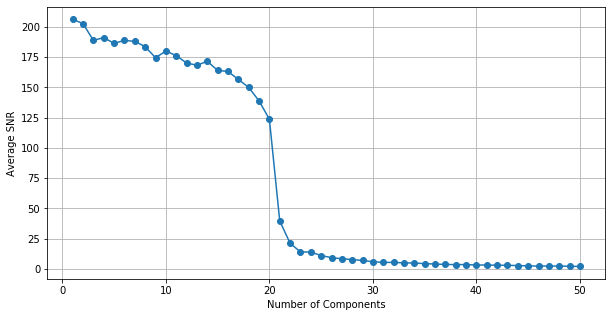

In [32]:
plt.plot(range(1,ComponentsNumbers+1),mean_SNR, marker='o')
plt.ylabel("Average SNR")
plt.xlabel("Number of Components")
plt.grid()
plt.show()

In [33]:
output_df = pd.DataFrame({'x': range(1,ComponentsNumbers+1),'y': mean_SNR})  
output_df.to_csv('UnknwonFrequencySupport.dat')